<a href="https://colab.research.google.com/github/sastelvio/Data_Science_Classes/blob/main/lab_session_5_fashion_MNIST_SastelvioMANUEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graded lab session 5 | Deep classification on Fashion-MNIST using pytorch

pierre-henri.conze@imt-atlantique.fr

francois.rousseau@imt-atlantique.fr


---



#### **Student name** = Sastélvio Serafim MANUEL

### Objective of this lab session: perform classification on Fashion-MNIST using multi-layer perceptron, convolutional neural networks and transfer learning to obtain the best classification results as possible.

#### Challenge: the first 3 students in terms of overall test accuracy results (whatever the methodology used) will obtain bonus points!

In [61]:
#ALL THE IMPORTS
from torchvision import datasets
import torchvision.transforms as transforms

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

from sklearn.metrics import confusion_matrix
import itertools

import torchvision.models as models

import math  # Import the math module


### Table of Contents

* [Data management](#section_1)
    * [Question 1.1](#question_1_1)
    * [Question 1.2](#question_1_2)
    * [Question 1.3](#question_1_3)
    * [Question 1.4](#question_1_4)
* [Multi-Layer Perceptron](#section_2)    
    * [Question 2.1](#question_2_1)
    * [Question 2.2](#question_2_2)
    * [Question 2.3](#question_2_3)
    * [Question 2.4](#question_2_4)
    * [Question 2.5](#question_2_5)
* [Convolutional neural network](#section_3)    
    * [Question 3.1](#question_3_1)
    * [Question 3.2](#question_3_2)
    * [Question 3.3](#question_3_3)
    * [Question 3.4](#question_3_4)
    * [Question 3.5](#question_3_5)
    * [Question 3.6](#question_3_6)
    * [Question 3.7](#question_3_7)
* [Transfer learning from ImageNet](#section_4)    
    * [Question 4.1](#question_4_1)
    * [Question 4.2](#question_4_2)
    * [Question 4.3](#question_4_3)
    * [Question 4.4](#question_4_4)
    * [Question 4.5](#question_4_5)
* [Challenge](#section_5)    
    * [Question 5.1](#question_5_1)

## 1- Data management <a class="anchor" id="section_1"></a>

Start with these lines of code to automatically download the Fashion-MNIST dataset.

In [2]:
transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.FashionMNIST(root = 'data', train = False, download = True, transform = transform)

#### **Question 1.1** - Fashion-MNIST is a dataset consisting of a training set of A examples and a test set of B examples. Each example is a CxC grayscale image, associated with a label from D classes. What are the values for A, B, C and D? <a class="anchor" id="question_1_1"></a>

In [3]:
# Get the sizes of the training and test sets and the image size
A = len(train_data)  # Number of examples in the training set
B = len(test_data)   # Number of examples in the test set
C = train_data[0][0].shape[-1]  # Image size (assuming all images have the same size)
D = len(train_data.classes)  # Number of classes

# Print the values
print("A: Training set size =", A)
print("B: Test set size =", B)
print("C: Image size =", C)
print("D: Number of classes =", D)

A: Training set size = 60000
B: Test set size = 10000
C: Image size = 28
D: Number of classes = 10


As indicated below, each Fashion-MNIST sample is assigned to one of the following classes: 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot.

In [4]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


#### **Question 1.2** - Complete the following cell to create data loaders ([documentation](https://pytorch.org/docs/stable/data.html)) for training, validation and test sets. <a class="anchor" id="question_1_2"></a>

In [5]:
def create_data_loaders(batch_size, valid_size, train_data, test_data): # FUNCTION TO BE COMPLETED
  # Calculate the number of training samples to use for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # Define samplers for training and validation sets
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Create data loaders for training, validation, and test sets
    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    return train_loader, valid_loader, test_loader

In [6]:
batch_size = 20 #batch_size = 20: This line sets the batch size to 20. The batch size determines how many examples are processed in each iteration during training.
valid_size = 0.2 #20% of the training data will be used for validation, and the remaining 80% will be used for actual training

train_loader, valid_loader, test_loader = create_data_loaders(batch_size, valid_size, train_data, test_data)

#### **Question 1.3** - Visualize some images from the training set with corresponding ground truth labels. <a class="anchor" id="question_1_3"></a>

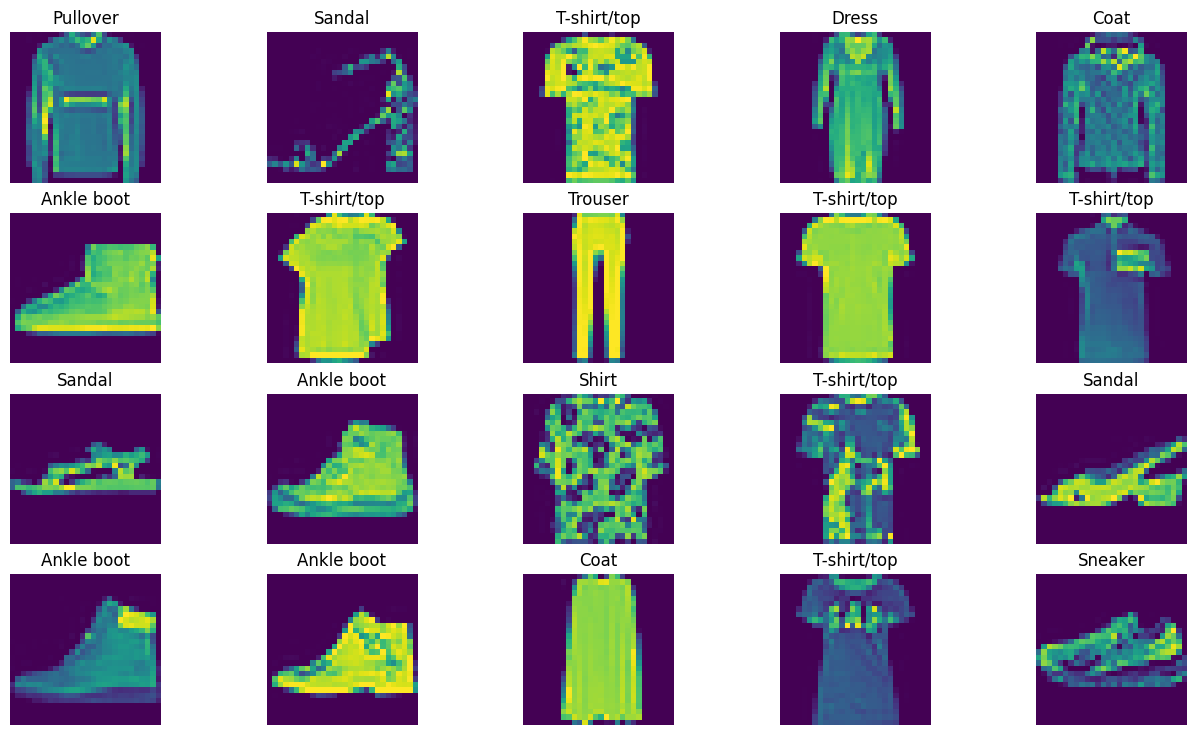

In [7]:
# Function to show a batch of images
def show_images(images, labels):
    plt.figure(figsize=(16, 9))
    for i in range(len(images)):
        plt.subplot(4, 5, i + 1)
        plt.title(train_data.classes[labels[i]])  # Use the class labels for titles
        plt.imshow(images[i].permute(1, 2, 0).numpy())  # Convert the tensor to a NumPy array and rearrange dimensions
        plt.axis('off')
    plt.show()

# Create a data loader for the training set
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the batch of images and labels
show_images(images, labels)

#### **Question 1.4** - View one of these images with more details by superimposing the greyscale intensity values directly on it. <a class="anchor" id="question_1_4"></a>

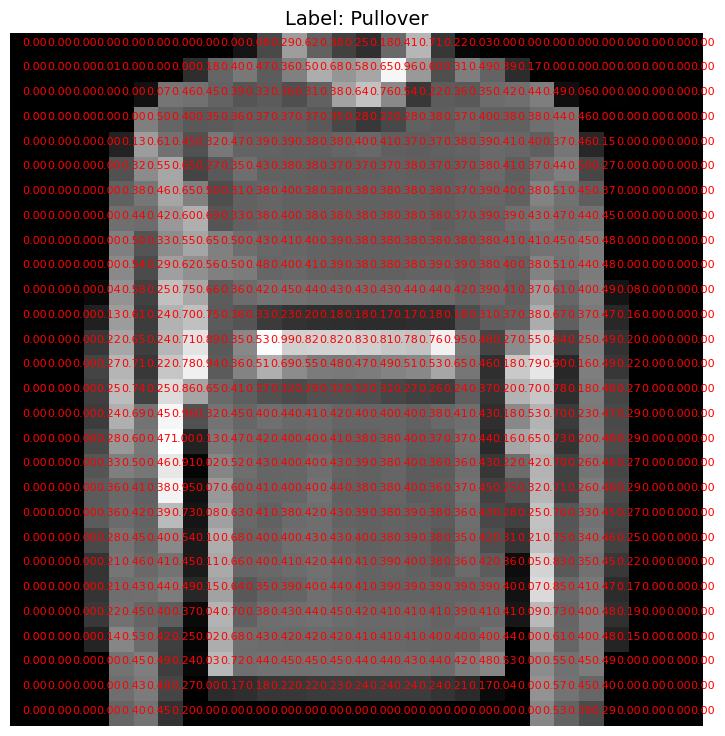

In [8]:
#CHOOSE TO WORK WITH THE FIRST IMAGE

# Function to display an image with grayscale intensity values superimposed
def show_image_with_intensity(image, label):
    plt.figure(figsize=(9, 9))
    plt.imshow(image.permute(1, 2, 0).numpy(), cmap='gray')  # Display the image
    plt.title(f"Label: {train_data.classes[label]}", fontsize=14)

    # Superimpose grayscale intensity values on the image
    for i in range(image.shape[1]):
        for j in range(image.shape[2]):
            plt.text(j, i, f'{image[0, i, j].item():.2f}', color='red', fontsize=8)

    plt.axis('off')
    plt.show()

# Choose an image from the training set (the first image in the batch)
image_to_show = images[0]
label_to_show = labels[0]

# Show the selected image with intensity values
show_image_with_intensity(image_to_show, label_to_show)

## 2- Multi-Layer Perceptron (MLP) <a class="anchor" id="section_2"></a>

First, let us use a multi-layer perceptron (MLP) to automatically classify Fashion-MNIST images.

#### **Question 2.1** - Define a MPL architecture with (at least) 2 fully-connected as well as dropout layers. <a class="anchor" id="question_2_1"></a>

In [9]:
# Define the MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_prob1, dropout_prob2):
        super(MLP, self).__init__()

        # Fully-connected layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

        # Dropout layers
        self.dropout1 = nn.Dropout(p=dropout_prob1)
        self.dropout2 = nn.Dropout(p=dropout_prob2)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


#### **Question 2.2** - Train the pre-defined MPL network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_2_2"></a>

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [11]:
# Define hyperparameters
input_size = 784  # 28x28 image size when flattened
hidden_size1 = 128
hidden_size2 = 64
output_size = 10  # 10 classes in Fashion-MNIST
dropout_prob1 = 0.5  # You can adjust these values
dropout_prob2 = 0.3

# Instantiate the MLP model
model_1 = MLP(input_size, hidden_size1, hidden_size2, output_size, dropout_prob1, dropout_prob2)
# Move the model to the appropriate device
model_1.to(device=device)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
)

In [12]:
#DEFINE THE CRITERION
criterion = nn.CrossEntropyLoss()

In [13]:
#DEFINE THE OPTIMIZER
optimizer = optim.SGD(model_1.parameters(), lr=0.01)  # You can adjust the learning rate

In [14]:
n_epochs = 30

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):
    train_losses, valid_losses = [], []
    valid_loss_min = np.Inf

    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0

        # Training the model
        model.train()
        for data, label in train_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)

            optimizer.zero_grad()  # Clear the gradients

            output = model(data)  # Forward pass
            loss = criterion(output, label)  # Calculate the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            train_loss += loss.item() * data.size(0)

        # Validating the model
        model.eval()
        for data, label in valid_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)

            output = model(data)  # Forward pass
            loss = criterion(output, label)  # Calculate the loss

            valid_loss += loss.item() * data.size(0)

        # Calculate the average loss for this epoch
        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch + 1, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss

    return train_losses, valid_losses

In [15]:
#RUN THE TRAINING FUNCTION
train_losses_1, valid_losses_1 = training(n_epochs, train_loader, valid_loader, model_1, criterion, optimizer)

Epoch: 1 	Training Loss: 1.163979 	Validation Loss: 0.657700
Validation loss decreased (inf --> 0.657700). Saving model...
Epoch: 2 	Training Loss: 0.694424 	Validation Loss: 0.527861
Validation loss decreased (0.657700 --> 0.527861). Saving model...
Epoch: 3 	Training Loss: 0.591900 	Validation Loss: 0.466434
Validation loss decreased (0.527861 --> 0.466434). Saving model...
Epoch: 4 	Training Loss: 0.539702 	Validation Loss: 0.439456
Validation loss decreased (0.466434 --> 0.439456). Saving model...
Epoch: 5 	Training Loss: 0.507281 	Validation Loss: 0.410245
Validation loss decreased (0.439456 --> 0.410245). Saving model...
Epoch: 6 	Training Loss: 0.486973 	Validation Loss: 0.390779
Validation loss decreased (0.410245 --> 0.390779). Saving model...
Epoch: 7 	Training Loss: 0.471339 	Validation Loss: 0.378154
Validation loss decreased (0.390779 --> 0.378154). Saving model...
Epoch: 8 	Training Loss: 0.457768 	Validation Loss: 0.368046
Validation loss decreased (0.378154 --> 0.368046

#### **Question 2.3** - Plot the evolution of the loss function for both training and validation sets with respect to epochs to study the convergence of the training process. <a class="anchor" id="question_2_3"></a>

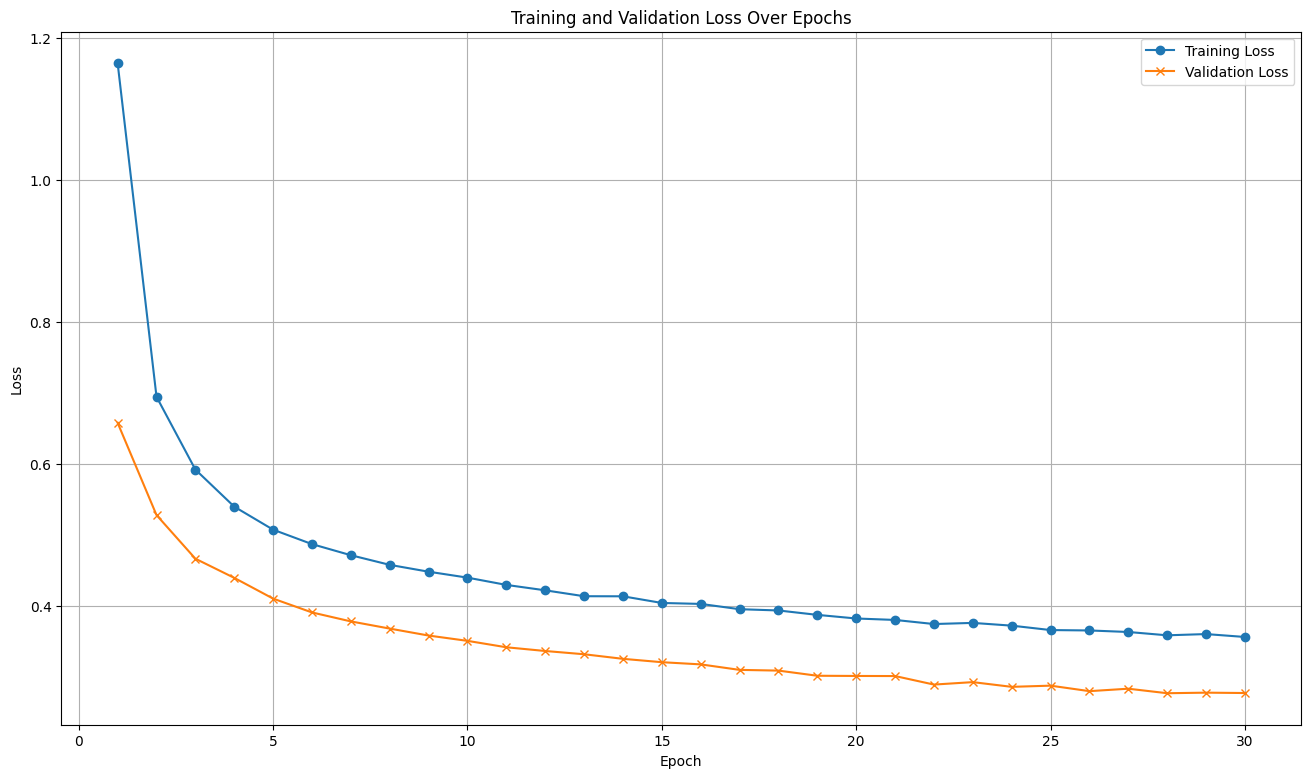

In [16]:
# Plot the training and validation loss
plt.figure(figsize=(16, 9))
plt.plot(range(1, n_epochs + 1), train_losses_1, label='Training Loss', marker='o')
plt.plot(range(1, n_epochs + 1), valid_losses_1, label='Validation Loss', marker='x')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Let us load the model corresponding to the lowest validation loss.

In [17]:
model_1.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

#### **Question 2.4** - Test the best model on (unseen) test data and evaluate it’s performance in terms of overall and per-class accuracy scores. <a class="anchor" id="question_2_4"></a>

In [18]:
def evaluation(model, test_loader, criterion):

  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data)
      loss = criterion(output, label)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(label.data.view_as(pred)))
      for i in range(len(label)):
          digit = label.data[i]
          class_correct[digit] += correct[i].item()
          class_total[digit] += 1

  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(10):
      print('test accuracy of %s: %2d%% (%2d/%2d)' % (class_names[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [19]:
#RUN THE EVALUATION FUNCTION
evaluation(model_1, test_loader, criterion)

test Loss: 0.354832

test accuracy of T-shirt/top: 84% (845/1000)
test accuracy of Trouser: 95% (958/1000)
test accuracy of Pullover: 81% (817/1000)
test accuracy of Dress: 90% (909/1000)
test accuracy of Coat: 83% (838/1000)
test accuracy of Sandal: 94% (948/1000)
test accuracy of Shirt: 56% (565/1000)
test accuracy of Sneaker: 94% (946/1000)
test accuracy of Bag: 96% (967/1000)
test accuracy of Ankle boot: 95% (951/1000)

test accuracy (overall): 87.44% (8744/10000)


#### **Question 2.5** - Visualize some incorrect predictions by displaying test images and labels in the format: "predicted (ground-truth)". <a class="anchor" id="question_2_5"></a>

In [20]:
def get_all_prediction(model, loader):
    preds = torch.tensor([], dtype=torch.long)
    targets = torch.tensor([], dtype=torch.long)
    for data, label in loader:
        data = data.to(device=device, dtype=torch.float32)
        label = label.to(device=device, dtype=torch.long)
        with torch.no_grad():
            output = model(data)
        targets = torch.cat((targets, label.cpu()), dim = 0)
        preds = torch.cat((preds, torch.max(output.cpu(), 1)[1]), dim = 0)
    return targets.numpy(), preds.numpy()

In [21]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_1 = get_all_prediction(model_1, test_loader)

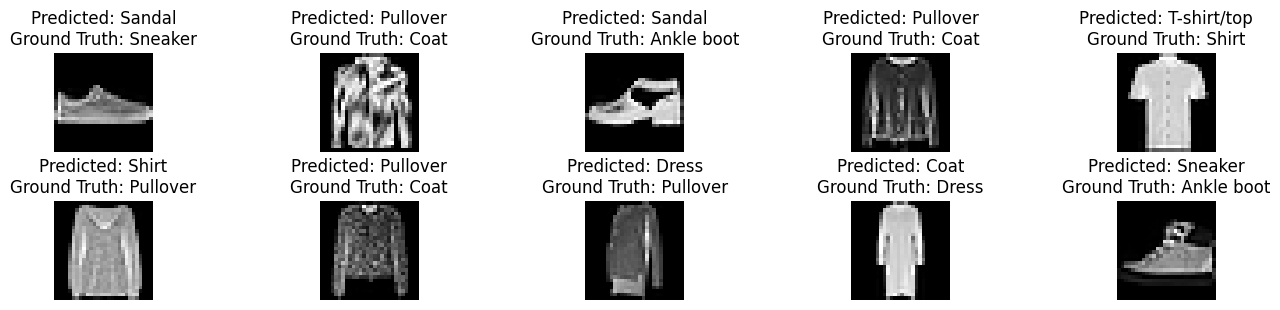

In [81]:
# Find indices where the predictions do not match the ground-truth labels
incorrect_indices = np.where(targets != preds_1)[0]

# Number of incorrect predictions to display
num_display = 10

# Function to show a batch of images with labels
def show_images_with_labels(images, preds, targets, num_dis):
    # Create a figure and adjust subplot spacing
    fig = plt.figure(figsize=(16, 9))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust the spacing here

    for i in range(num_dis):
        plt.subplot(int(math.ceil(num_dis / 2)), int(num_dis / 2), i + 1)

        # Determine text color for preds[i]
        text_color = 'green' if train_data.classes[preds[i]] == train_data.classes[targets[i]] else 'red'

        # Set the title for preds[i] with the specified text color
        title = f"Predicted: {train_data.classes[preds[i]]}\nGround Truth: {train_data.classes[targets[i]]}"
        plt.title(title)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Display a batch of incorrect predictions
show_images_with_labels(test_data.data[incorrect_indices][:num_display], preds_1[incorrect_indices][:num_display], targets[incorrect_indices][:num_display], num_display)

## 3- Convolutional neural network (CNN) <a class="anchor" id="section_3"></a>

Let us now switch from MLP to convolutional neural network (CNN) to classify Fashion-MNIST images.

#### **Question 3.1** - Define a CNN architecture using (at least) 2 patterns [CONV - CONV - POOL] as well as dropout and fully-connected layers. <a class="anchor" id="question_3_1"></a>

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Max-pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully-connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Assuming input image size is 28x28
        self.fc2 = nn.Linear(128, 10)  # Output layer with 10 classes

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)  # You can adjust the dropout probability

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

#### **Question 3.2** - Describe input/output sizes of each layer using summary() from torchsummary. <a class="anchor" id="question_3_2"></a>

In [24]:
model_2 = CNN()
model_2.to(device=device)

# As the size is 28x28 (C) in Fashion-MNIST images
summary(model_2, (1, C, C)) #1 (channel) = grayscale


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Linear-5                  [-1, 128]         200,832
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 0.79
Estimated Total Size (MB): 0.97
----------------------------------------------------------------


#### **Question 3.3** - Train the pre-defined CNN network with cross entropy as loss function and stochastic gradient descent as optimization algorithm. <a class="anchor" id="question_3_3"></a>

In [25]:
#DEFINE THE OPTIMIZER
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)  # You can adjust the learning rate (lr)

In [26]:
#RUN THE TRAINING FUNCTION
# Set the number of epochs for training
n_epochs = 30

# Training loop (you can use the previously defined training function)
train_losses_2, valid_losses_2 = training(n_epochs, train_loader, valid_loader, model_2, criterion, optimizer)

Epoch: 1 	Training Loss: 0.947937 	Validation Loss: 0.594984
Validation loss decreased (inf --> 0.594984). Saving model...
Epoch: 2 	Training Loss: 0.610844 	Validation Loss: 0.491080
Validation loss decreased (0.594984 --> 0.491080). Saving model...
Epoch: 3 	Training Loss: 0.520992 	Validation Loss: 0.430737
Validation loss decreased (0.491080 --> 0.430737). Saving model...
Epoch: 4 	Training Loss: 0.469659 	Validation Loss: 0.384883
Validation loss decreased (0.430737 --> 0.384883). Saving model...
Epoch: 5 	Training Loss: 0.433590 	Validation Loss: 0.358707
Validation loss decreased (0.384883 --> 0.358707). Saving model...
Epoch: 6 	Training Loss: 0.407430 	Validation Loss: 0.344198
Validation loss decreased (0.358707 --> 0.344198). Saving model...
Epoch: 7 	Training Loss: 0.385940 	Validation Loss: 0.319609
Validation loss decreased (0.344198 --> 0.319609). Saving model...
Epoch: 8 	Training Loss: 0.369169 	Validation Loss: 0.299140
Validation loss decreased (0.319609 --> 0.299140

#### **Question 3.4** - Display in a single graph the loss functions for training and validation sets obtained with both MLP and CNN models. <a class="anchor" id="question_3_4"></a>

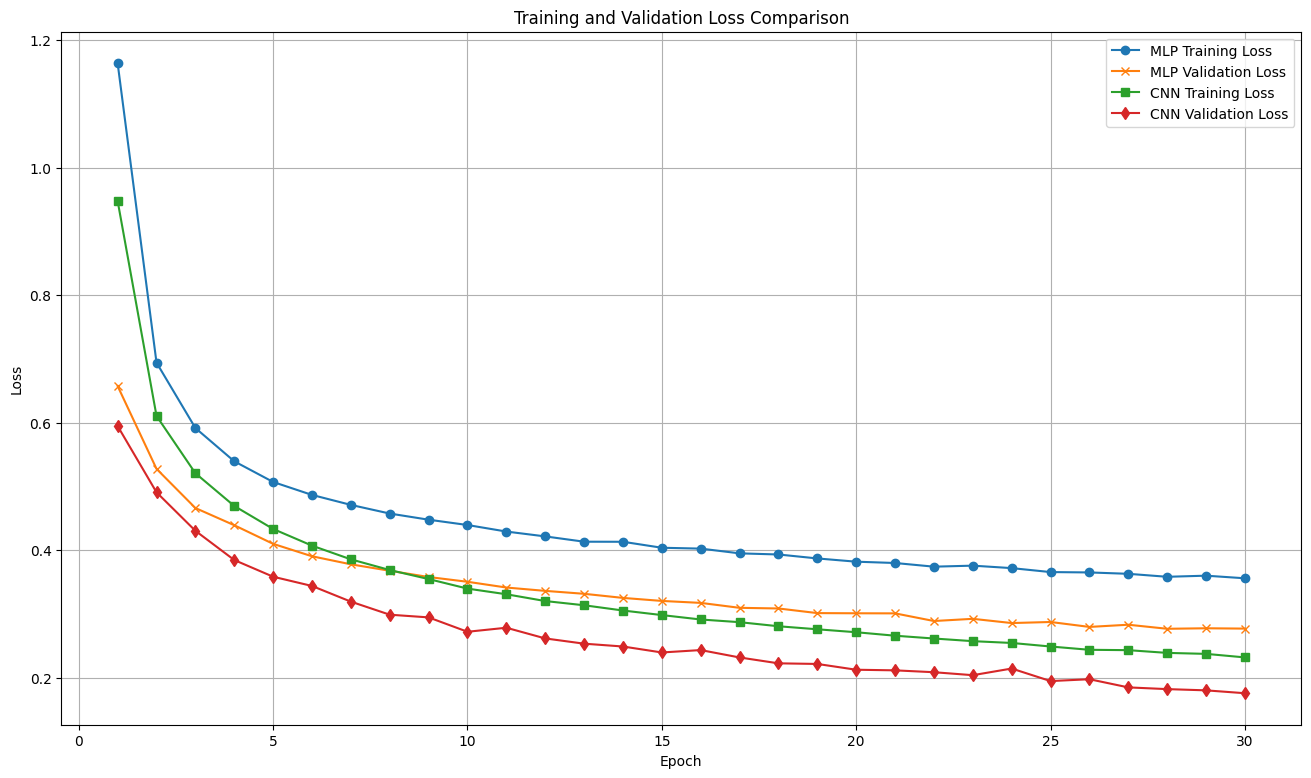

In [27]:
# Combine the training and validation losses for both models
train_losses_mlp = train_losses_1
valid_losses_mlp = valid_losses_1
train_losses_cnn = train_losses_2
valid_losses_cnn = valid_losses_2

# Create a range of epochs for the x-axis
epochs = range(1, len(train_losses_mlp) + 1)

# Plot the loss functions for both models
plt.figure(figsize=(16, 9))
plt.plot(epochs, train_losses_mlp, label='MLP Training Loss', marker='o')
plt.plot(epochs, valid_losses_mlp, label='MLP Validation Loss', marker='x')
plt.plot(epochs, train_losses_cnn, label='CNN Training Loss', marker='s')
plt.plot(epochs, valid_losses_cnn, label='CNN Validation Loss', marker='d')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


As previously, we load the model corresponding to the lowest validation loss.

In [28]:
model_2.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

#### **Question 3.5** - Test the model on test data and evaluate it through overall and per-class accuracy scores. Compare these scores with the ones obtained using MLP. <a class="anchor" id="question_3_5"></a>

In [29]:
#RUN THE EVALUATION FUNCTION
evaluation(model_2, test_loader, criterion)

test Loss: 0.249235

test accuracy of T-shirt/top: 88% (880/1000)
test accuracy of Trouser: 98% (983/1000)
test accuracy of Pullover: 87% (870/1000)
test accuracy of Dress: 92% (925/1000)
test accuracy of Coat: 84% (848/1000)
test accuracy of Sandal: 97% (970/1000)
test accuracy of Shirt: 69% (695/1000)
test accuracy of Sneaker: 96% (969/1000)
test accuracy of Bag: 98% (987/1000)
test accuracy of Ankle boot: 96% (963/1000)

test accuracy (overall): 90.90% (9090/10000)


#### **Question 3.6** - Display CNN results for images whose prediction was incorrect with MLP. Labels should be indicated in the following format: "CNN label (ground-truth)" in red if wrong, green otherwise. <a class="anchor" id="question_3_6"></a>

In [30]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_2 = get_all_prediction(model_2, test_loader)

MLP label (ground-truth): Dress (Shirt)
CNN label (ground-truth): Shirt (Shirt)


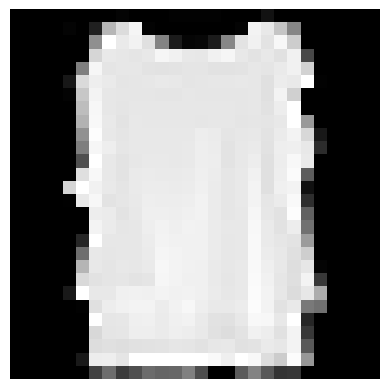

MLP label (ground-truth): Sneaker (Sandal)
CNN label (ground-truth): Sandal (Sandal)


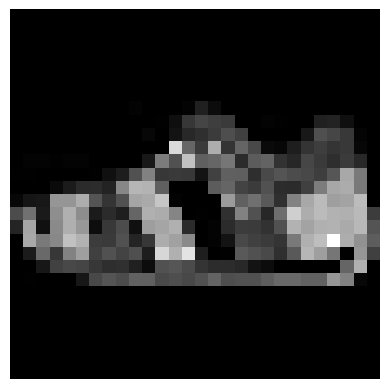

MLP label (ground-truth): Ankle boot (Sneaker)
CNN label (ground-truth): Sneaker (Sneaker)


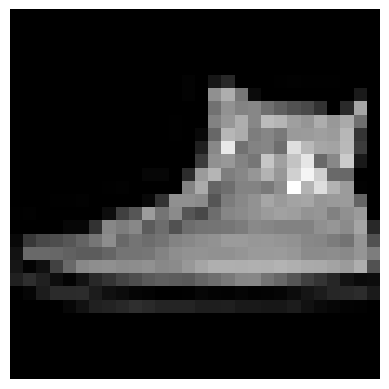

MLP label (ground-truth): Bag (Dress)
CNN label (ground-truth): Dress (Dress)


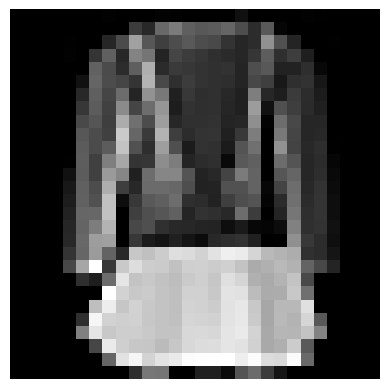

MLP label (ground-truth): Sneaker (Ankle boot)
CNN label (ground-truth): Ankle boot (Ankle boot)


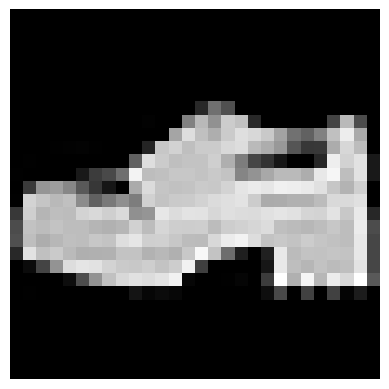

MLP label (ground-truth): Coat (Shirt)
CNN label (ground-truth): Shirt (Shirt)


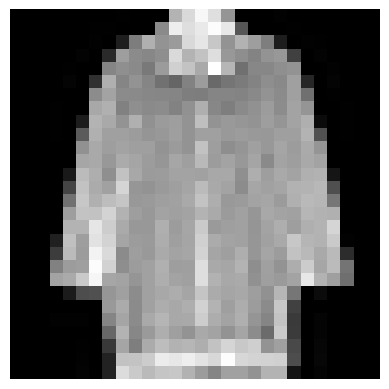

MLP label (ground-truth): Bag (Shirt)
CNN label (ground-truth): Shirt (Shirt)


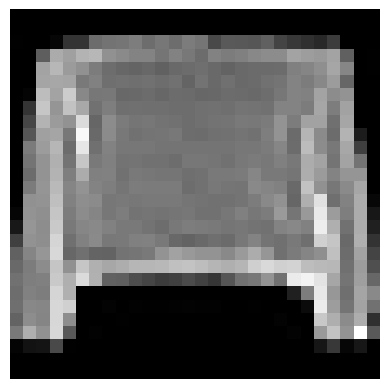

MLP label (ground-truth): Sneaker (Sandal)
CNN label (ground-truth): Sandal (Sandal)


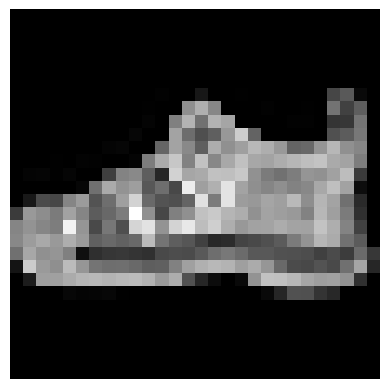

MLP label (ground-truth): Coat (Shirt)
CNN label (ground-truth): Shirt (Shirt)


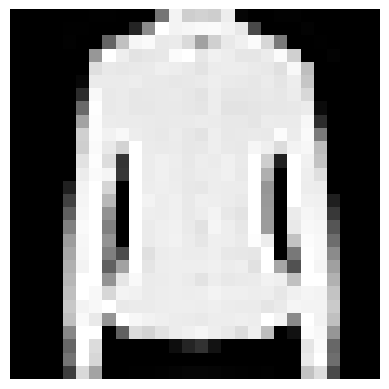

MLP label (ground-truth): Coat (Pullover)
CNN label (ground-truth): Pullover (Pullover)


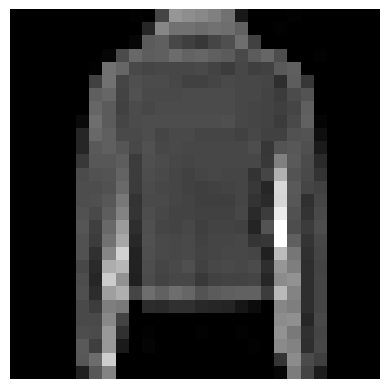

MLP label (ground-truth): Sandal (Ankle boot)
CNN label (ground-truth): Ankle boot (Ankle boot)


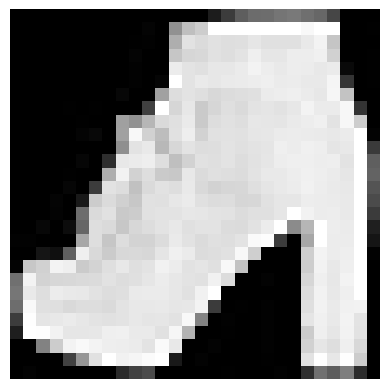

MLP label (ground-truth): Coat (Pullover)
CNN label (ground-truth): Pullover (Pullover)


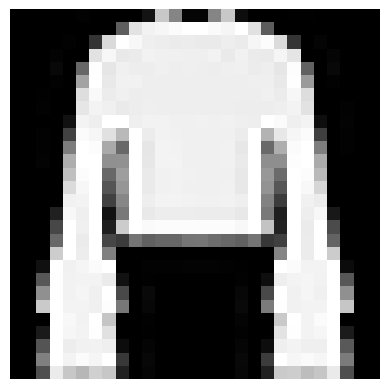

MLP label (ground-truth): T-shirt/top (Shirt)
CNN label (ground-truth): Shirt (Shirt)


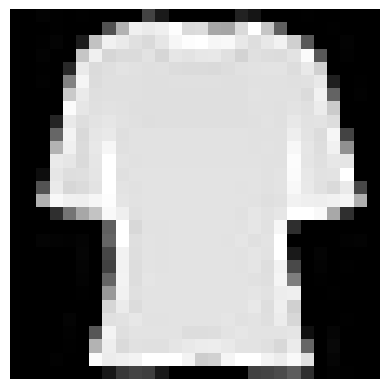

MLP label (ground-truth): Bag (T-shirt/top)
CNN label (ground-truth): T-shirt/top (T-shirt/top)


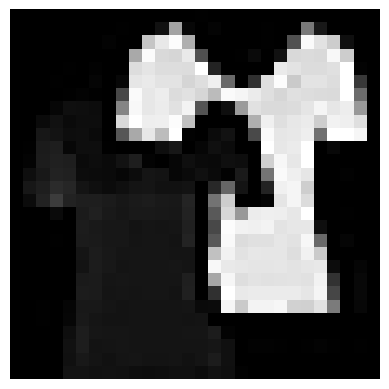

MLP label (ground-truth): Sneaker (Sandal)
CNN label (ground-truth): Sandal (Sandal)


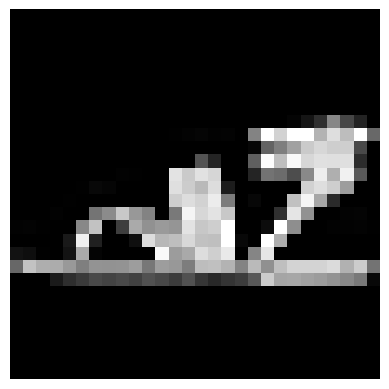

MLP label (ground-truth): Coat (Shirt)
CNN label (ground-truth): Shirt (Shirt)


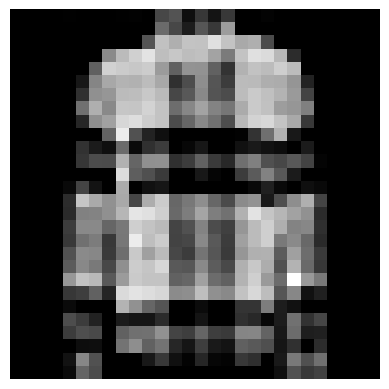

MLP label (ground-truth): T-shirt/top (Pullover)
CNN label (ground-truth): Pullover (Pullover)


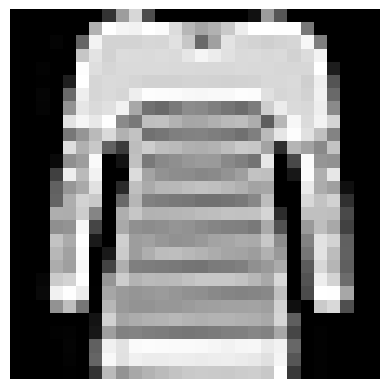

MLP label (ground-truth): Coat (Pullover)
CNN label (ground-truth): Pullover (Pullover)


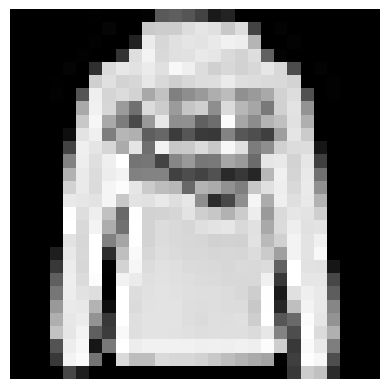

MLP label (ground-truth): Shirt (T-shirt/top)
CNN label (ground-truth): T-shirt/top (T-shirt/top)


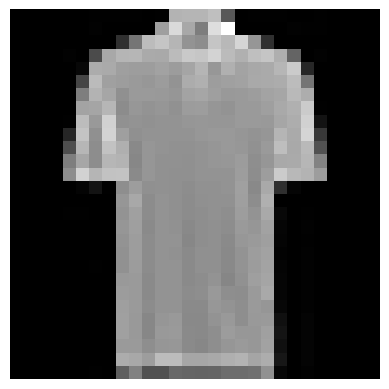

MLP label (ground-truth): Pullover (Shirt)
CNN label (ground-truth): Shirt (Shirt)


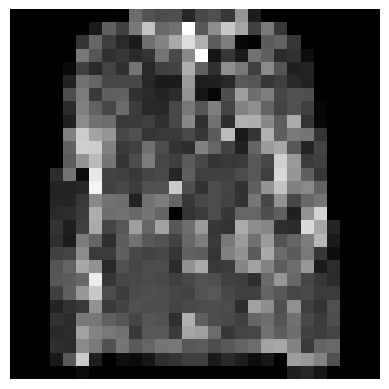

MLP label (ground-truth): T-shirt/top (Shirt)
CNN label (ground-truth): Shirt (Shirt)


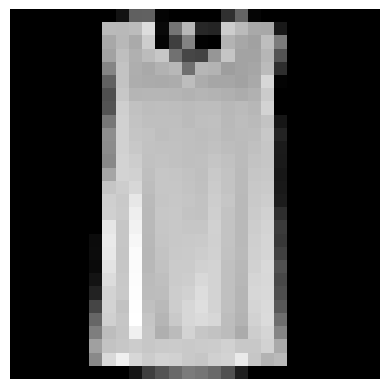

MLP label (ground-truth): Shirt (Bag)
CNN label (ground-truth): Bag (Bag)


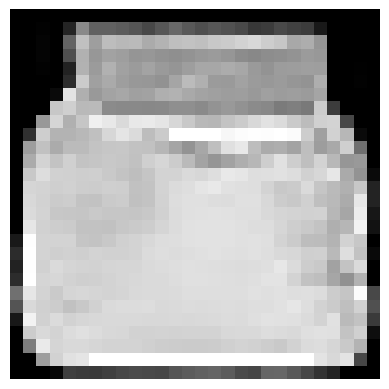

MLP label (ground-truth): Coat (Shirt)
CNN label (ground-truth): Shirt (Shirt)


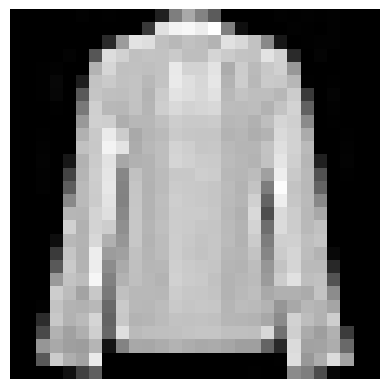

MLP label (ground-truth): Coat (Shirt)
CNN label (ground-truth): Shirt (Shirt)


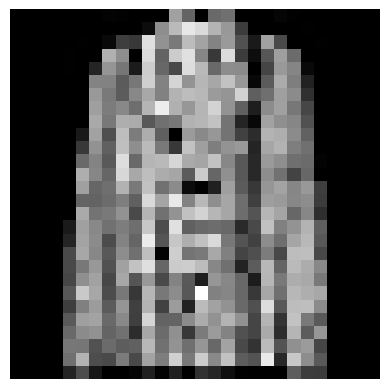

MLP label (ground-truth): T-shirt/top (Shirt)
CNN label (ground-truth): Shirt (Shirt)


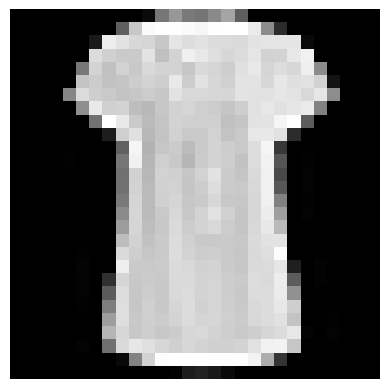

MLP label (ground-truth): Pullover (T-shirt/top)
CNN label (ground-truth): T-shirt/top (T-shirt/top)


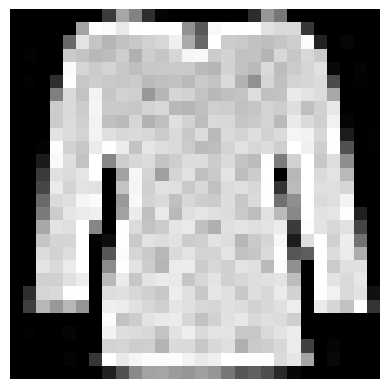

MLP label (ground-truth): Pullover (Coat)
CNN label (ground-truth): Coat (Coat)


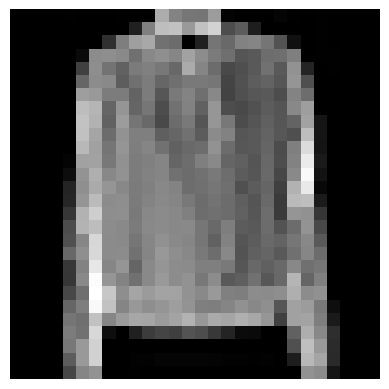

MLP label (ground-truth): Pullover (Shirt)
CNN label (ground-truth): Shirt (Shirt)


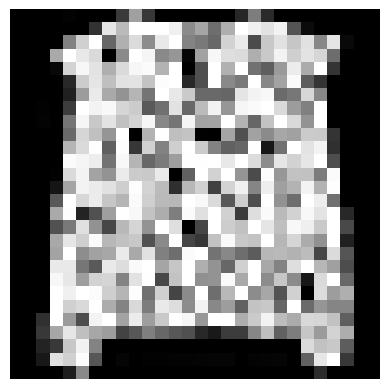

MLP label (ground-truth): Shirt (T-shirt/top)
CNN label (ground-truth): T-shirt/top (T-shirt/top)


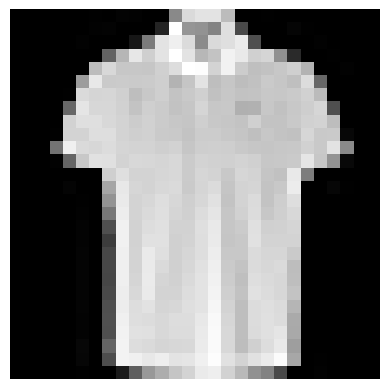

MLP label (ground-truth): Dress (T-shirt/top)
CNN label (ground-truth): T-shirt/top (T-shirt/top)


KeyboardInterrupt: ignored

In [76]:
# Find indices where MLP predictions were incorrect, but CNN predictions are correct
incorrect_mlp_indices = np.where(targets != preds_1)[0]
correct_cnn_indices = np.where(targets == preds_2)[0]

# Find the intersection of the two sets to identify images where MLP was incorrect, but CNN is correct
correct_cnn_and_incorrect_mlp_indices = set(incorrect_mlp_indices) & set(correct_cnn_indices)

# Display the images and labels
for index in correct_cnn_and_incorrect_mlp_indices:
    cnn_label = preds_2[index]
    mlp_label = preds_1[index]
    ground_truth_label = targets[index]

    # Define label colors
    if cnn_label != ground_truth_label:
        cnn_label_color = 'red'
    else:
        cnn_label_color = 'green'

    # Display the MLP label (ground-truth) in blue
    mlp_label_color = 'blue'

    print(f"MLP label (ground-truth): \033[94m{train_data.classes[mlp_label]}\033[0m ({train_data.classes[ground_truth_label]})")
    print(f"CNN label (ground-truth): \033[91m{train_data.classes[cnn_label]}\033[0m ({train_data.classes[ground_truth_label]})")

    # Display the image
    plt.imshow(test_data.data[index], cmap='gray')
    plt.axis('off')
    plt.show()



#### **Question 3.7** - Display the confusion matrix for both MLP and CNN models. <a class="anchor" id="question_3_7"></a>

In [32]:
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')

normalized confusion matrix


<ipython-input-33-5a65b9871118>:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


normalized confusion matrix


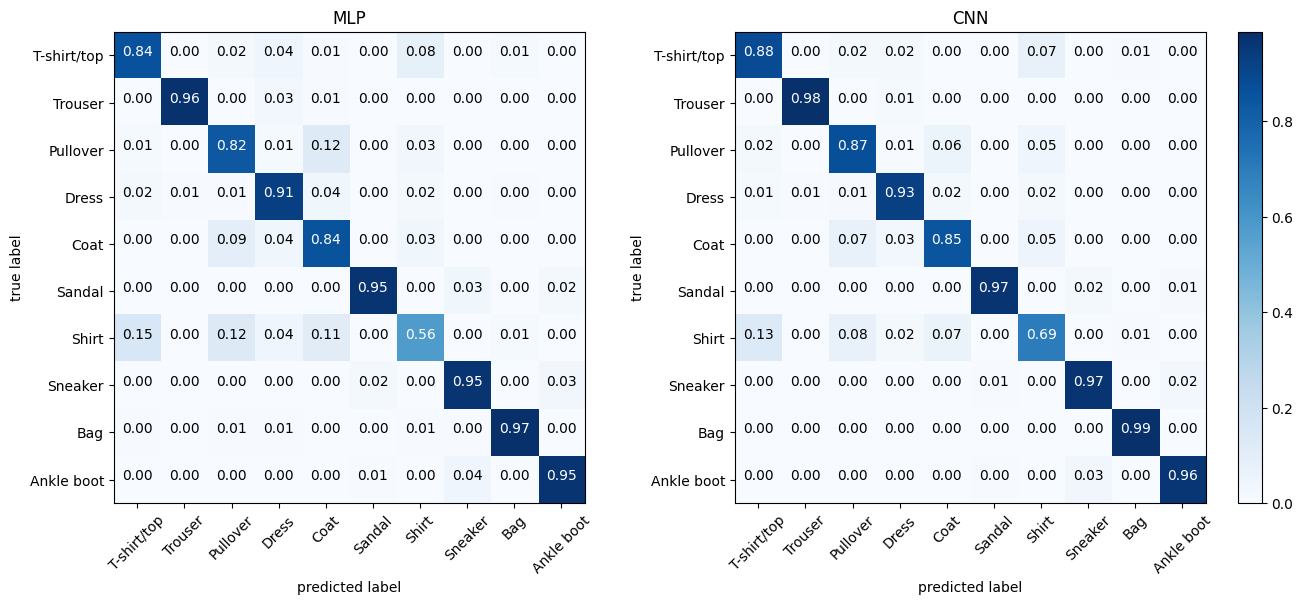

In [33]:
# compute confusion matrix
cnf_matrix_MLP = confusion_matrix(targets, preds_1)
cnf_matrix_CNN = confusion_matrix(targets, preds_2)
np.set_printoptions(precision=2)

# plot normalized confusion matrices
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix_MLP, classes=train_data.classes, normalize=True, title='MLP')
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix_CNN, classes=train_data.classes, normalize=True, title='CNN')
plt.show()


## 4- Transfer learning from ImageNet <a class="anchor" id="section_4"></a>

Transfer learning focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.

Our goal is to use a (well-known) CNN architecture whose weights have been already trained on ImageNet to perform transfer learning and fine tuning. ImageNet is a large visual database designed for visual object recognition purposes wich contains more than 14 million images!

#### **Question 4.1** - Modify the Fashion-MNIST dataset to make it fit to  ImageNet by extending Fashion-MNIST images from greyscale to 3-channels images. Since the minimal image dimension as inputs of pre-trained CNN models is 48x48, you will also need to resize images. To do so, use transform.Compose(), transforms.Resize() and transforms.Grayscale(). More details on image transformations are available in the [documentation](https://pytorch.org/vision/stable/transforms.html). <a class="anchor" id="question_4_1"></a>

In [34]:
#CALL transforms.Compose to adapt the dataset to the VGG16 architecture
# Define a custom transform to convert grayscale images to 3-channel images and resize them
custom_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.Resize((48, 48)),  # Resize to 48x48
    transforms.ToTensor()  # Convert to a tensor
])

# Apply the custom transform to the Fashion-MNIST dataset
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=custom_transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=custom_transform)



#### **Question 4.2** - Create training, validation and test data loaders. Check the dimensions of images arising from the modified Fasion-MNIST dataset. <a class="anchor" id="question_4_2"></a>

In [35]:
# Split the training data into training and validation sets
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))  # 20% of data for validation
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Define batch size
batch_size = 64

# Define data loaders for training, validation, and test sets
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Check the dimensions of images from the modified Fashion-MNIST dataset
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.numpy().shape)


(64, 3, 48, 48)


#### **Question 4.3** - Exploit a vgg16 architecture ([related paper](https://arxiv.org/pdf/1409.1556.pdf)) pre-trained on ImageNet to improve the classification scores on Fashion-MNIST through fine-tuning. See the [documentation](https://pytorch.org/vision/stable/models.html#id2) for further details. Use summary() from torchsummary to describe each of the vgg16 layers. To avoid a too long learning time, you may use only 5 epochs during fine-tuning. <a class="anchor" id="question_4_3"></a>

In [36]:
# Load the pre-trained VGG16 model
model_3 = models.vgg16(pretrained=True)

# Replace the final classification layer to match the number of classes in Fashion-MNIST (10 classes)
num_classes = D
model_3.classifier[6] = nn.Linear(4096, num_classes)

# Move the model to the appropriate device
model_3.to(device=device)

# Use the summary function to describe each layer
summary(model_3, (3, 48, 48))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
              ReLU-2           [-1, 64, 48, 48]               0
            Conv2d-3           [-1, 64, 48, 48]          36,928
              ReLU-4           [-1, 64, 48, 48]               0
         MaxPool2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
              ReLU-7          [-1, 128, 24, 24]               0
            Conv2d-8          [-1, 128, 24, 24]         147,584
              ReLU-9          [-1, 128, 24, 24]               0
        MaxPool2d-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 256, 12, 12]         295,168
             ReLU-12          [-1, 256, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         590,080
             ReLU-14          [-1, 256,

In [37]:
# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model_3.parameters(), lr=0.001)

In [38]:
n_epochs = 30
#RUN THE TRAINING FUNCTION
# Define the training function (similar to the one you provided earlier)
def fine_tune_training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):
    train_losses, valid_losses = [], []
    valid_loss_min = np.Inf

    for epoch in range(n_epochs):
        train_loss, valid_loss = 0, 0

        model.train()
        for data, label in train_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        model.eval()
        for data, label in valid_loader:
            data = data.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            with torch.no_grad():
                output = model(data)
            loss = criterion(output, label)
            valid_loss += loss.item() * data.size(0)

        train_loss /= len(train_loader.sampler)
        valid_loss /= len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'Epoch: {epoch+1}\tTraining Loss: {train_loss:.6f}\tValidation Loss: {valid_loss:.6f}')

        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
            torch.save(model.state_dict(), 'vgg16_fine_tuned_model.pt')
            valid_loss_min = valid_loss

    return train_losses, valid_losses

# Run the training function for fine-tuning
train_losses_3, valid_losses_3 = fine_tune_training(n_epochs, train_loader, valid_loader, model_3, criterion, optimizer)


Epoch: 1	Training Loss: 0.638038	Validation Loss: 0.374606
Validation loss decreased (inf --> 0.374606). Saving model ...
Epoch: 2	Training Loss: 0.362724	Validation Loss: 0.308199
Validation loss decreased (0.374606 --> 0.308199). Saving model ...
Epoch: 3	Training Loss: 0.306083	Validation Loss: 0.279736
Validation loss decreased (0.308199 --> 0.279736). Saving model ...
Epoch: 4	Training Loss: 0.271623	Validation Loss: 0.263272
Validation loss decreased (0.279736 --> 0.263272). Saving model ...
Epoch: 5	Training Loss: 0.251556	Validation Loss: 0.272033
Epoch: 6	Training Loss: 0.233078	Validation Loss: 0.243345
Validation loss decreased (0.263272 --> 0.243345). Saving model ...
Epoch: 7	Training Loss: 0.218889	Validation Loss: 0.231591
Validation loss decreased (0.243345 --> 0.231591). Saving model ...
Epoch: 8	Training Loss: 0.206913	Validation Loss: 0.228940
Validation loss decreased (0.231591 --> 0.228940). Saving model ...
Epoch: 9	Training Loss: 0.193992	Validation Loss: 0.22584

#### **Question 4.4** - Test the model on test data and evaluate it through overall and per-class accuracy scores. Compare these scores with the previously obtained ones. <a class="anchor" id="question_4_4"></a>

In [39]:
model_3.load_state_dict(torch.load('vgg16_fine_tuned_model.pt', map_location=device))

<All keys matched successfully>

In [40]:
#RUN THE EVALUATION FUNCTION
evaluation(model_3, test_loader, criterion)

test Loss: 0.216397

test accuracy of T-shirt/top: 87% (872/1000)
test accuracy of Trouser: 98% (986/1000)
test accuracy of Pullover: 90% (903/1000)
test accuracy of Dress: 92% (927/1000)
test accuracy of Coat: 87% (876/1000)
test accuracy of Sandal: 98% (988/1000)
test accuracy of Shirt: 75% (757/1000)
test accuracy of Sneaker: 97% (971/1000)
test accuracy of Bag: 98% (988/1000)
test accuracy of Ankle boot: 96% (968/1000)

test accuracy (overall): 92.36% (9236/10000)


#### **Question 4.5** - Display results for images whose prediction was incorrect with MLP. Labels should be indicated in the following format: "vgg16 label (ground-truth)" in red if wrong, green otherwise. <a class="anchor" id="question_4_5"></a>

In [41]:
#RUN THE GET_ALL_PREDICTION FUNCTION
targets, preds_3 = get_all_prediction(model_3, test_loader)

MLP label (ground-truth): Dress (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


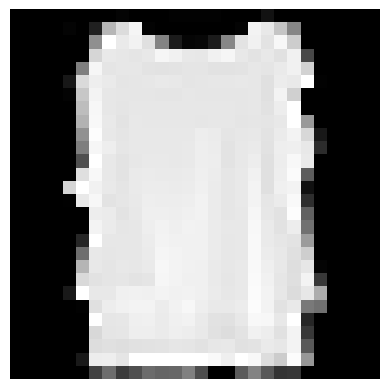

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


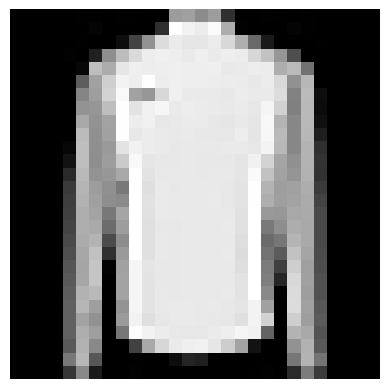

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


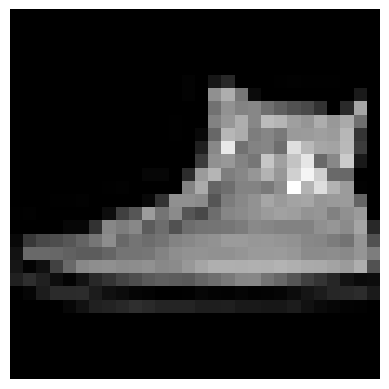

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


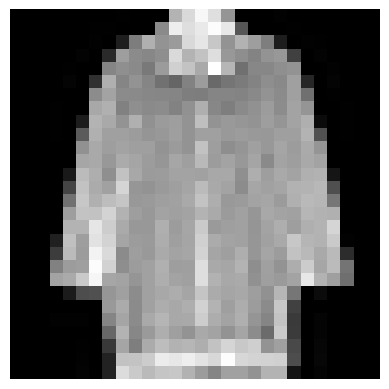

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


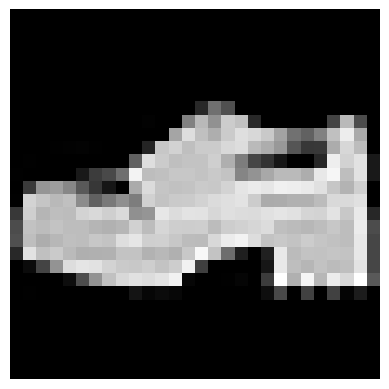

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


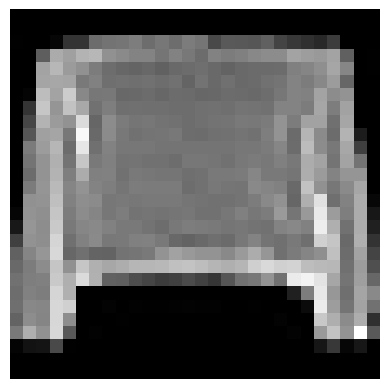

MLP label (ground-truth): Sandal (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


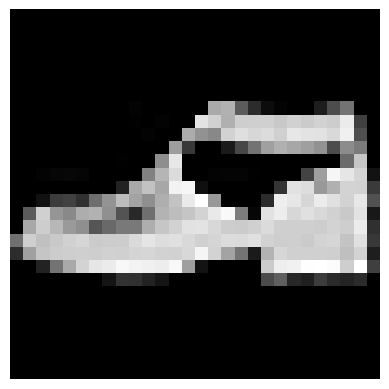

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


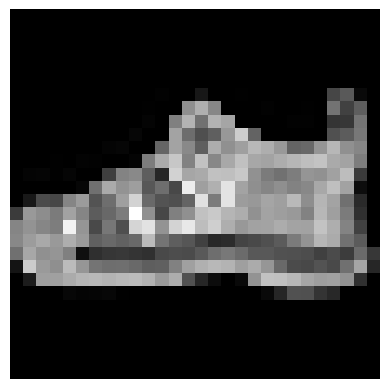

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


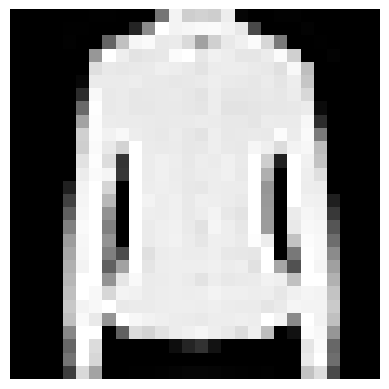

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


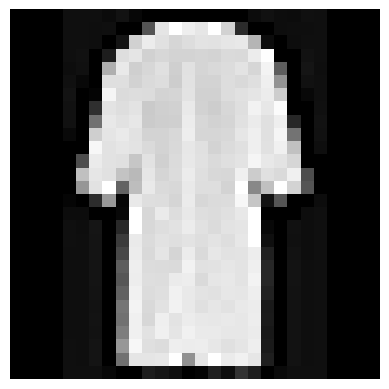

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


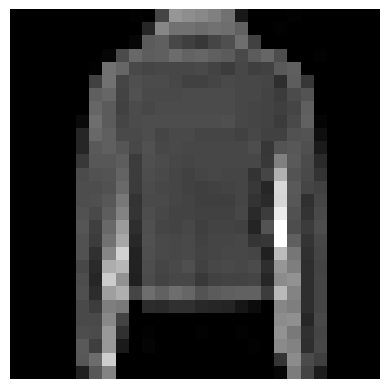

MLP label (ground-truth): Sandal (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


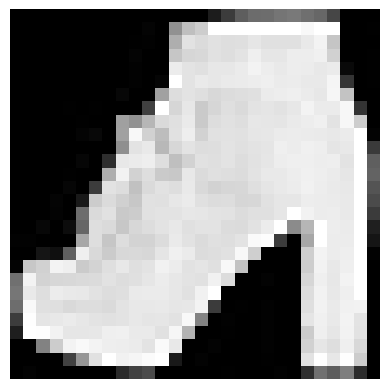

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


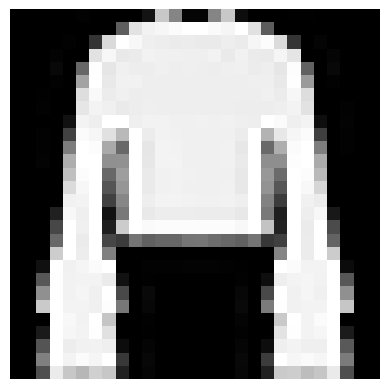

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


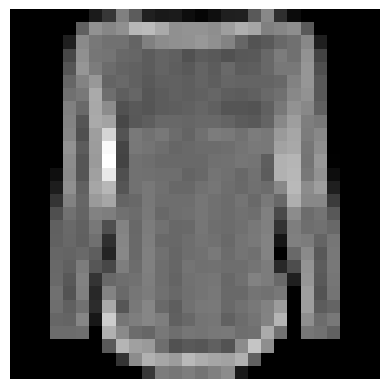

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


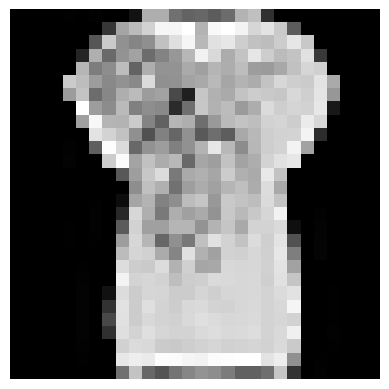

MLP label (ground-truth): Bag (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


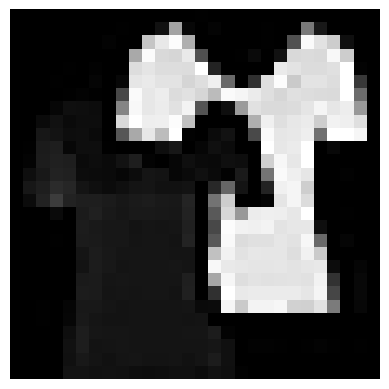

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


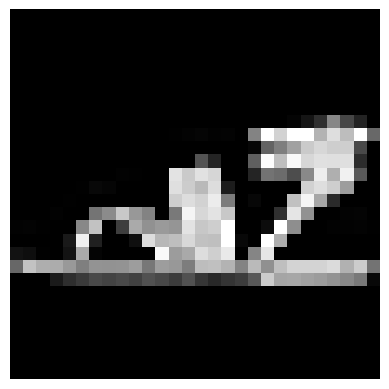

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


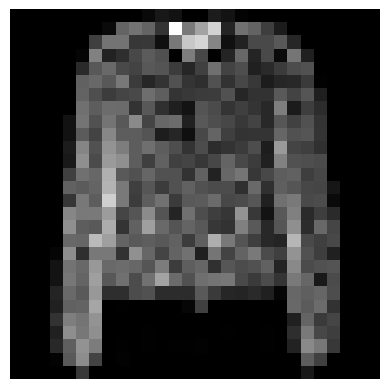

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


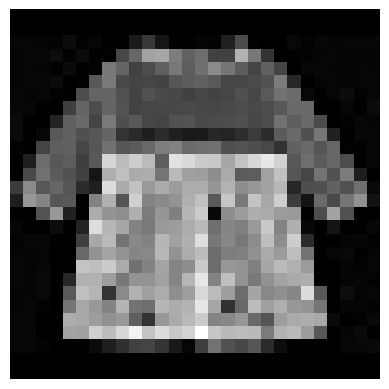

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


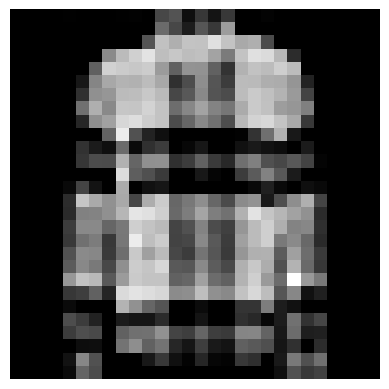

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


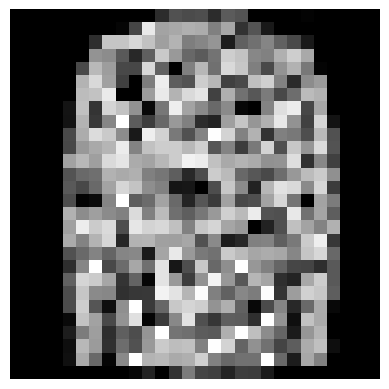

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


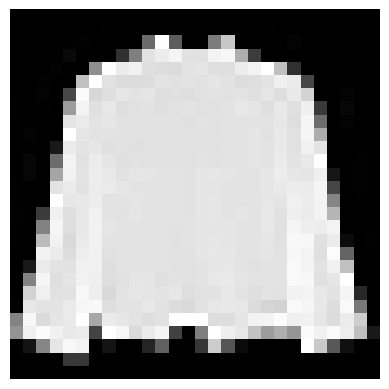

MLP label (ground-truth): T-shirt/top (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


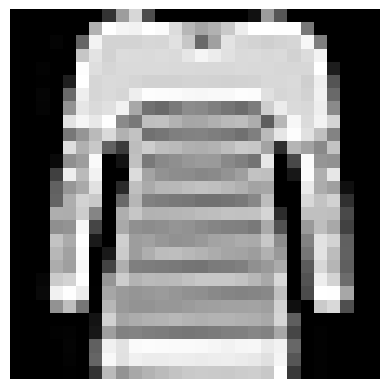

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


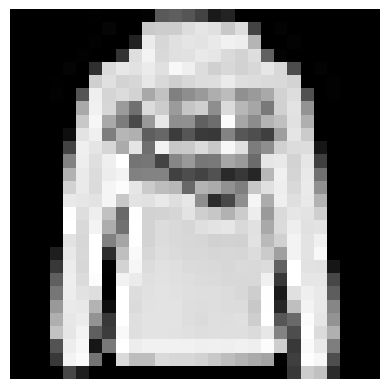

MLP label (ground-truth): Dress (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


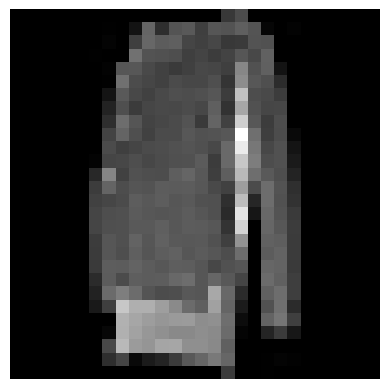

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


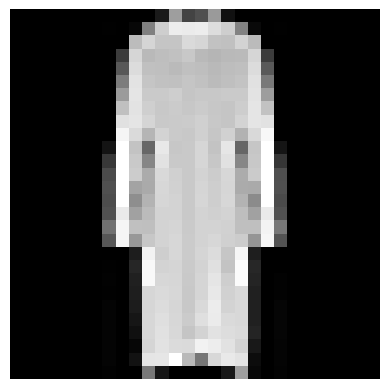

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


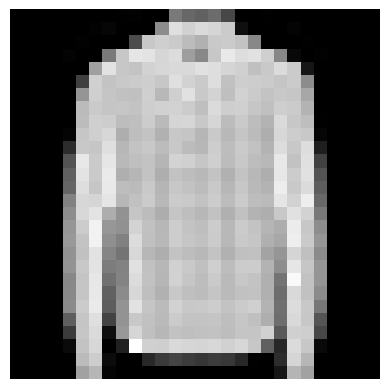

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


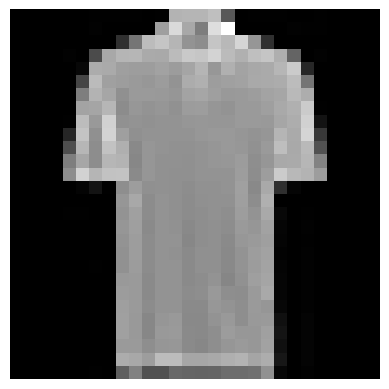

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


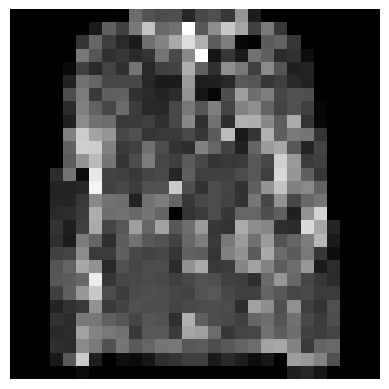

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


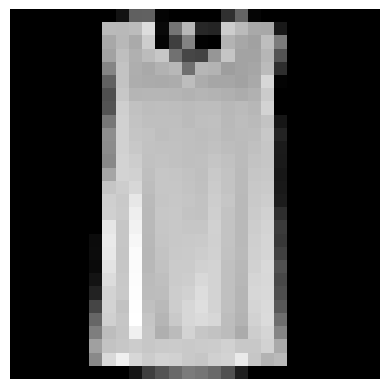

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


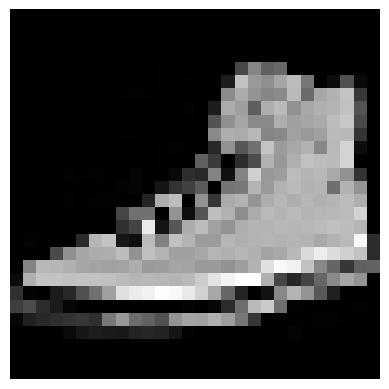

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


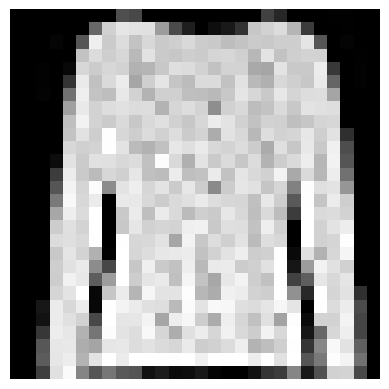

MLP label (ground-truth): Shirt (Bag)
VGG16 label (ground-truth): Bag (Bag)


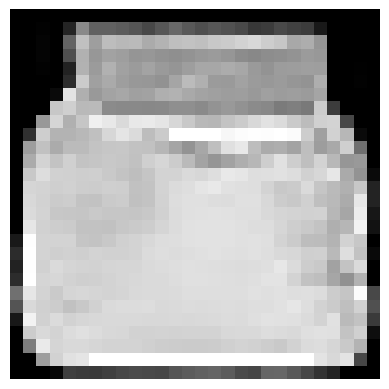

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


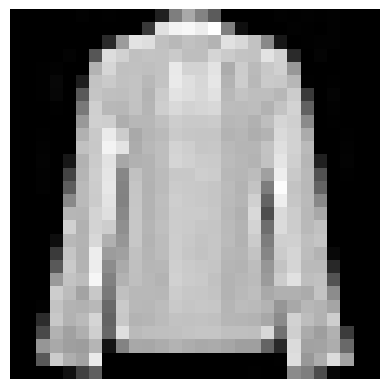

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


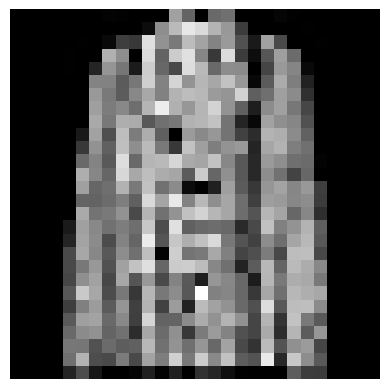

MLP label (ground-truth): Pullover (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


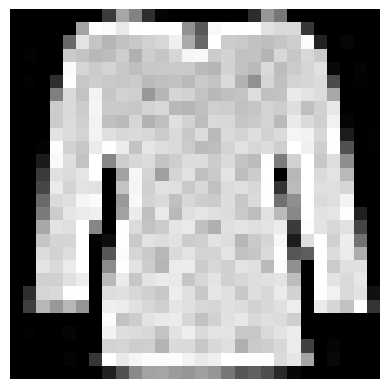

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


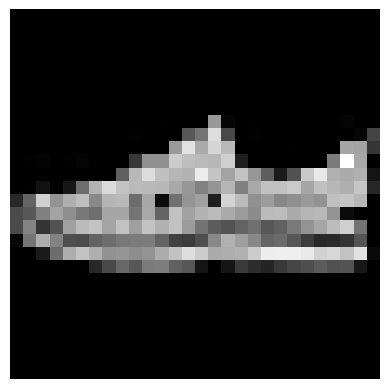

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


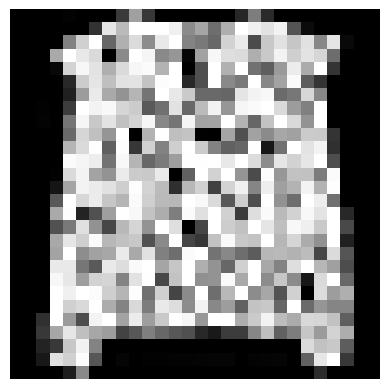

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


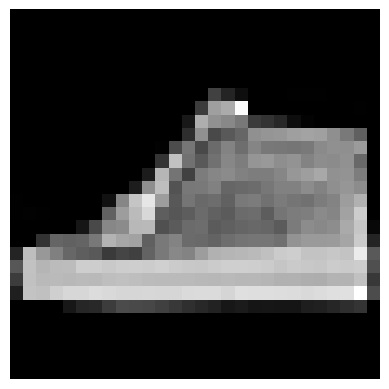

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


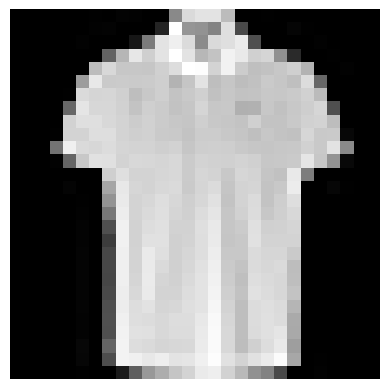

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


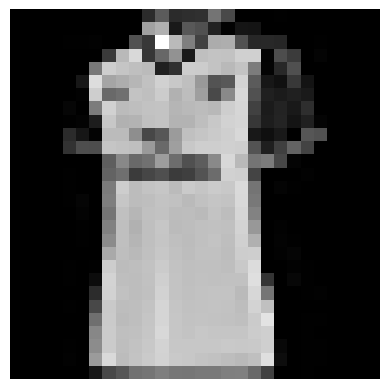

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


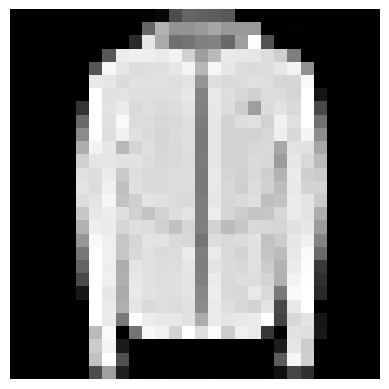

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


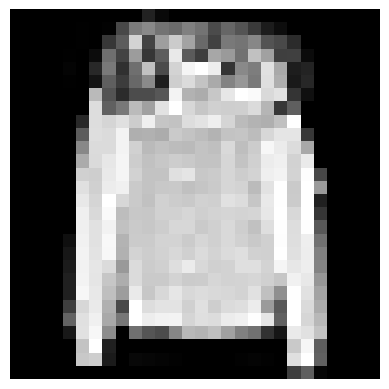

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


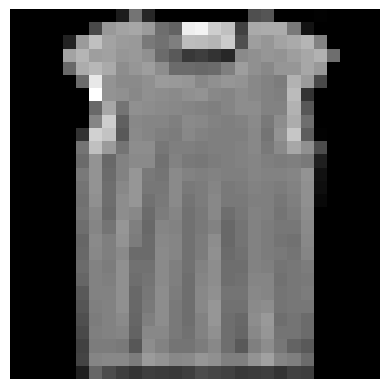

MLP label (ground-truth): Pullover (Bag)
VGG16 label (ground-truth): Bag (Bag)


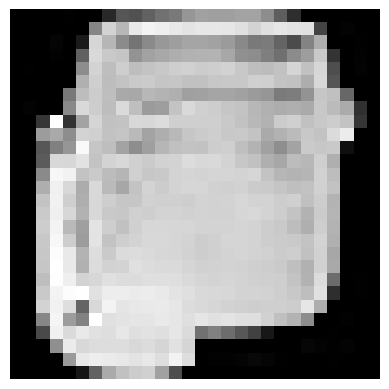

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


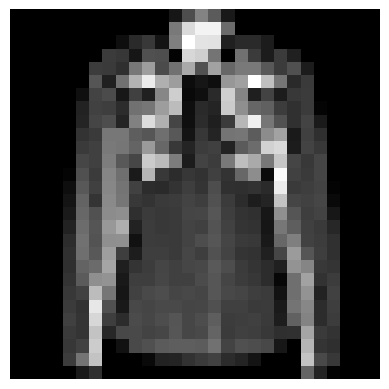

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


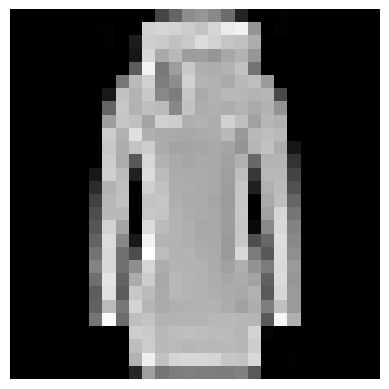

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


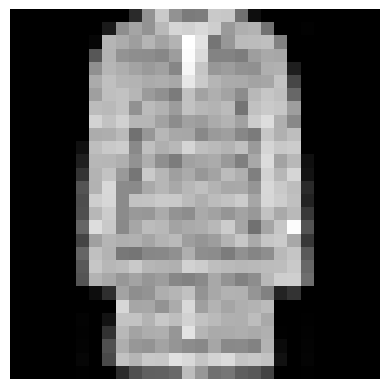

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


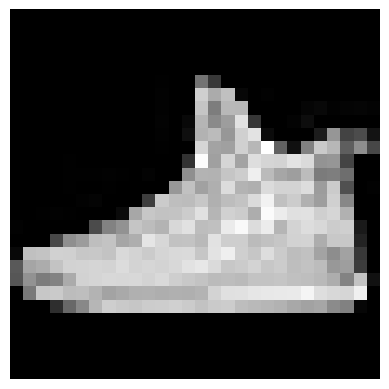

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


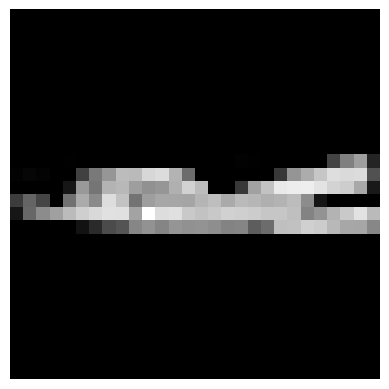

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


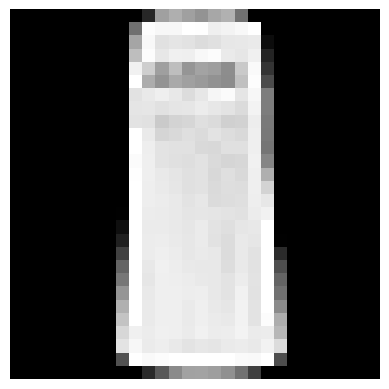

MLP label (ground-truth): Dress (Bag)
VGG16 label (ground-truth): Bag (Bag)


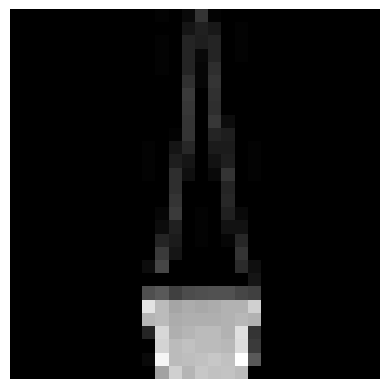

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


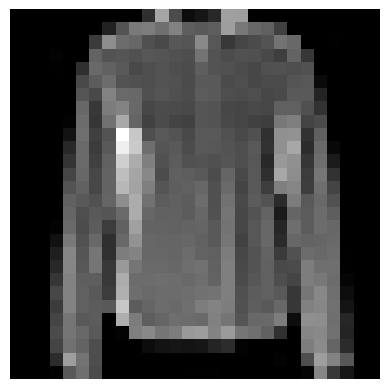

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


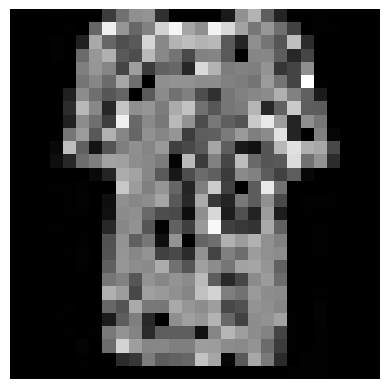

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


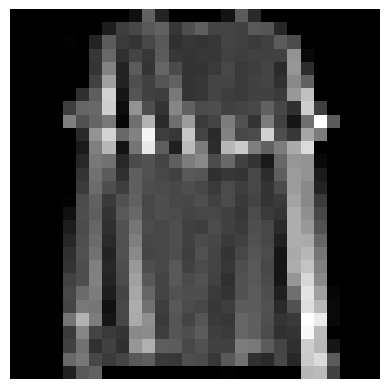

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


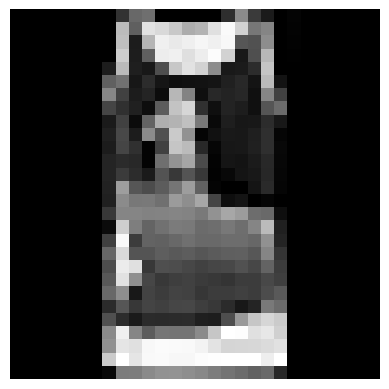

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


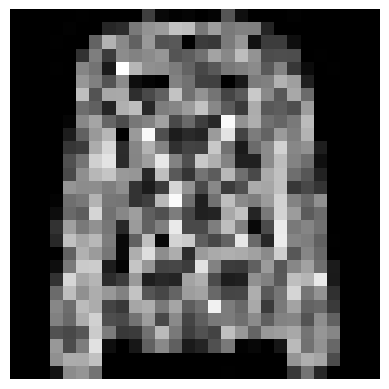

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


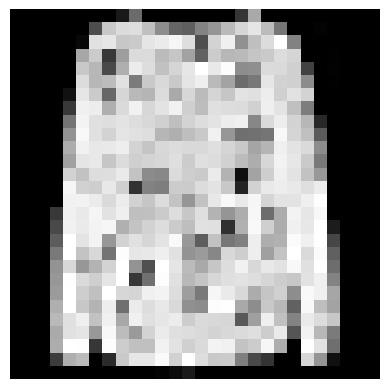

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


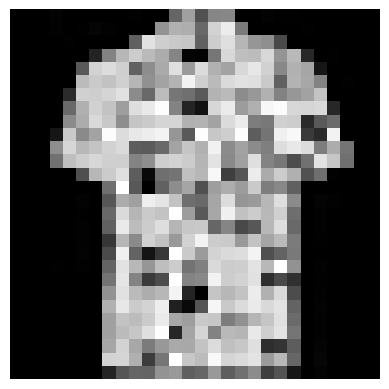

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


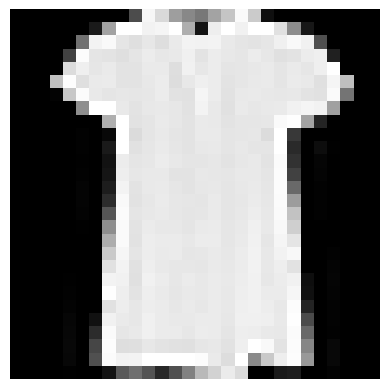

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


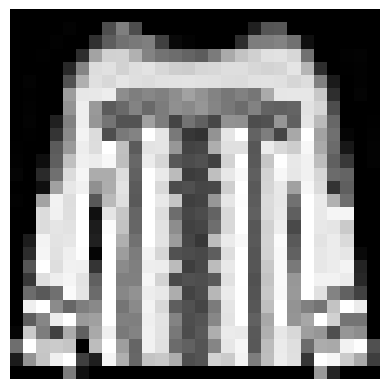

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


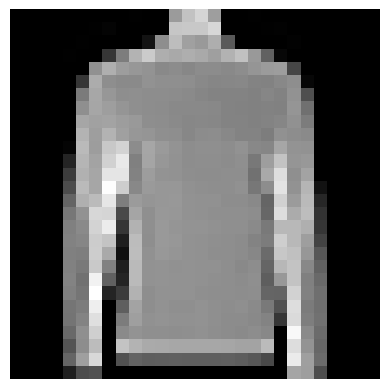

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


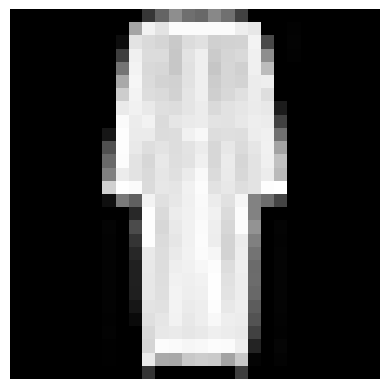

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


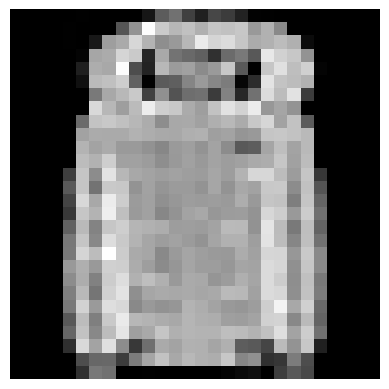

MLP label (ground-truth): Dress (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


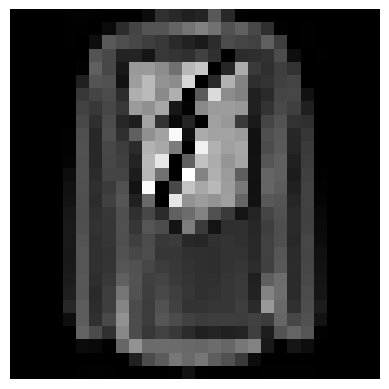

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


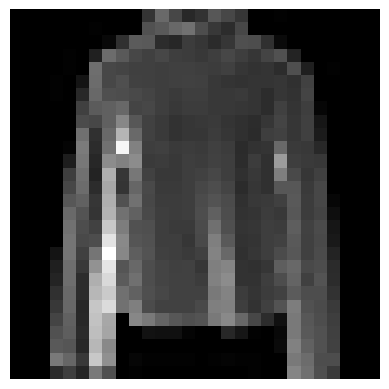

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


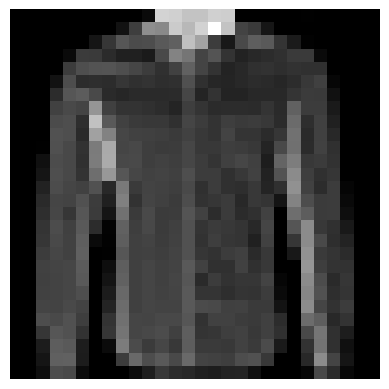

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


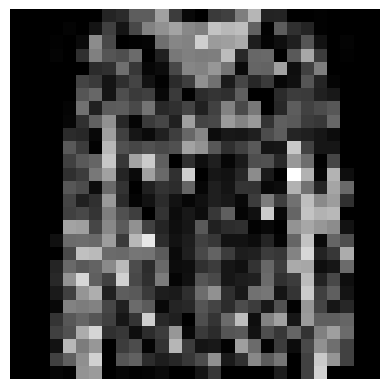

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


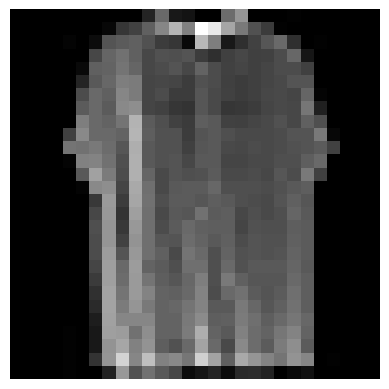

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


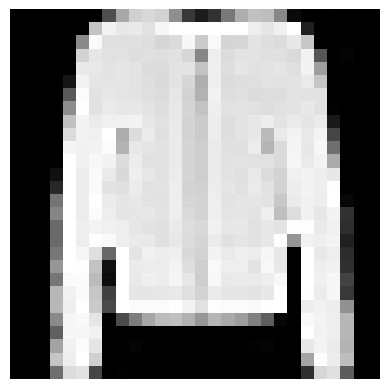

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


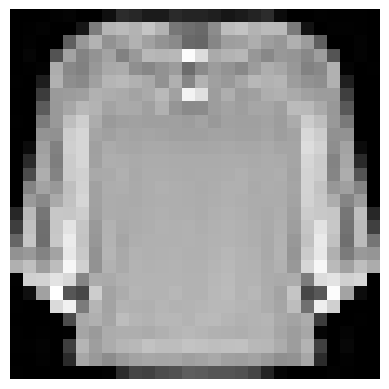

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


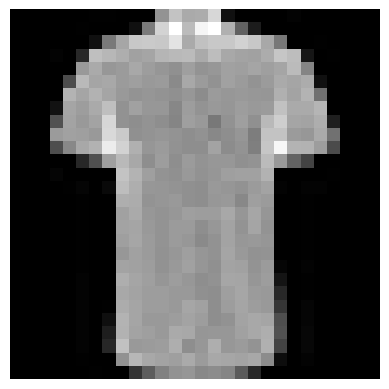

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


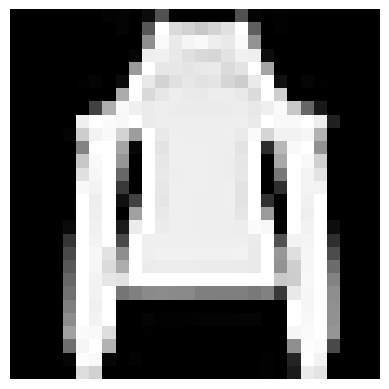

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


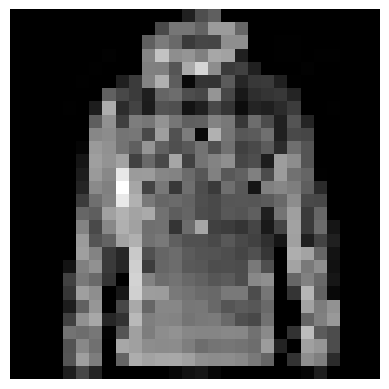

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


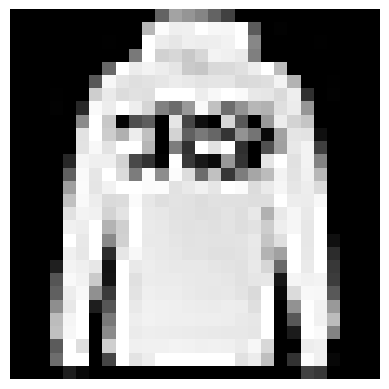

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


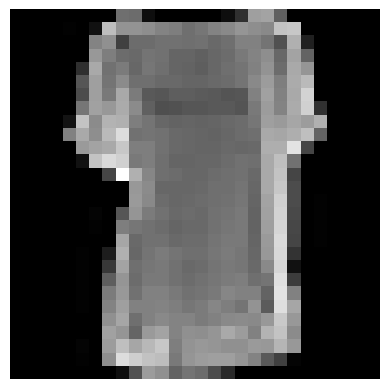

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


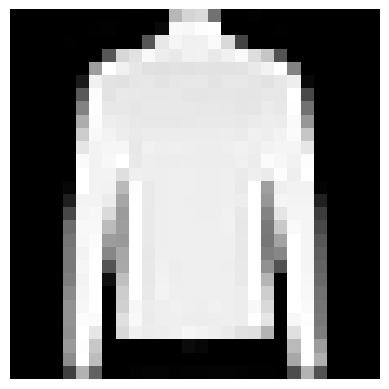

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


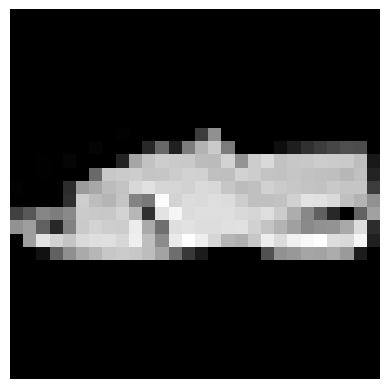

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


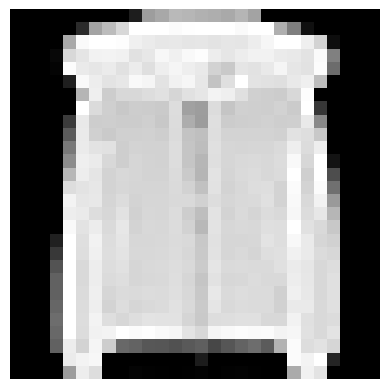

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


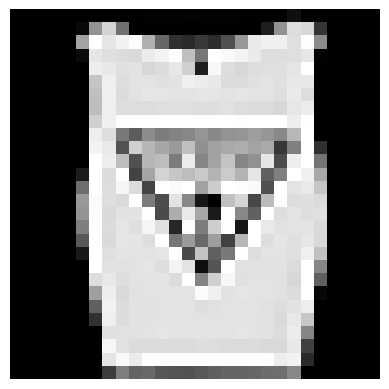

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


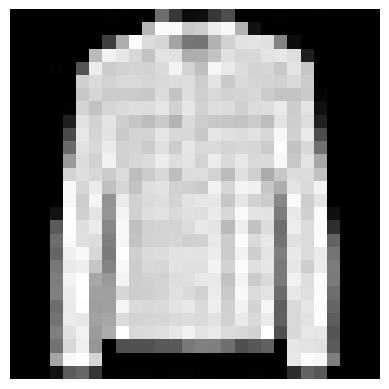

MLP label (ground-truth): Bag (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


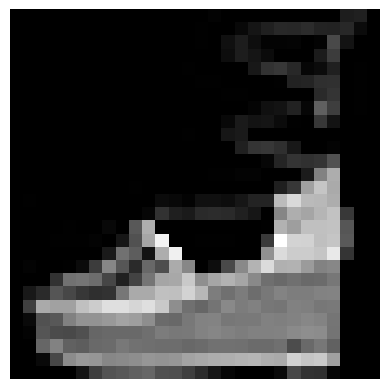

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


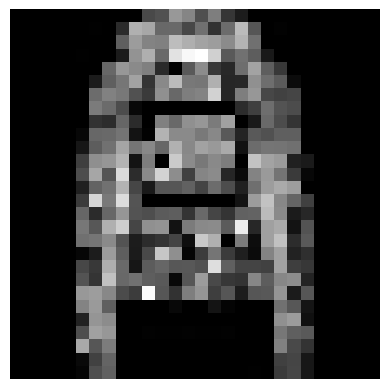

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


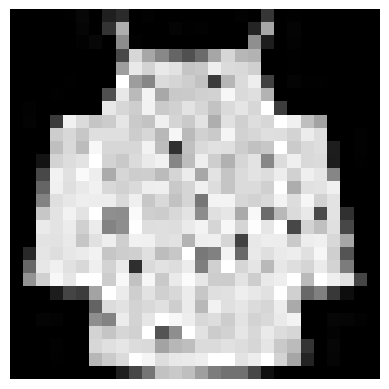

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


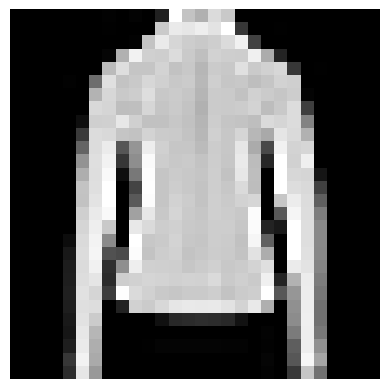

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


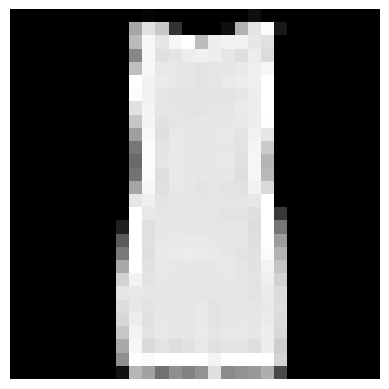

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


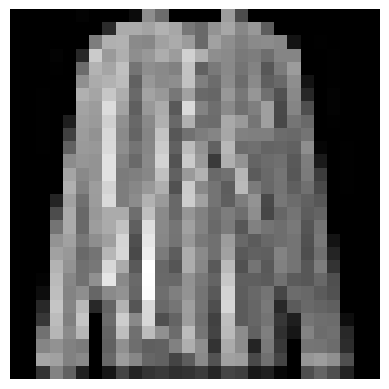

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


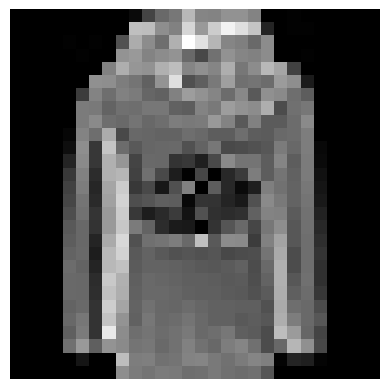

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


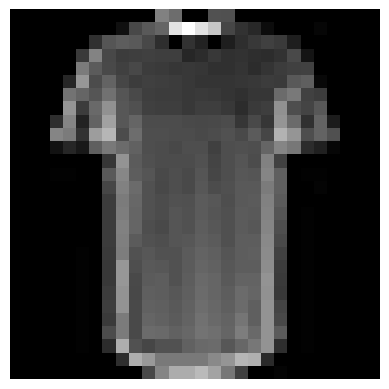

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


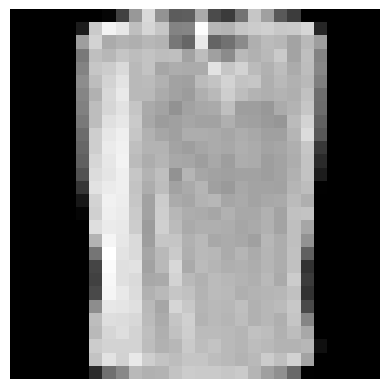

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


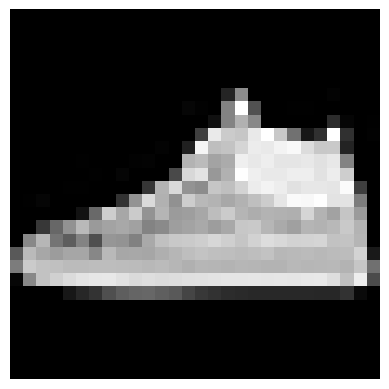

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


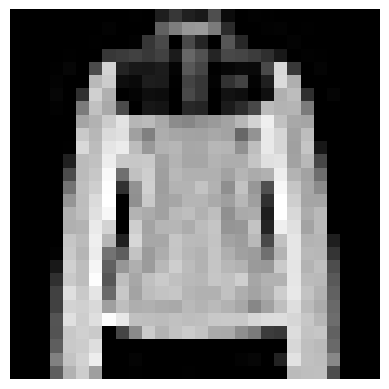

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


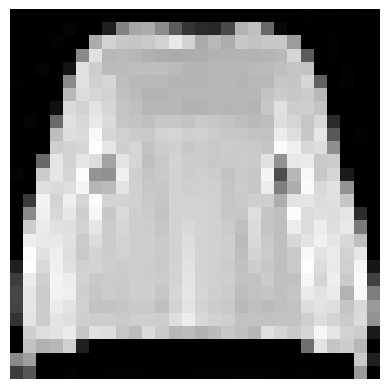

MLP label (ground-truth): Dress (Bag)
VGG16 label (ground-truth): Bag (Bag)


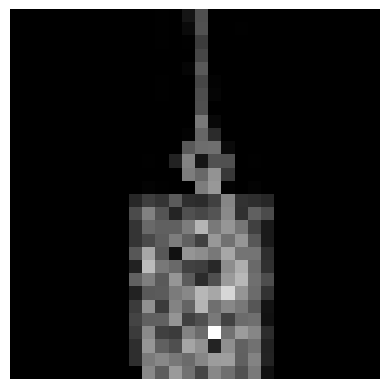

MLP label (ground-truth): Bag (Dress)
VGG16 label (ground-truth): Dress (Dress)


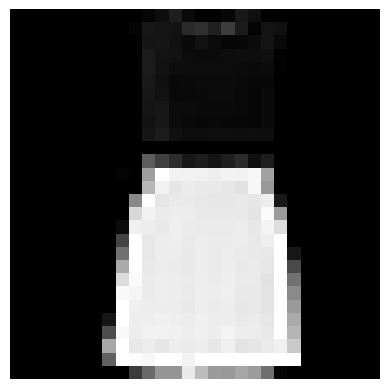

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


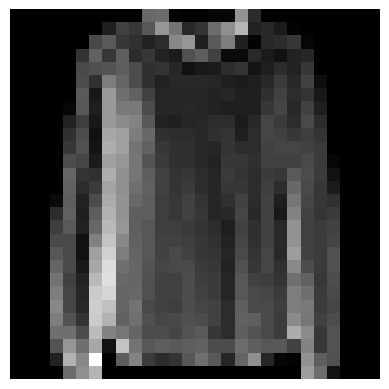

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


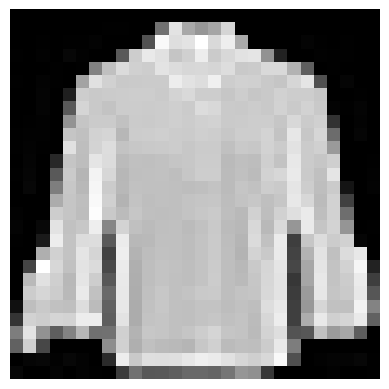

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


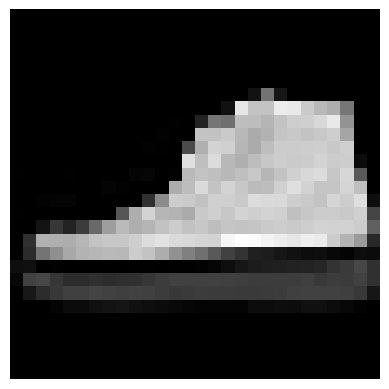

MLP label (ground-truth): Coat (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


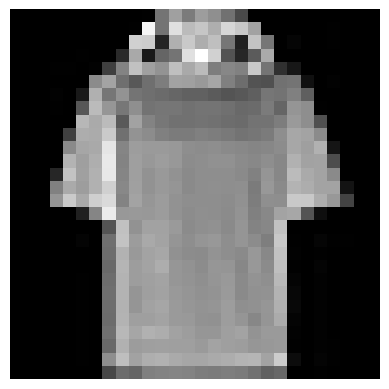

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


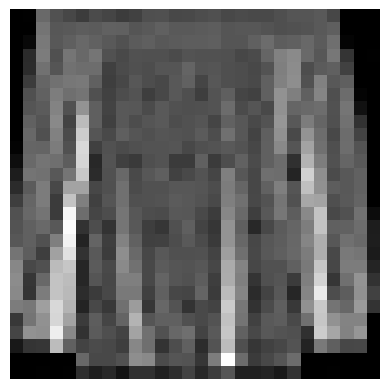

MLP label (ground-truth): T-shirt/top (Bag)
VGG16 label (ground-truth): Bag (Bag)


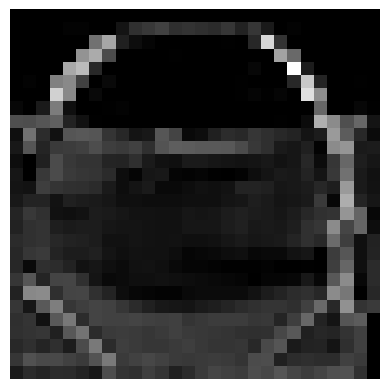

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


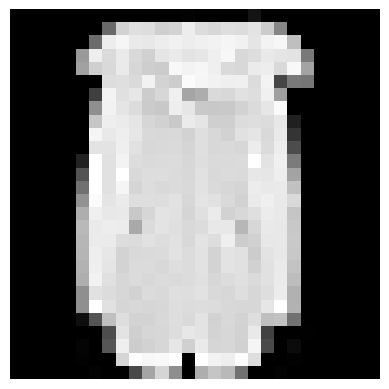

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


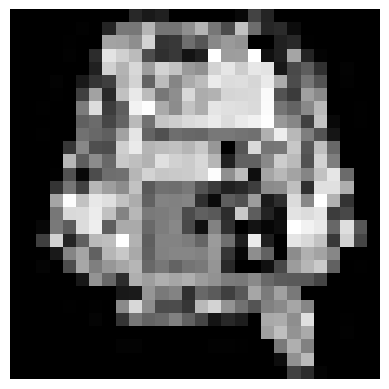

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


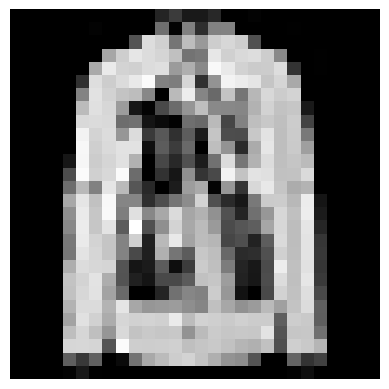

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


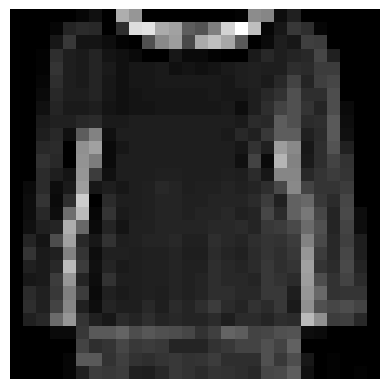

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


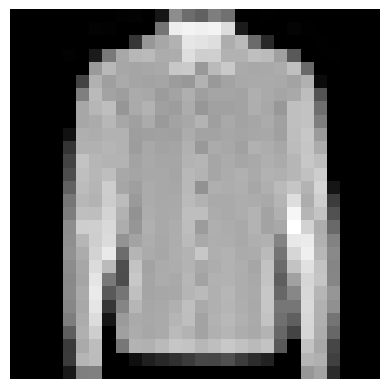

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


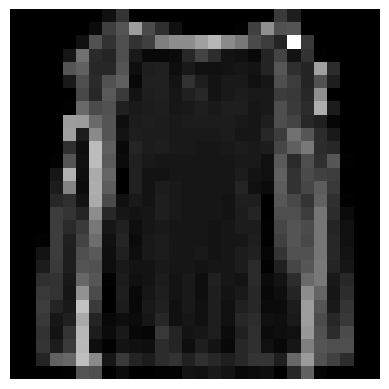

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


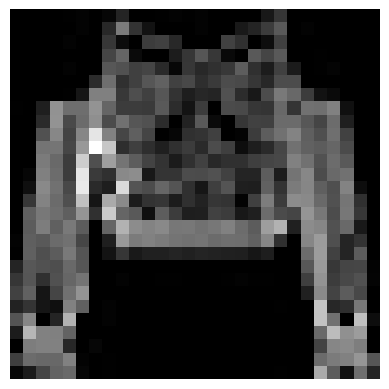

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


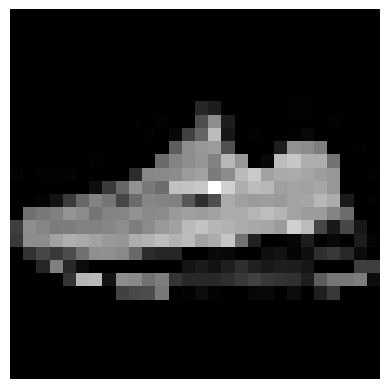

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


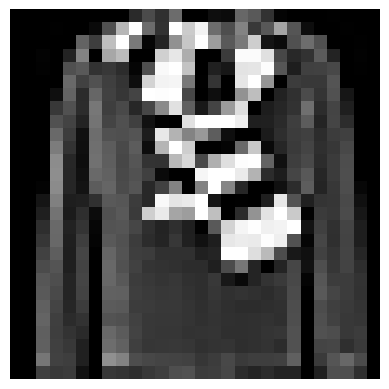

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


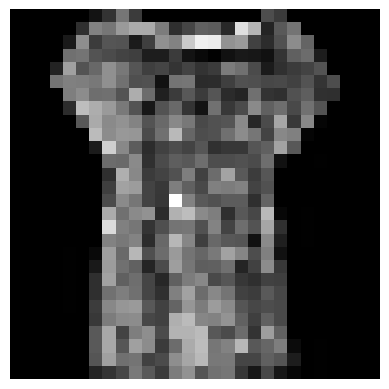

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


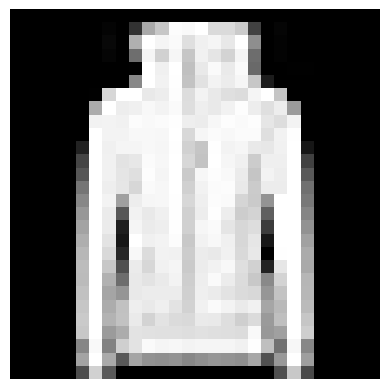

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


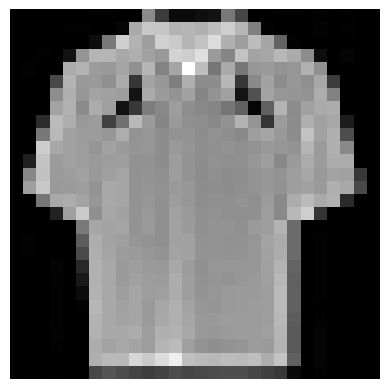

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


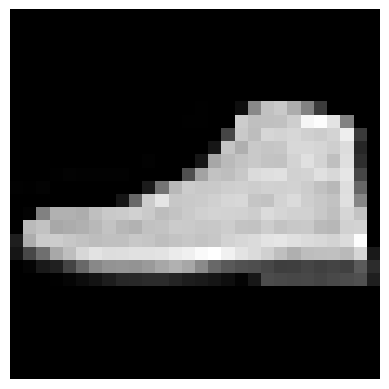

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


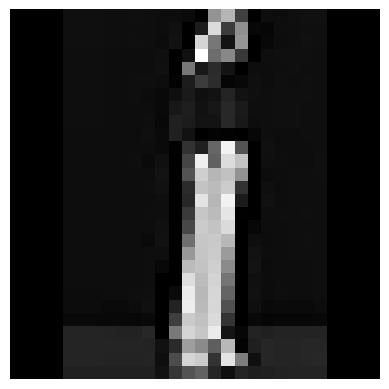

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


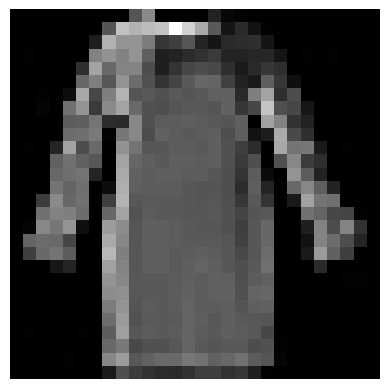

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


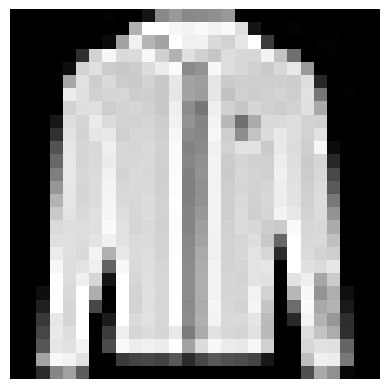

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


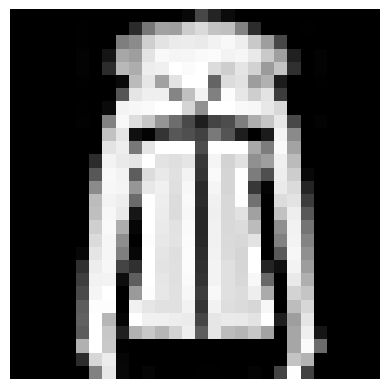

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


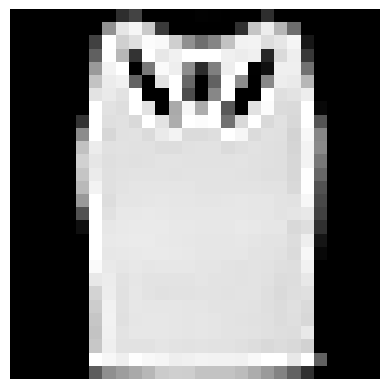

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


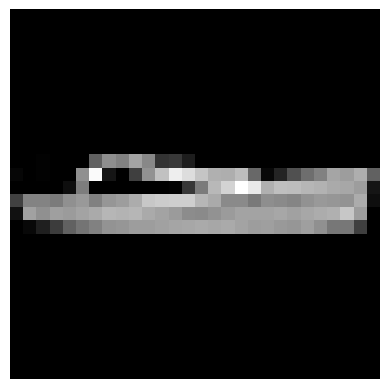

MLP label (ground-truth): Sandal (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


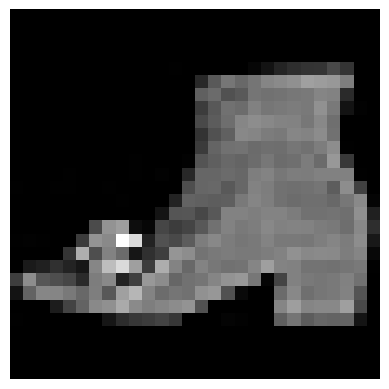

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


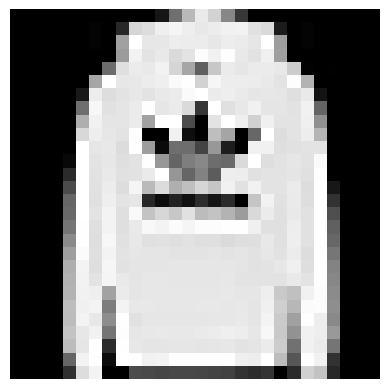

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


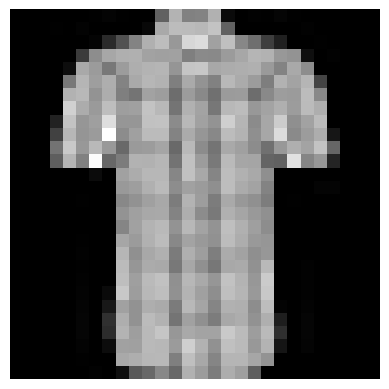

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


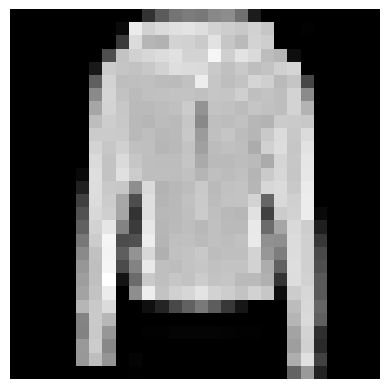

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


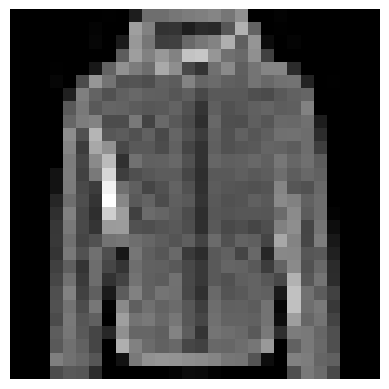

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


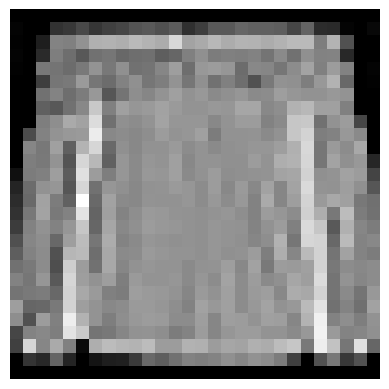

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


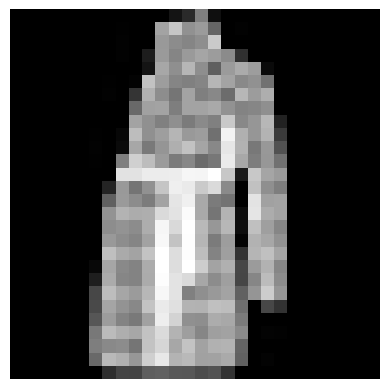

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


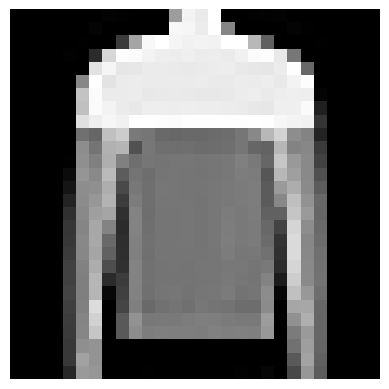

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


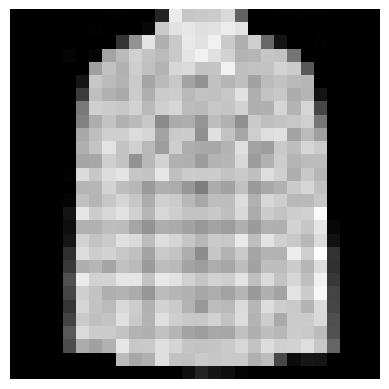

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


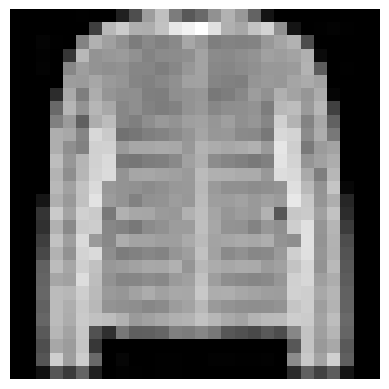

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


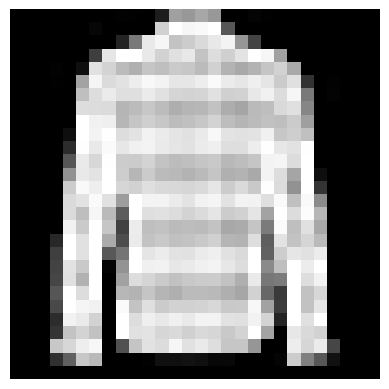

MLP label (ground-truth): T-shirt/top (Dress)
VGG16 label (ground-truth): Dress (Dress)


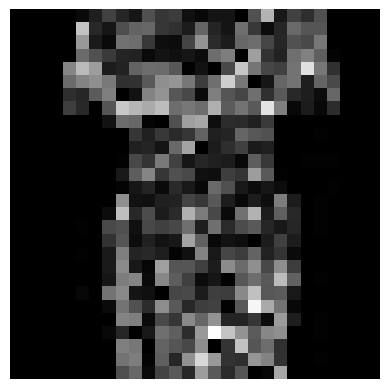

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


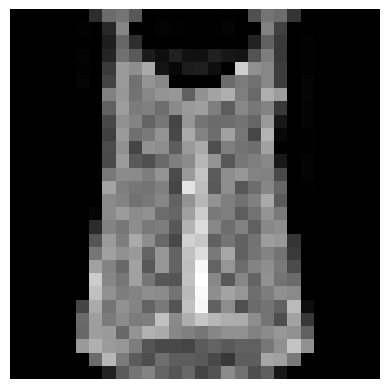

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


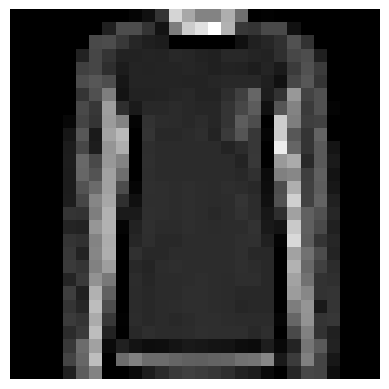

MLP label (ground-truth): Bag (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


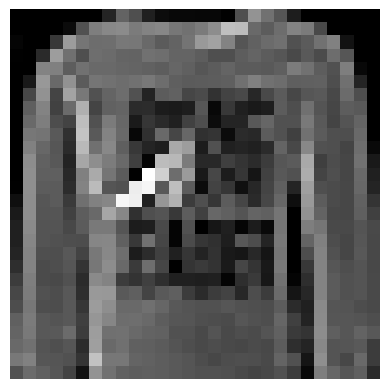

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


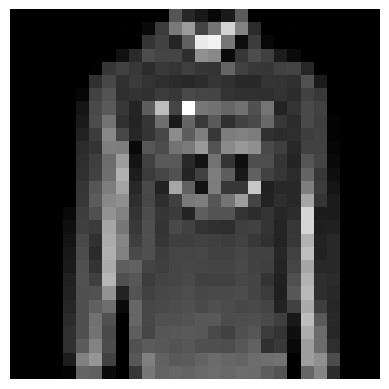

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


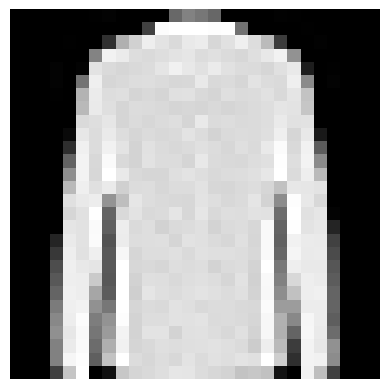

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


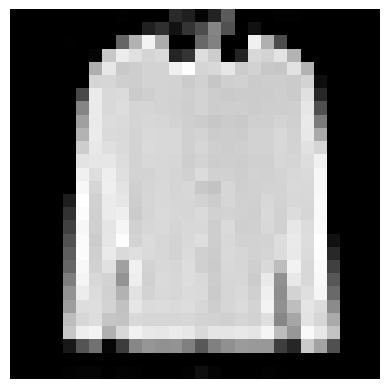

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


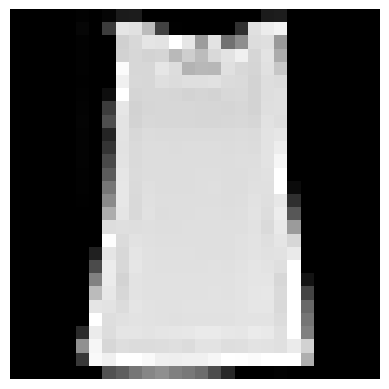

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


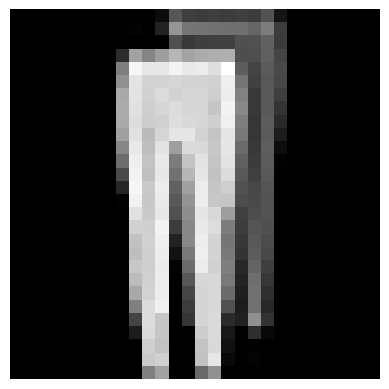

MLP label (ground-truth): Sneaker (Bag)
VGG16 label (ground-truth): Bag (Bag)


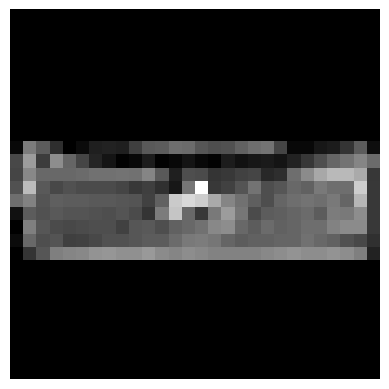

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


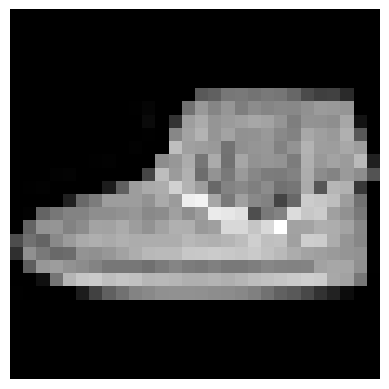

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


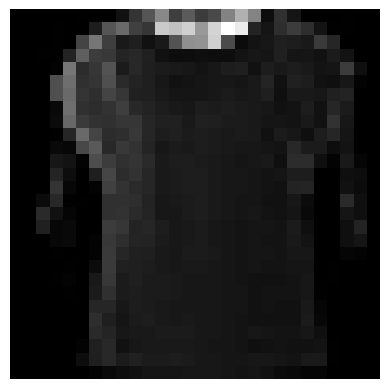

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


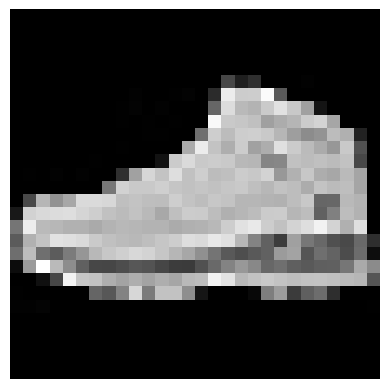

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


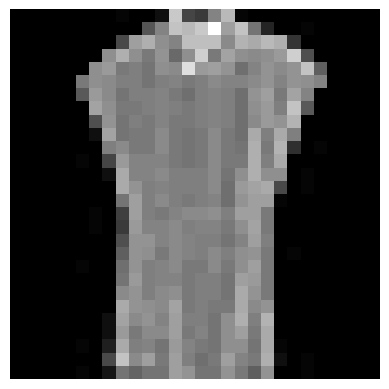

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


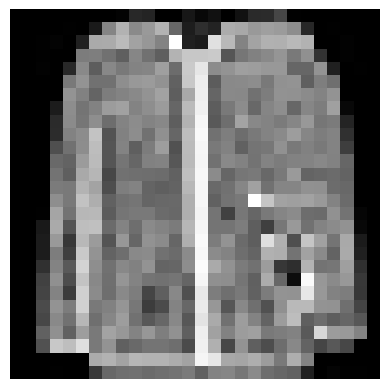

MLP label (ground-truth): T-shirt/top (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


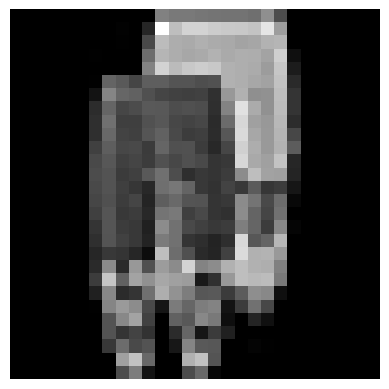

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


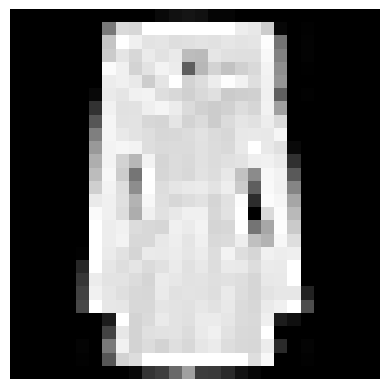

MLP label (ground-truth): Sneaker (Bag)
VGG16 label (ground-truth): Bag (Bag)


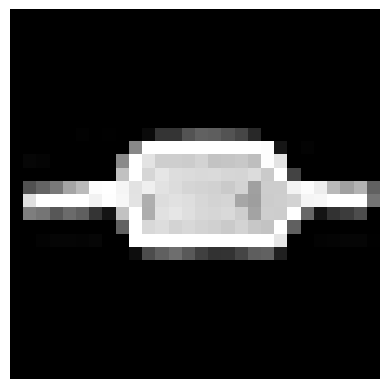

MLP label (ground-truth): Dress (Bag)
VGG16 label (ground-truth): Bag (Bag)


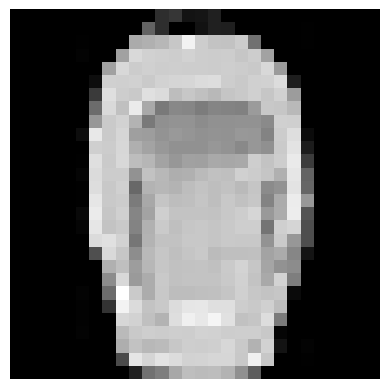

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


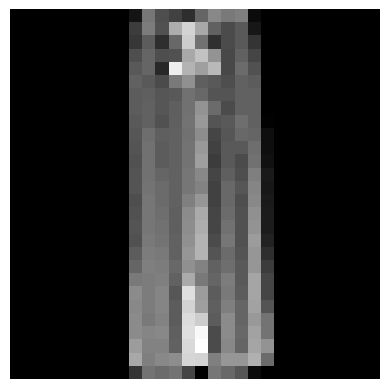

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


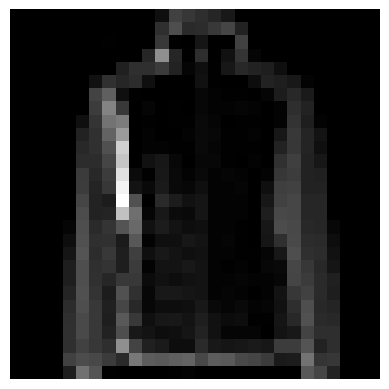

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


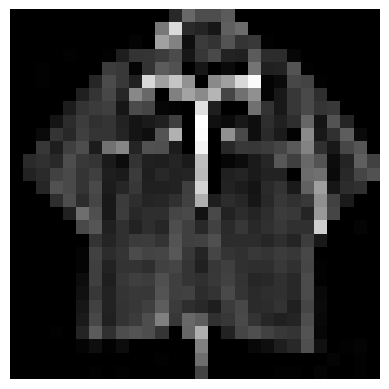

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


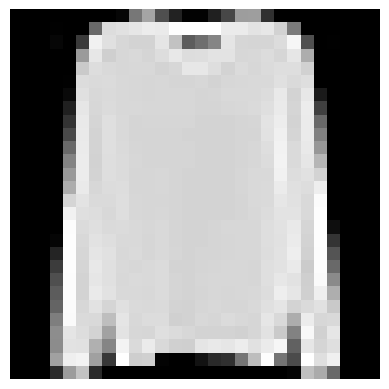

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


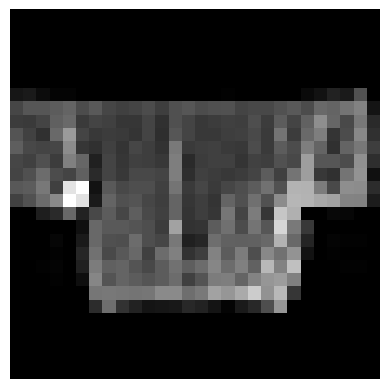

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


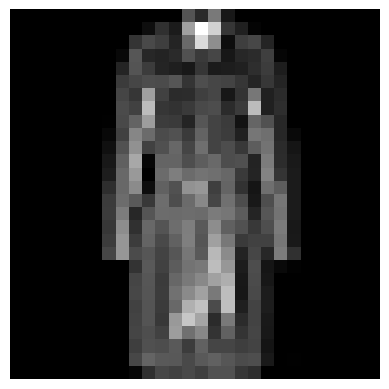

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


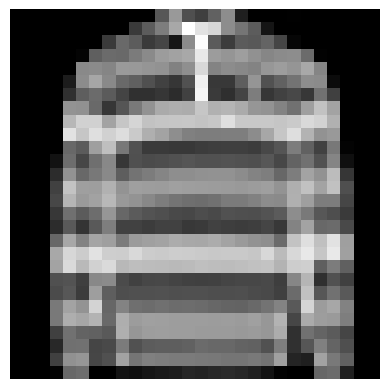

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


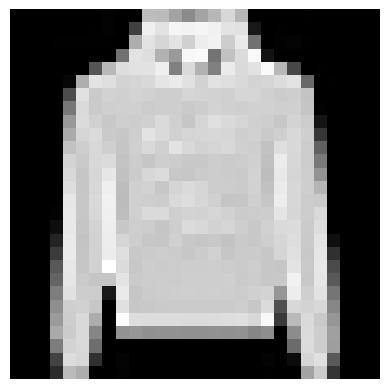

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


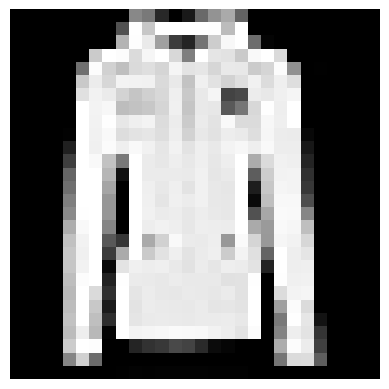

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


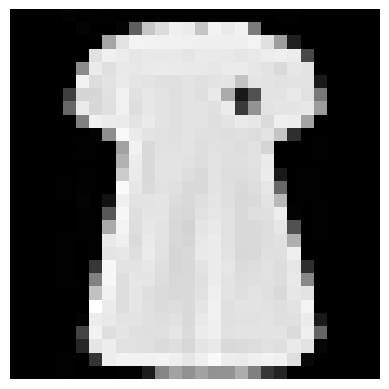

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


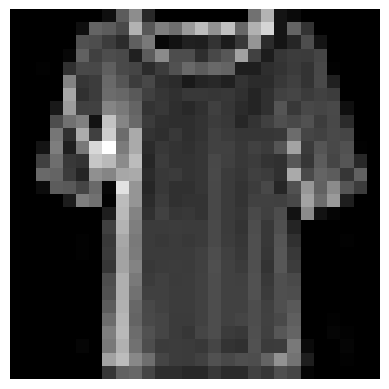

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


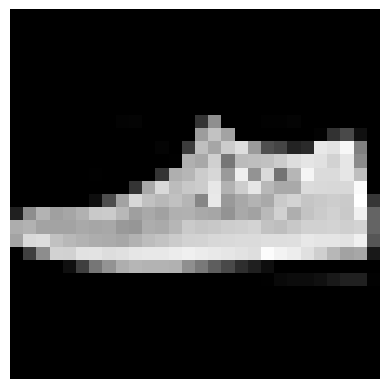

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


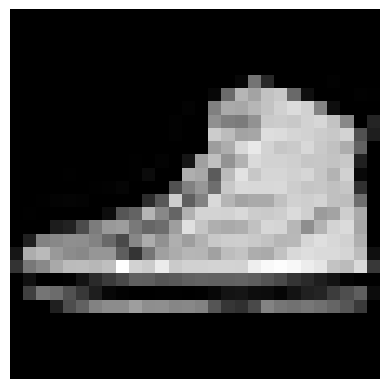

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


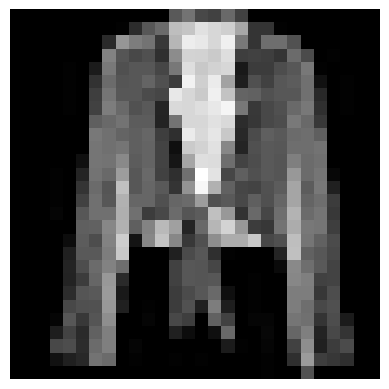

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


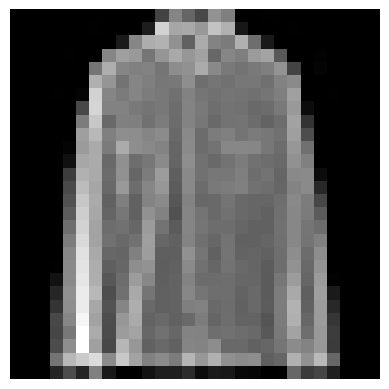

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


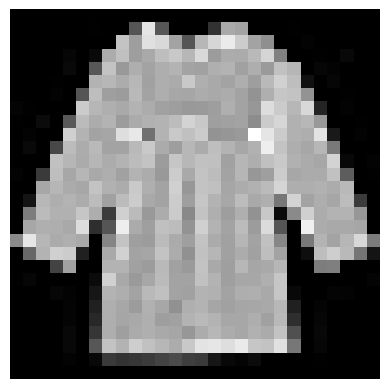

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


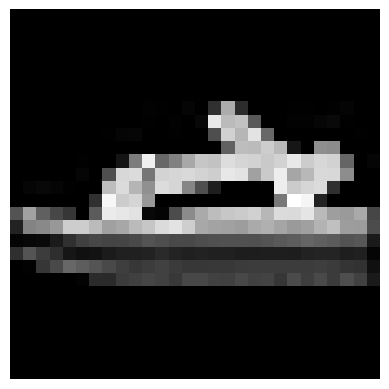

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


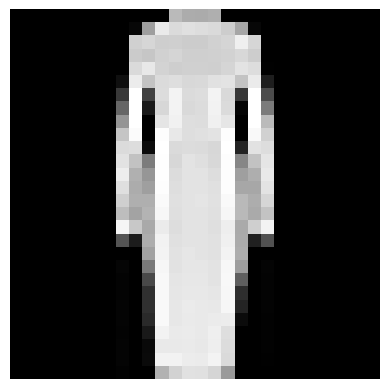

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


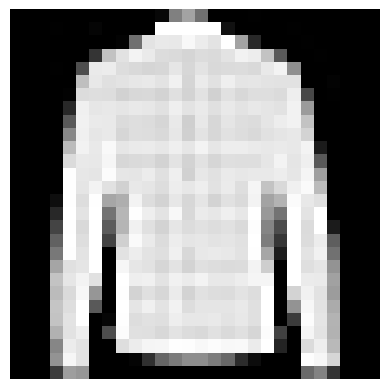

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


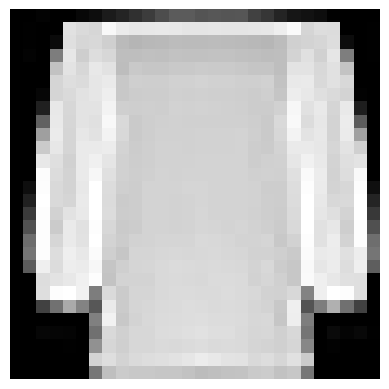

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


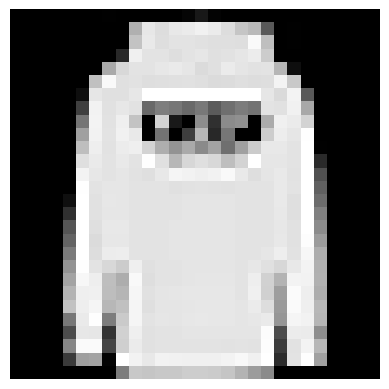

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


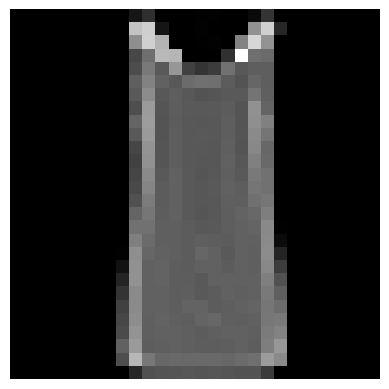

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


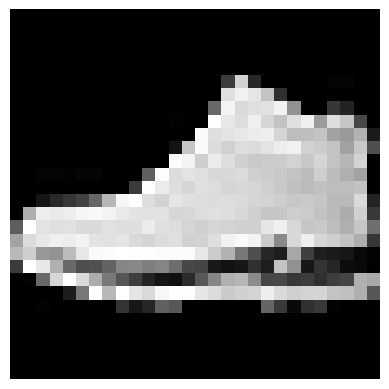

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


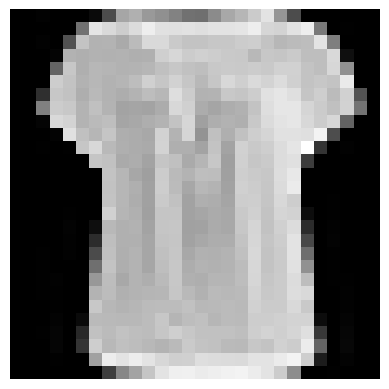

MLP label (ground-truth): Dress (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


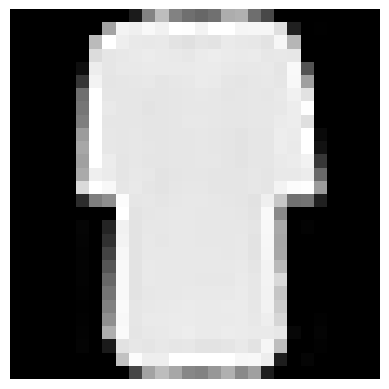

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


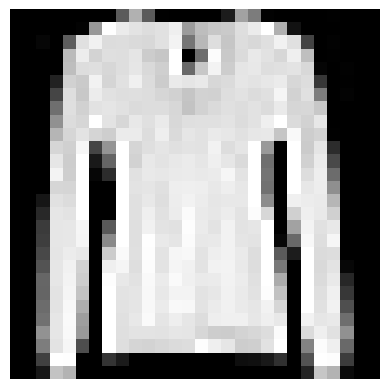

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


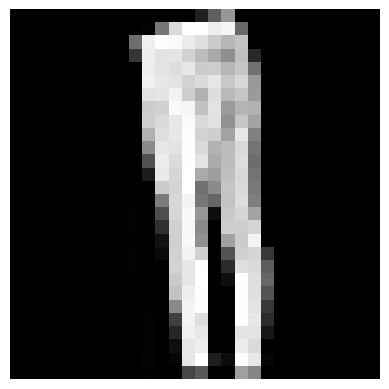

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


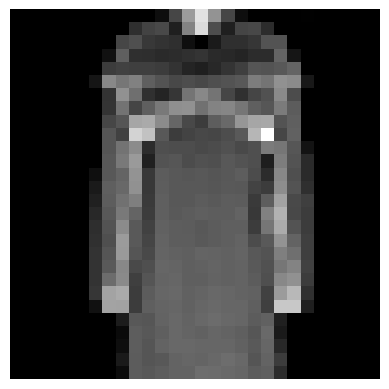

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


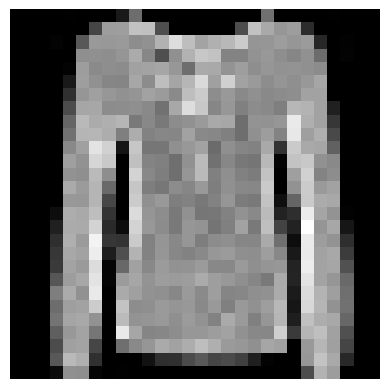

MLP label (ground-truth): Sandal (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


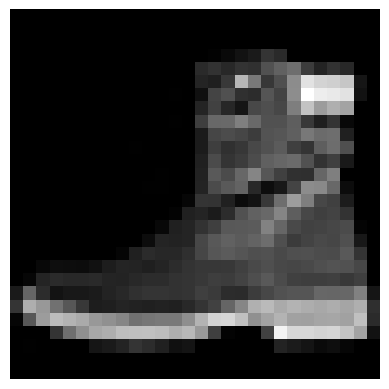

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


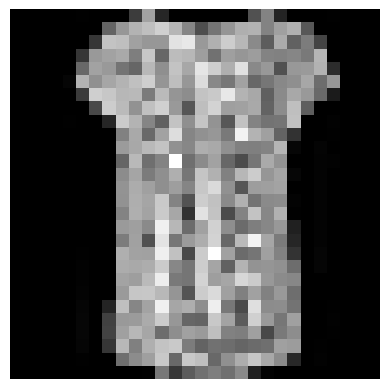

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


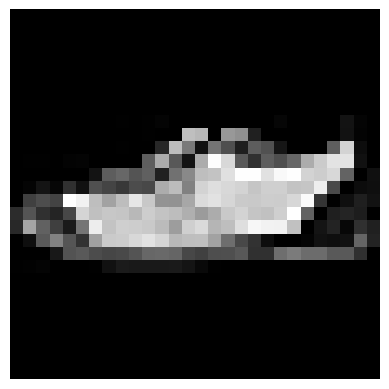

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


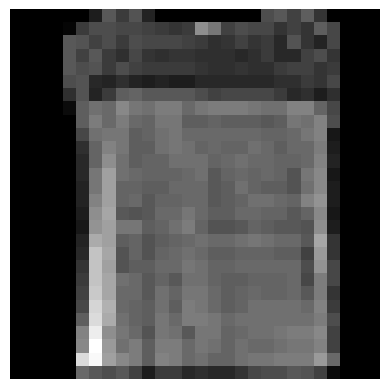

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


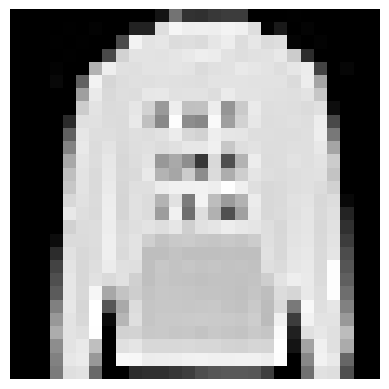

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


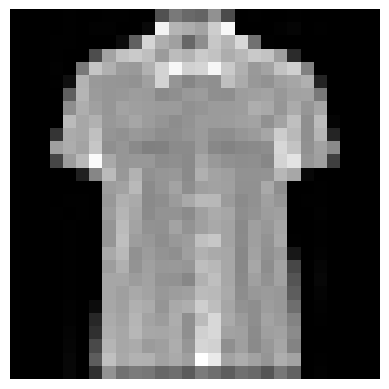

MLP label (ground-truth): Sneaker (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


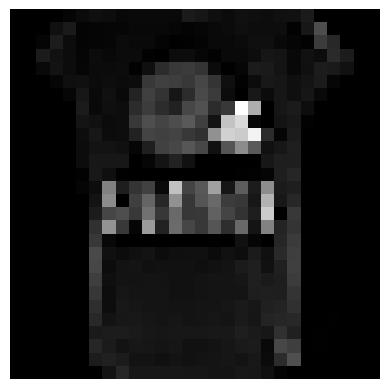

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


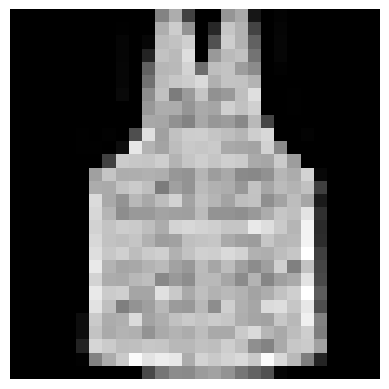

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


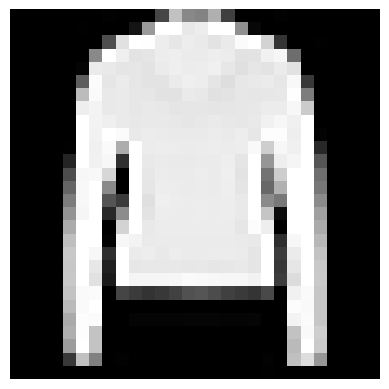

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


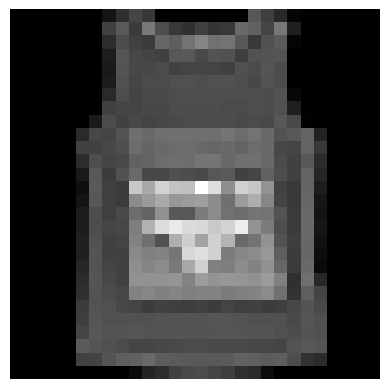

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


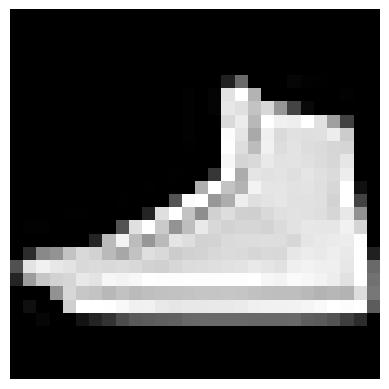

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


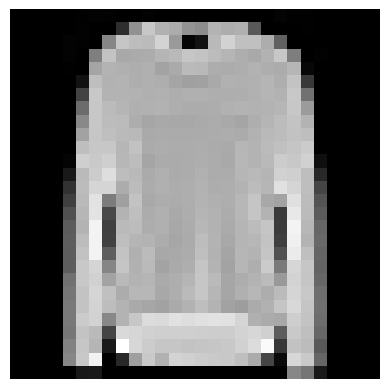

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


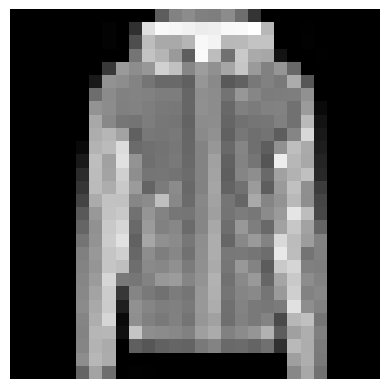

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


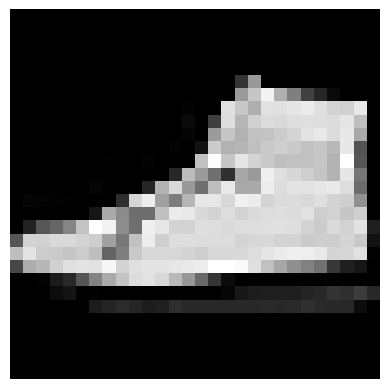

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


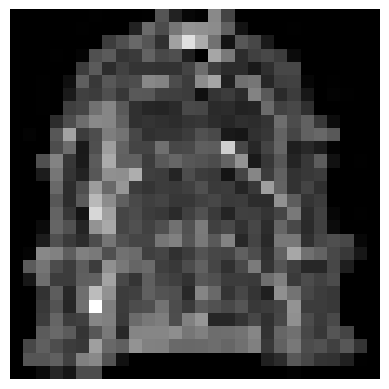

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


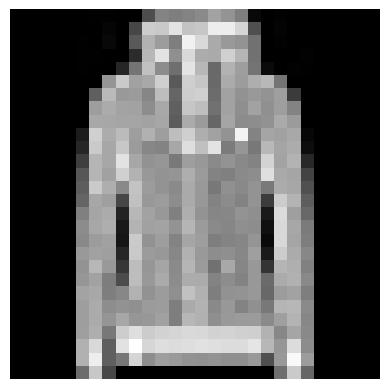

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


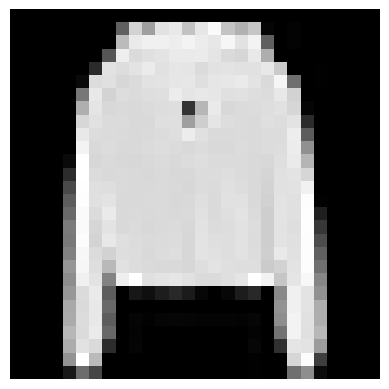

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


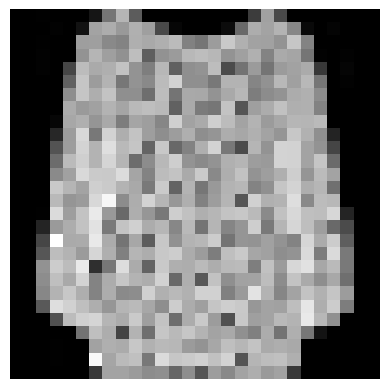

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


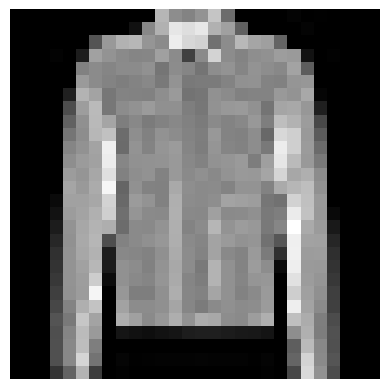

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


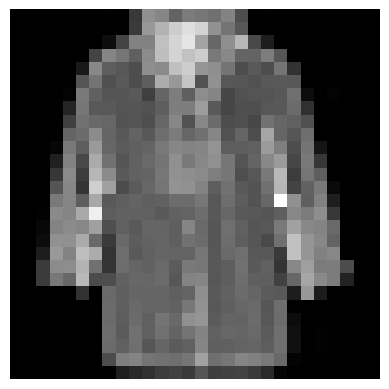

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


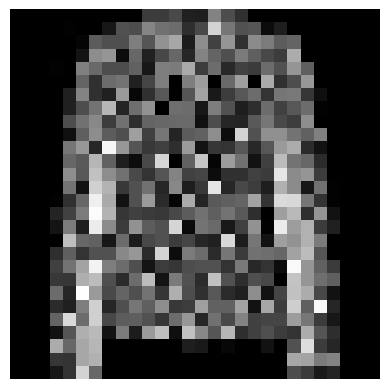

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


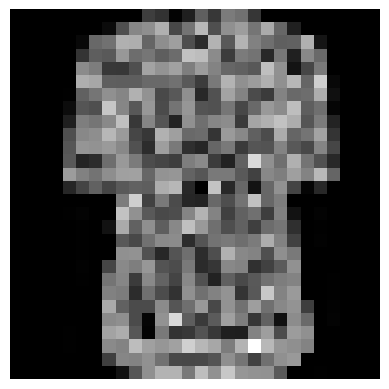

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


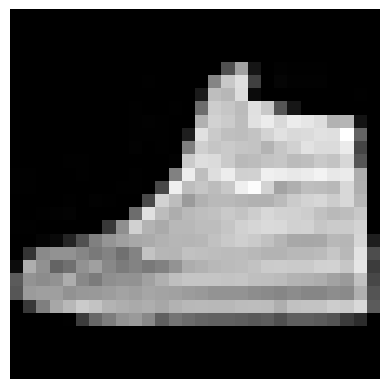

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


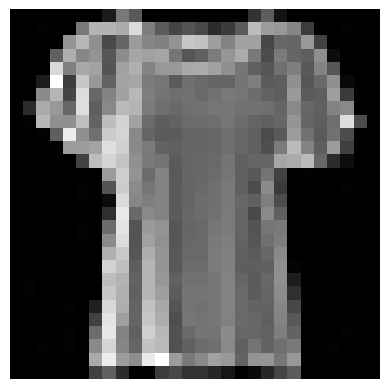

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


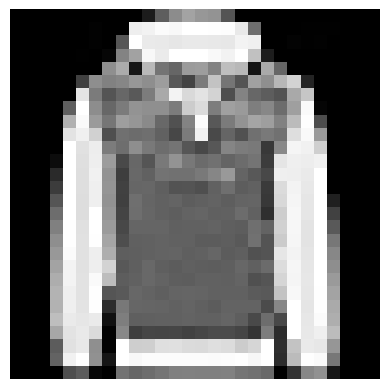

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


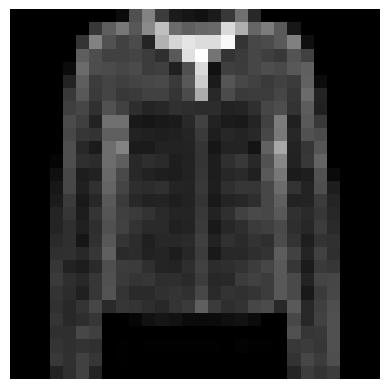

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


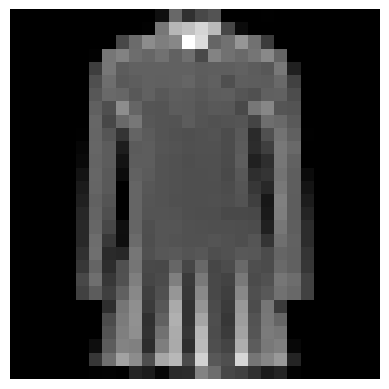

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


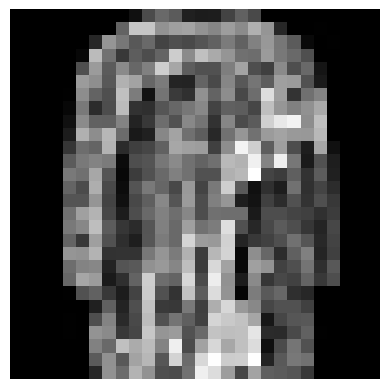

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


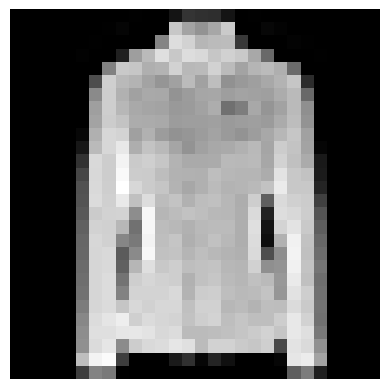

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


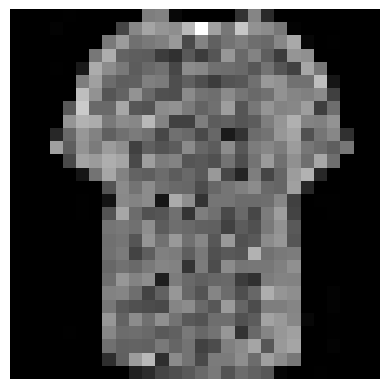

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


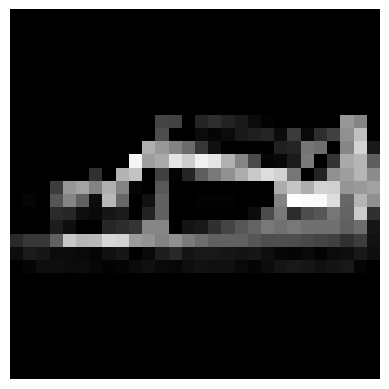

MLP label (ground-truth): Coat (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


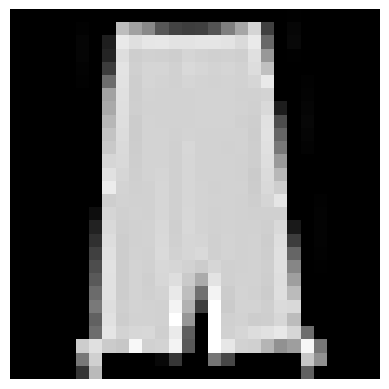

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


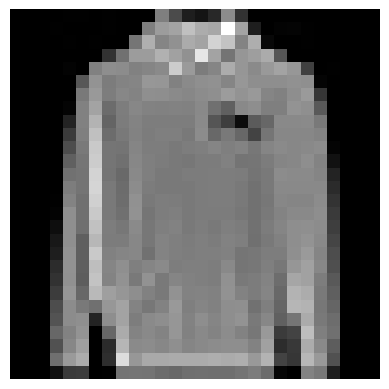

MLP label (ground-truth): Dress (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


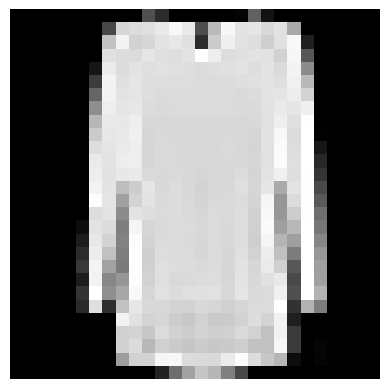

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


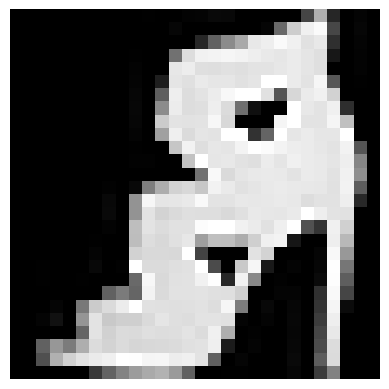

MLP label (ground-truth): Dress (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


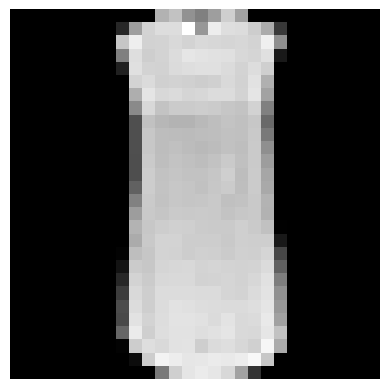

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


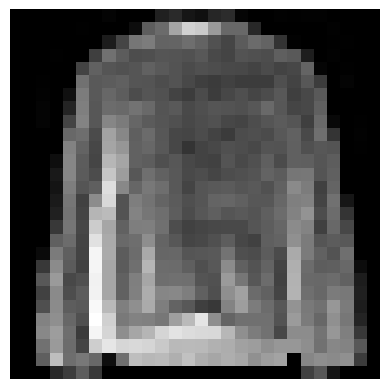

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


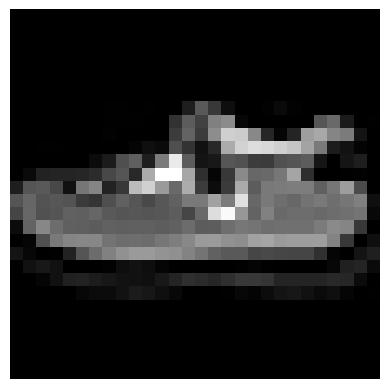

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


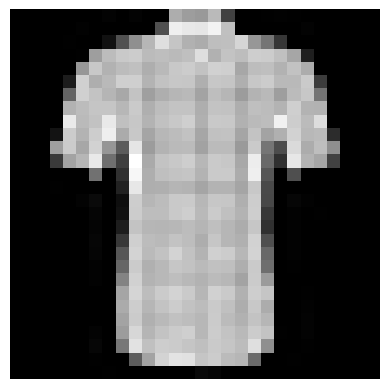

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


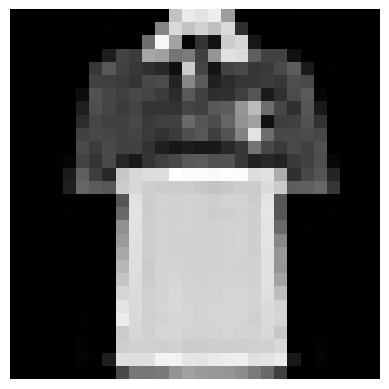

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


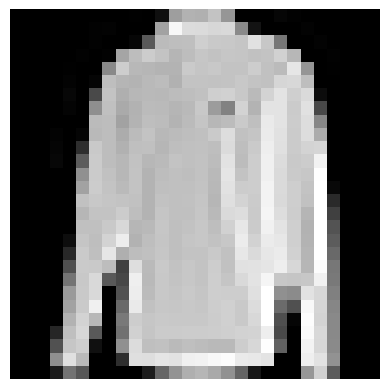

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


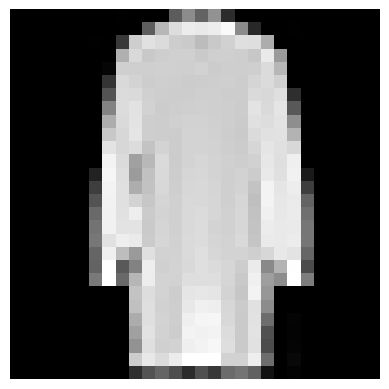

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


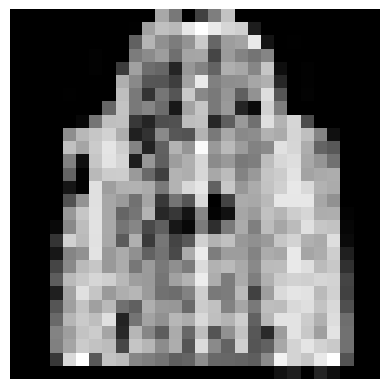

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


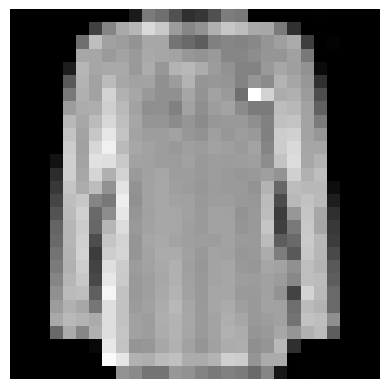

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


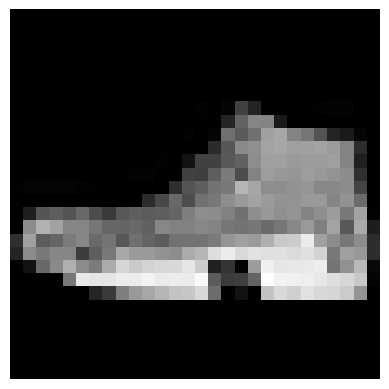

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


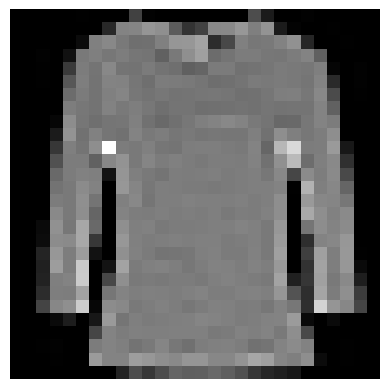

MLP label (ground-truth): Shirt (Bag)
VGG16 label (ground-truth): Bag (Bag)


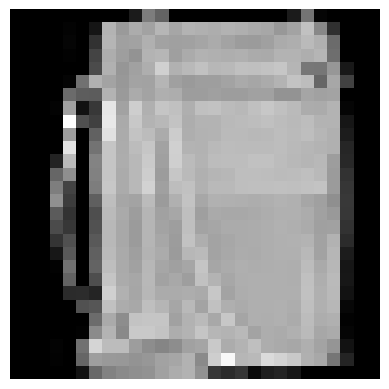

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


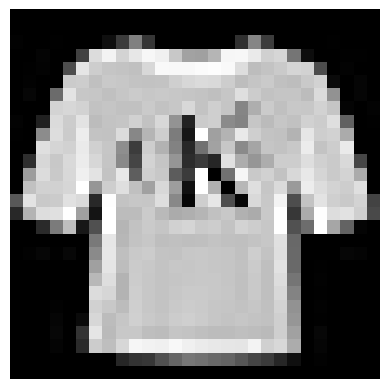

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


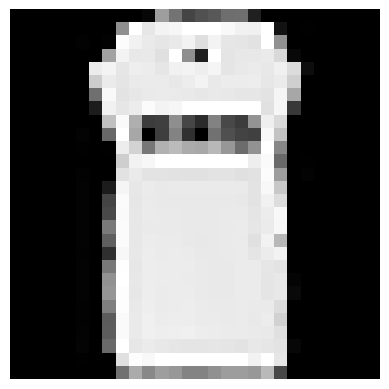

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


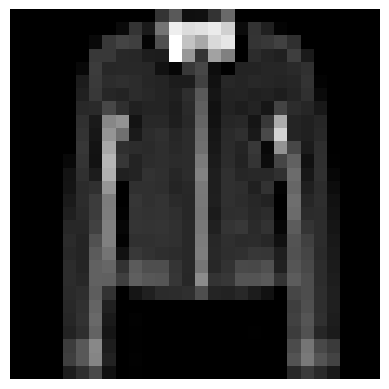

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


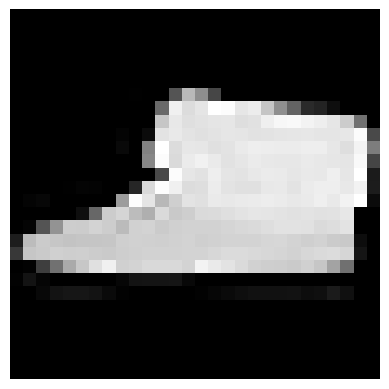

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


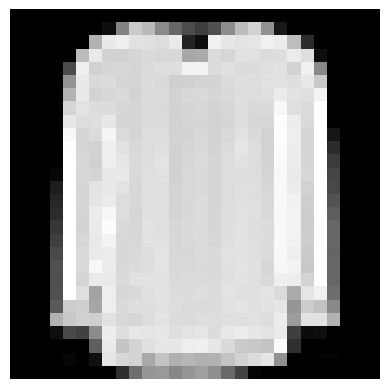

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


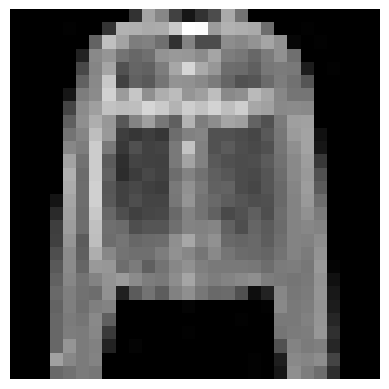

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


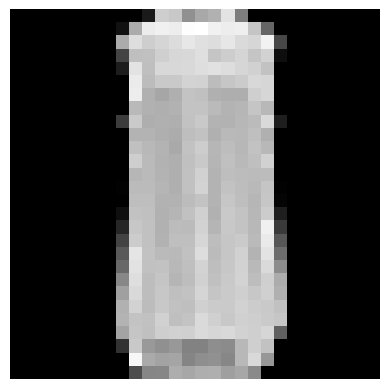

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


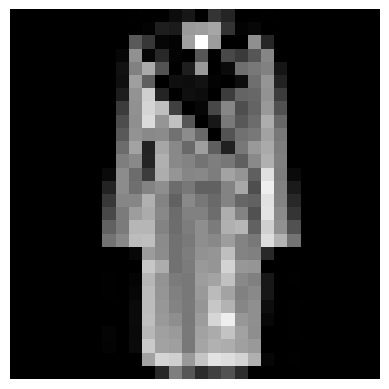

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


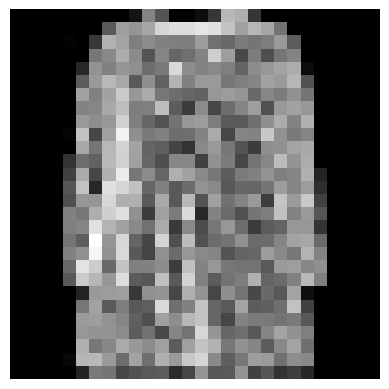

MLP label (ground-truth): T-shirt/top (Dress)
VGG16 label (ground-truth): Dress (Dress)


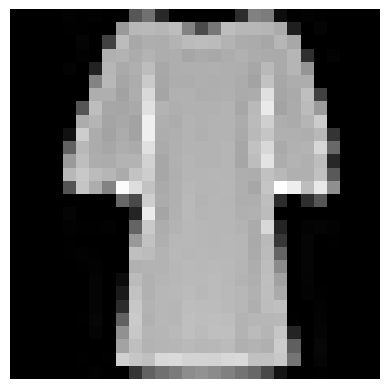

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


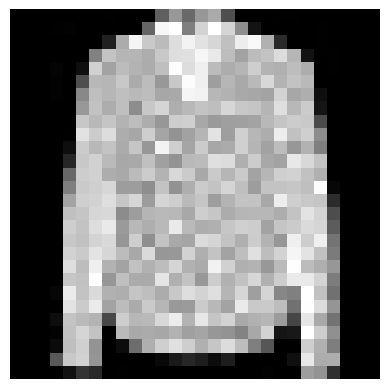

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


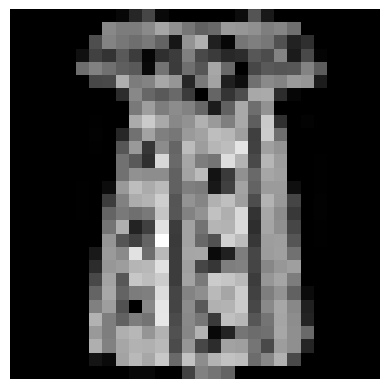

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


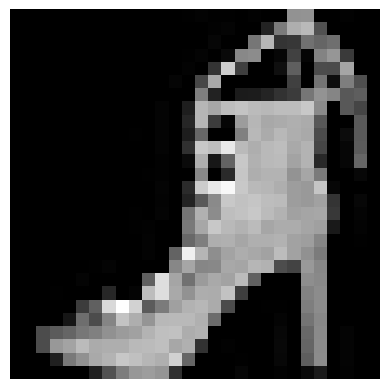

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


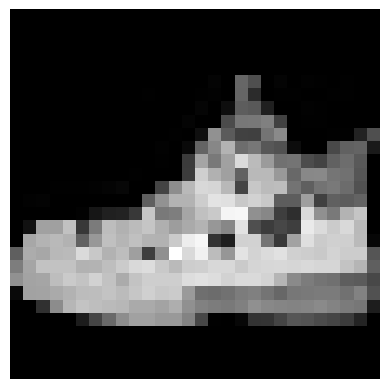

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


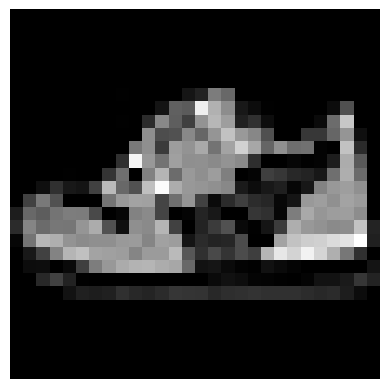

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


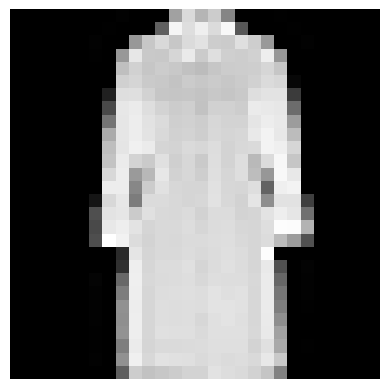

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


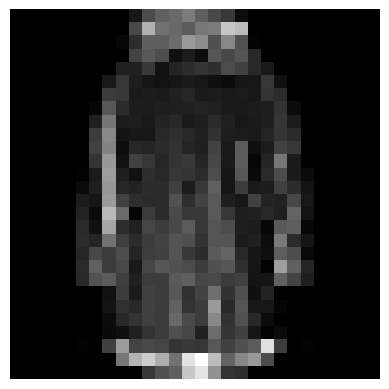

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


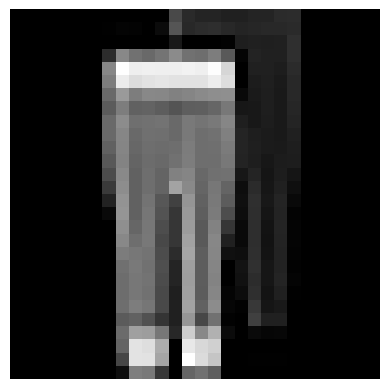

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


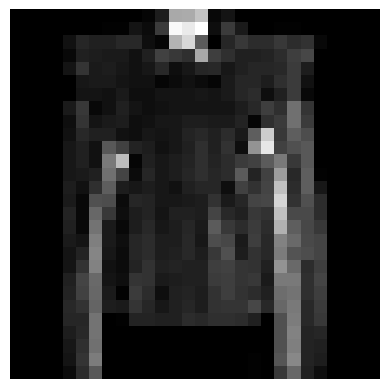

MLP label (ground-truth): T-shirt/top (Bag)
VGG16 label (ground-truth): Bag (Bag)


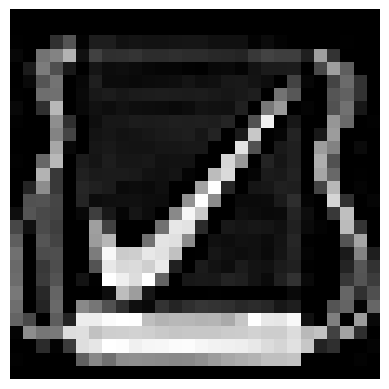

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


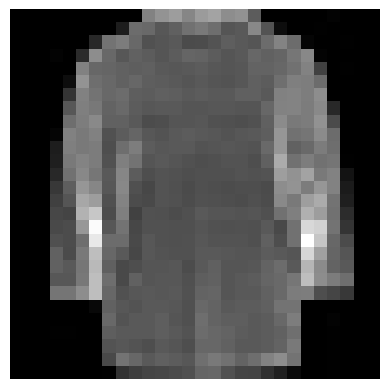

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


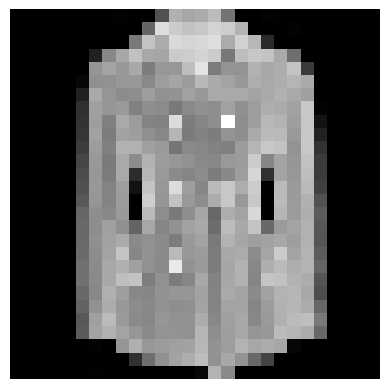

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


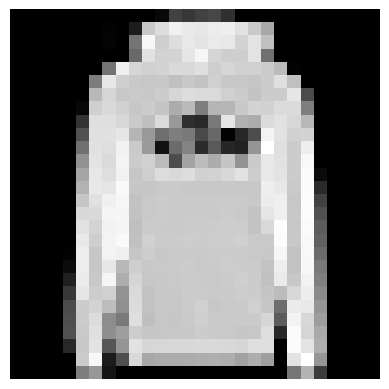

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


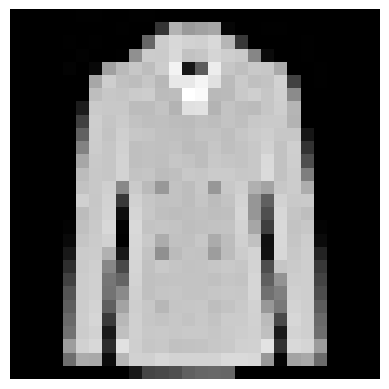

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


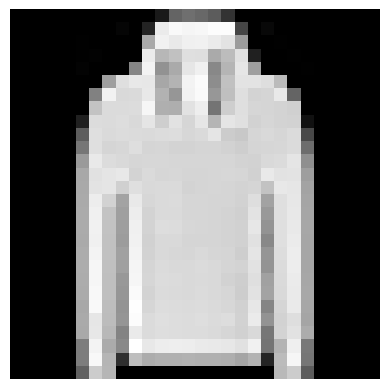

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


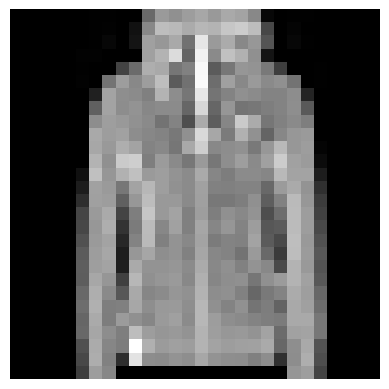

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


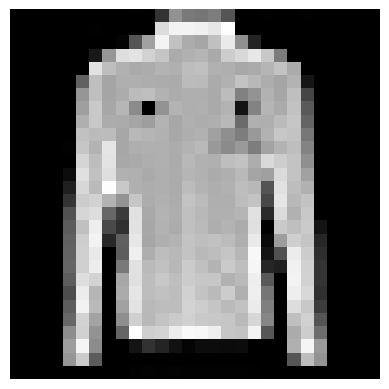

MLP label (ground-truth): Pullover (Bag)
VGG16 label (ground-truth): Bag (Bag)


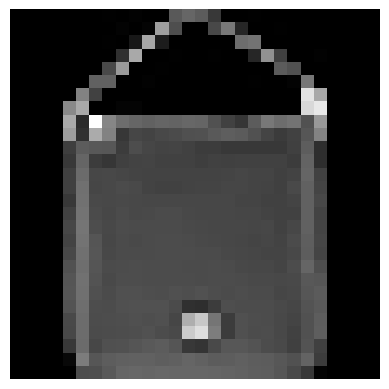

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


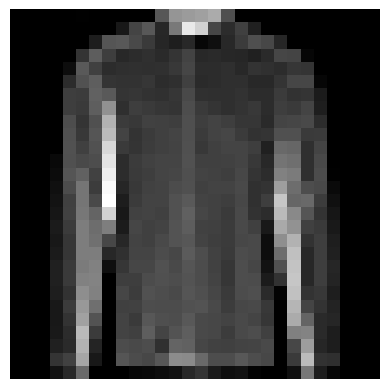

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


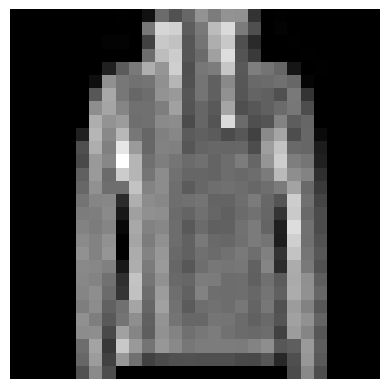

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


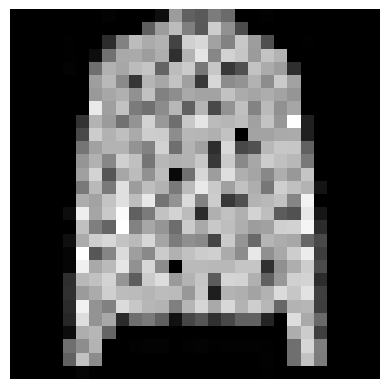

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


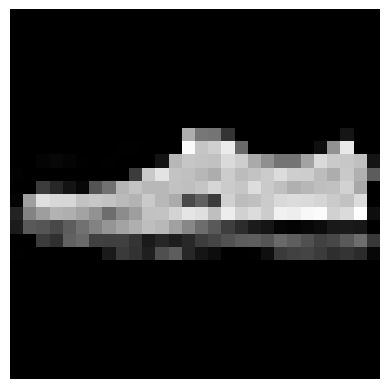

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


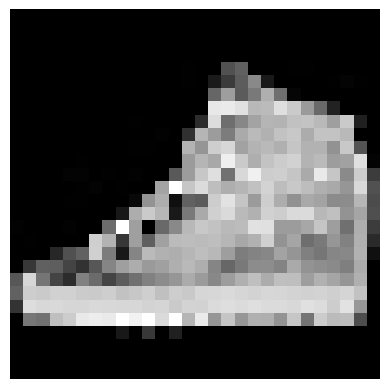

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


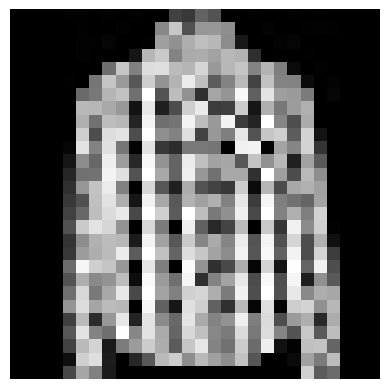

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


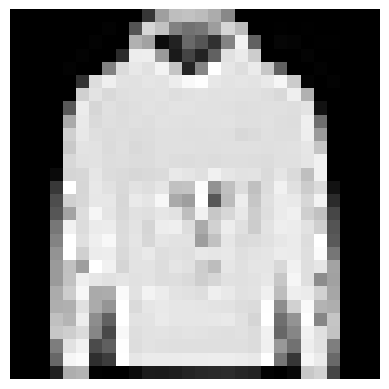

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


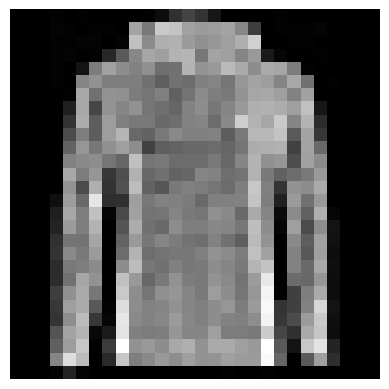

MLP label (ground-truth): Dress (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


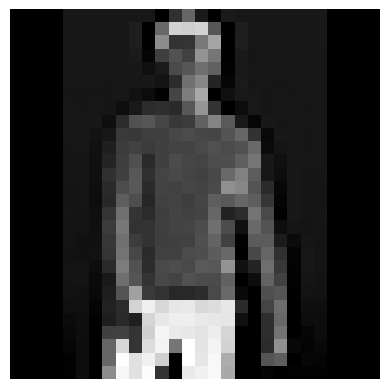

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


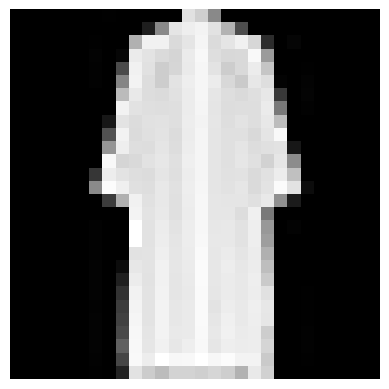

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


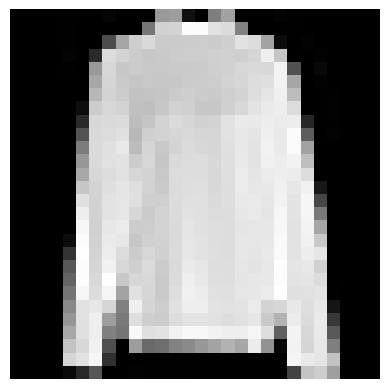

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


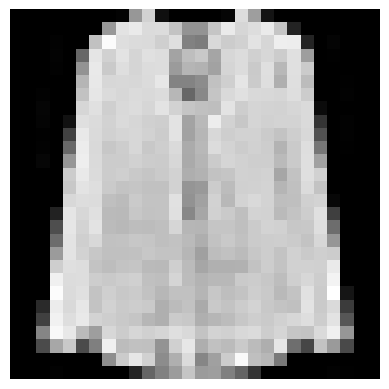

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


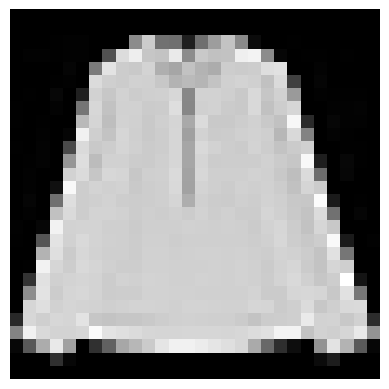

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


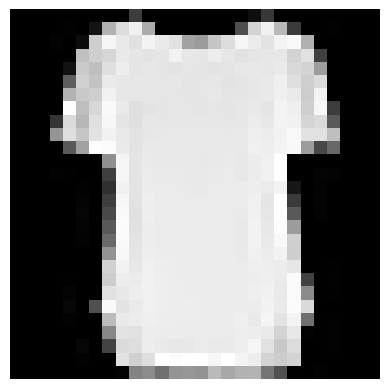

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


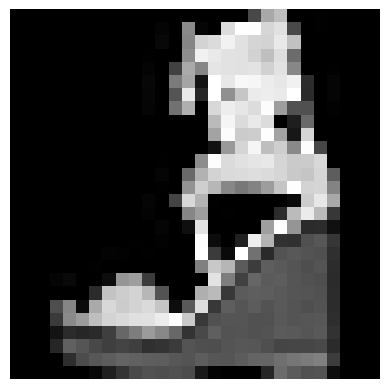

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


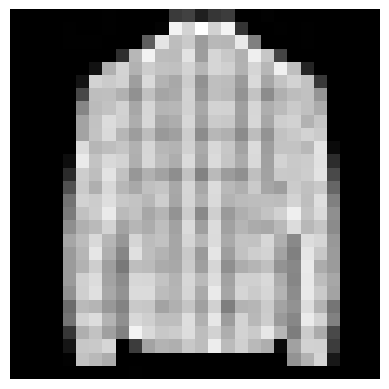

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


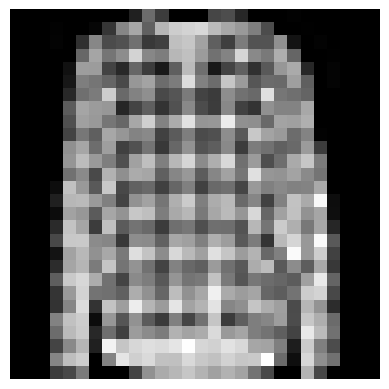

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


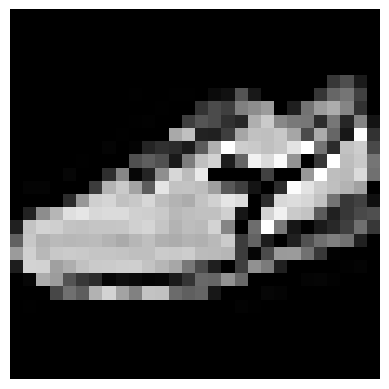

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


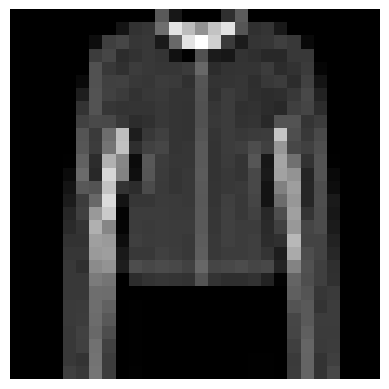

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


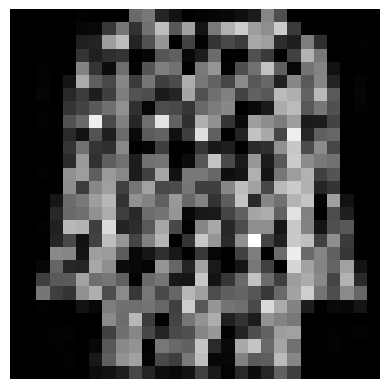

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


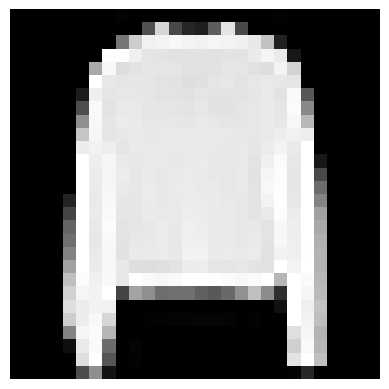

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


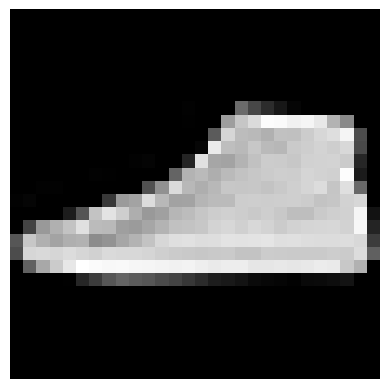

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


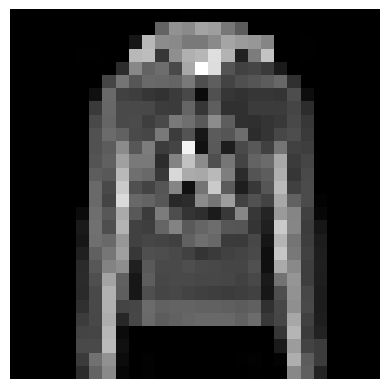

MLP label (ground-truth): T-shirt/top (Dress)
VGG16 label (ground-truth): Dress (Dress)


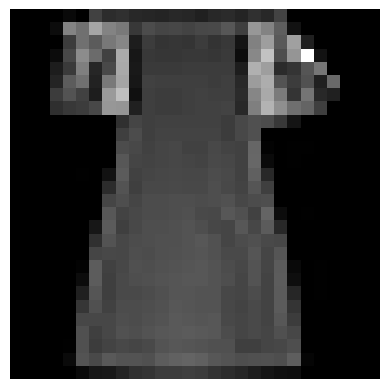

MLP label (ground-truth): Dress (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


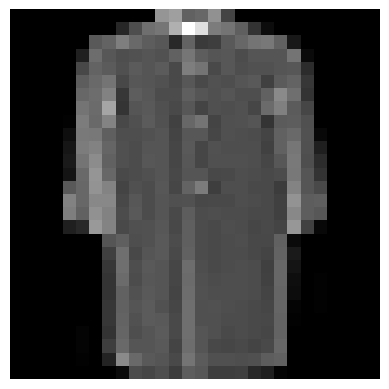

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


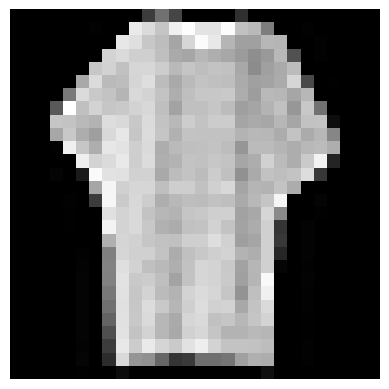

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


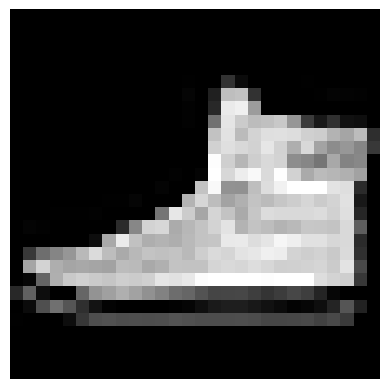

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


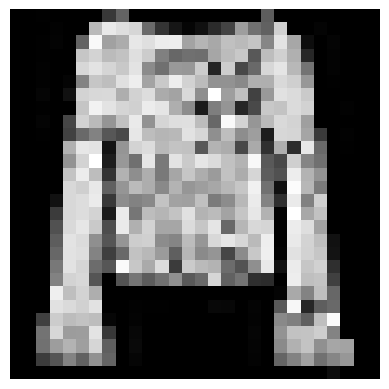

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


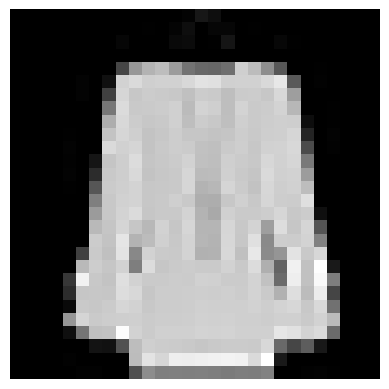

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


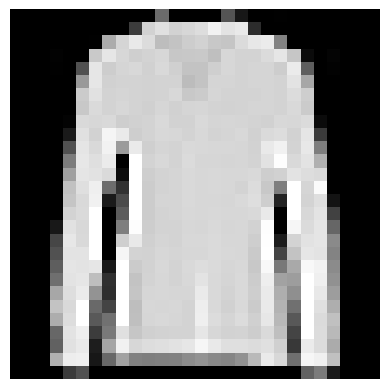

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


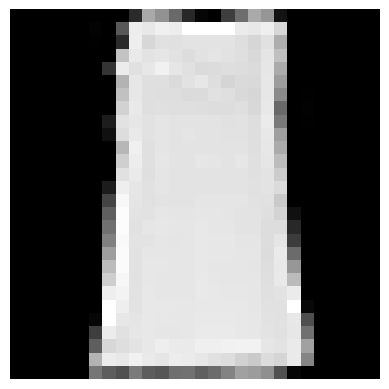

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


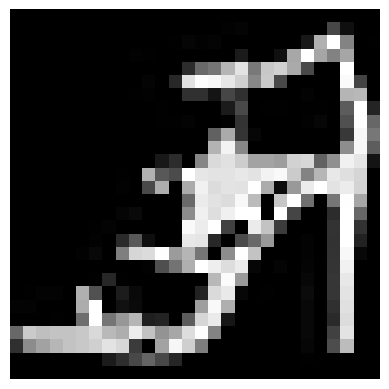

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


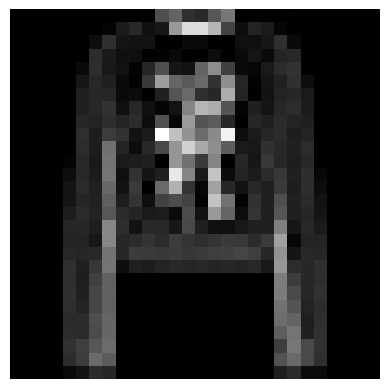

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


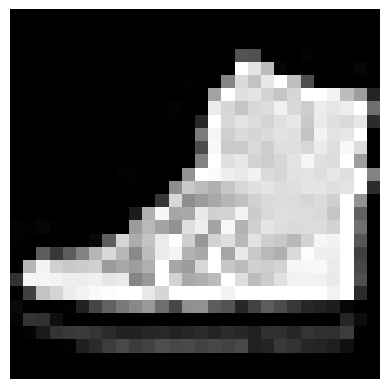

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


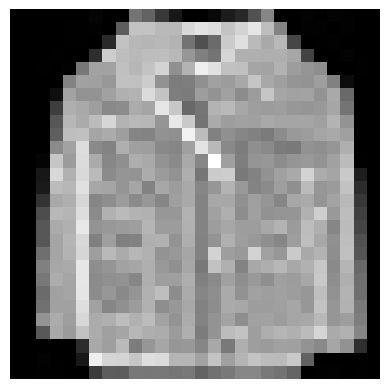

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


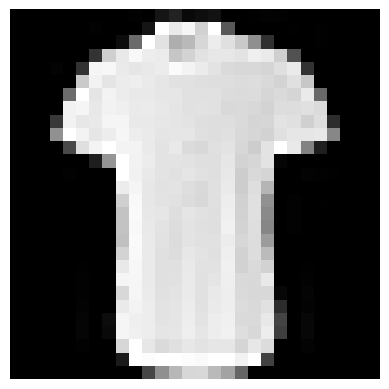

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


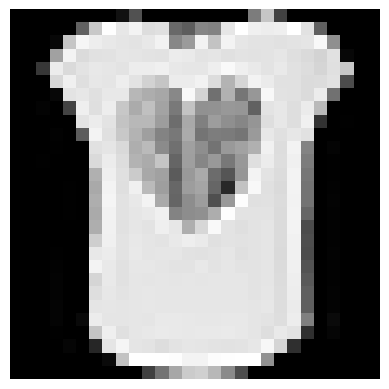

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


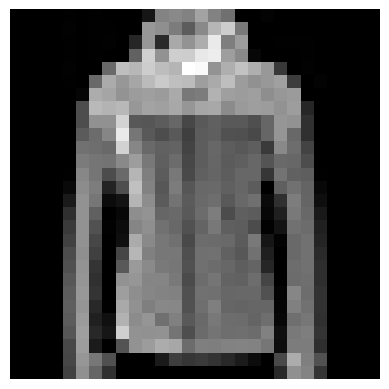

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


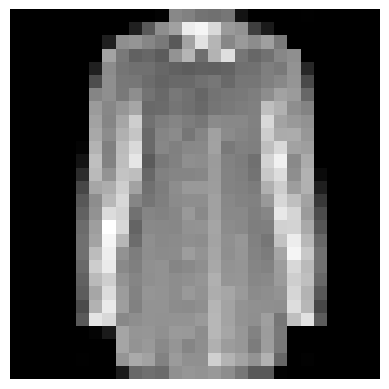

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


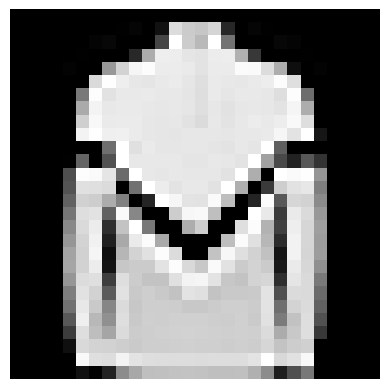

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


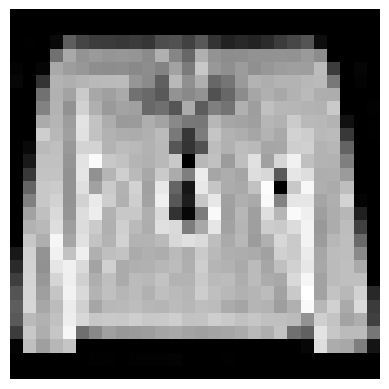

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


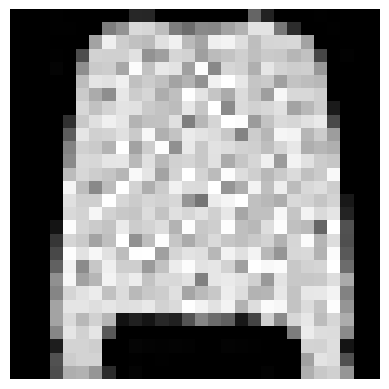

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


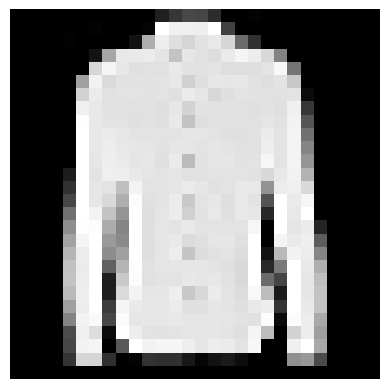

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


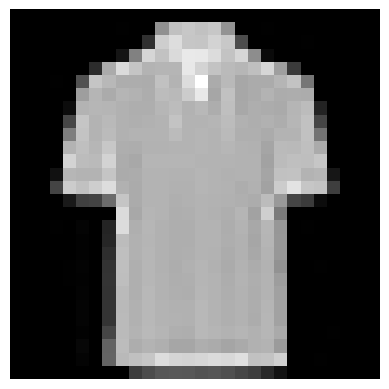

MLP label (ground-truth): Shirt (Bag)
VGG16 label (ground-truth): Bag (Bag)


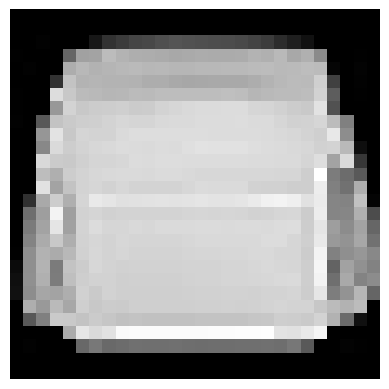

MLP label (ground-truth): Pullover (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


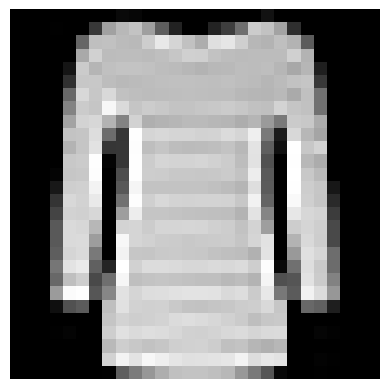

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


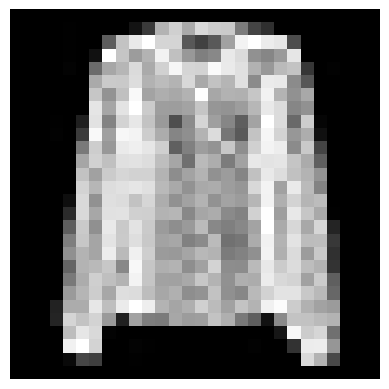

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


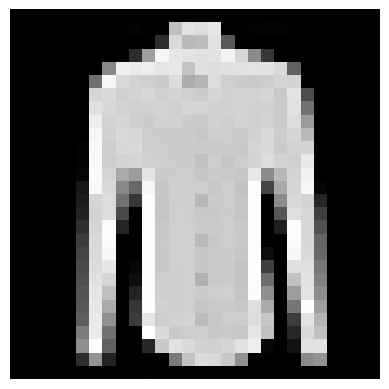

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


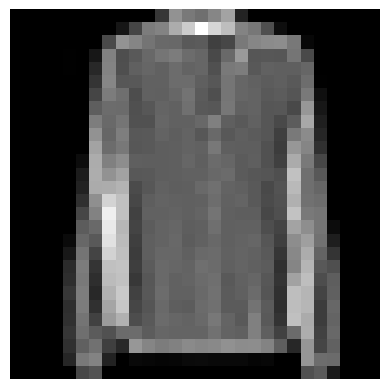

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


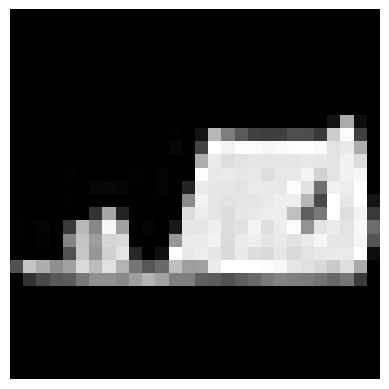

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


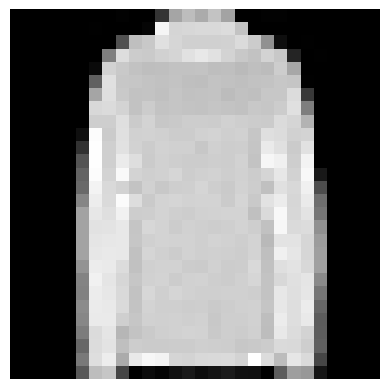

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


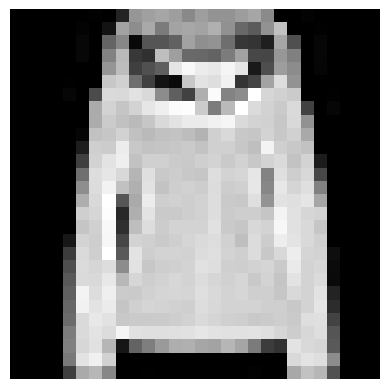

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


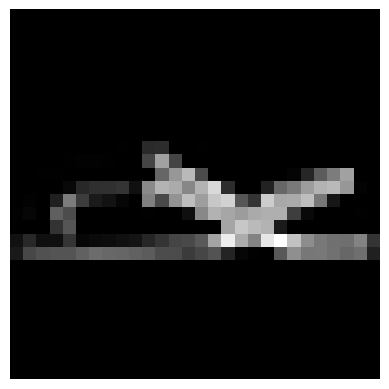

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


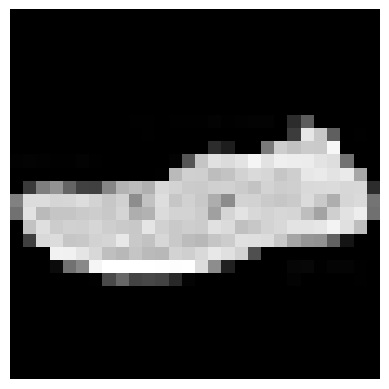

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


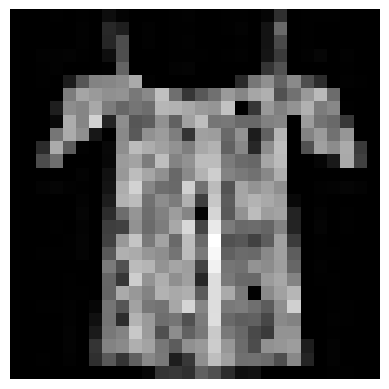

MLP label (ground-truth): T-shirt/top (Dress)
VGG16 label (ground-truth): Dress (Dress)


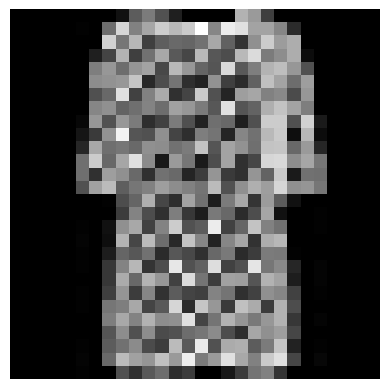

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


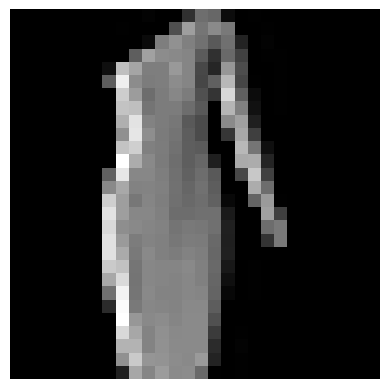

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


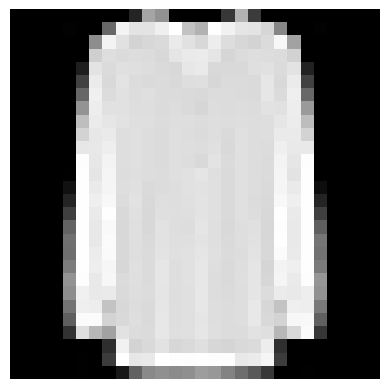

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


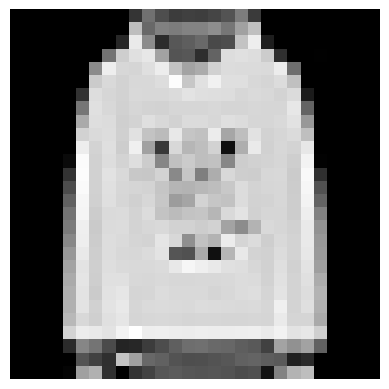

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


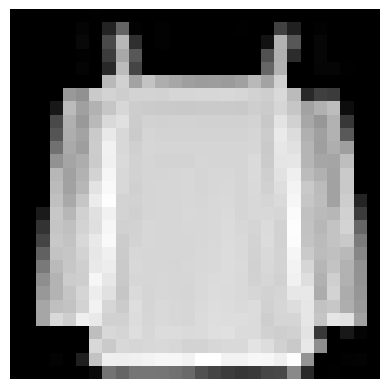

MLP label (ground-truth): Trouser (Dress)
VGG16 label (ground-truth): Dress (Dress)


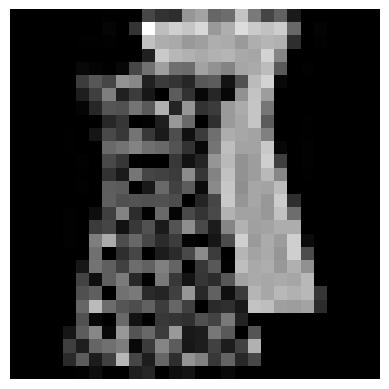

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


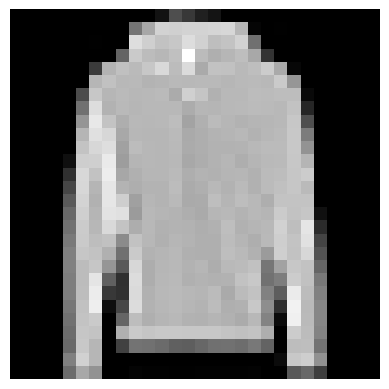

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


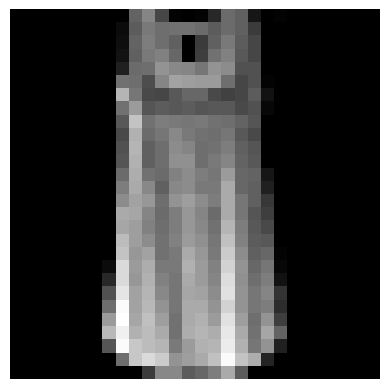

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


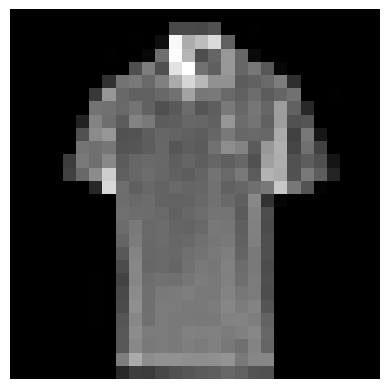

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


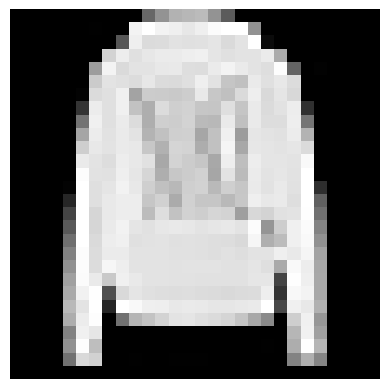

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


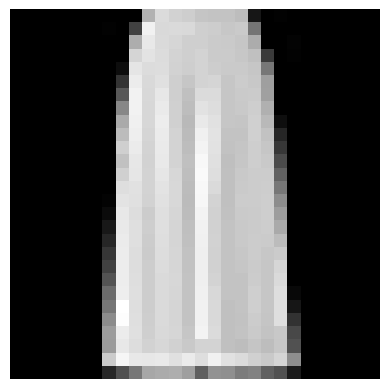

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


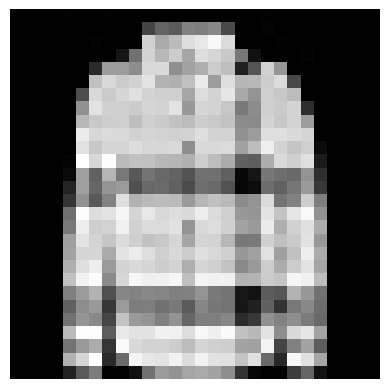

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


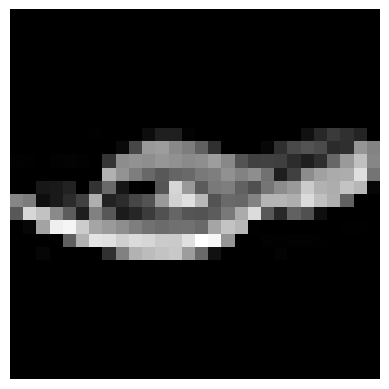

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


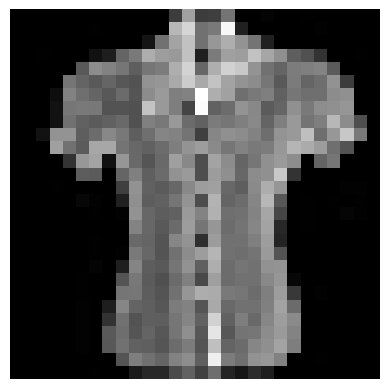

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


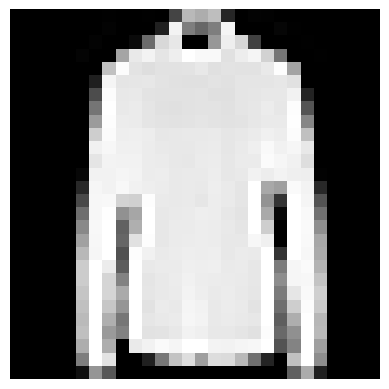

MLP label (ground-truth): Trouser (Dress)
VGG16 label (ground-truth): Dress (Dress)


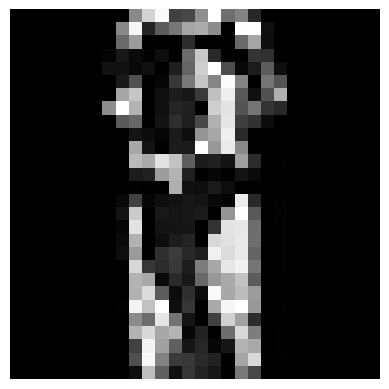

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


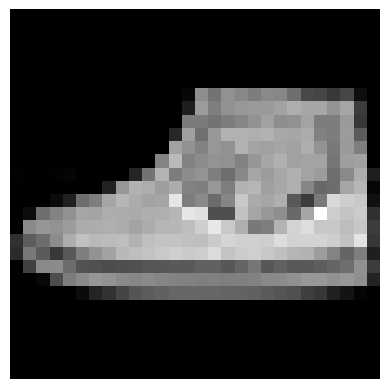

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


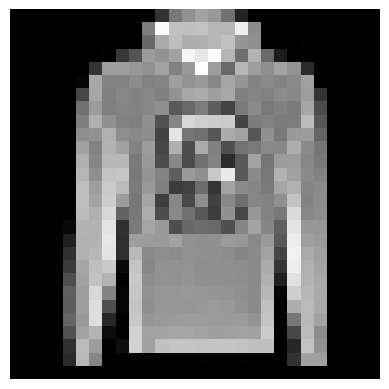

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


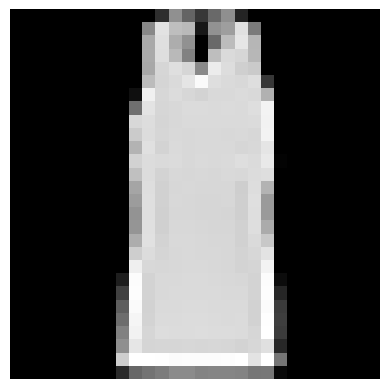

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


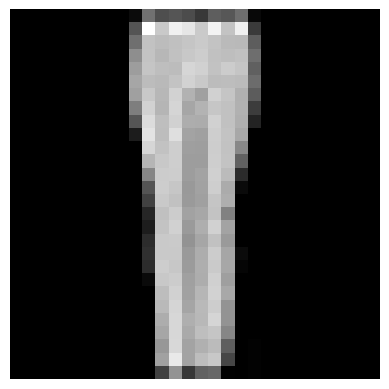

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


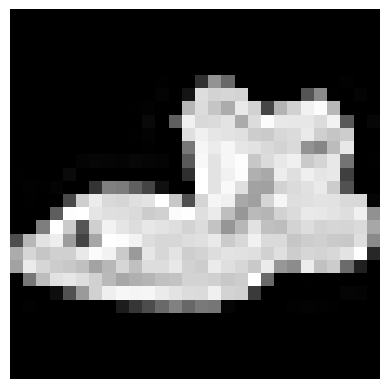

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


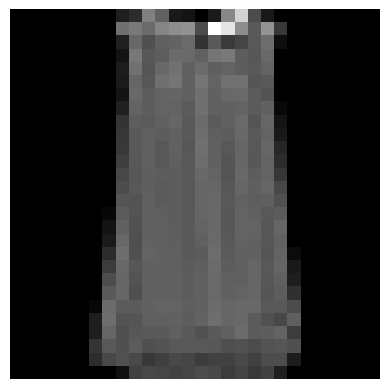

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


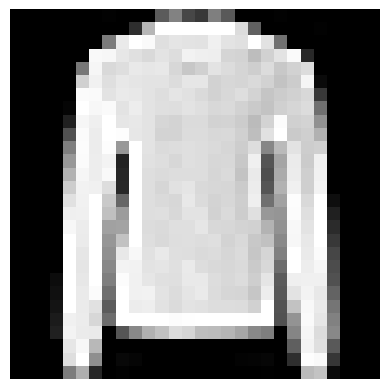

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


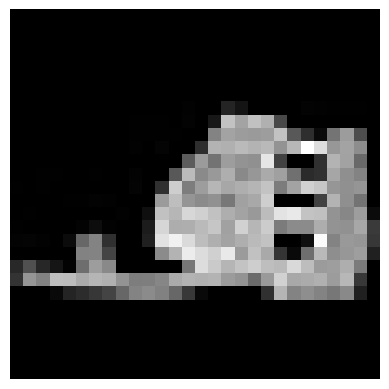

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


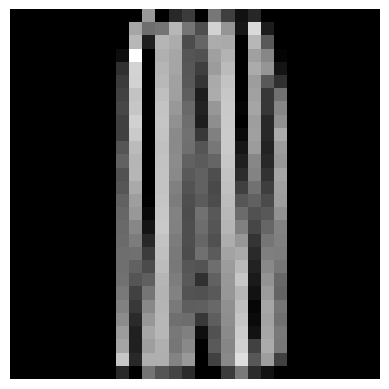

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


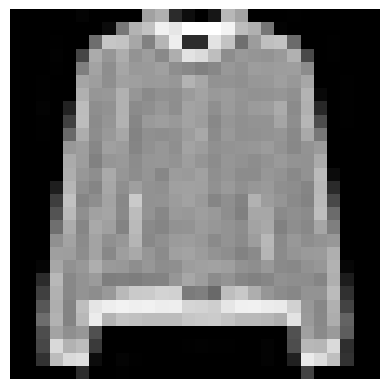

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


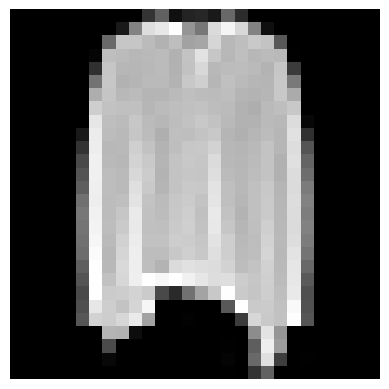

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


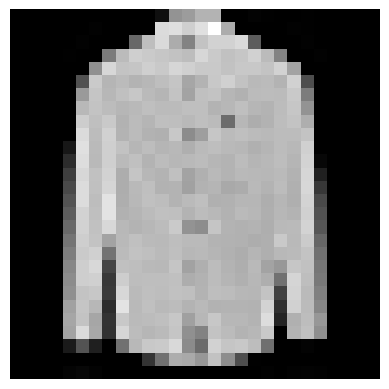

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


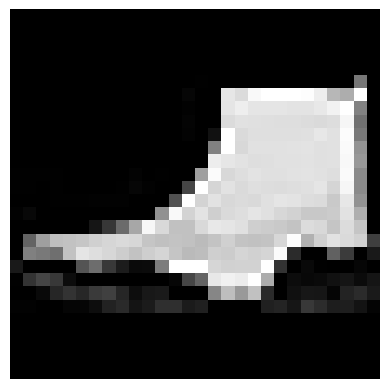

MLP label (ground-truth): Dress (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


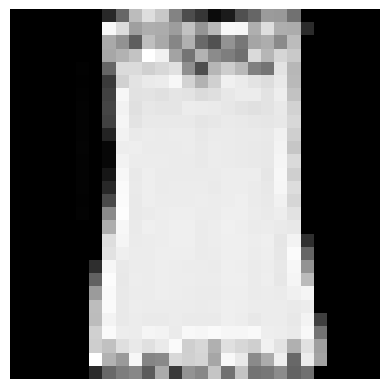

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


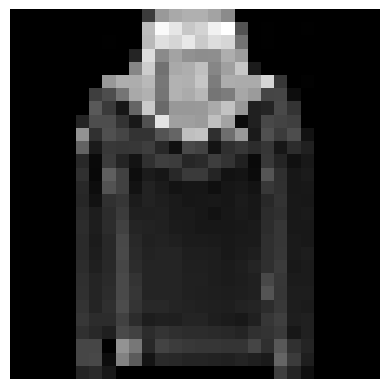

MLP label (ground-truth): Sandal (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


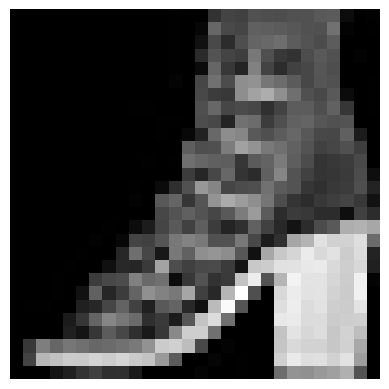

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


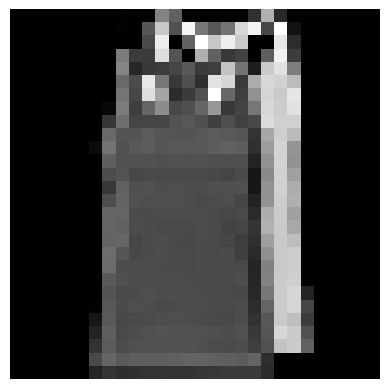

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


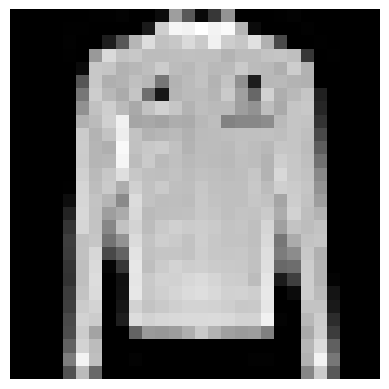

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


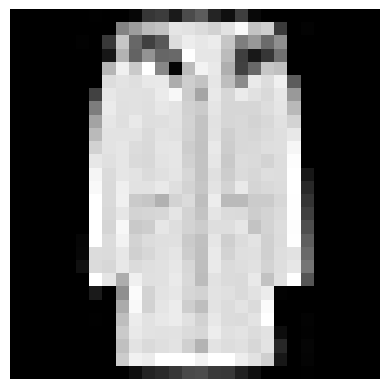

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


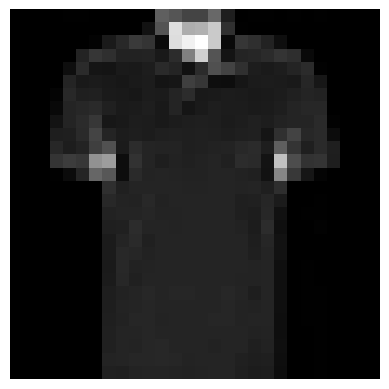

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


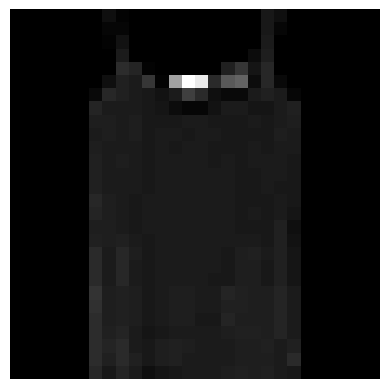

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


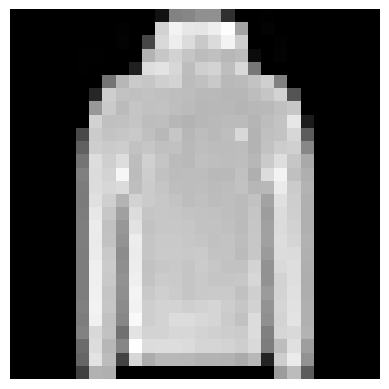

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


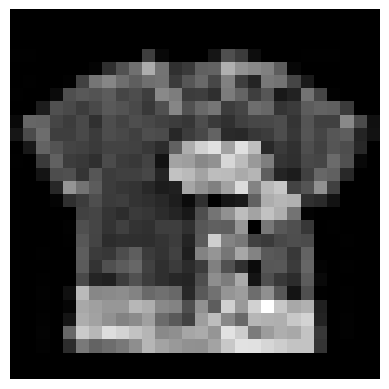

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


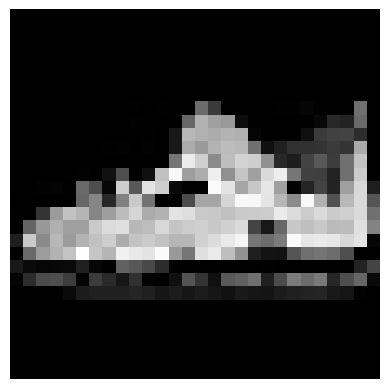

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


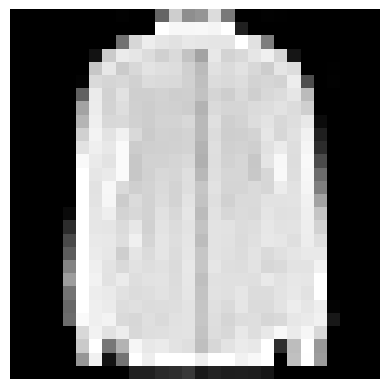

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


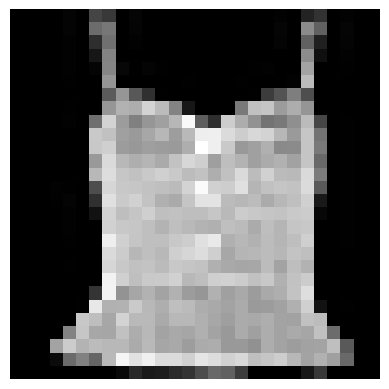

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


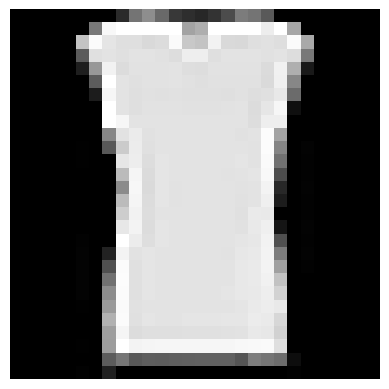

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


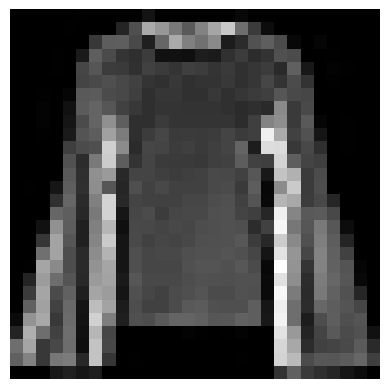

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


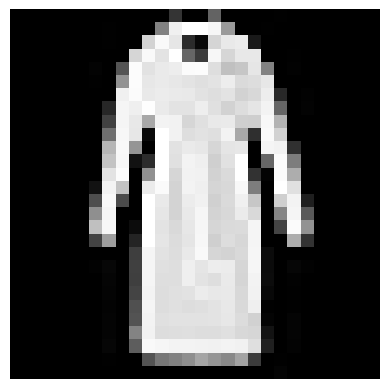

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


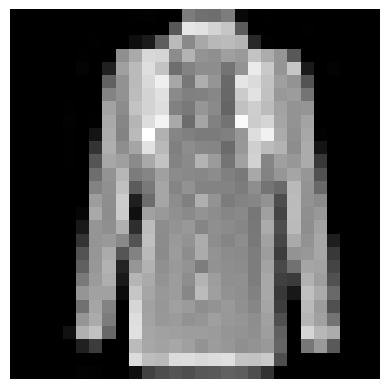

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


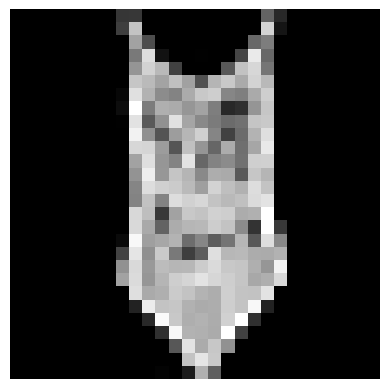

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


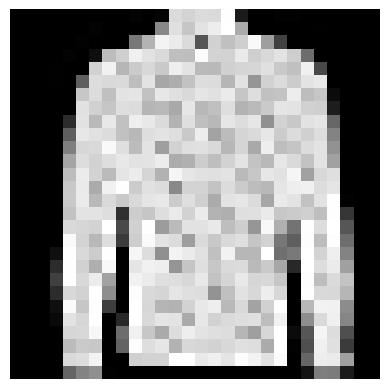

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


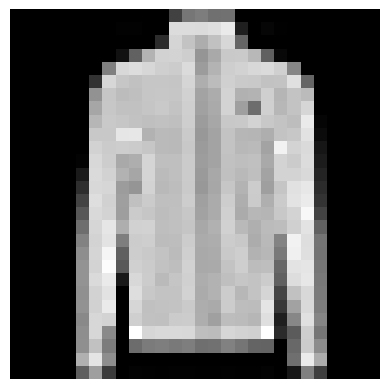

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


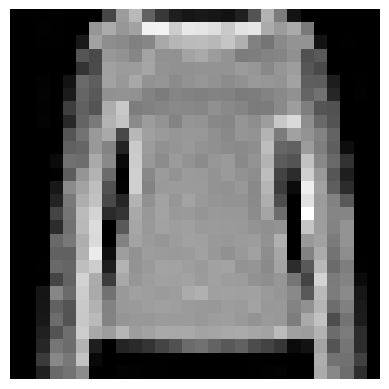

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


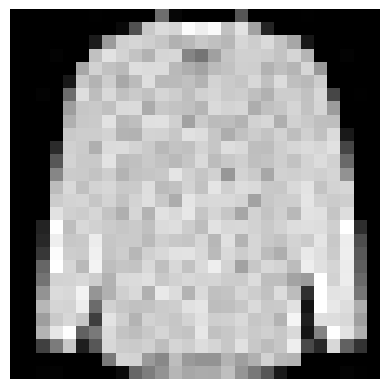

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


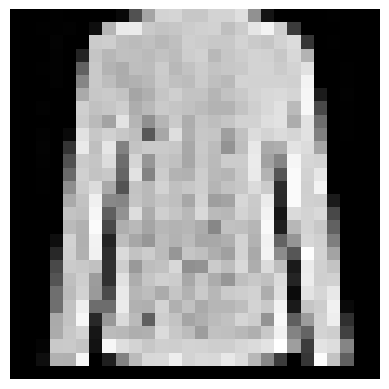

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


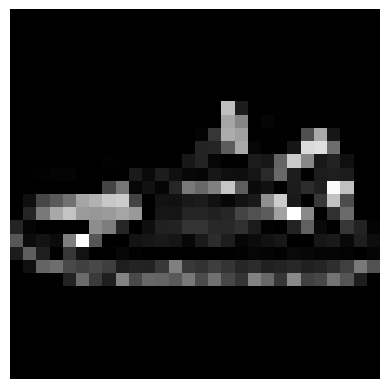

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


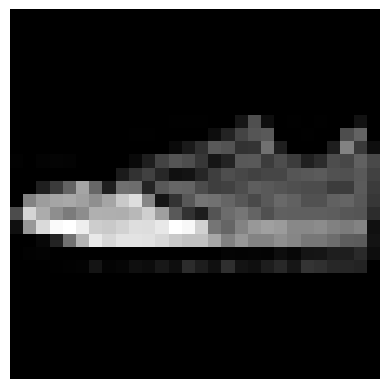

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


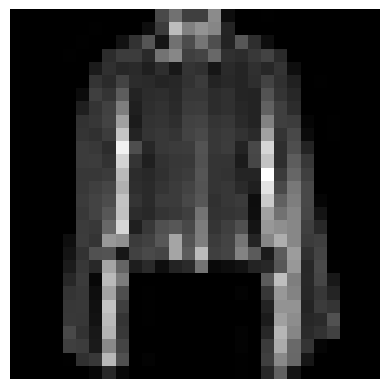

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


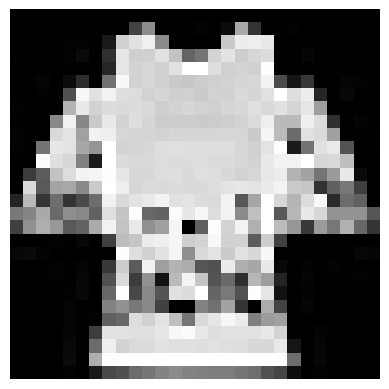

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


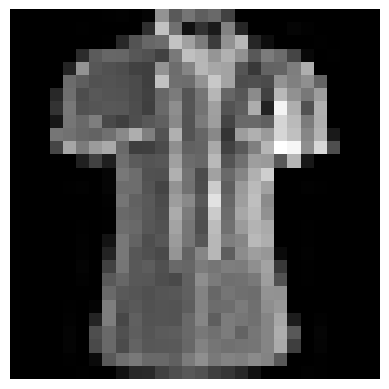

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


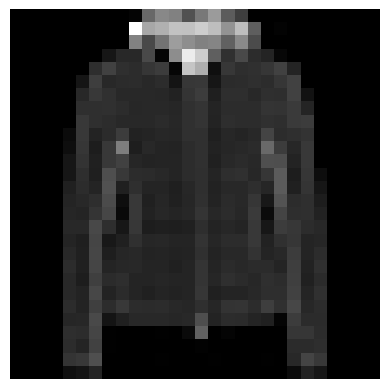

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


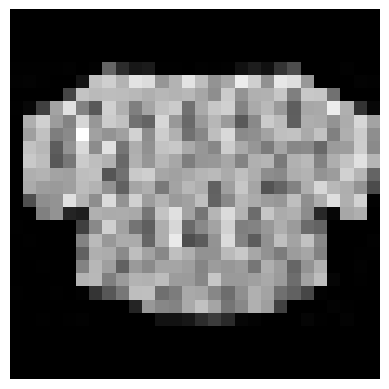

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


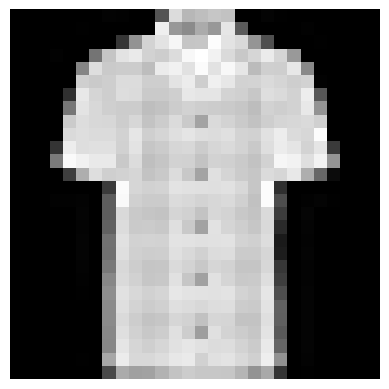

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


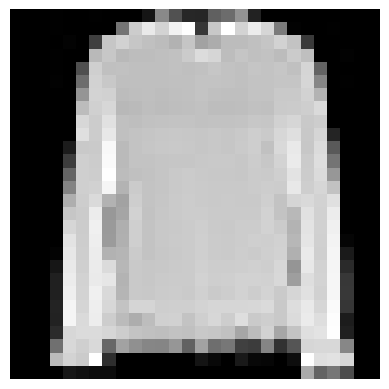

MLP label (ground-truth): T-shirt/top (Dress)
VGG16 label (ground-truth): Dress (Dress)


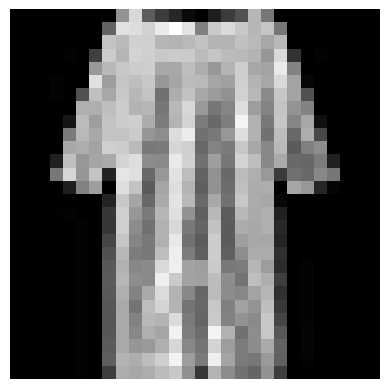

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


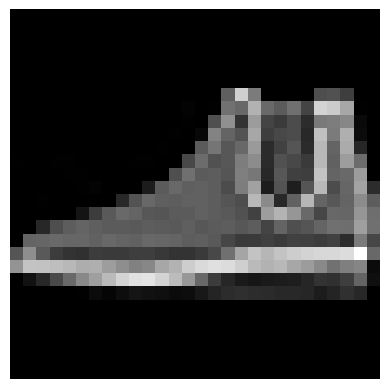

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


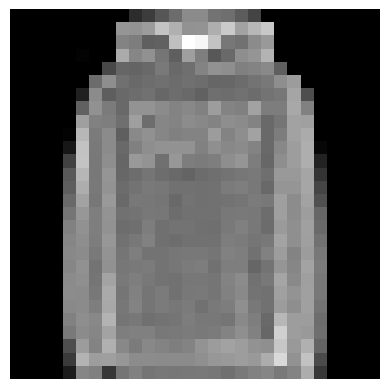

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


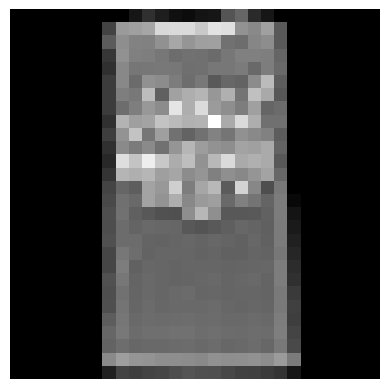

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


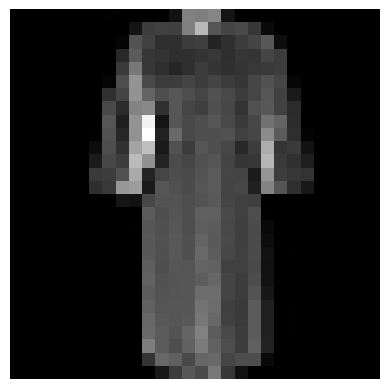

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


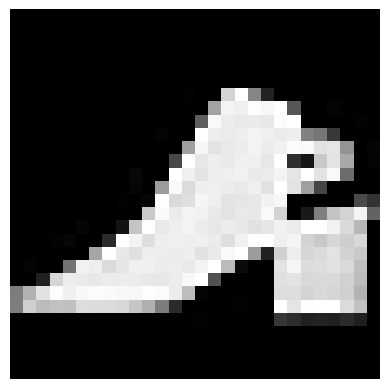

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


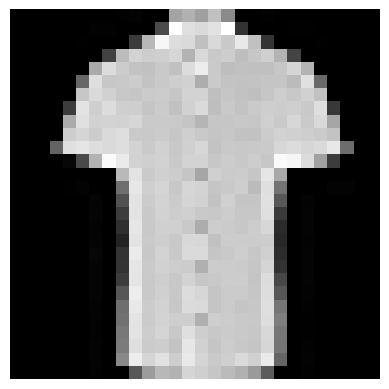

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


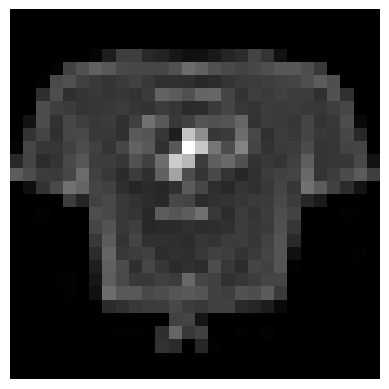

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


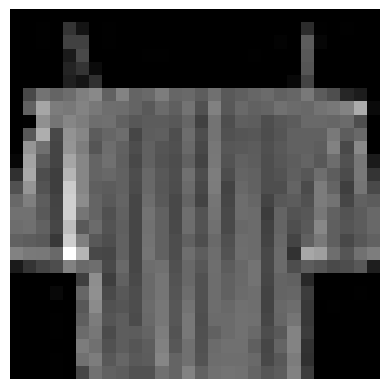

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


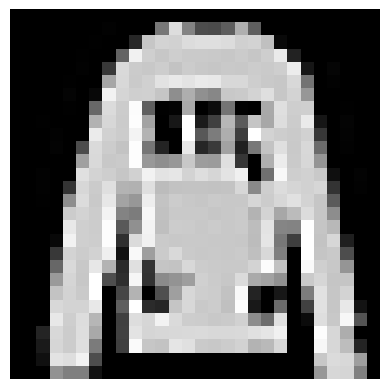

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


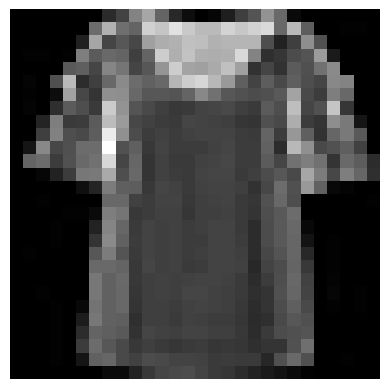

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


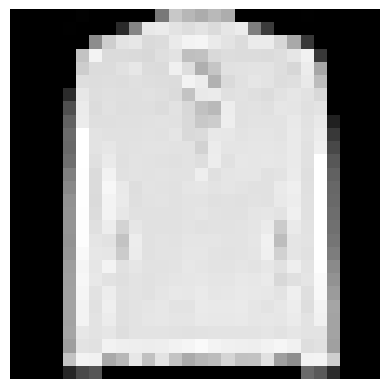

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


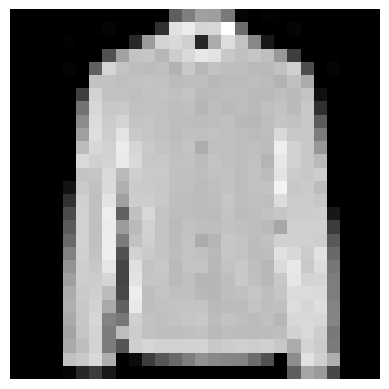

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


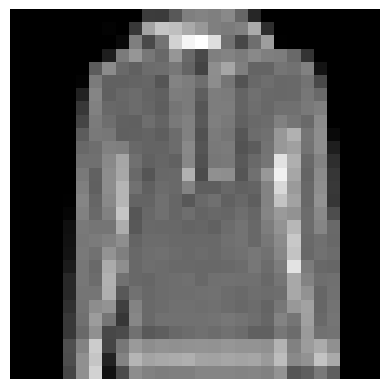

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


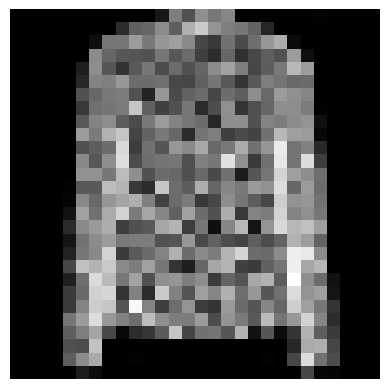

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


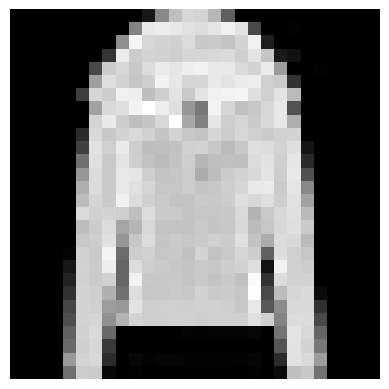

MLP label (ground-truth): Dress (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


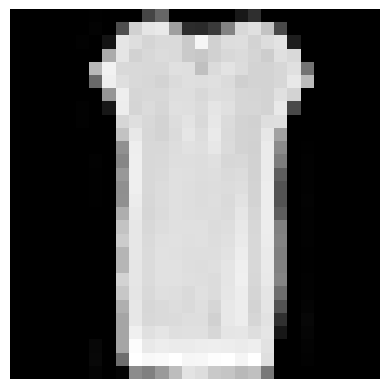

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


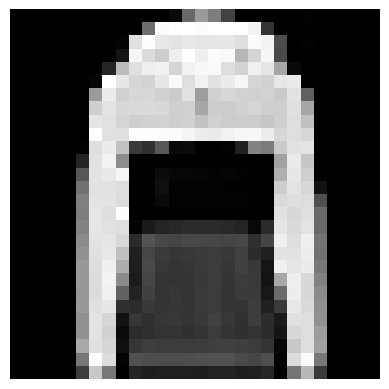

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


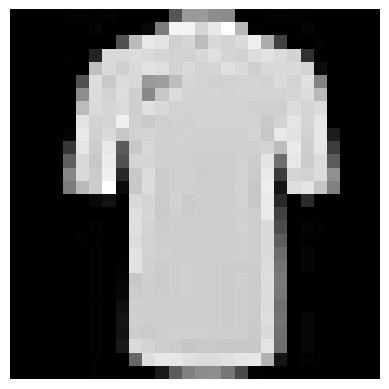

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


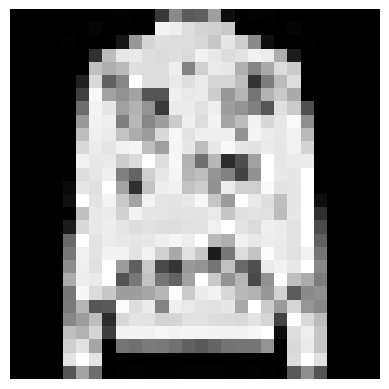

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


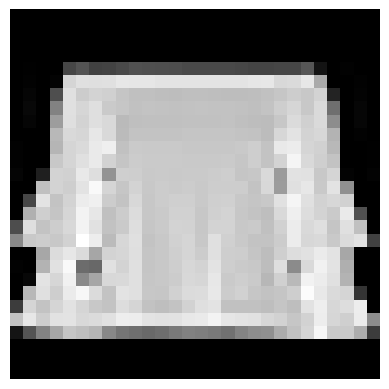

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


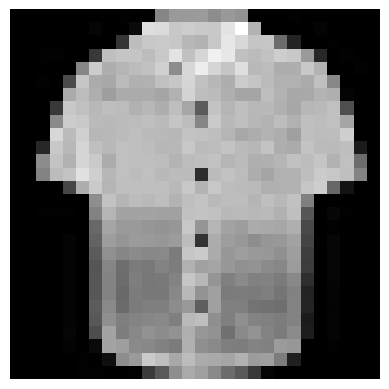

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


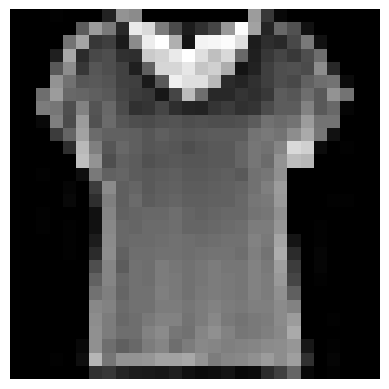

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


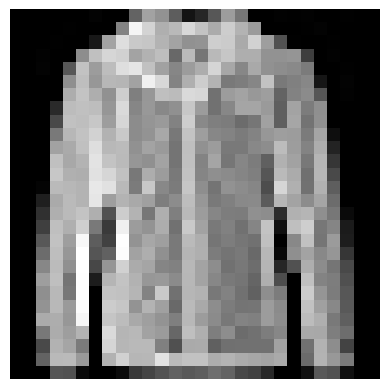

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


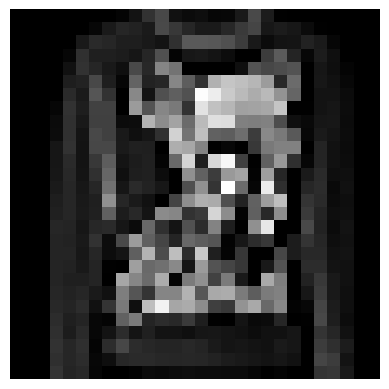

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


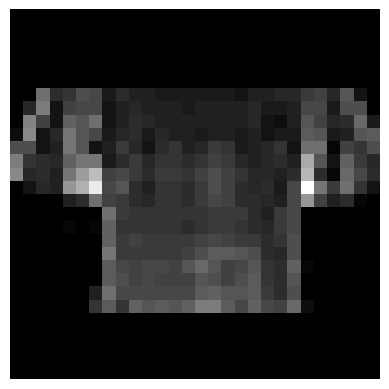

MLP label (ground-truth): Dress (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


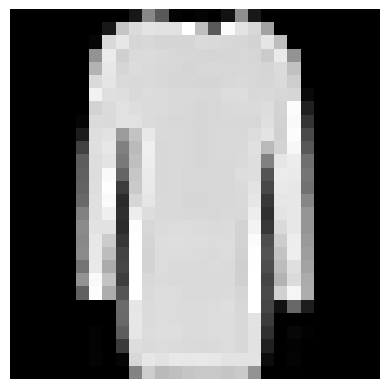

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


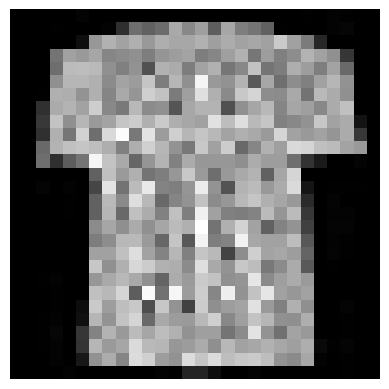

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


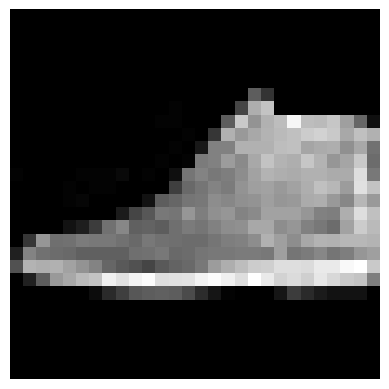

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


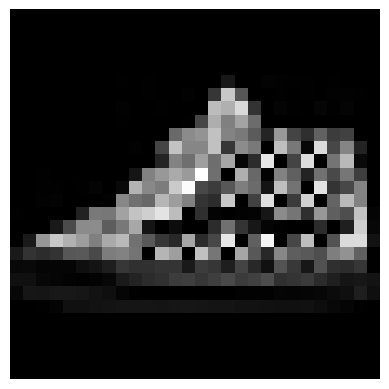

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


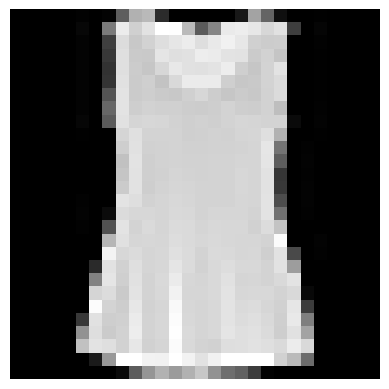

MLP label (ground-truth): Shirt (Bag)
VGG16 label (ground-truth): Bag (Bag)


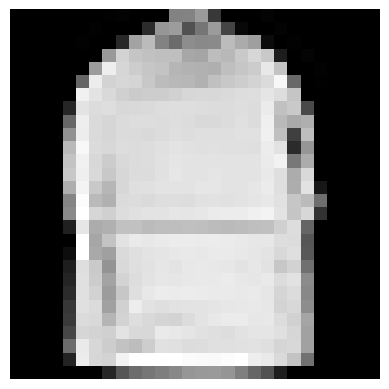

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


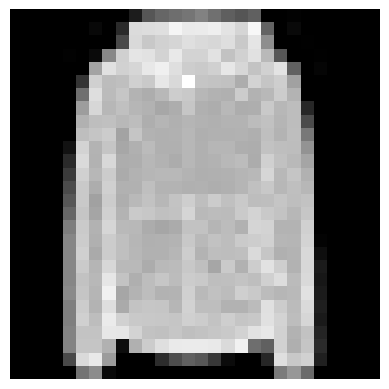

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


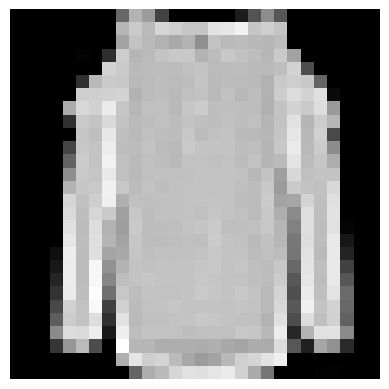

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


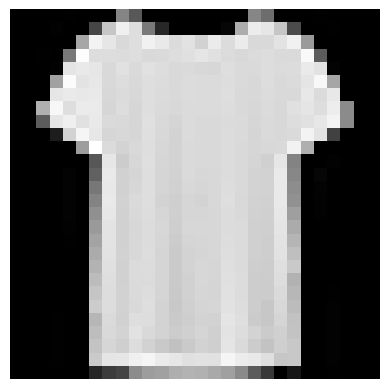

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


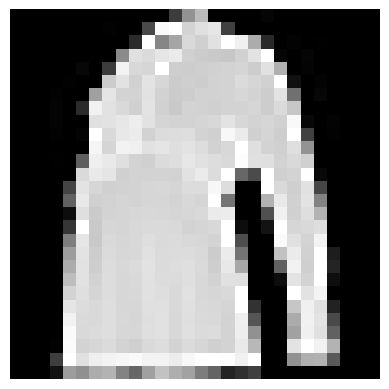

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


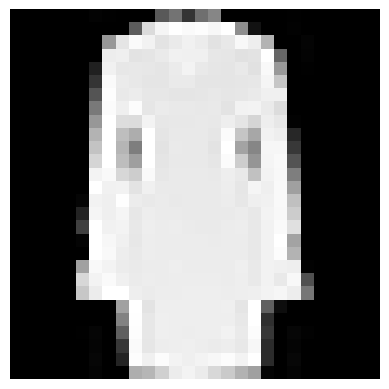

MLP label (ground-truth): Sandal (Bag)
VGG16 label (ground-truth): Bag (Bag)


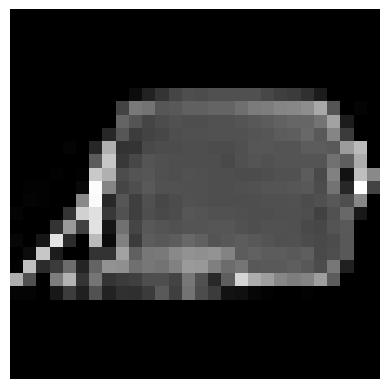

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


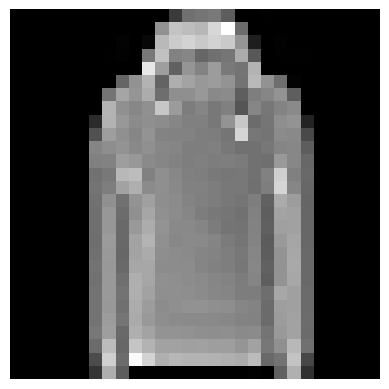

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


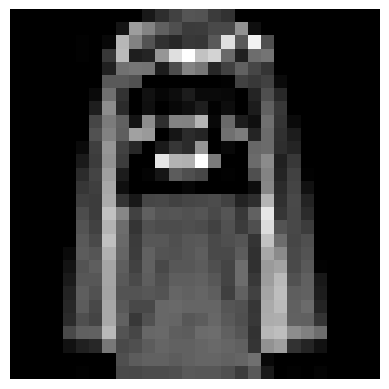

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


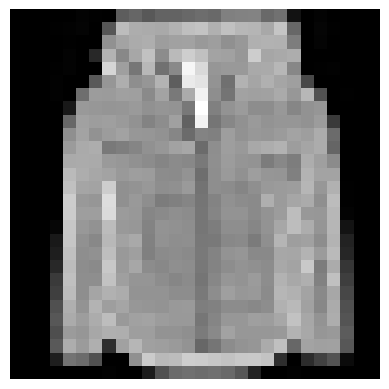

MLP label (ground-truth): Shirt (Bag)
VGG16 label (ground-truth): Bag (Bag)


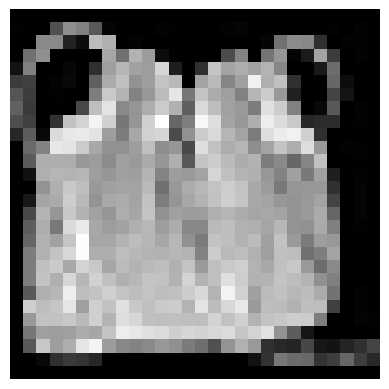

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


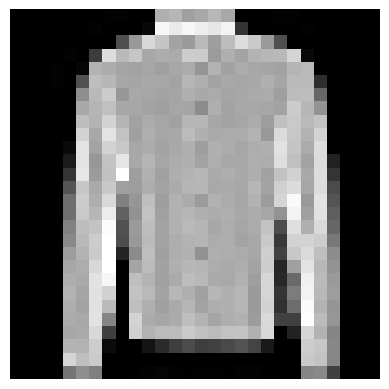

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


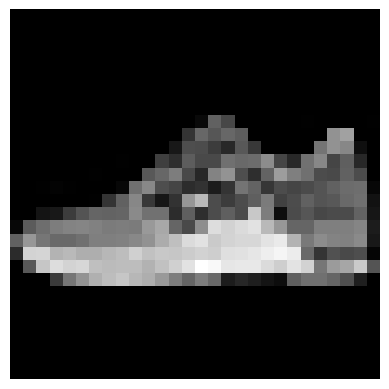

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


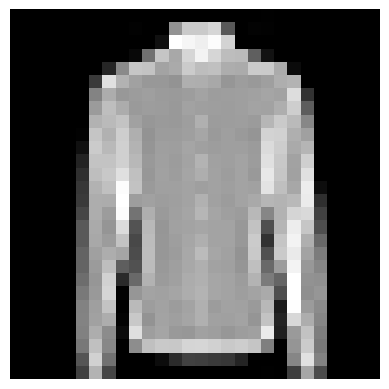

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


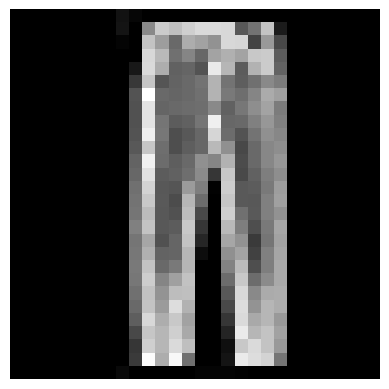

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


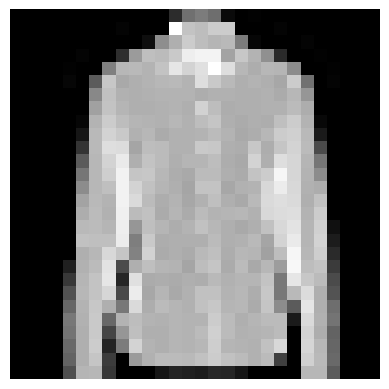

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


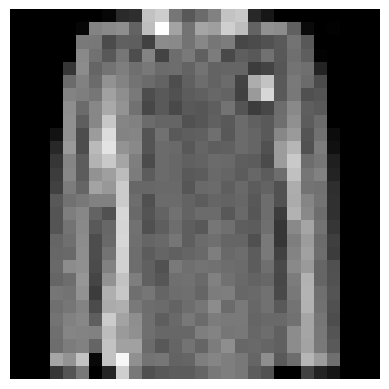

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


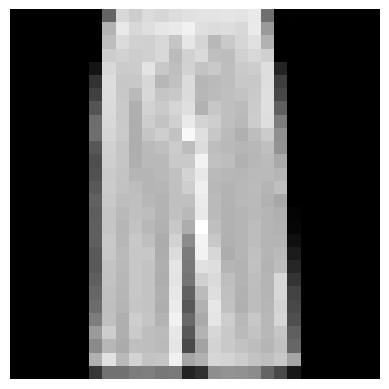

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


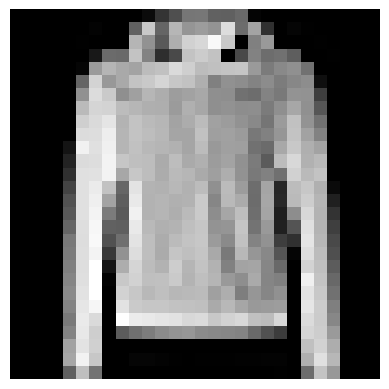

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


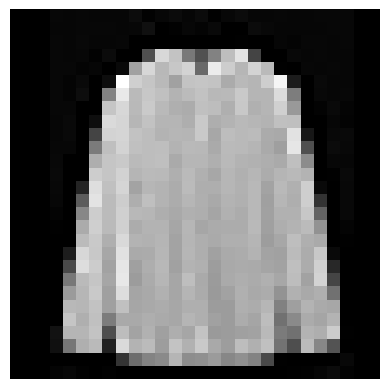

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


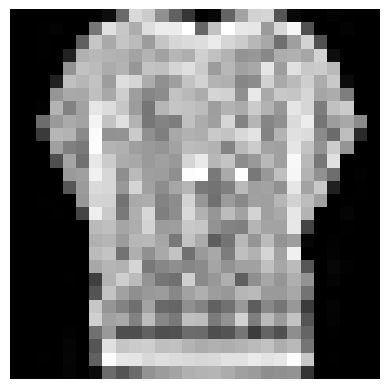

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


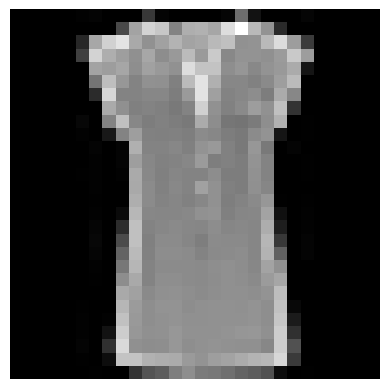

MLP label (ground-truth): Pullover (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


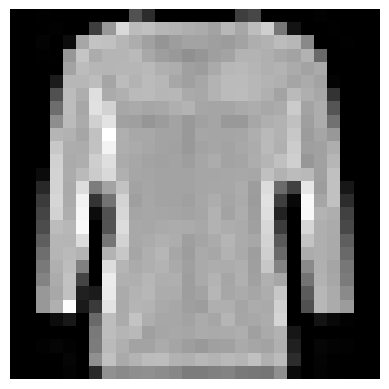

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


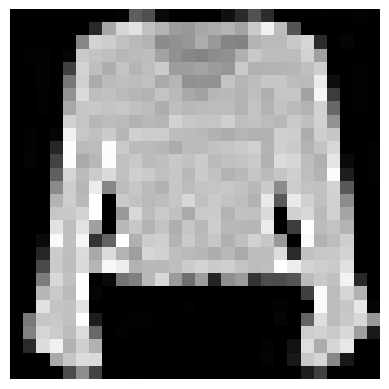

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


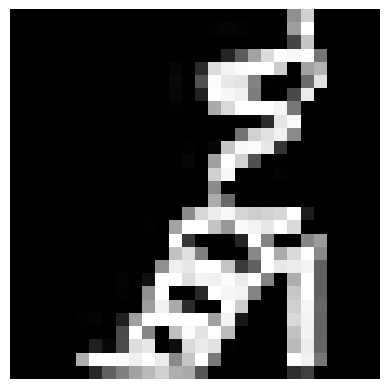

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


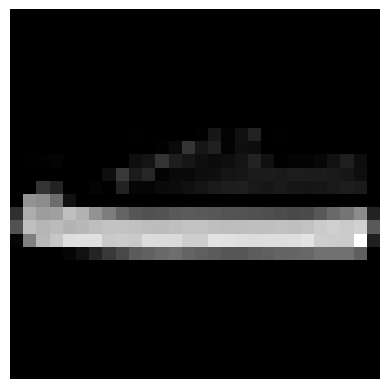

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


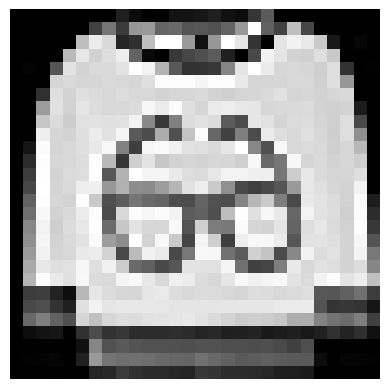

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


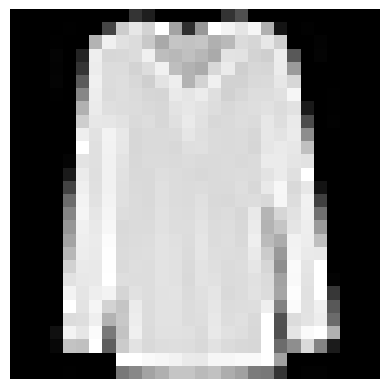

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


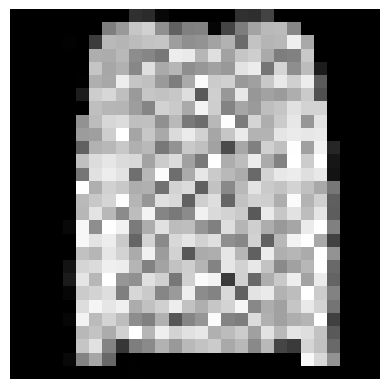

MLP label (ground-truth): Pullover (Dress)
VGG16 label (ground-truth): Dress (Dress)


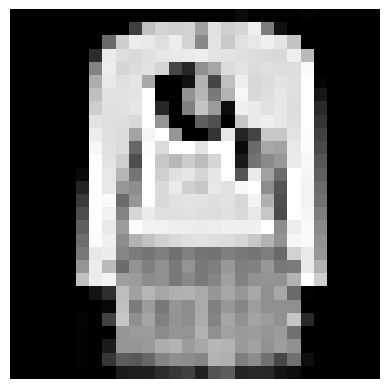

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


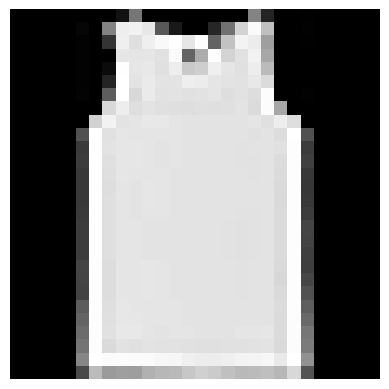

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


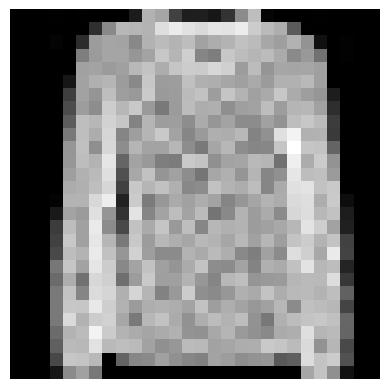

MLP label (ground-truth): Bag (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


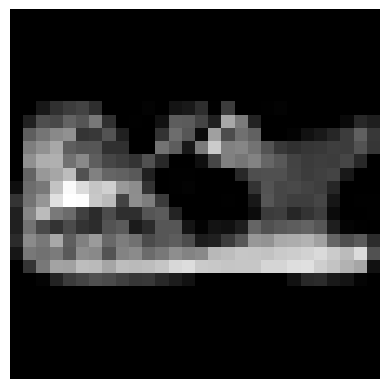

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


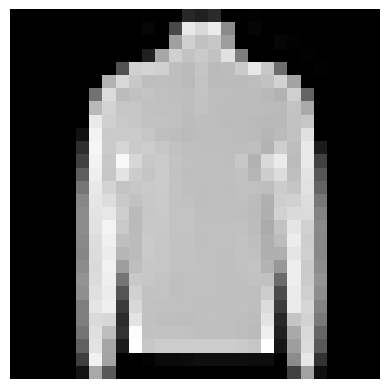

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


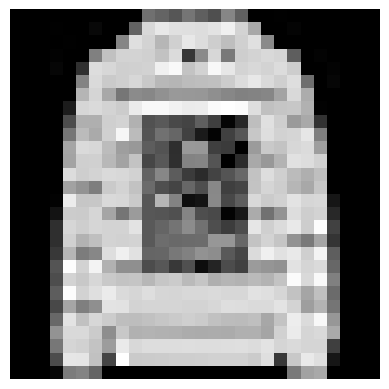

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


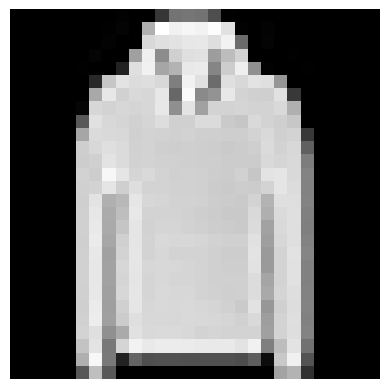

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


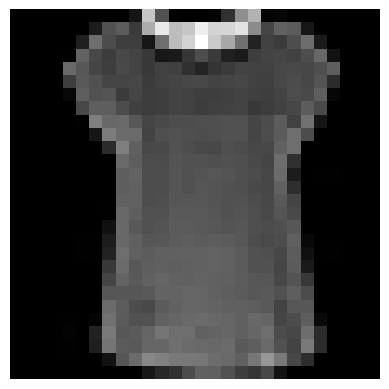

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


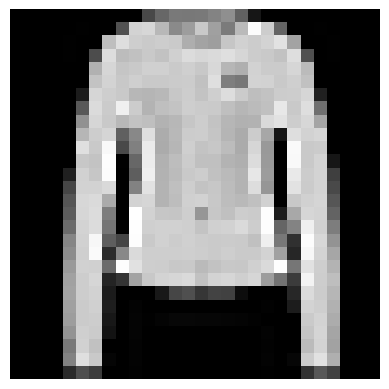

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


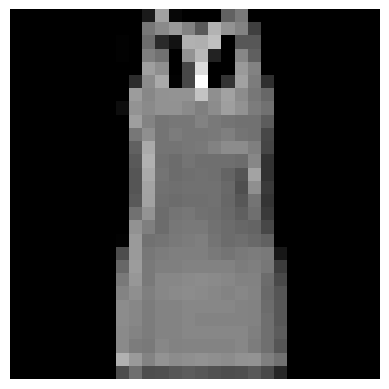

MLP label (ground-truth): Trouser (Dress)
VGG16 label (ground-truth): Dress (Dress)


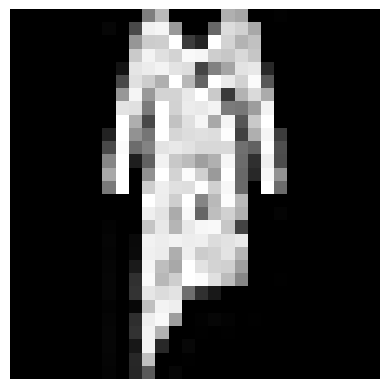

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


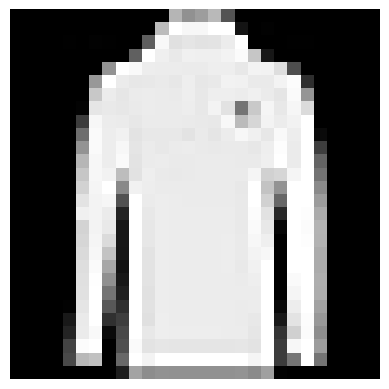

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


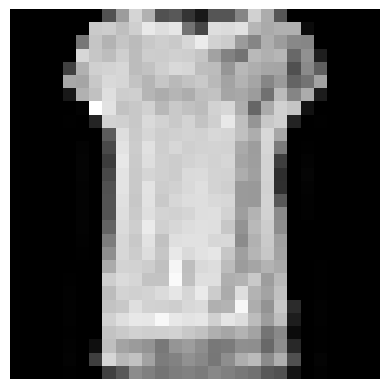

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


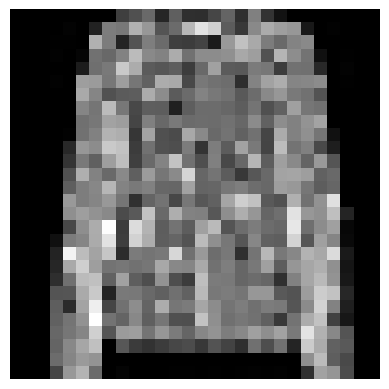

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


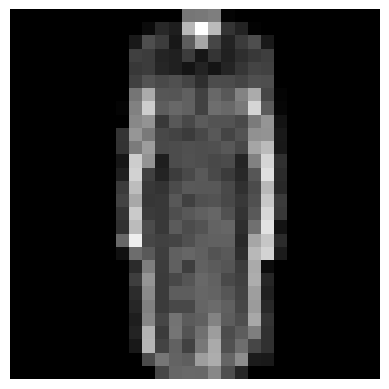

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


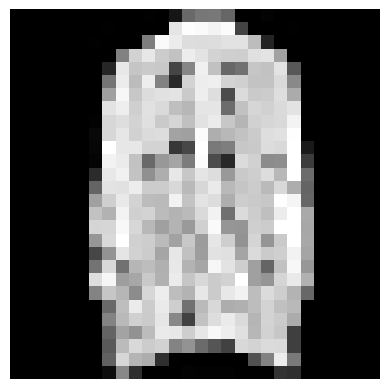

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


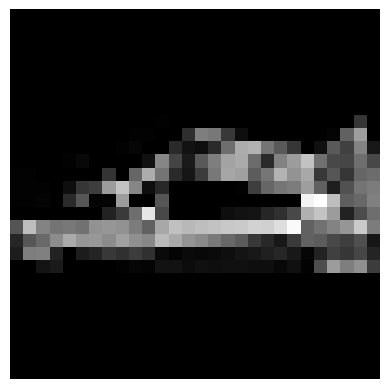

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


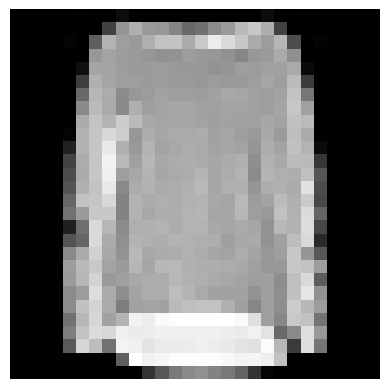

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


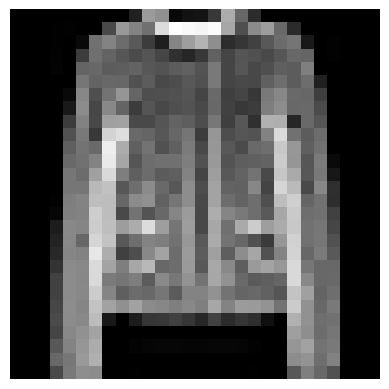

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


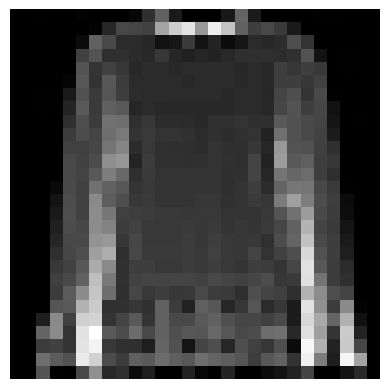

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


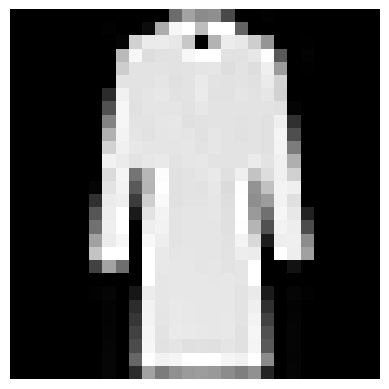

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


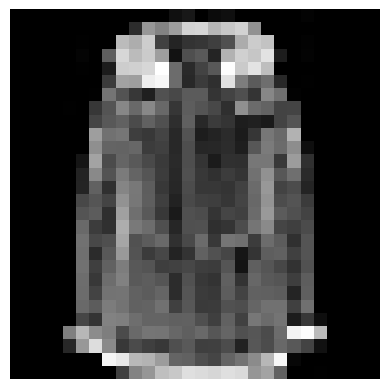

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


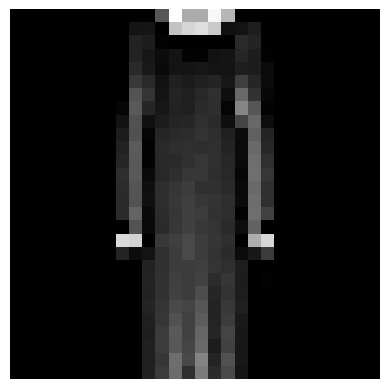

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


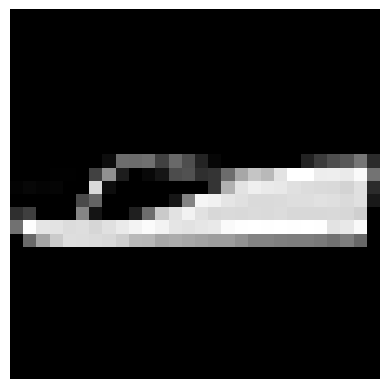

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


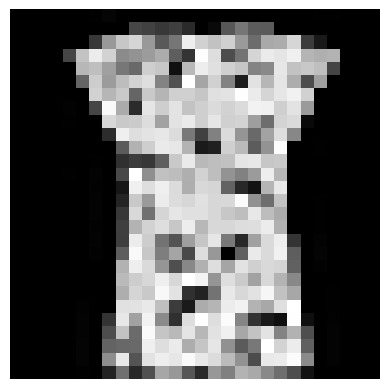

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


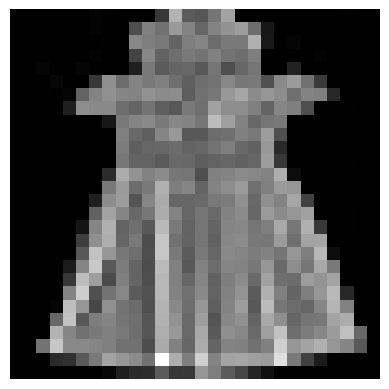

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


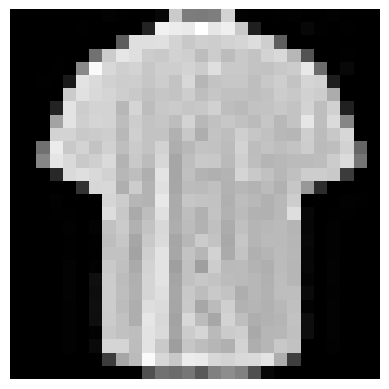

MLP label (ground-truth): Bag (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


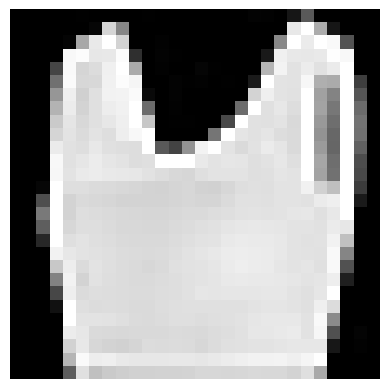

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


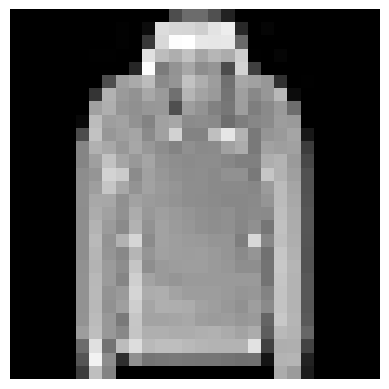

MLP label (ground-truth): Trouser (Dress)
VGG16 label (ground-truth): Dress (Dress)


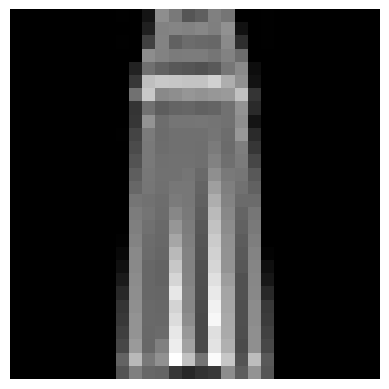

MLP label (ground-truth): T-shirt/top (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


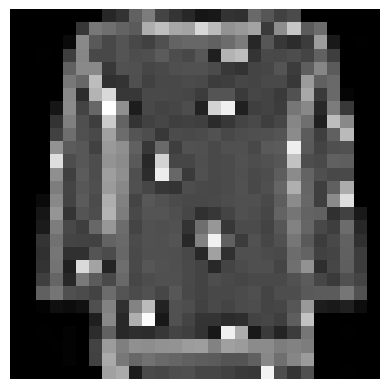

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


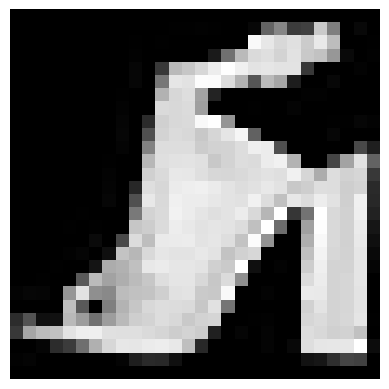

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


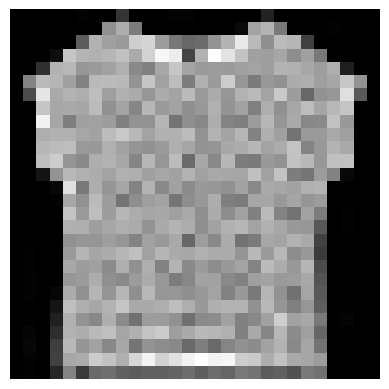

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


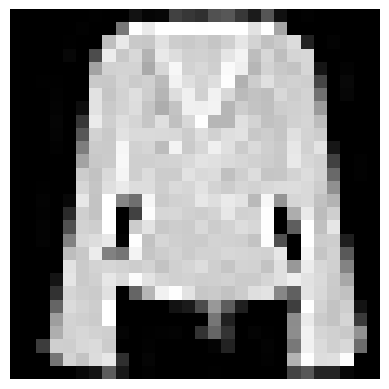

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


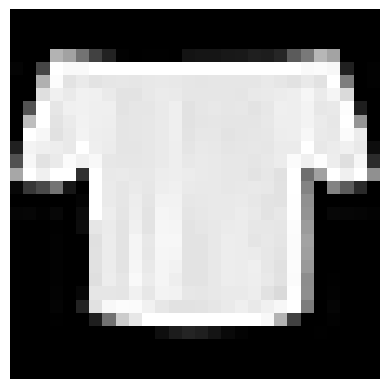

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


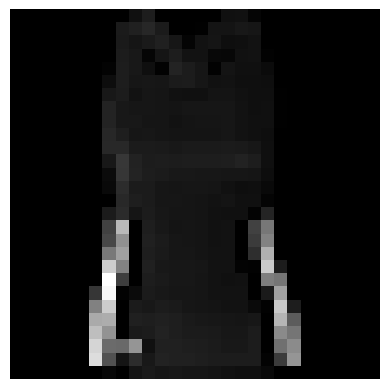

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


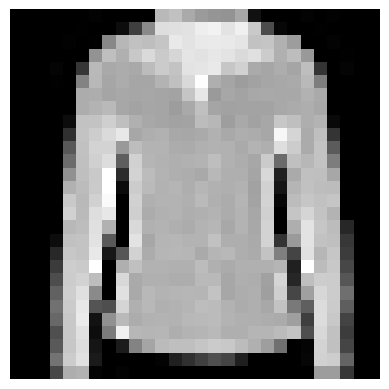

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


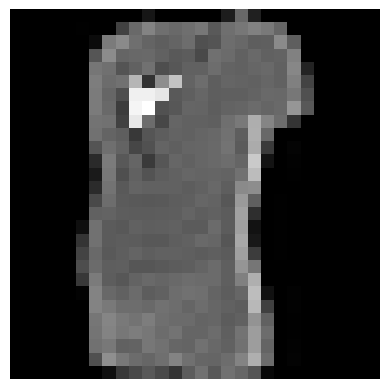

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


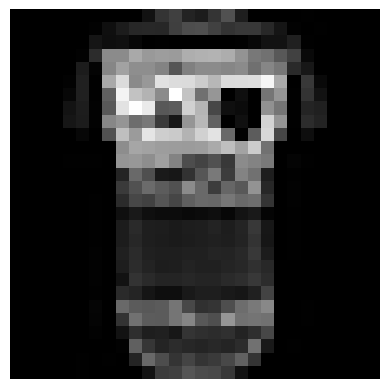

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


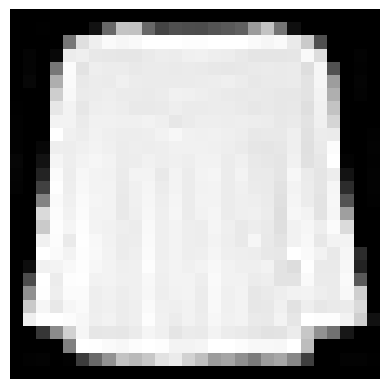

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


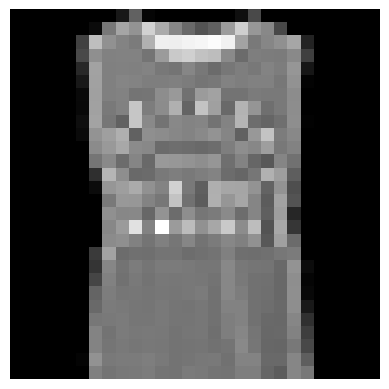

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


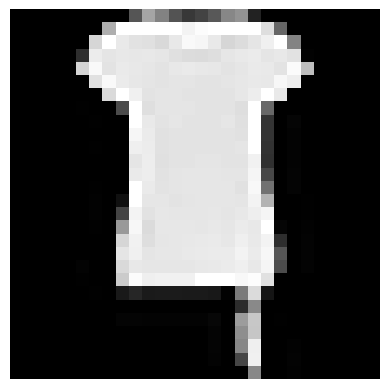

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


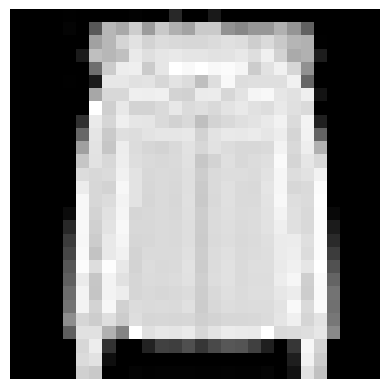

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


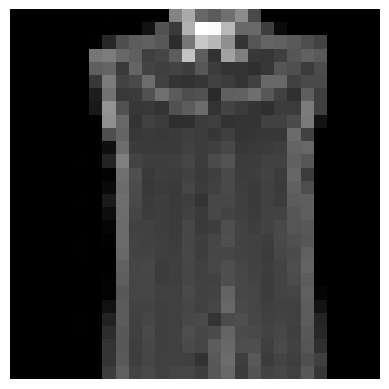

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


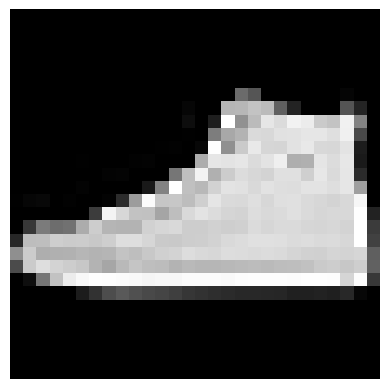

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


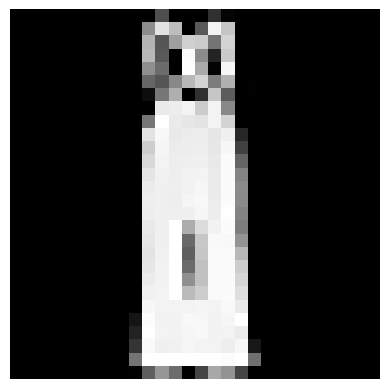

MLP label (ground-truth): Pullover (Bag)
VGG16 label (ground-truth): Bag (Bag)


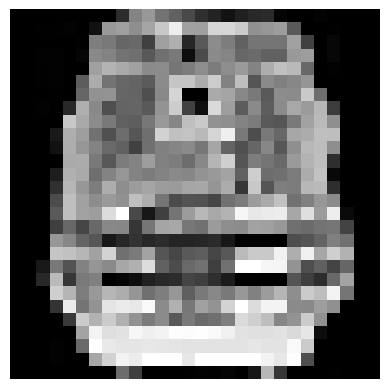

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


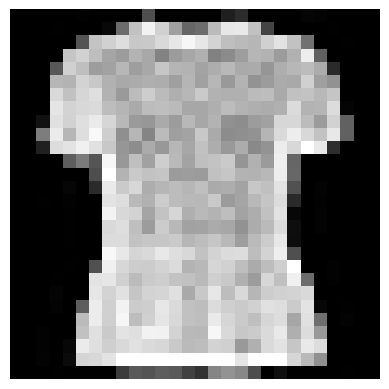

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


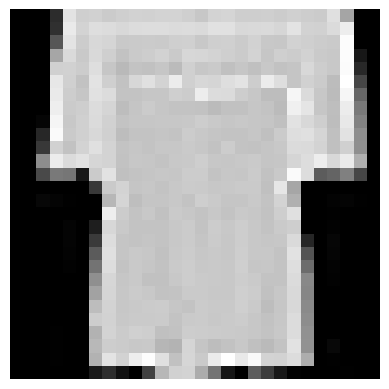

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


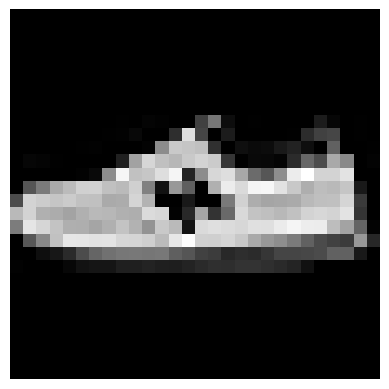

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


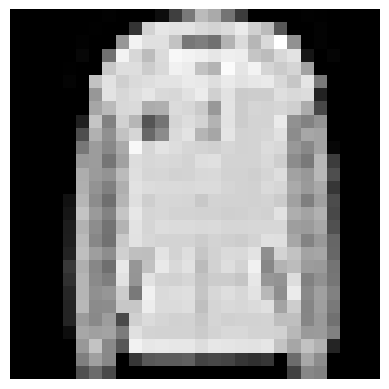

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


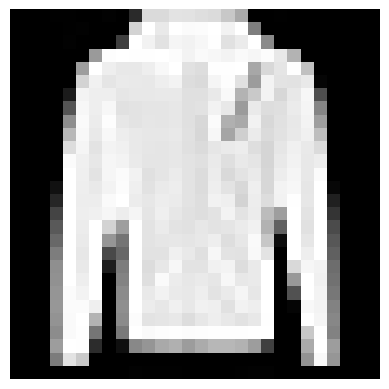

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


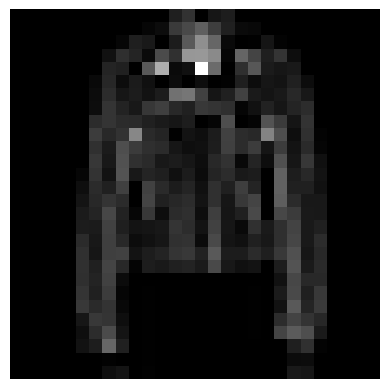

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


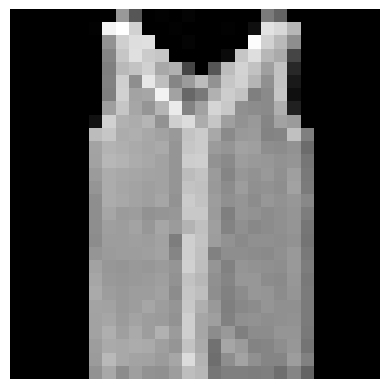

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


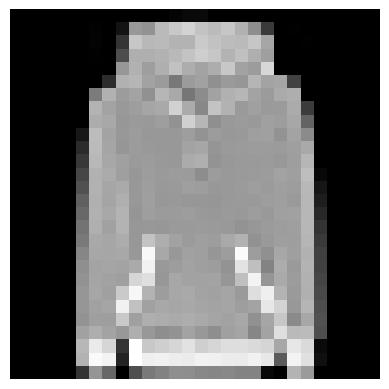

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


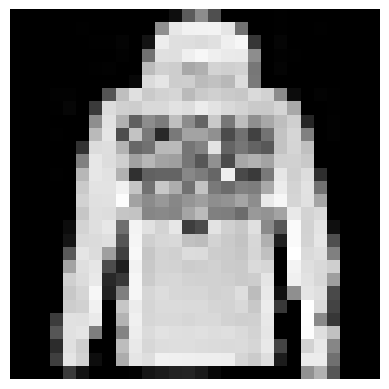

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


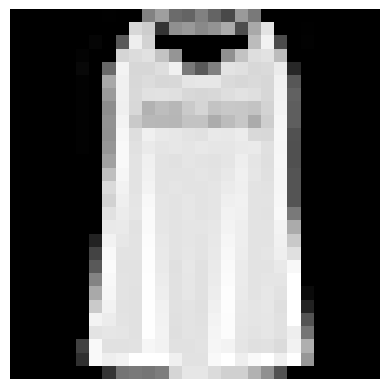

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


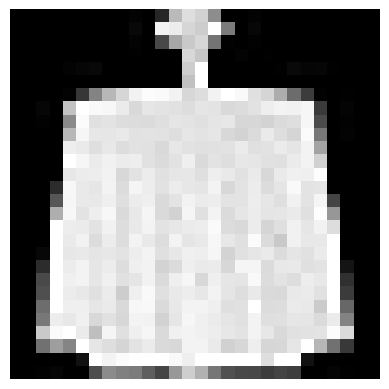

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


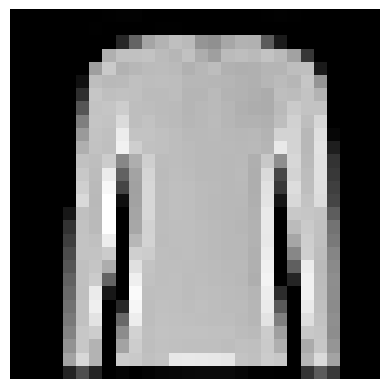

MLP label (ground-truth): T-shirt/top (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


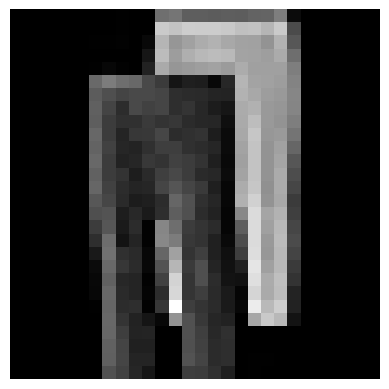

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


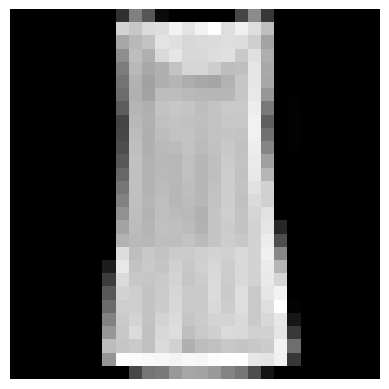

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


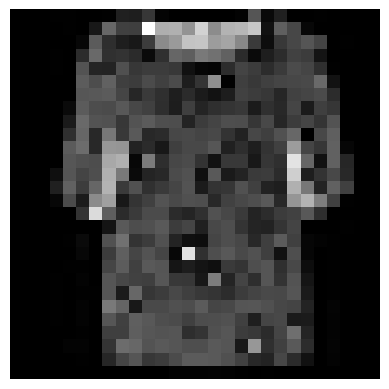

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


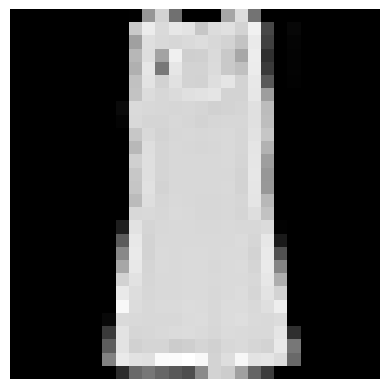

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


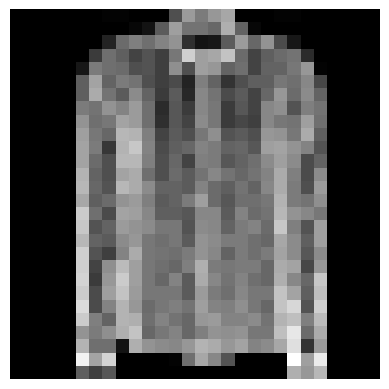

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


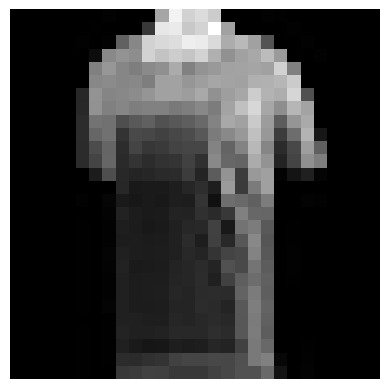

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


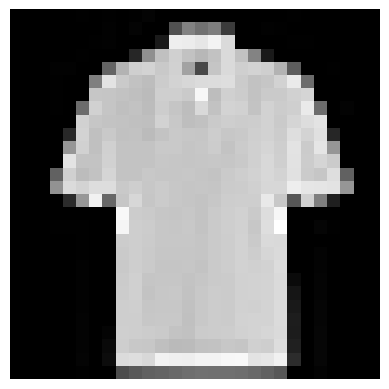

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


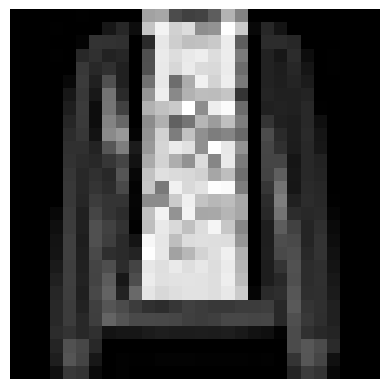

MLP label (ground-truth): Pullover (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


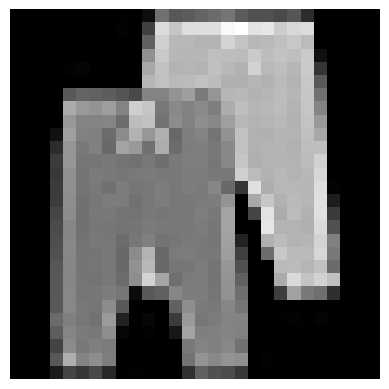

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


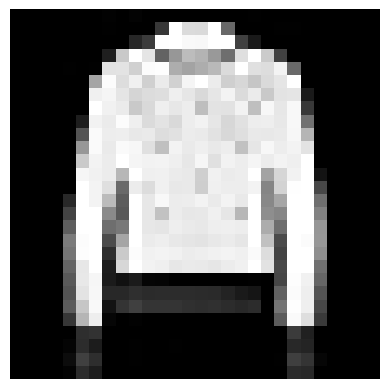

MLP label (ground-truth): Sandal (Bag)
VGG16 label (ground-truth): Bag (Bag)


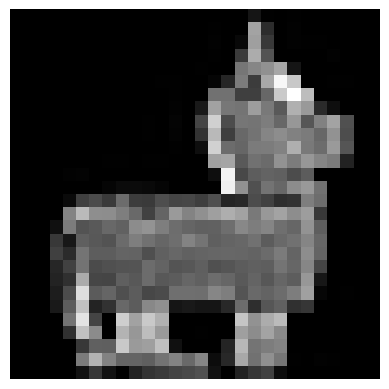

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


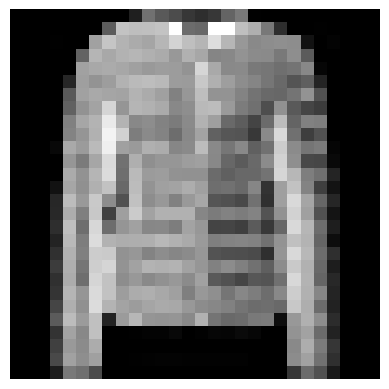

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


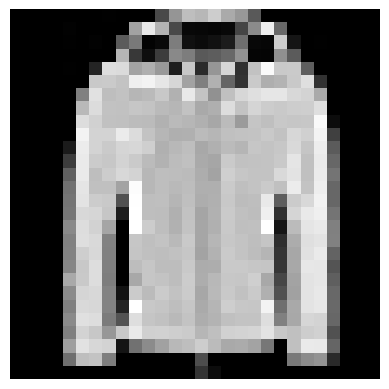

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


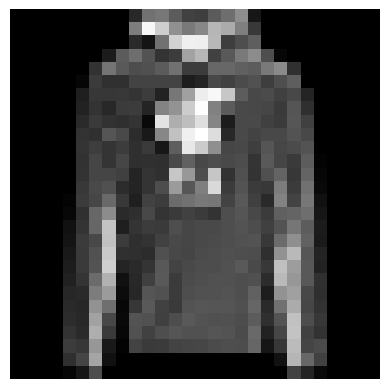

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


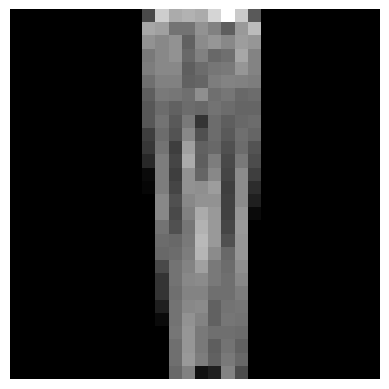

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


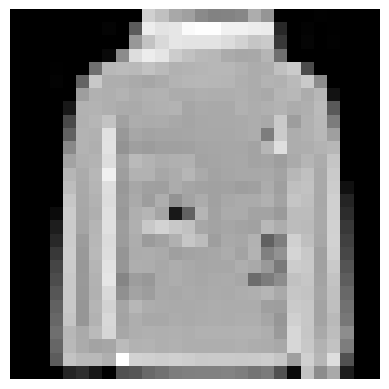

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


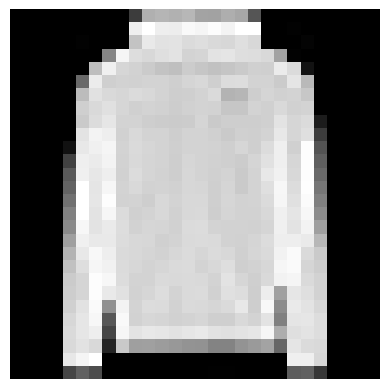

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


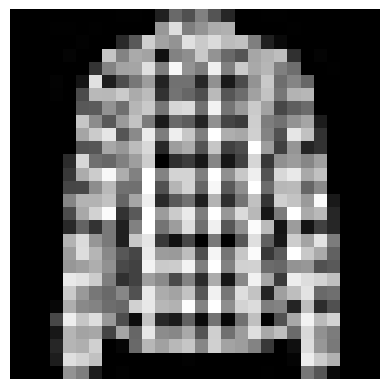

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


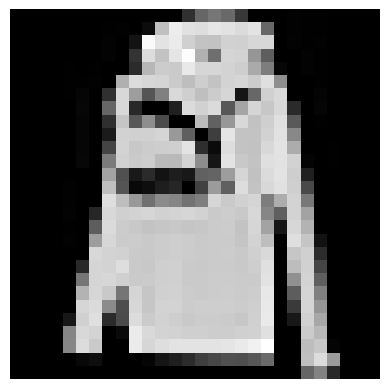

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


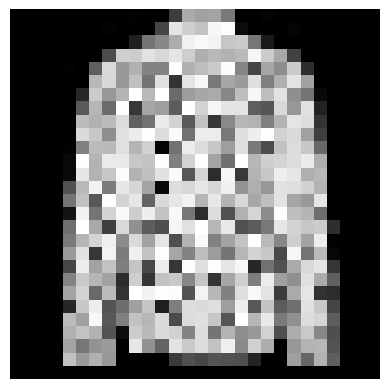

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


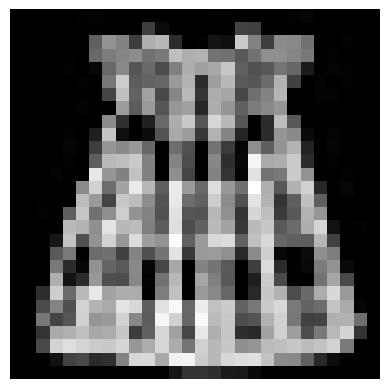

MLP label (ground-truth): Sandal (Bag)
VGG16 label (ground-truth): Bag (Bag)


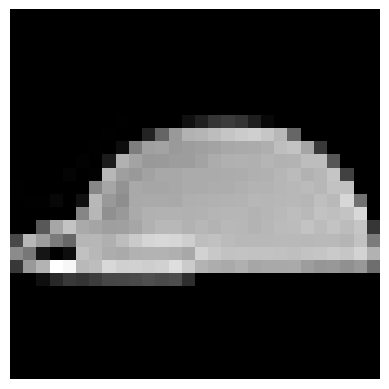

MLP label (ground-truth): Dress (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


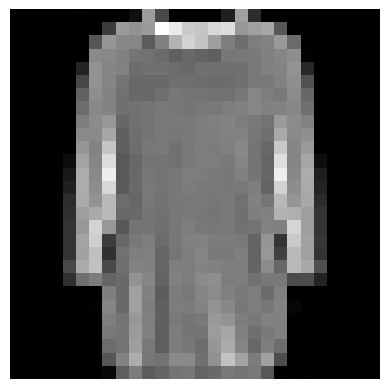

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


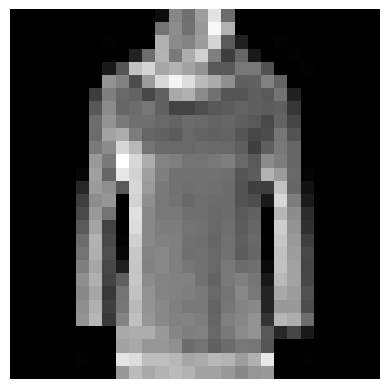

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


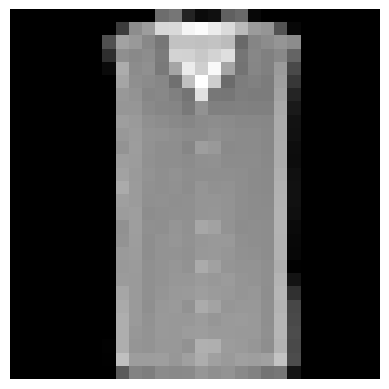

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


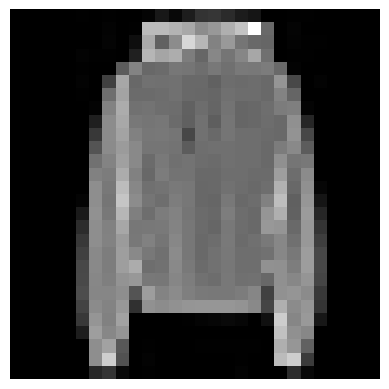

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


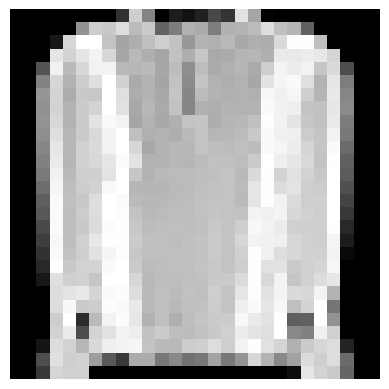

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


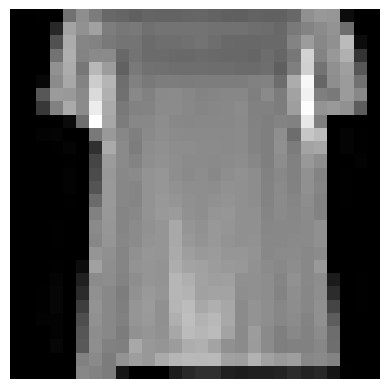

MLP label (ground-truth): Pullover (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


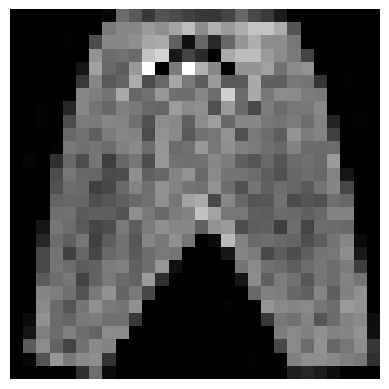

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


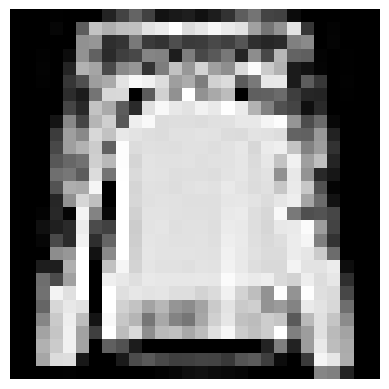

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


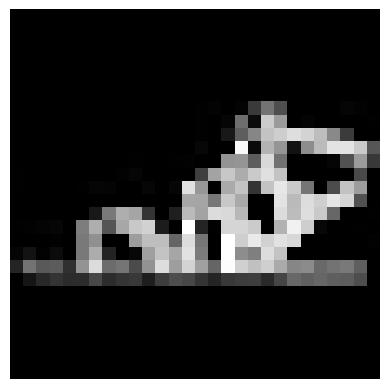

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


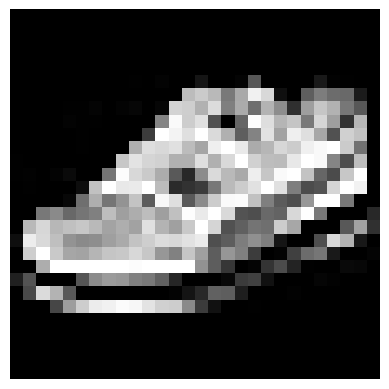

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


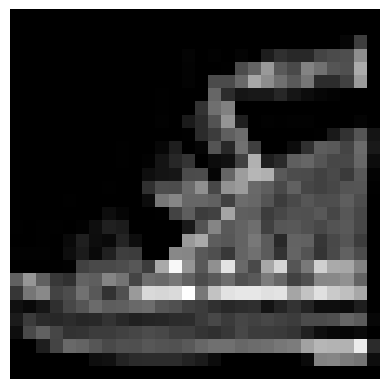

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


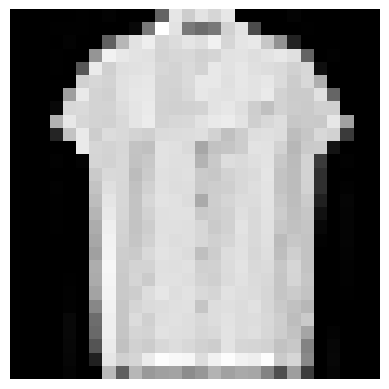

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


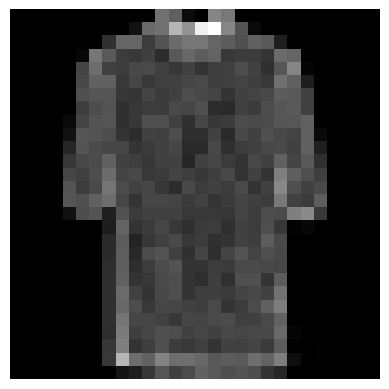

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


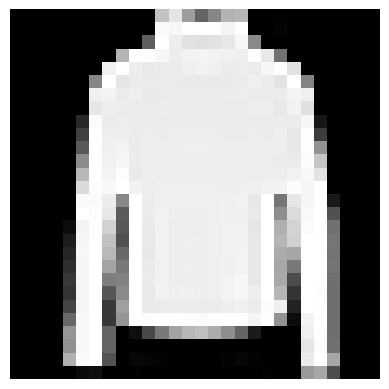

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


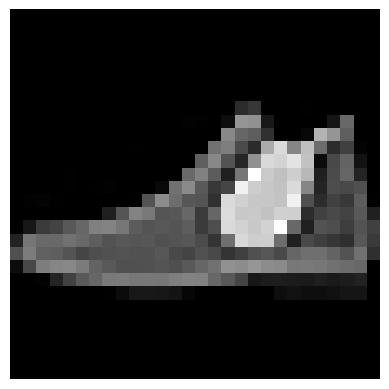

MLP label (ground-truth): Dress (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


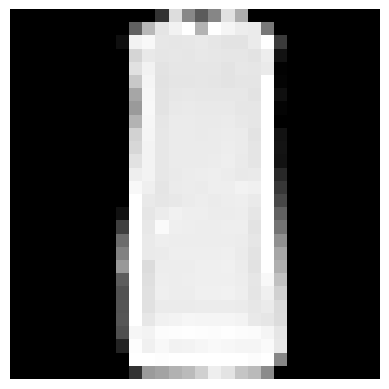

MLP label (ground-truth): Dress (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


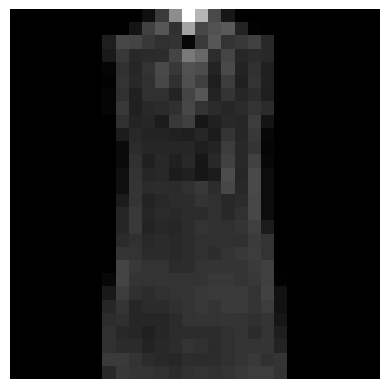

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


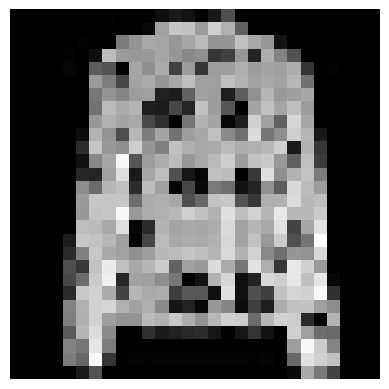

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


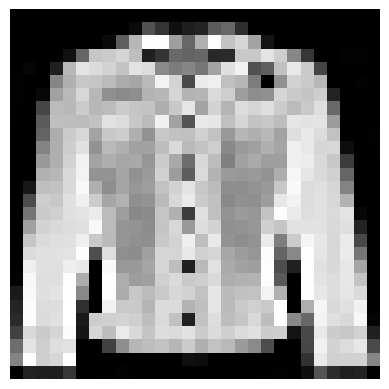

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


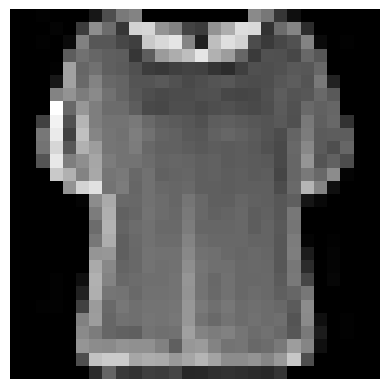

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


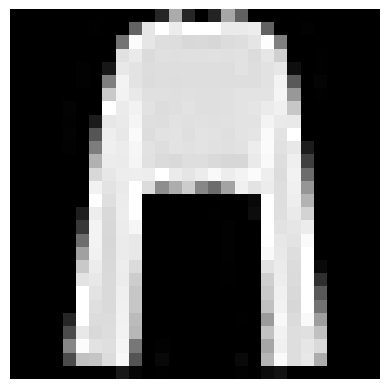

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


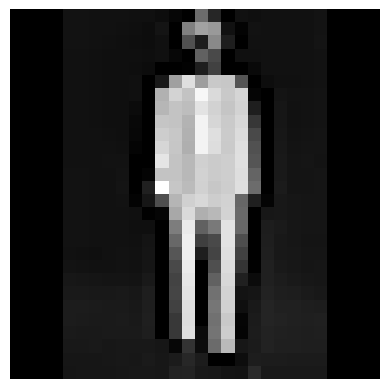

MLP label (ground-truth): T-shirt/top (Dress)
VGG16 label (ground-truth): Dress (Dress)


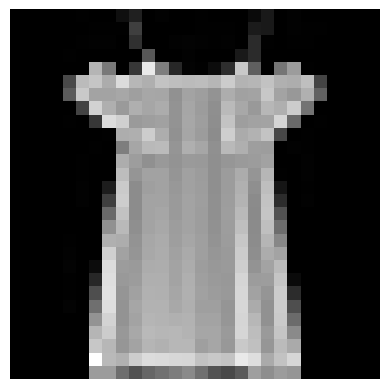

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


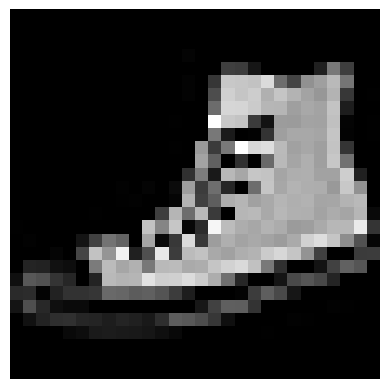

MLP label (ground-truth): Pullover (Bag)
VGG16 label (ground-truth): Bag (Bag)


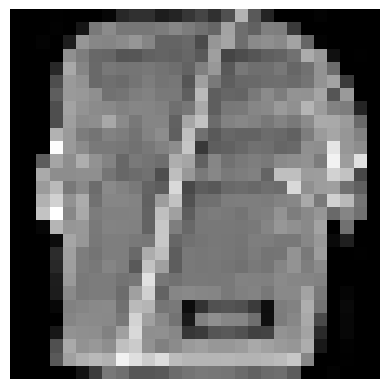

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


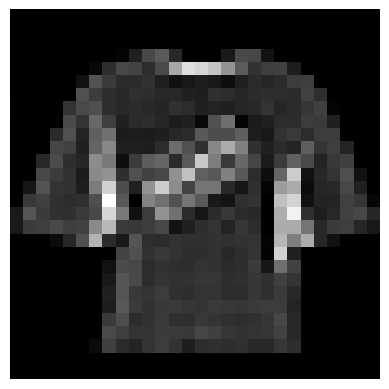

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


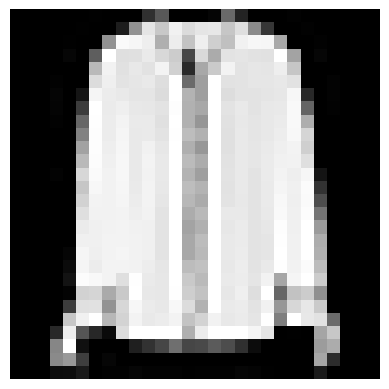

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


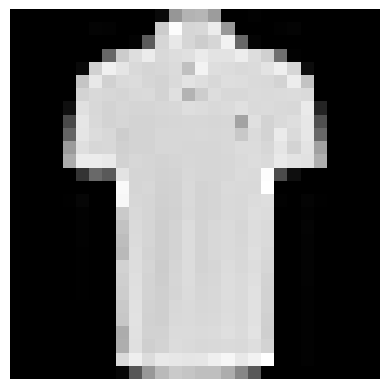

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


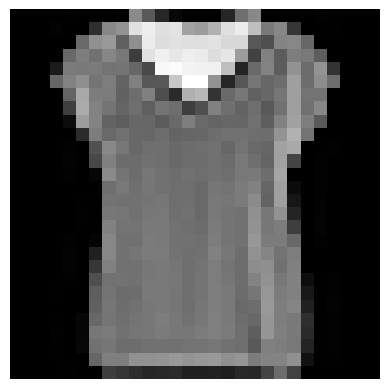

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


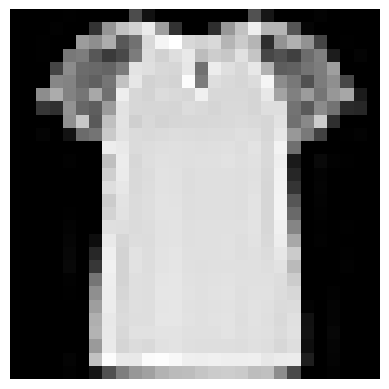

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


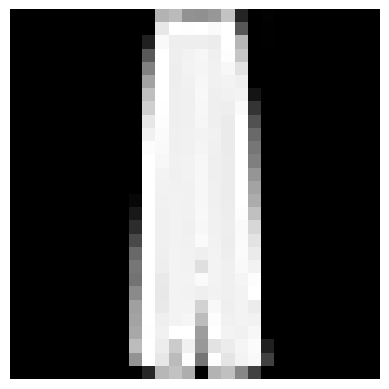

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


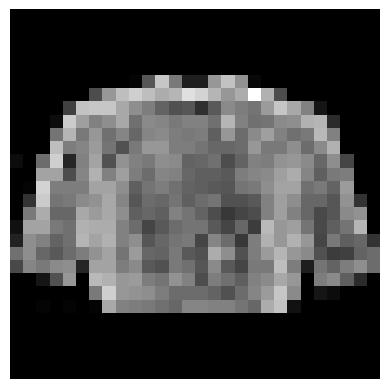

MLP label (ground-truth): Sneaker (Bag)
VGG16 label (ground-truth): Bag (Bag)


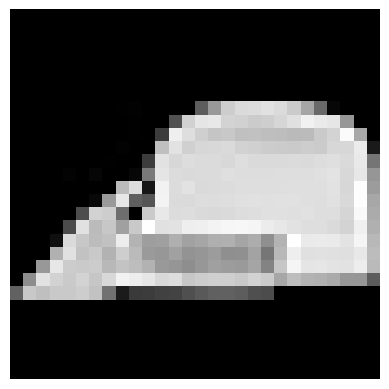

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


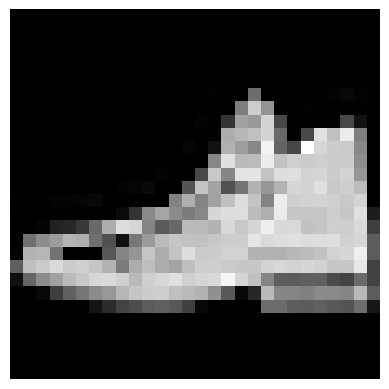

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


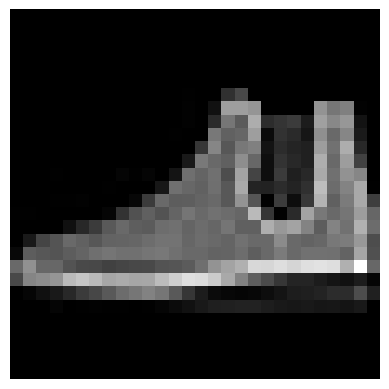

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


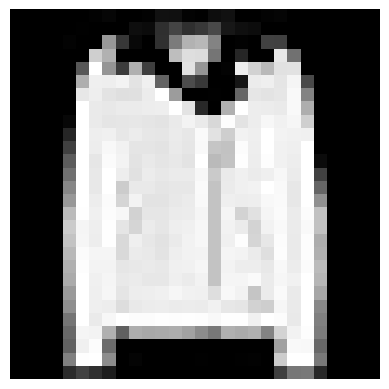

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


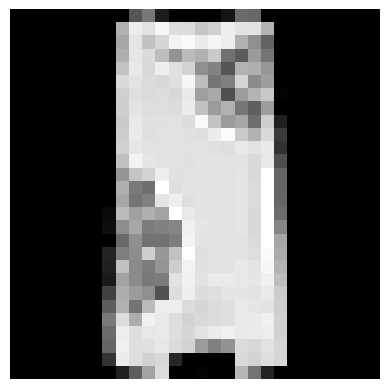

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


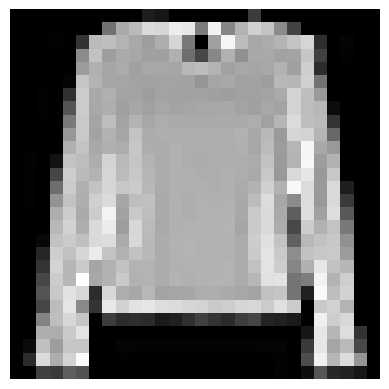

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


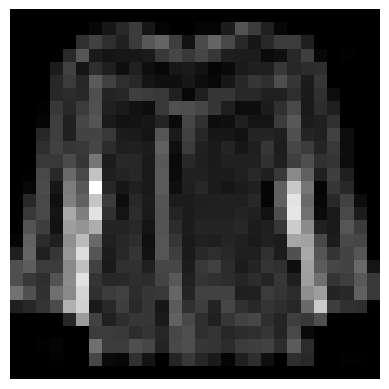

MLP label (ground-truth): Pullover (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


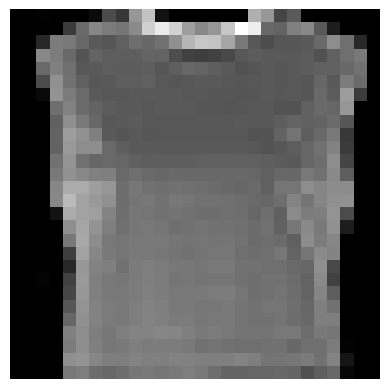

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


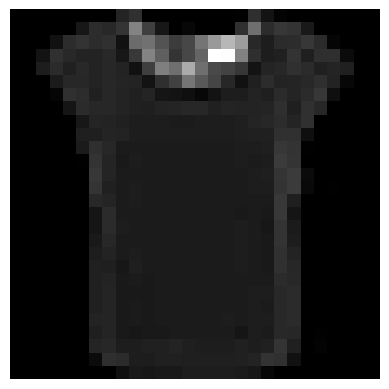

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


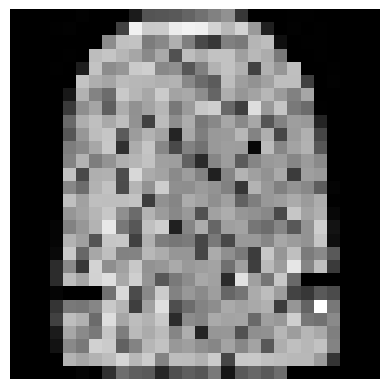

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


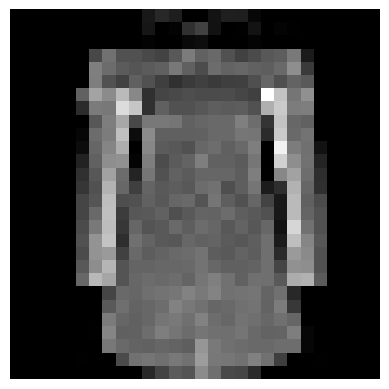

MLP label (ground-truth): Dress (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


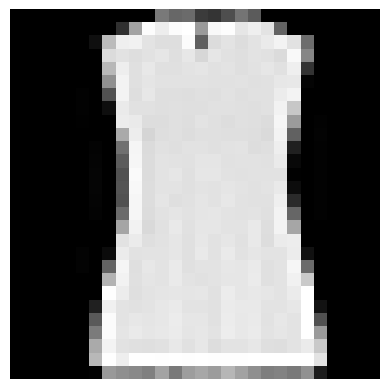

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


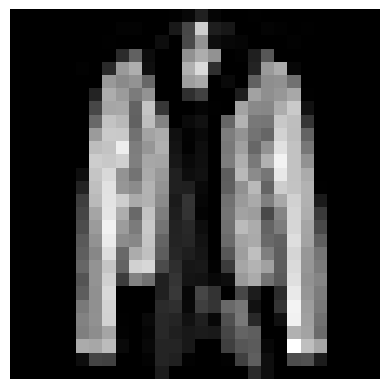

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


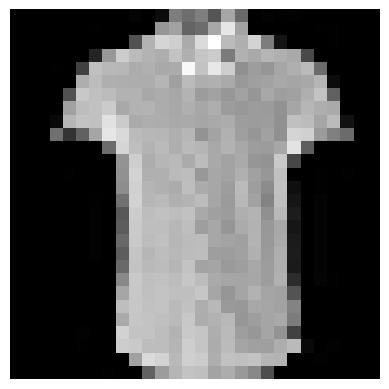

MLP label (ground-truth): Dress (Bag)
VGG16 label (ground-truth): Bag (Bag)


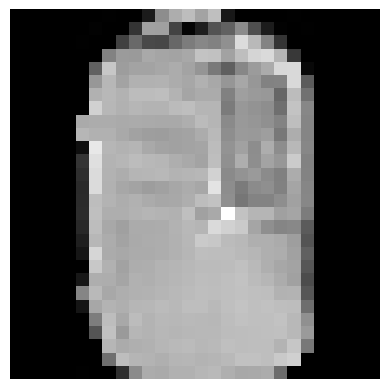

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


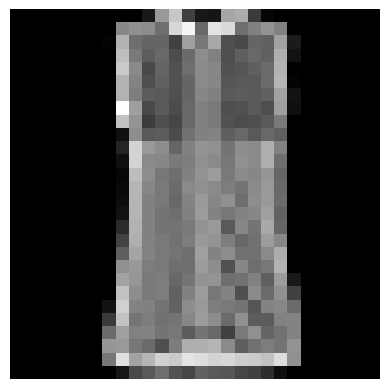

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


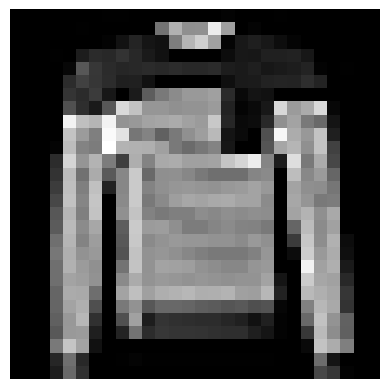

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


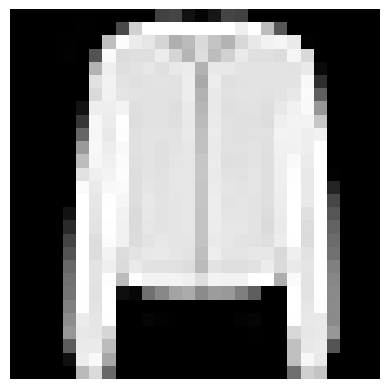

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


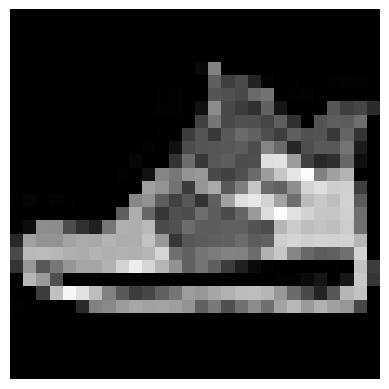

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


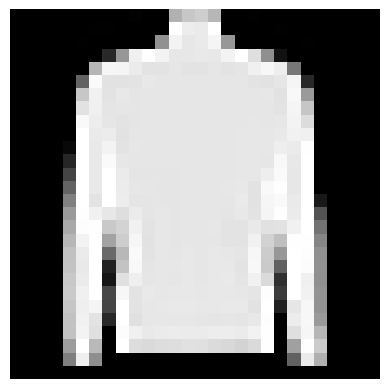

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


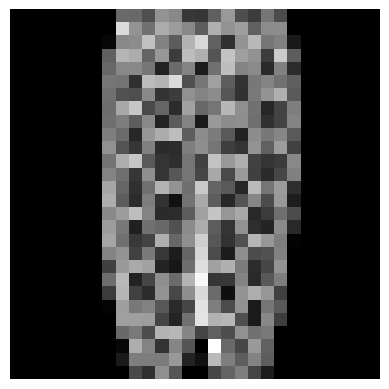

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


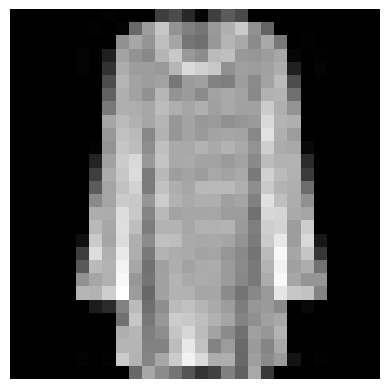

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


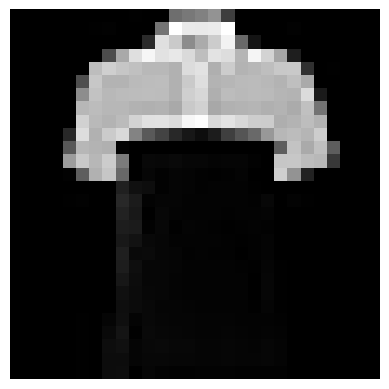

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


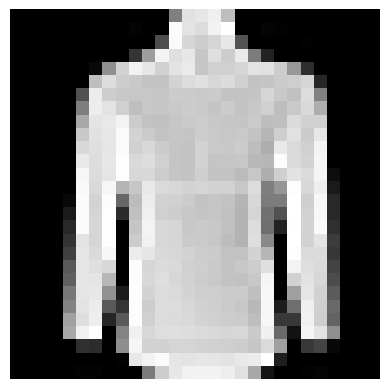

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


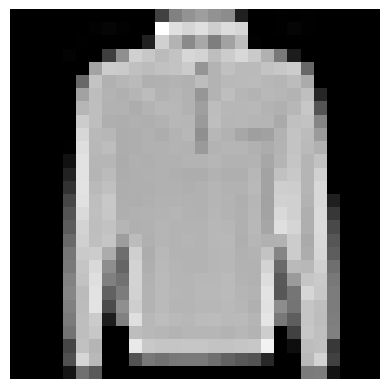

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


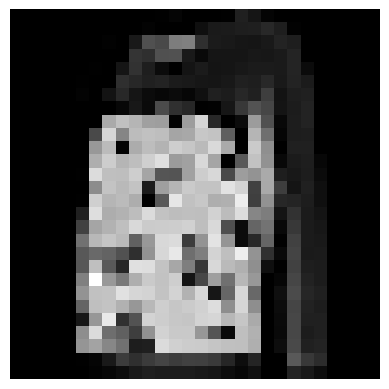

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


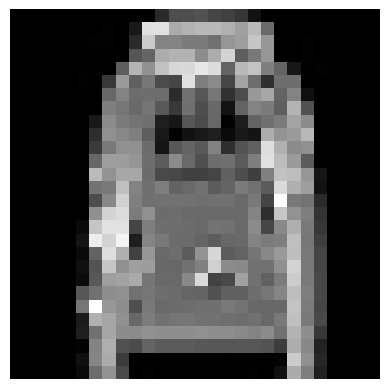

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


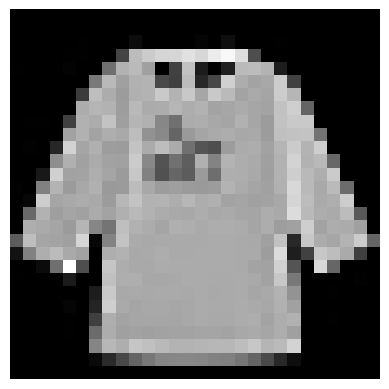

MLP label (ground-truth): Pullover (Dress)
VGG16 label (ground-truth): Dress (Dress)


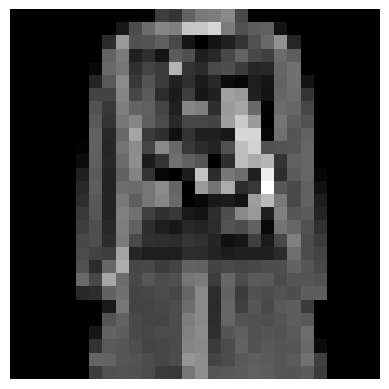

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


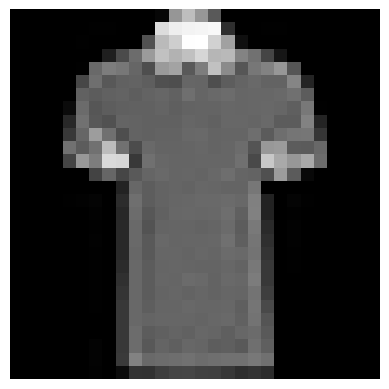

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


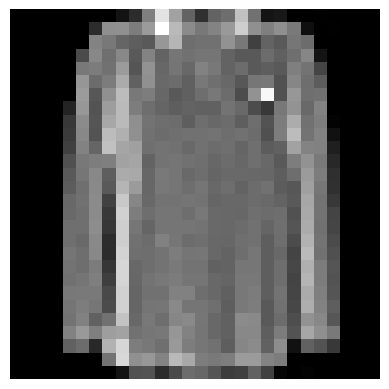

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


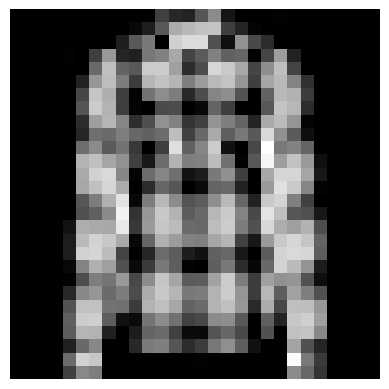

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


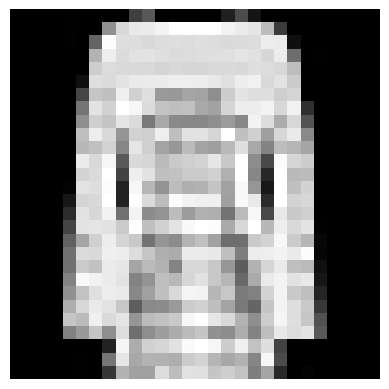

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


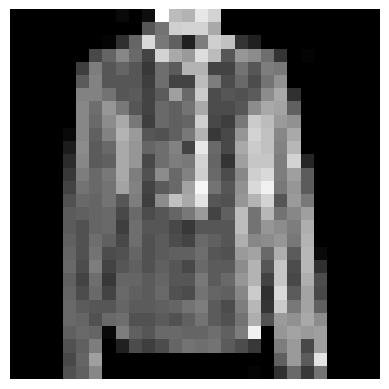

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


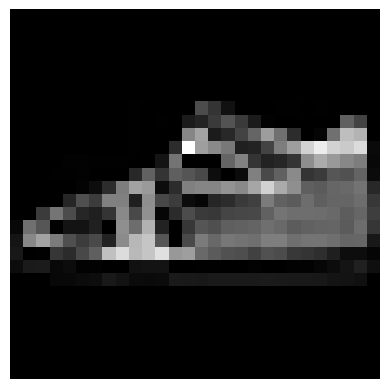

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


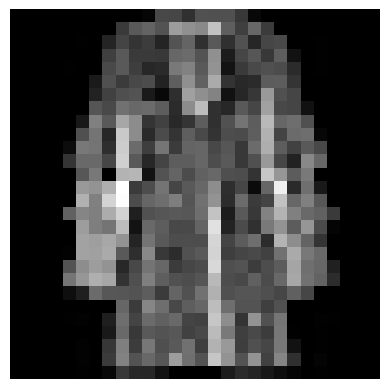

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


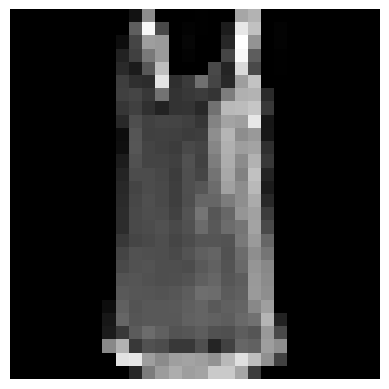

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


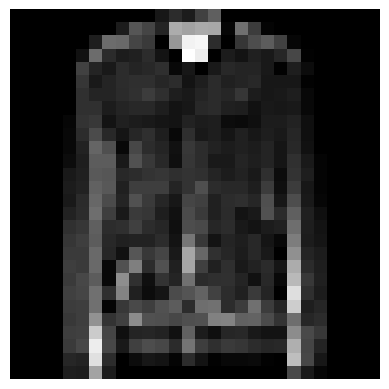

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


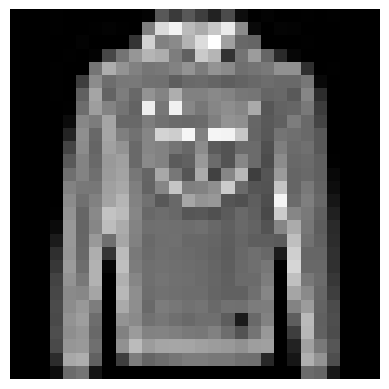

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


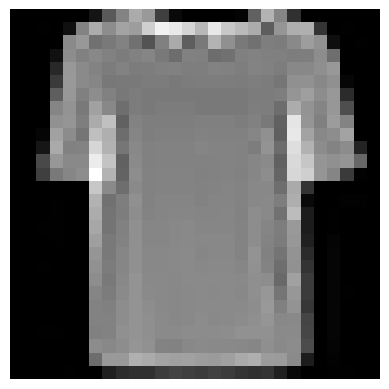

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


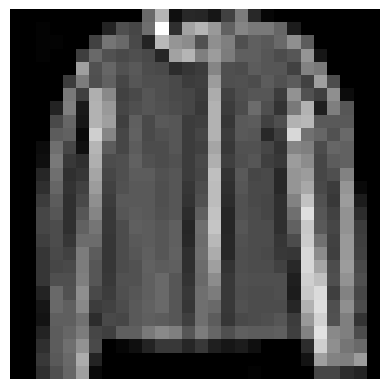

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


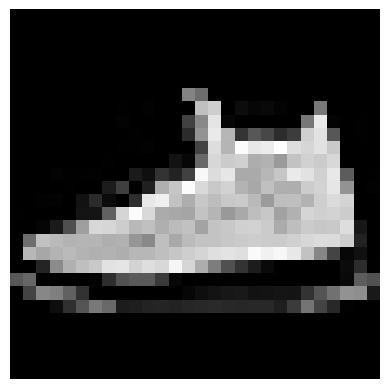

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


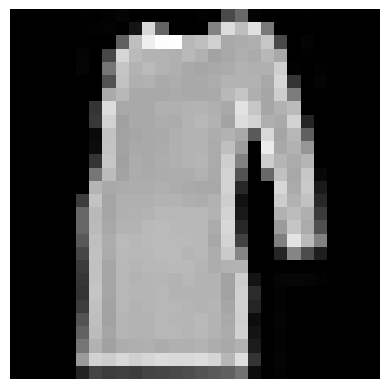

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


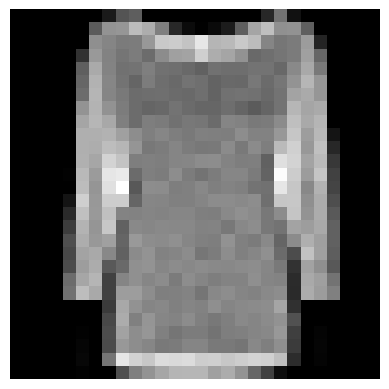

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


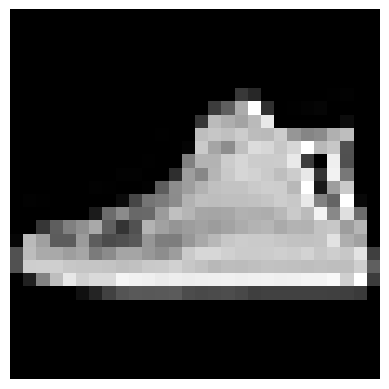

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


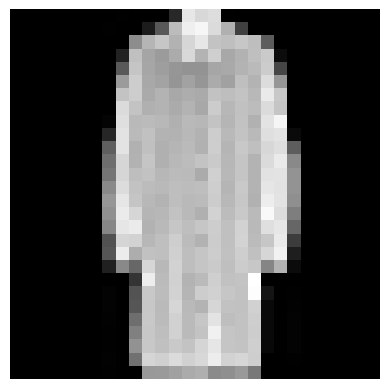

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


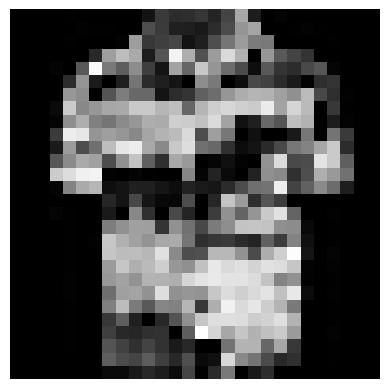

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


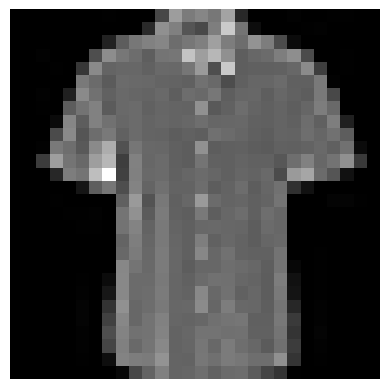

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


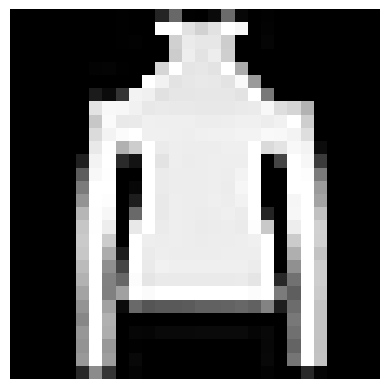

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


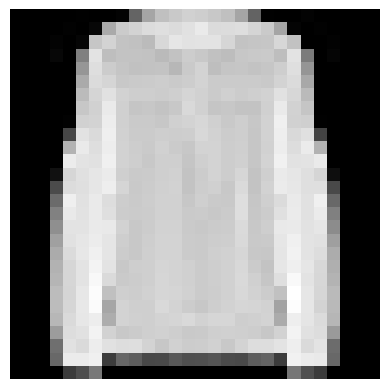

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


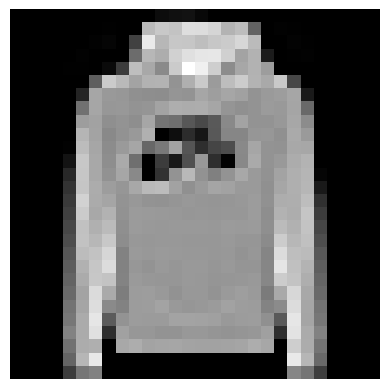

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


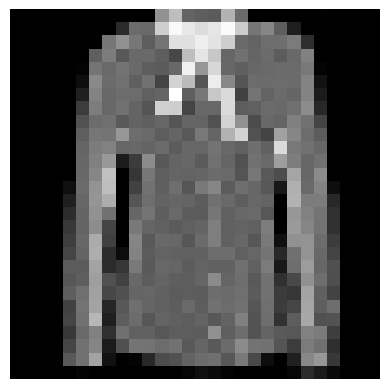

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


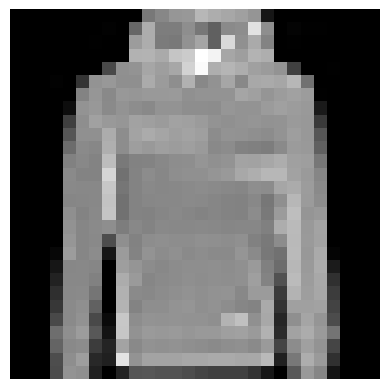

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


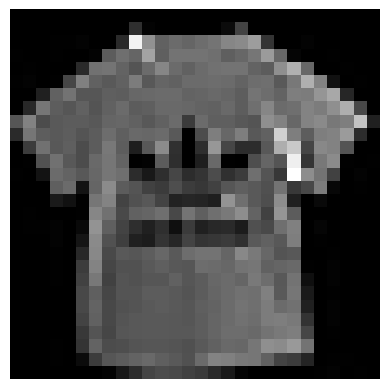

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


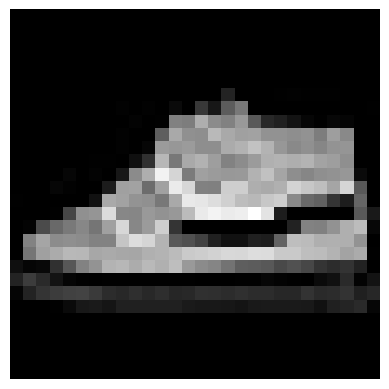

MLP label (ground-truth): Bag (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


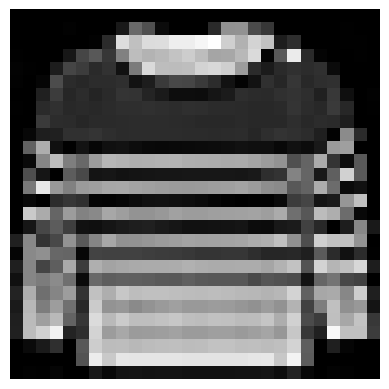

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


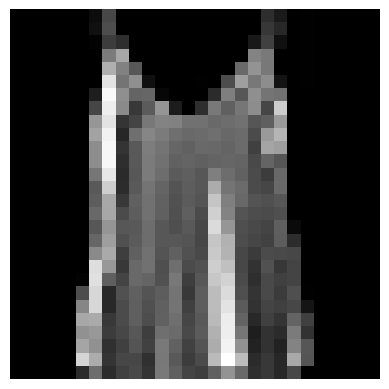

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


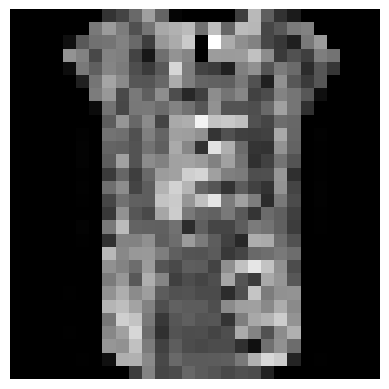

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


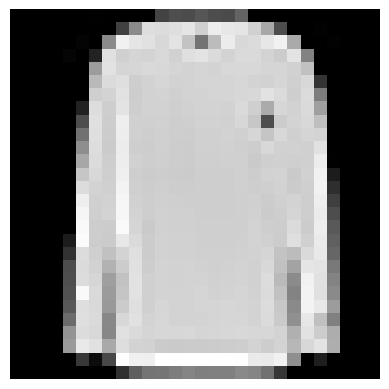

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


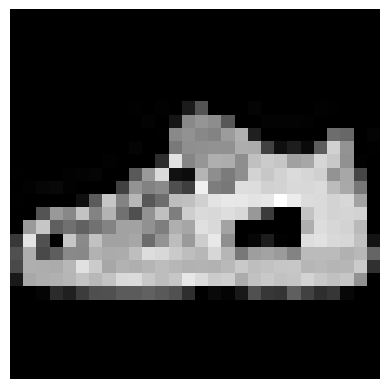

MLP label (ground-truth): Coat (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


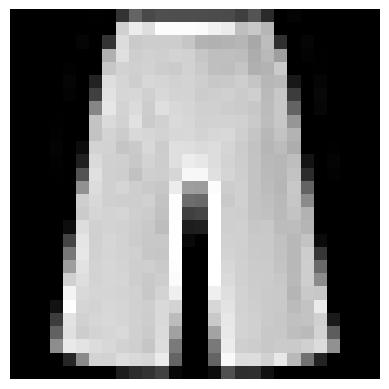

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


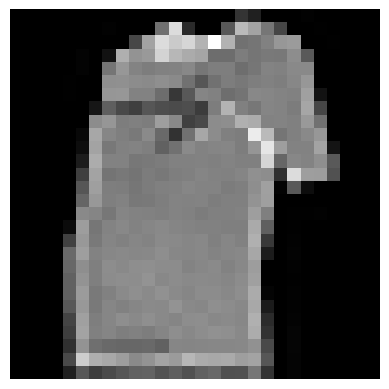

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


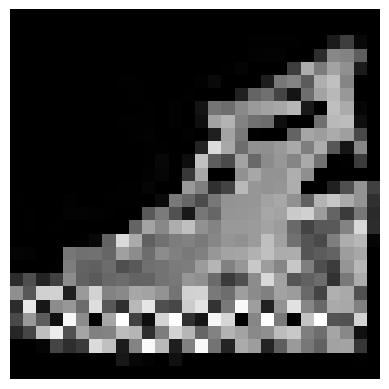

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


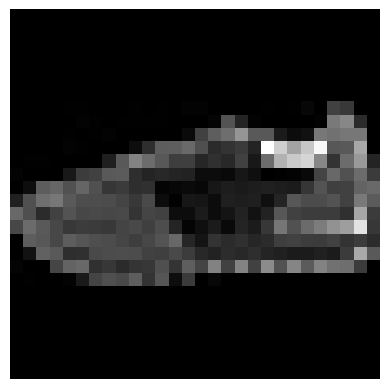

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


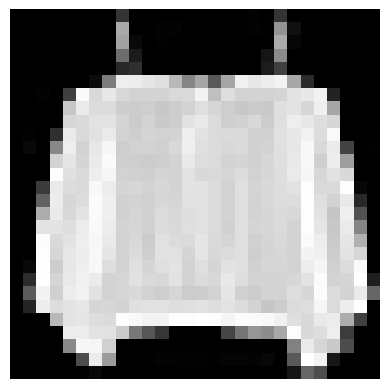

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


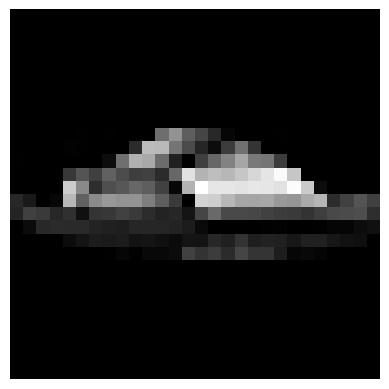

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


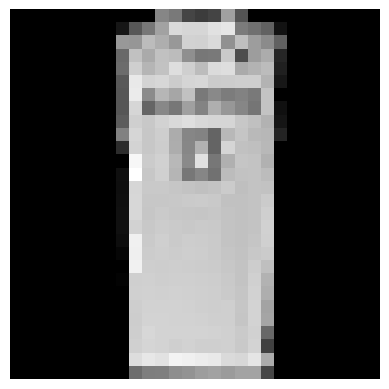

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


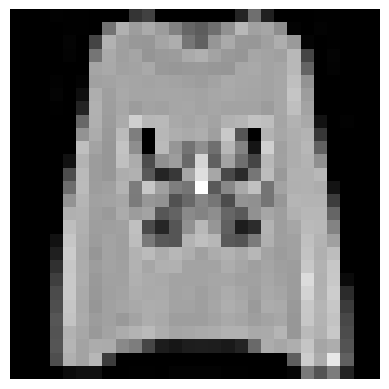

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


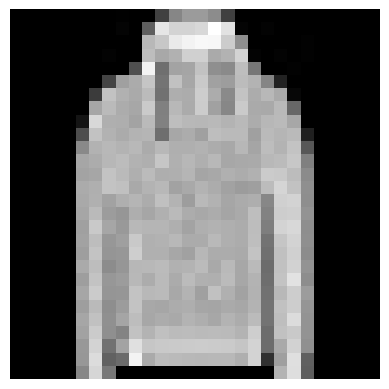

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


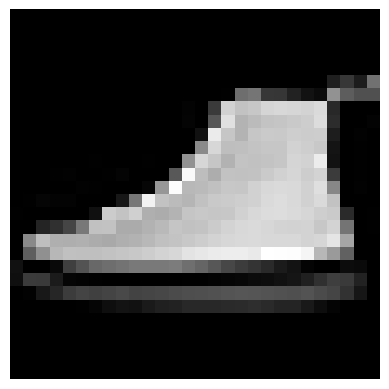

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


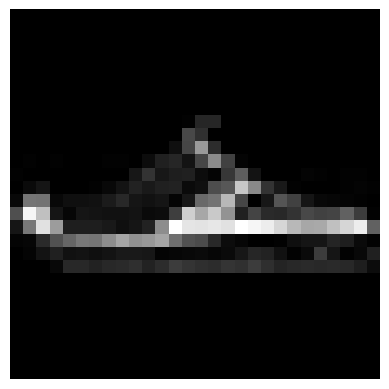

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


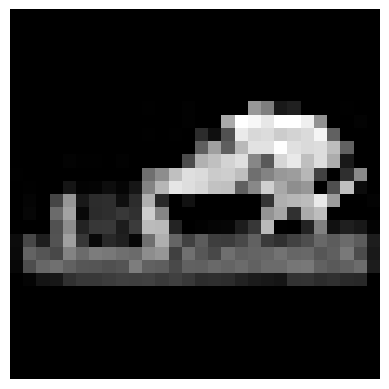

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


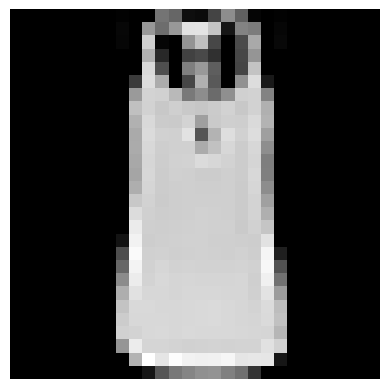

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


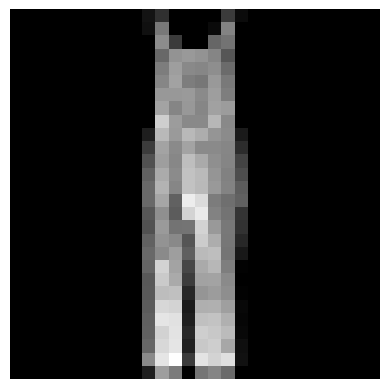

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


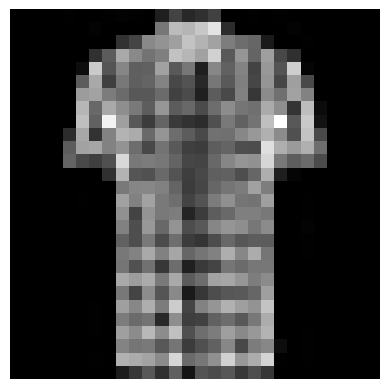

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


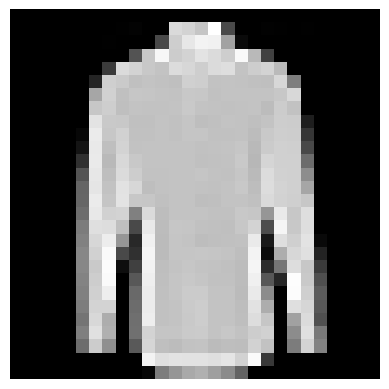

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


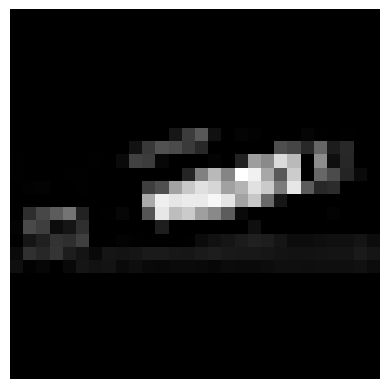

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


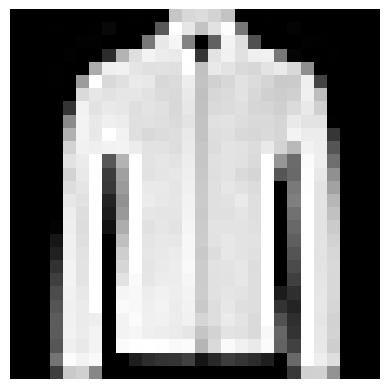

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


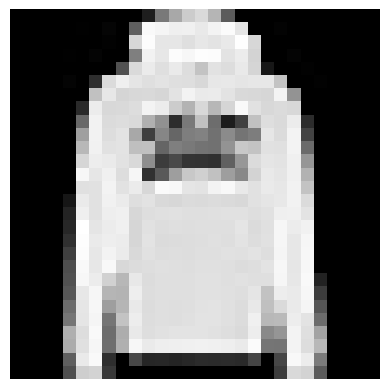

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


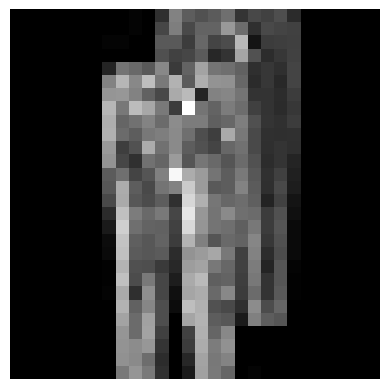

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


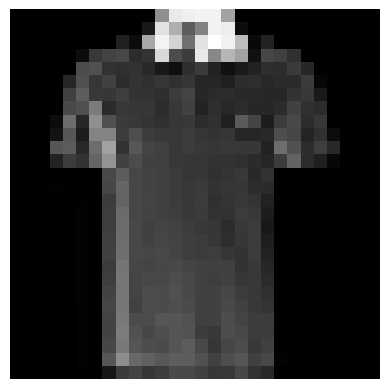

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


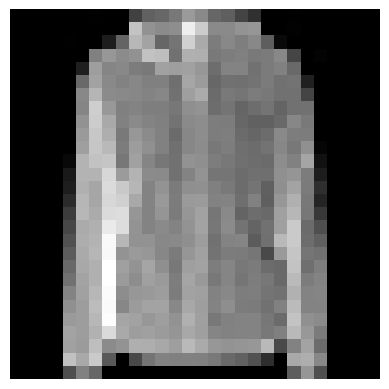

MLP label (ground-truth): T-shirt/top (Bag)
VGG16 label (ground-truth): Bag (Bag)


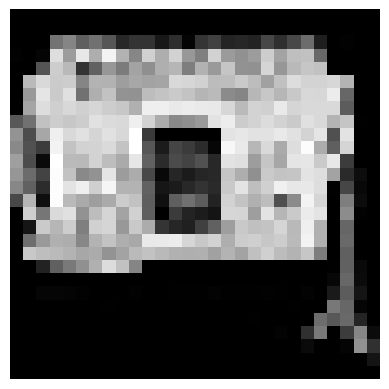

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


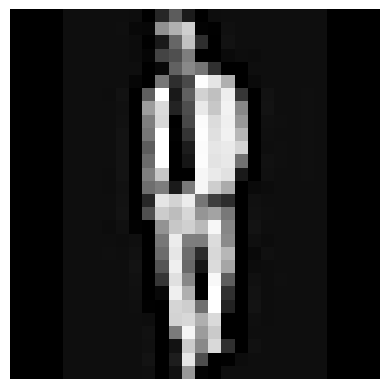

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


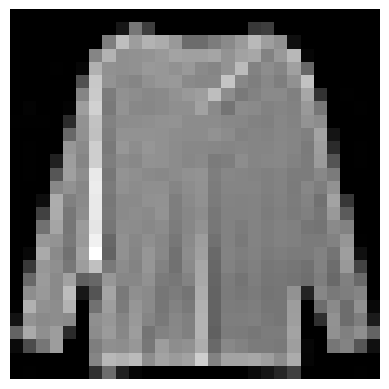

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


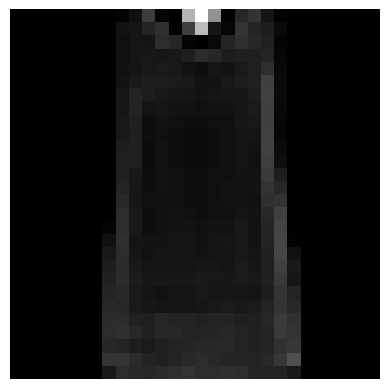

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


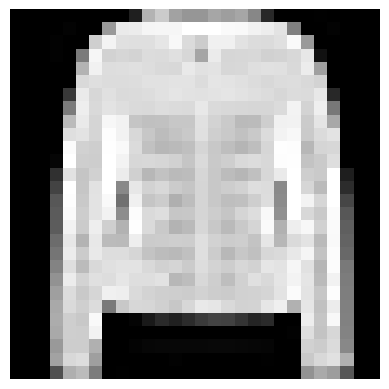

MLP label (ground-truth): Trouser (Dress)
VGG16 label (ground-truth): Dress (Dress)


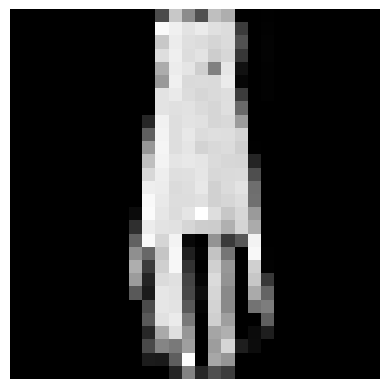

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


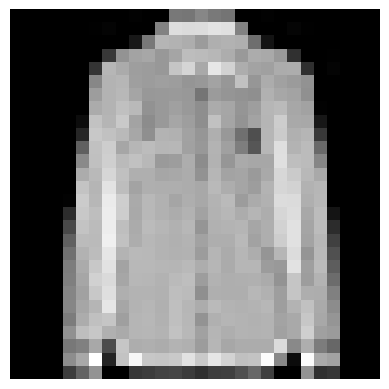

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


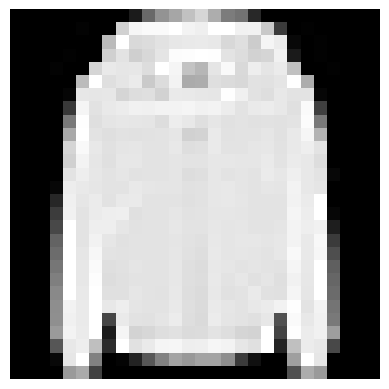

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


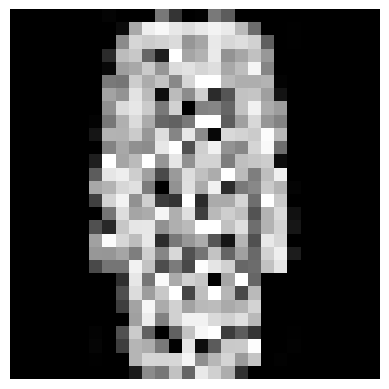

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


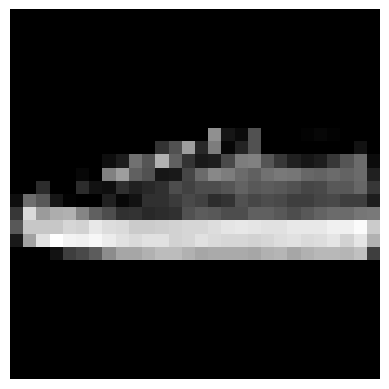

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


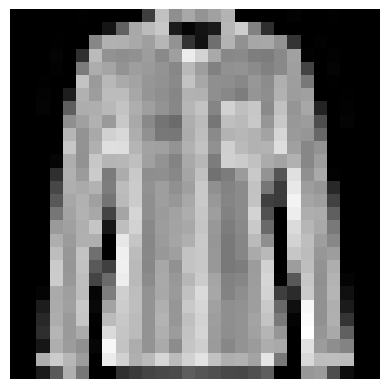

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


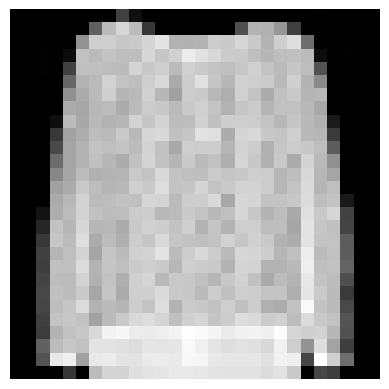

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


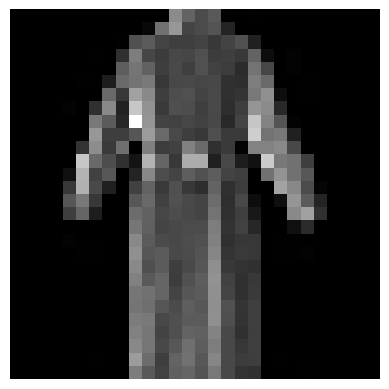

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


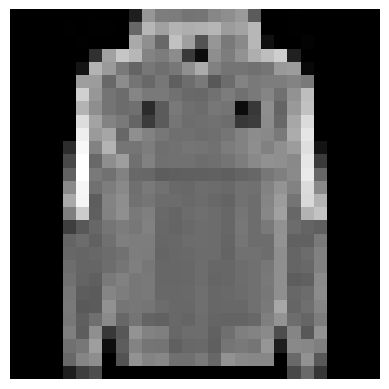

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


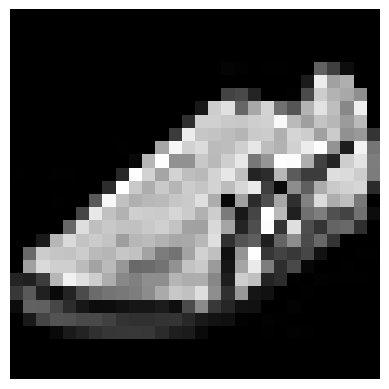

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


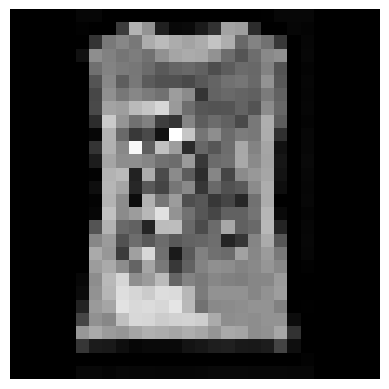

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


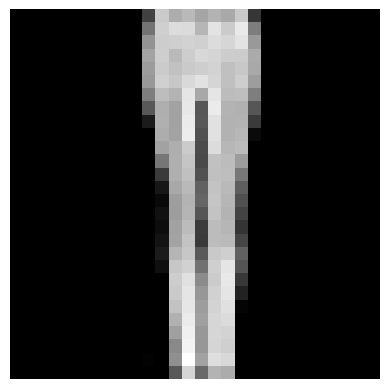

MLP label (ground-truth): Shirt (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


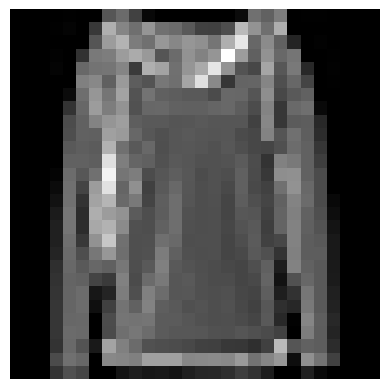

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


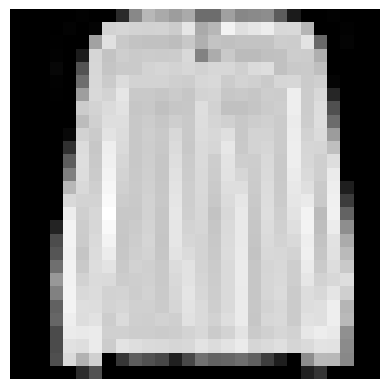

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


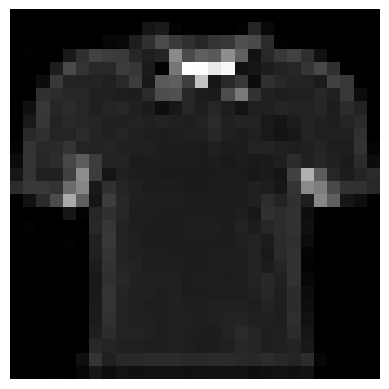

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


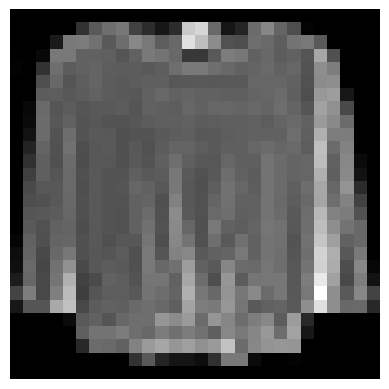

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


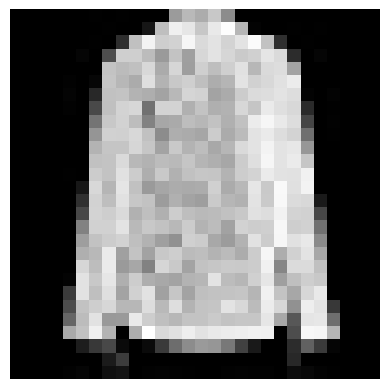

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


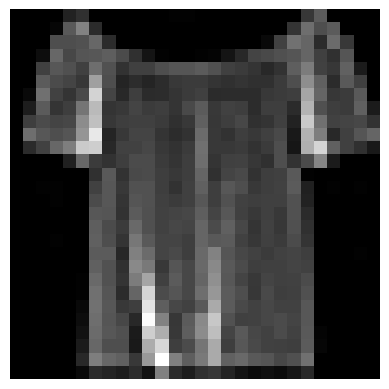

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


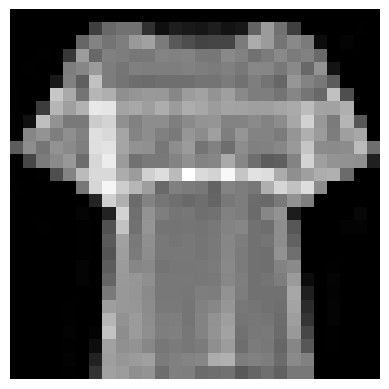

MLP label (ground-truth): Dress (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


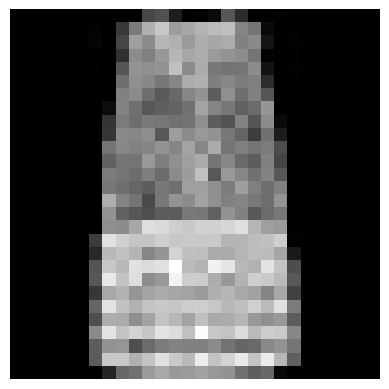

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


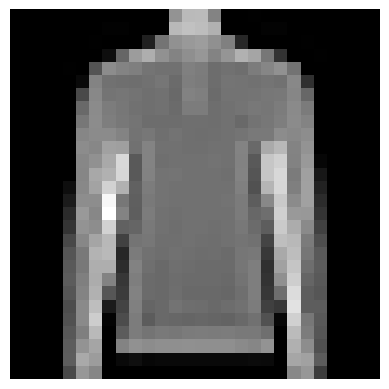

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


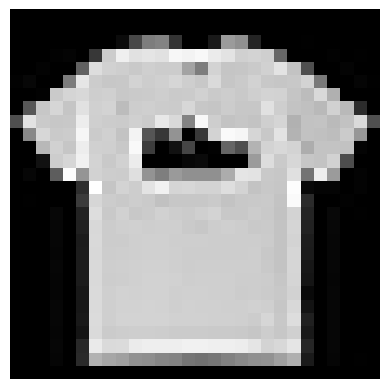

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


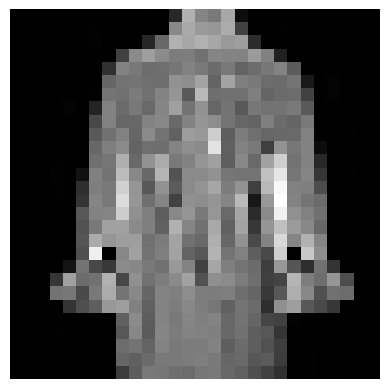

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


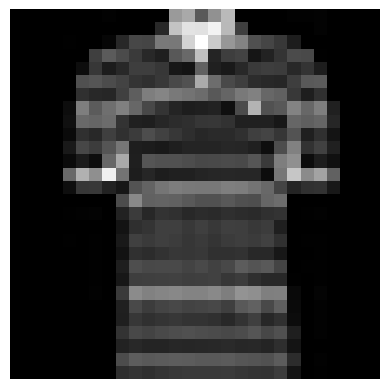

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


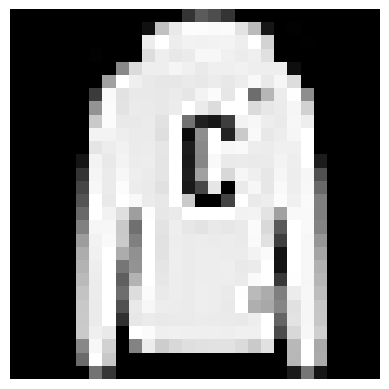

MLP label (ground-truth): Pullover (Bag)
VGG16 label (ground-truth): Bag (Bag)


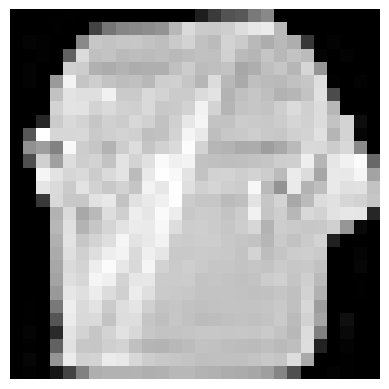

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


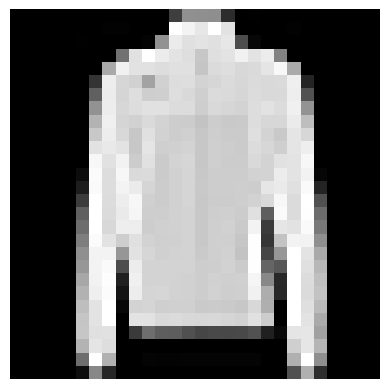

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


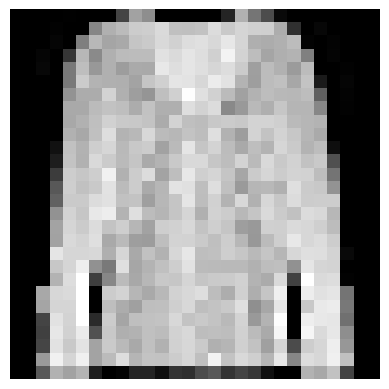

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


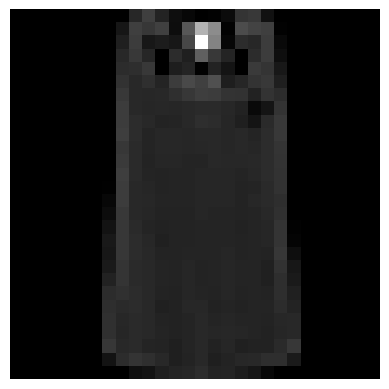

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


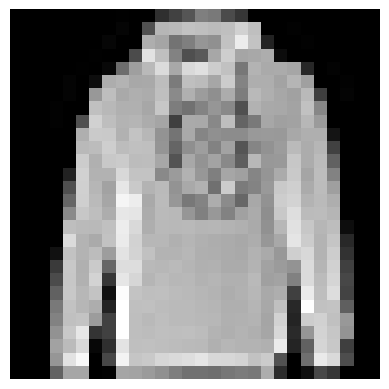

MLP label (ground-truth): T-shirt/top (Dress)
VGG16 label (ground-truth): Dress (Dress)


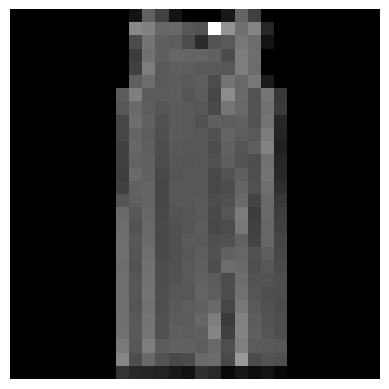

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


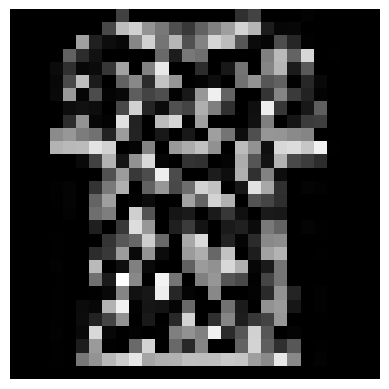

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


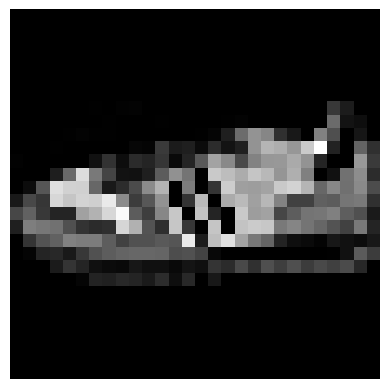

MLP label (ground-truth): Bag (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


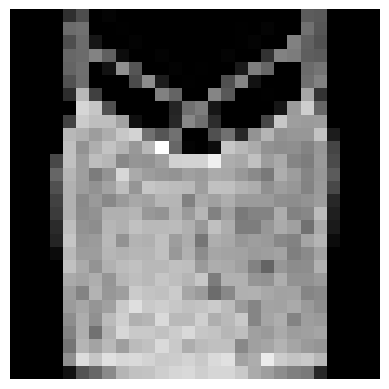

MLP label (ground-truth): Coat (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


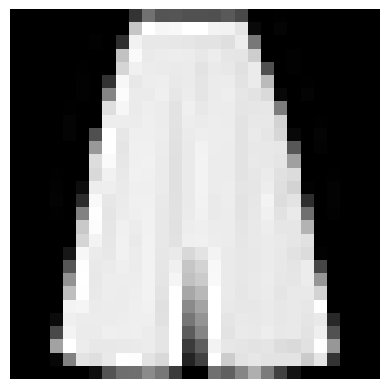

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


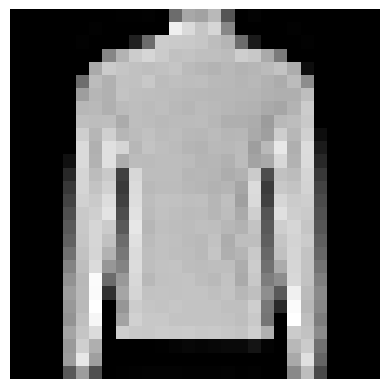

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


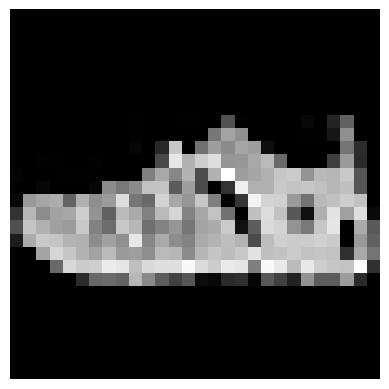

MLP label (ground-truth): T-shirt/top (Dress)
VGG16 label (ground-truth): Dress (Dress)


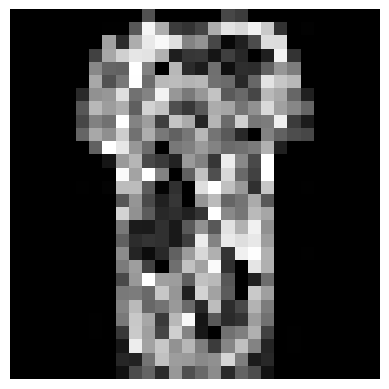

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


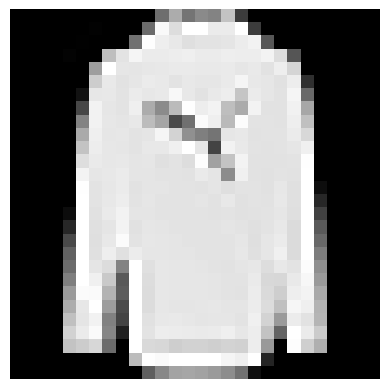

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


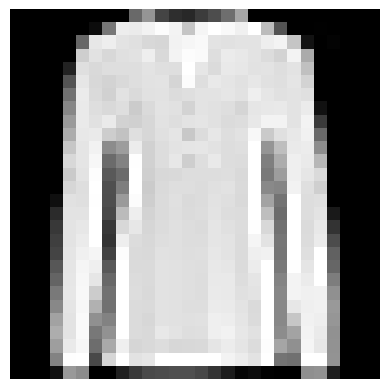

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


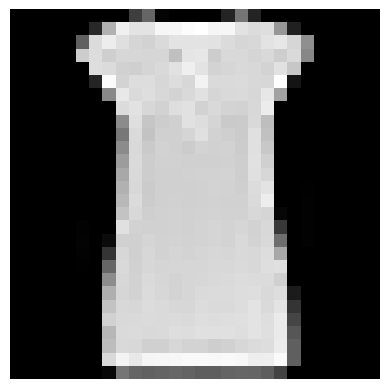

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


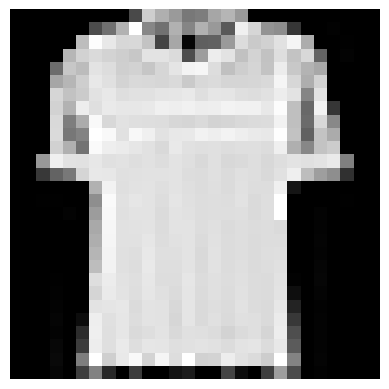

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


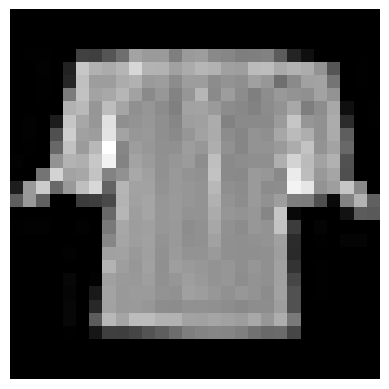

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


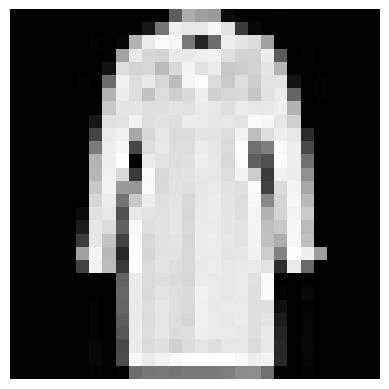

MLP label (ground-truth): Trouser (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


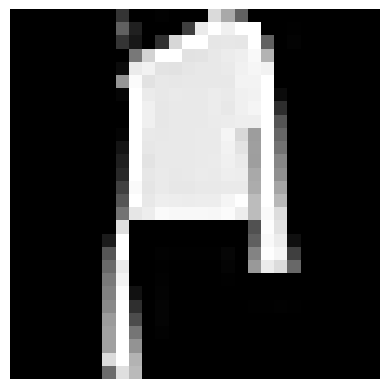

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


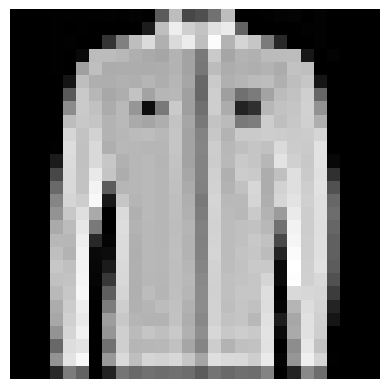

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


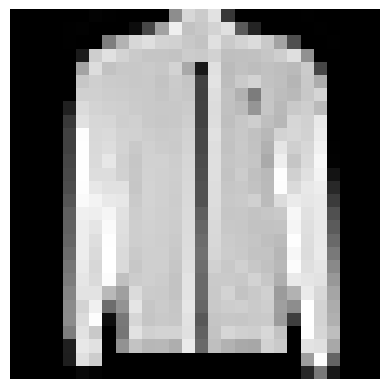

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


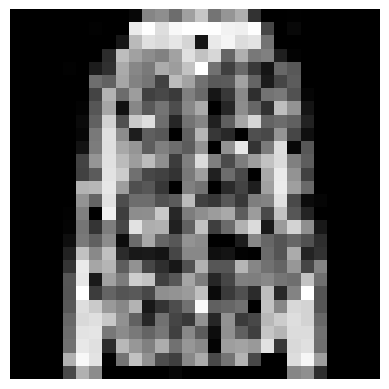

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


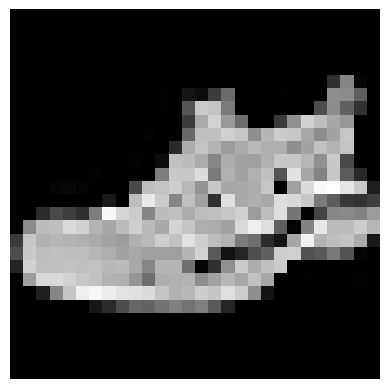

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


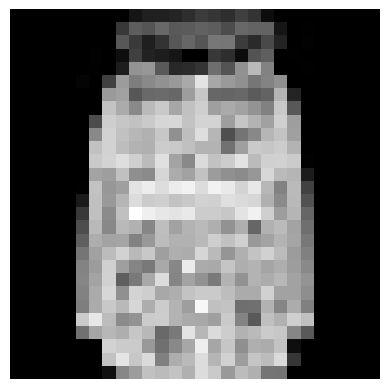

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


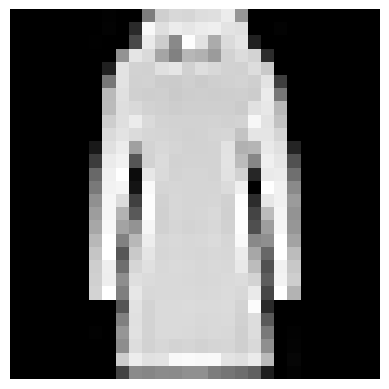

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


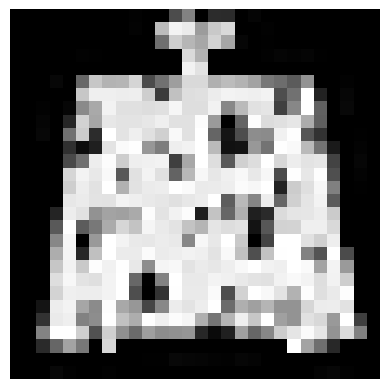

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


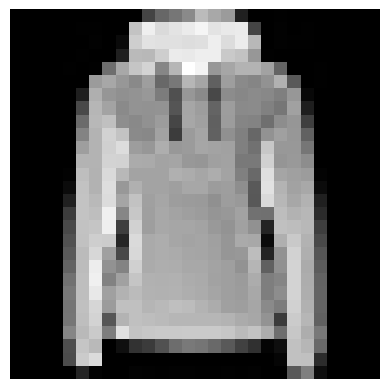

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


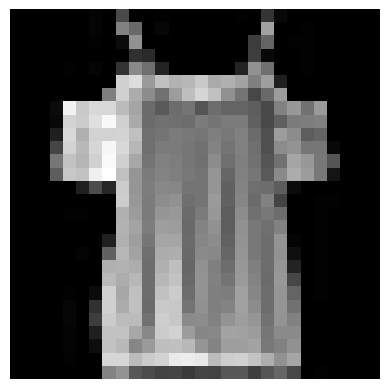

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


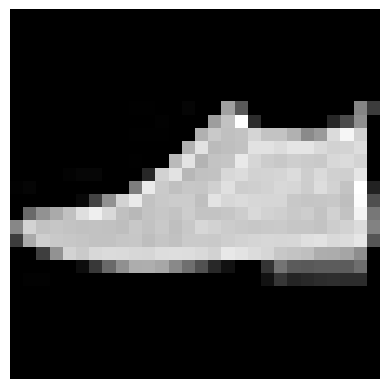

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


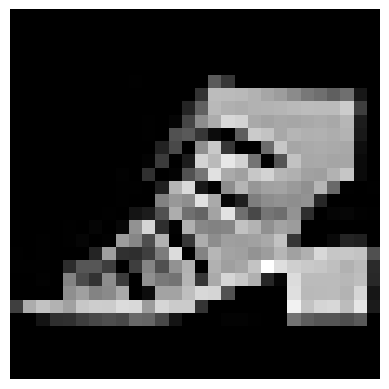

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


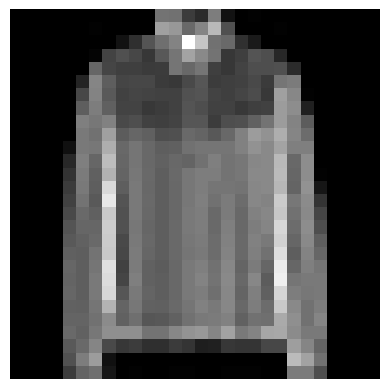

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


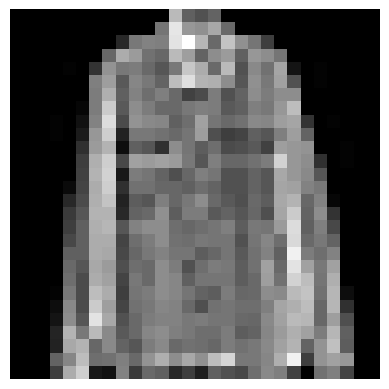

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


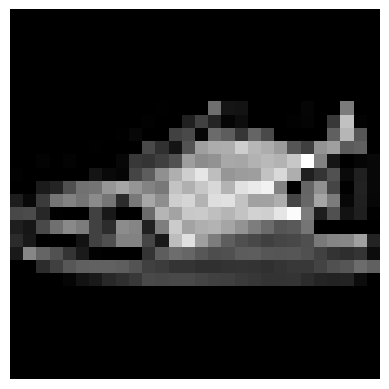

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


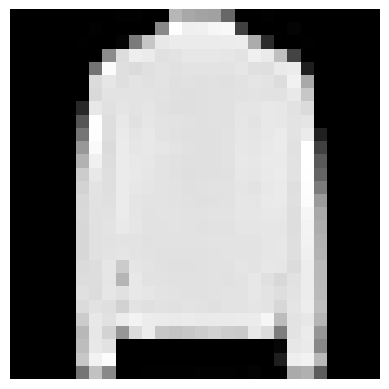

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


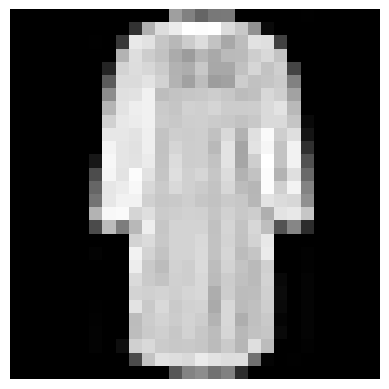

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


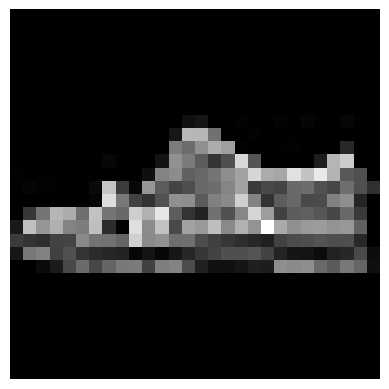

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


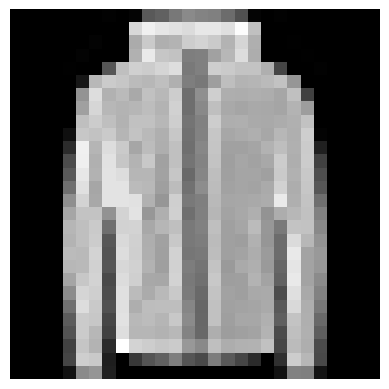

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


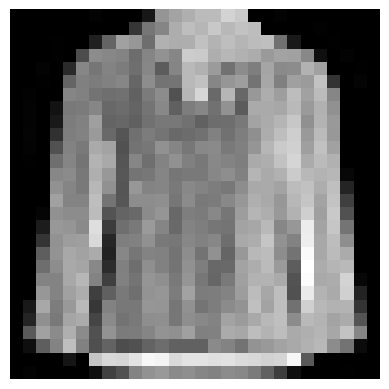

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


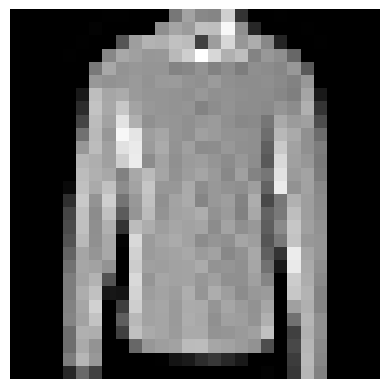

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


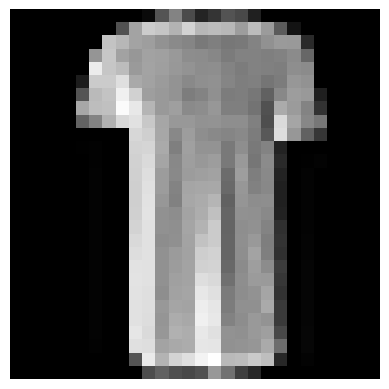

MLP label (ground-truth): T-shirt/top (Bag)
VGG16 label (ground-truth): Bag (Bag)


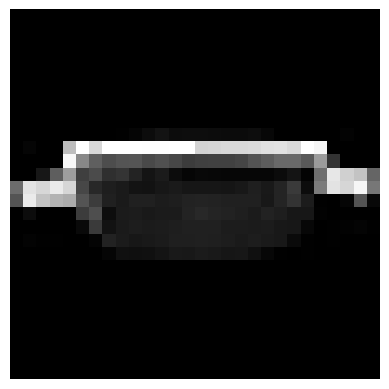

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


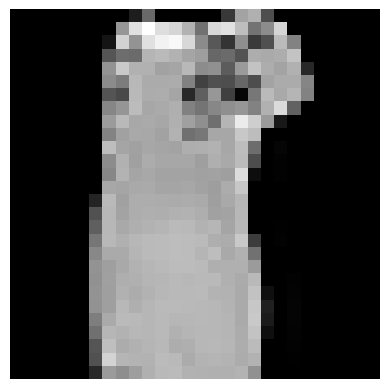

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


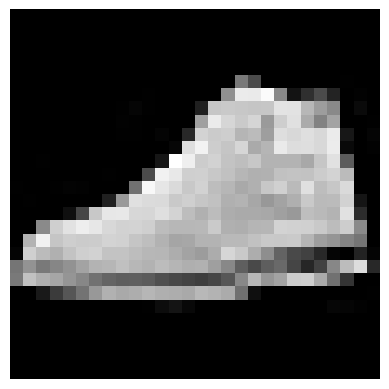

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


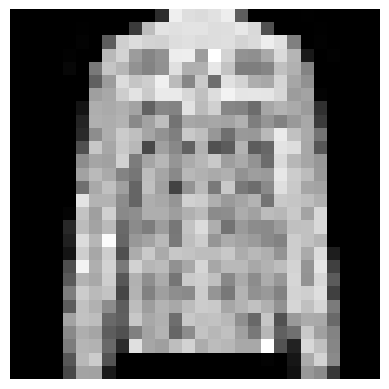

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


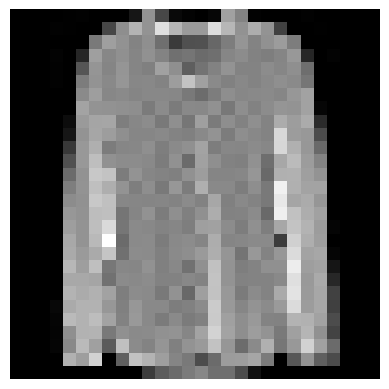

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


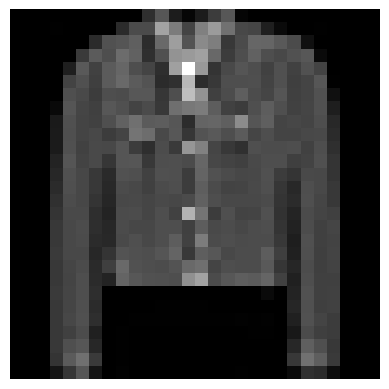

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


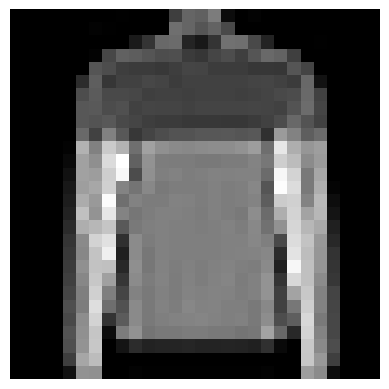

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


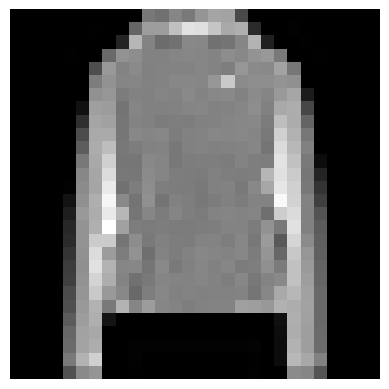

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


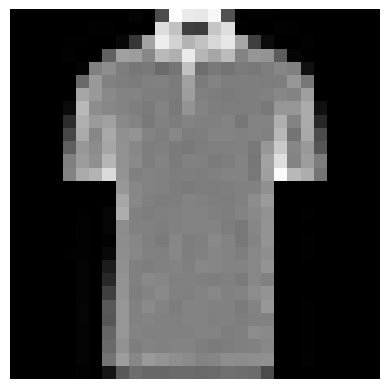

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


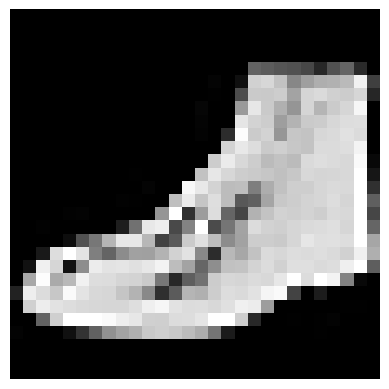

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


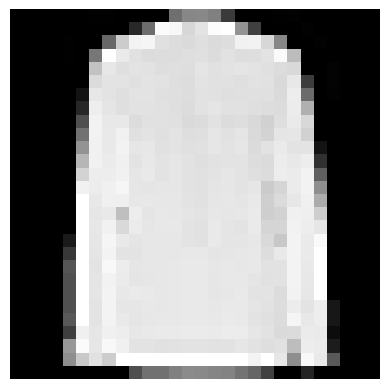

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


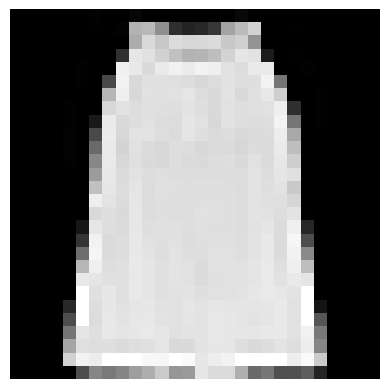

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


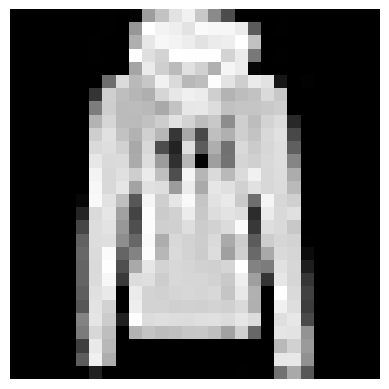

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


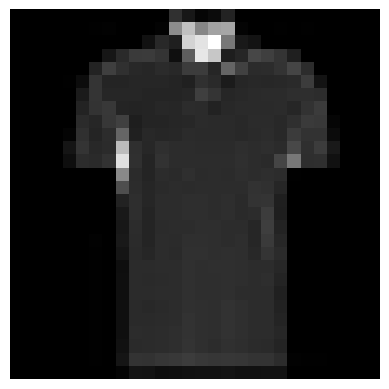

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


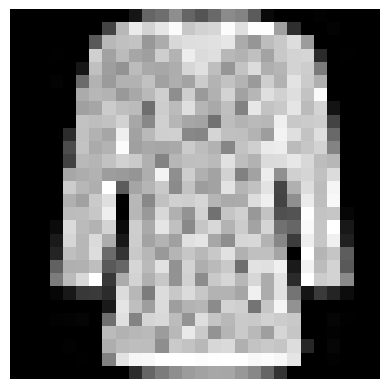

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


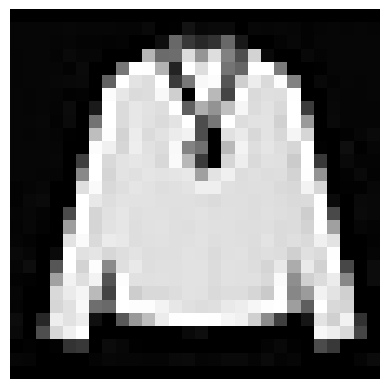

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


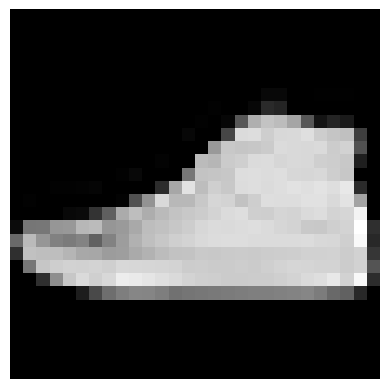

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


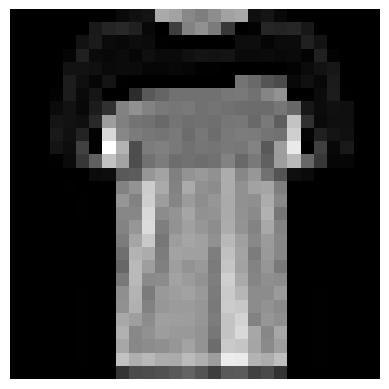

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


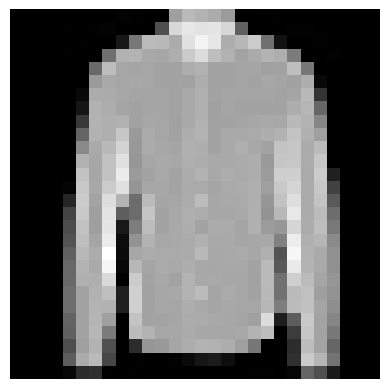

MLP label (ground-truth): Coat (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


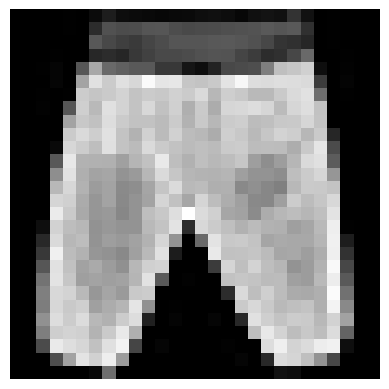

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


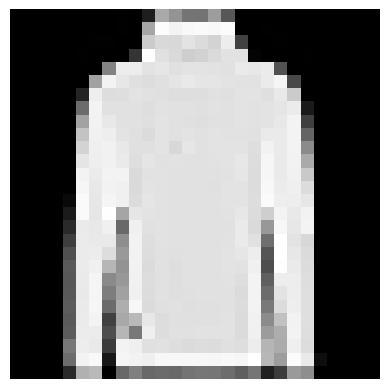

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


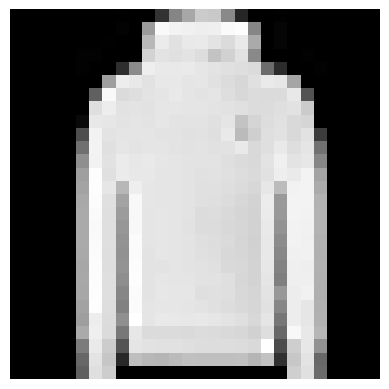

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


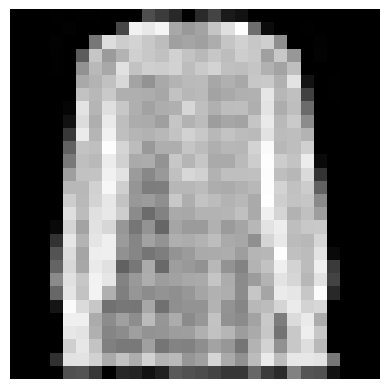

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


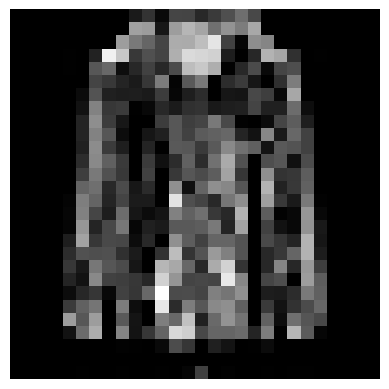

MLP label (ground-truth): Dress (Coat)
VGG16 label (ground-truth): Coat (Coat)


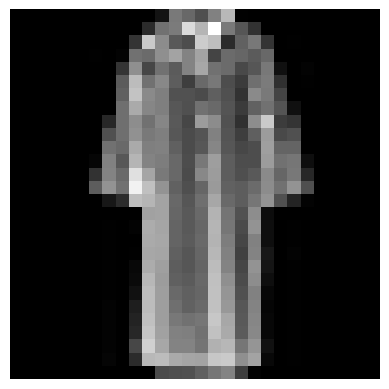

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


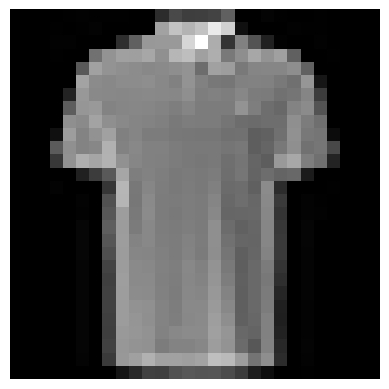

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


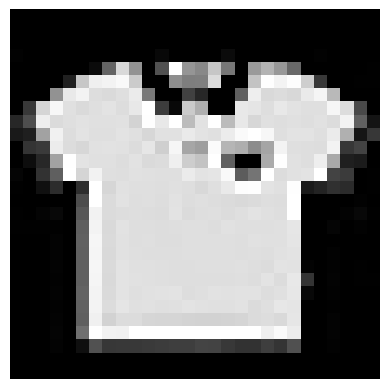

MLP label (ground-truth): Ankle boot (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


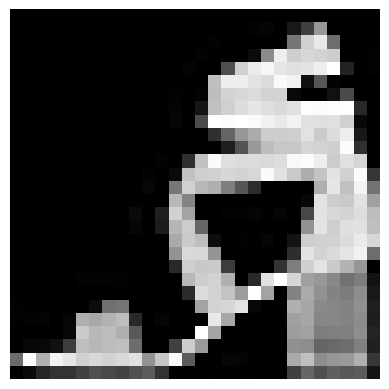

MLP label (ground-truth): Shirt (Dress)
VGG16 label (ground-truth): Dress (Dress)


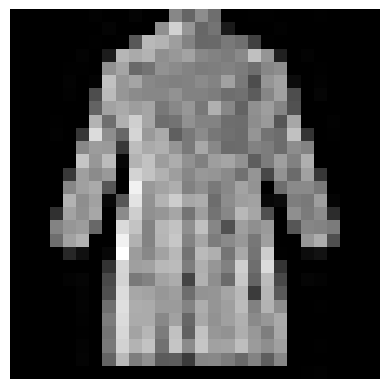

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


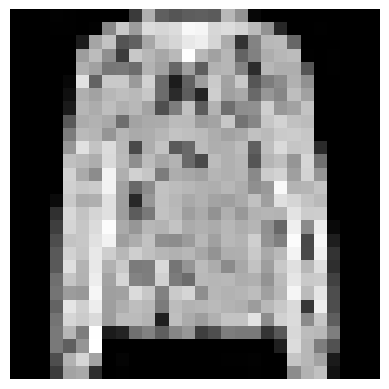

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


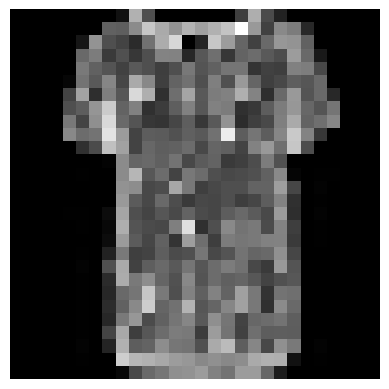

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


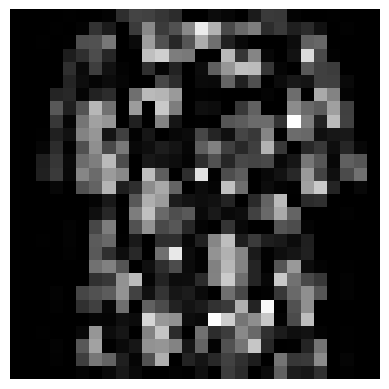

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


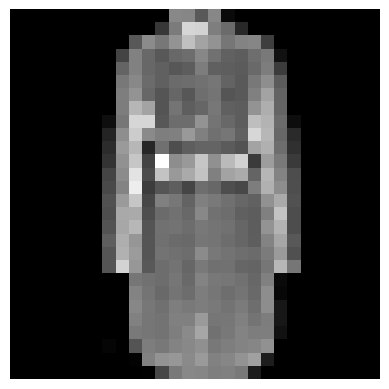

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


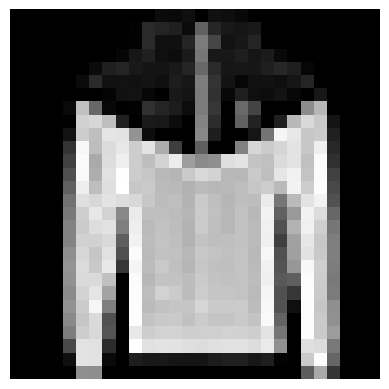

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


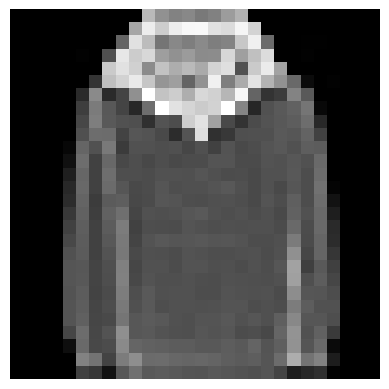

MLP label (ground-truth): Shirt (Coat)
VGG16 label (ground-truth): Coat (Coat)


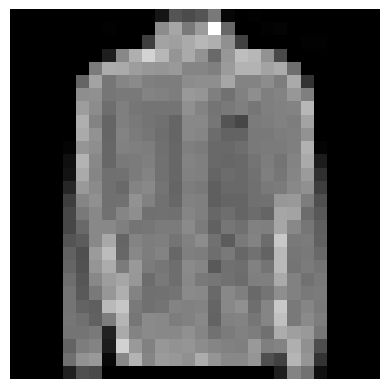

MLP label (ground-truth): Coat (Bag)
VGG16 label (ground-truth): Bag (Bag)


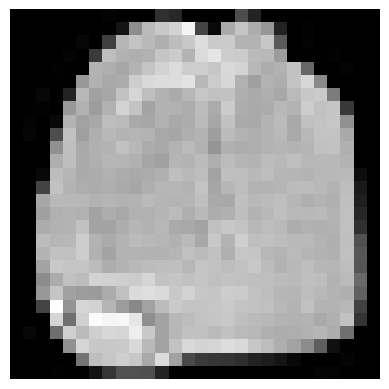

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


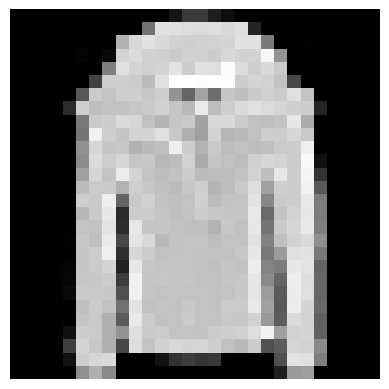

MLP label (ground-truth): Dress (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


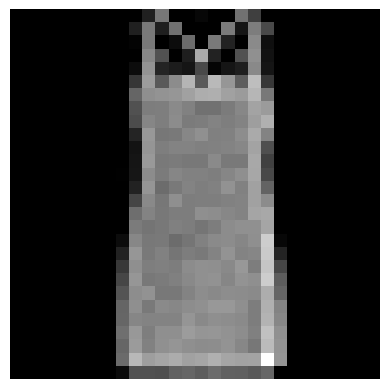

MLP label (ground-truth): Shirt (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


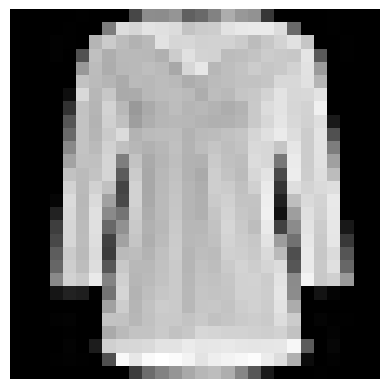

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


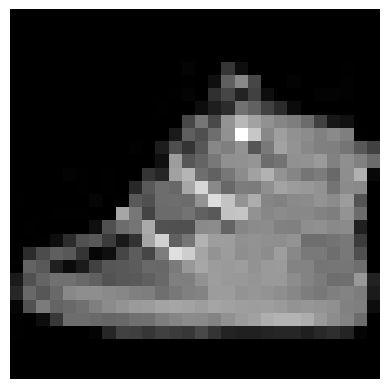

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


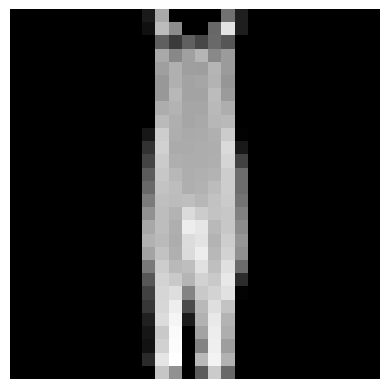

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


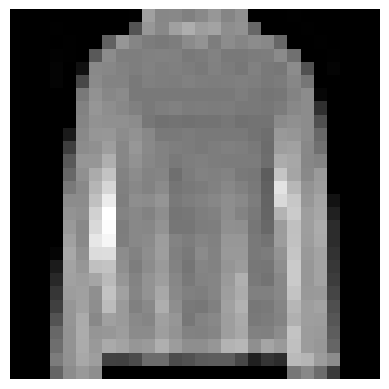

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


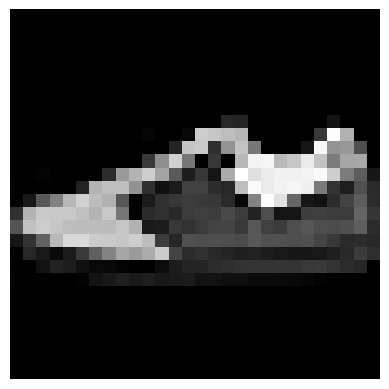

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


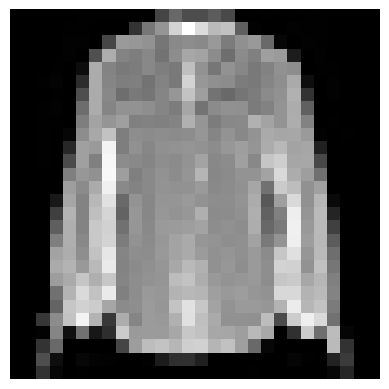

MLP label (ground-truth): Pullover (T-shirt/top)
VGG16 label (ground-truth): T-shirt/top (T-shirt/top)


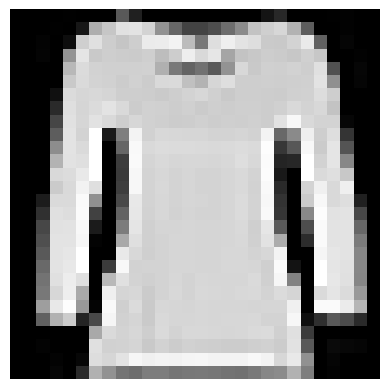

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


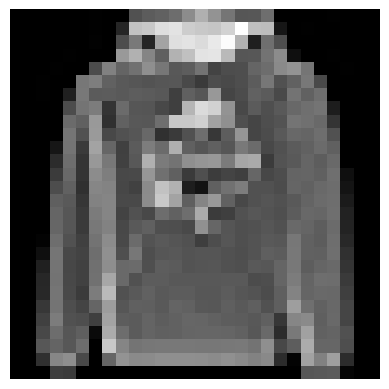

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


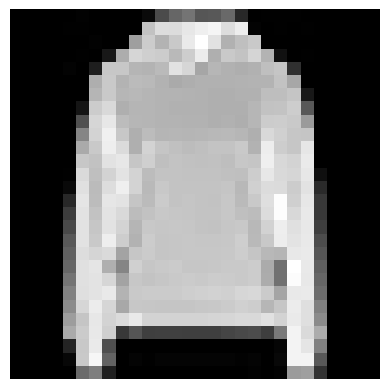

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


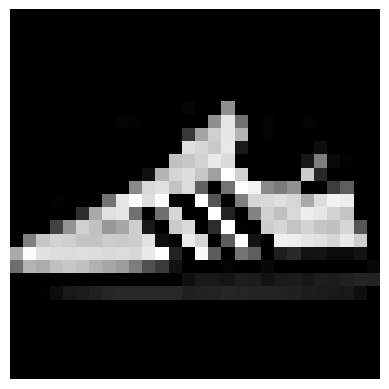

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


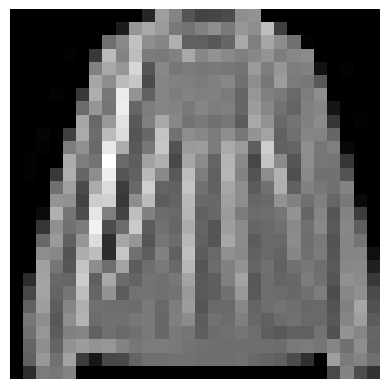

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


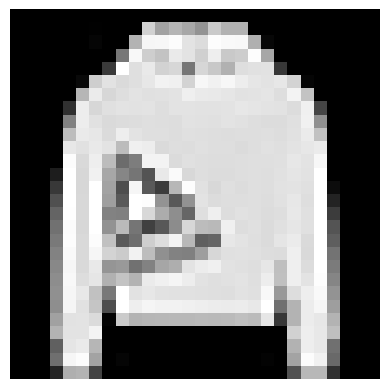

MLP label (ground-truth): Dress (Trouser)
VGG16 label (ground-truth): Trouser (Trouser)


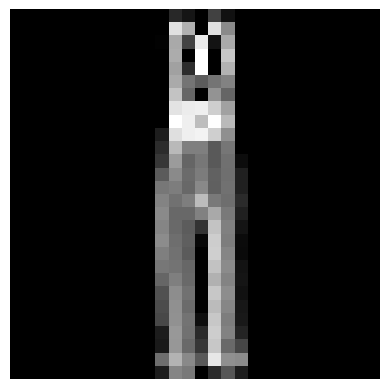

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


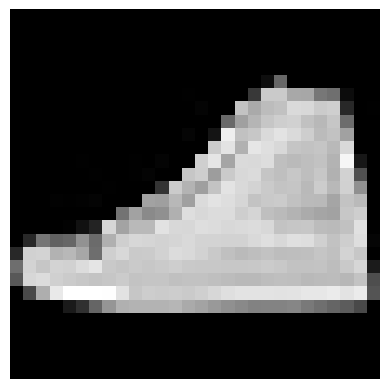

MLP label (ground-truth): Sneaker (Sandal)
VGG16 label (ground-truth): Sandal (Sandal)


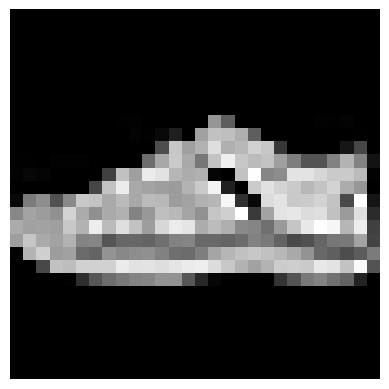

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


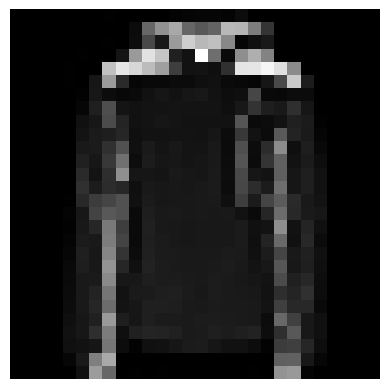

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


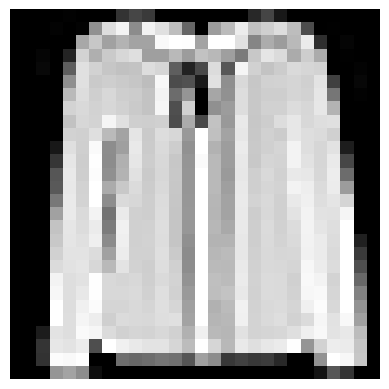

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


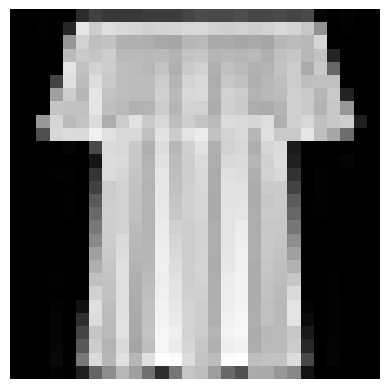

MLP label (ground-truth): Coat (Dress)
VGG16 label (ground-truth): Dress (Dress)


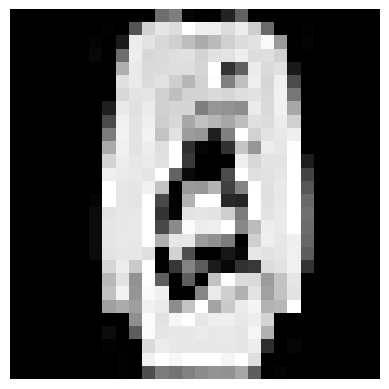

MLP label (ground-truth): T-shirt/top (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


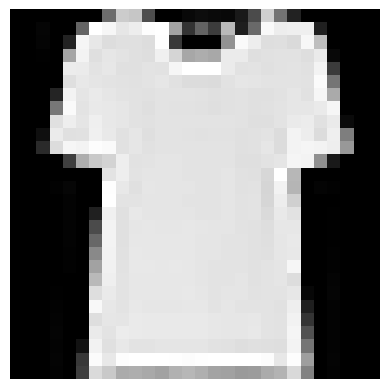

MLP label (ground-truth): Sandal (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


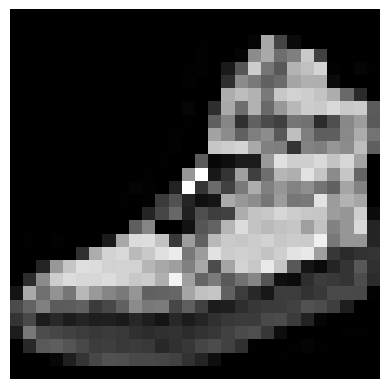

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


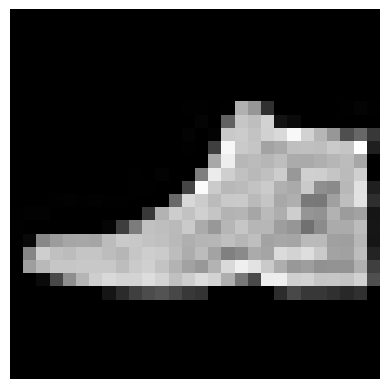

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


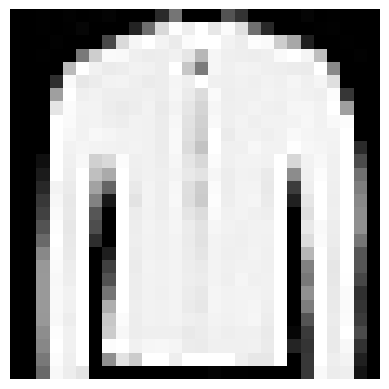

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


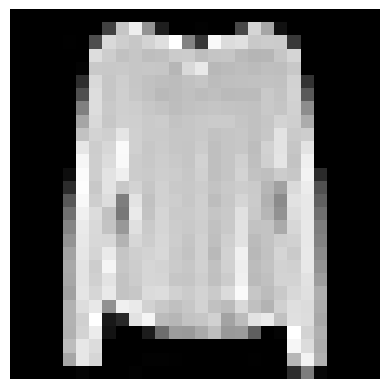

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


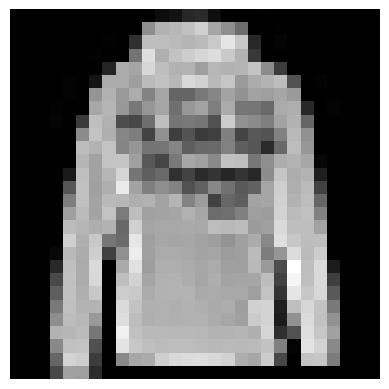

MLP label (ground-truth): T-shirt/top (Dress)
VGG16 label (ground-truth): Dress (Dress)


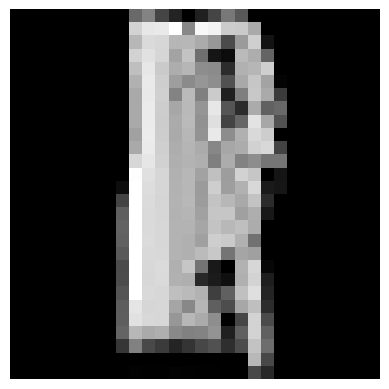

MLP label (ground-truth): Ankle boot (Sneaker)
VGG16 label (ground-truth): Sneaker (Sneaker)


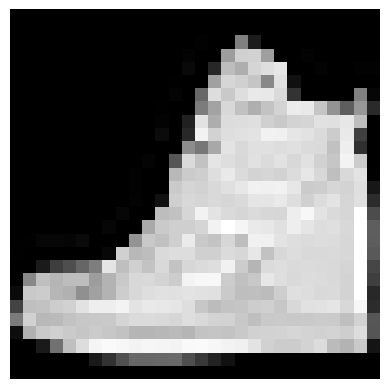

MLP label (ground-truth): Pullover (Bag)
VGG16 label (ground-truth): Bag (Bag)


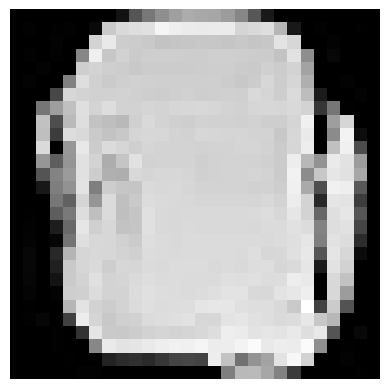

MLP label (ground-truth): Coat (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


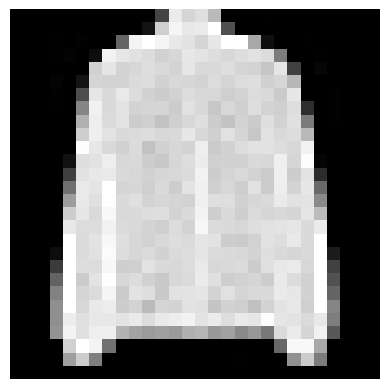

MLP label (ground-truth): Bag (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


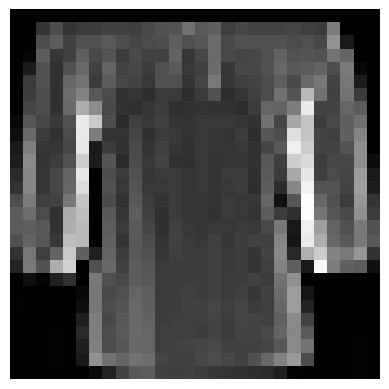

MLP label (ground-truth): Coat (Pullover)
VGG16 label (ground-truth): Pullover (Pullover)


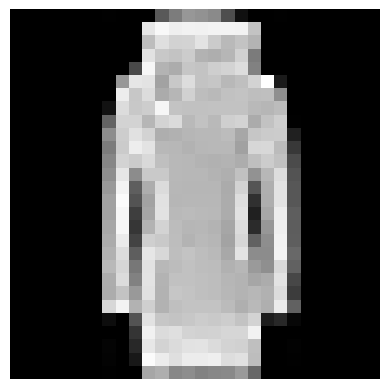

MLP label (ground-truth): Pullover (Shirt)
VGG16 label (ground-truth): Shirt (Shirt)


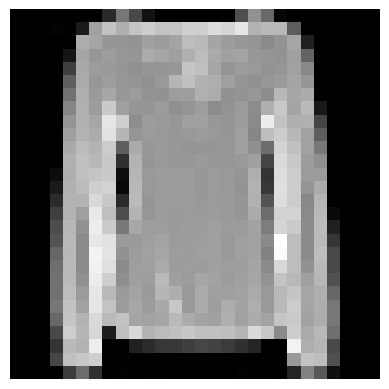

MLP label (ground-truth): Pullover (Coat)
VGG16 label (ground-truth): Coat (Coat)


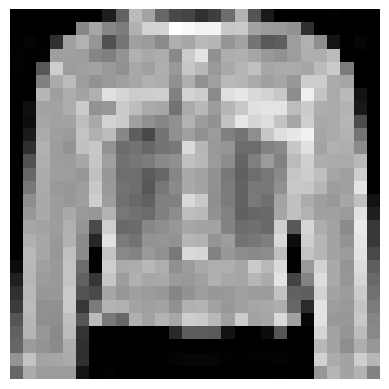

MLP label (ground-truth): Sneaker (Ankle boot)
VGG16 label (ground-truth): Ankle boot (Ankle boot)


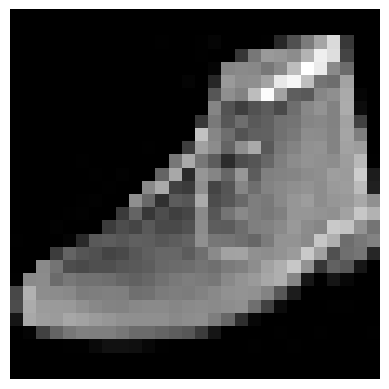

In [42]:
# Display the results with formatting
# Find indices where MLP predictions were incorrect, but VGG predictions are correct
incorrect_mlp_indices = np.where(targets != preds_1)[0]
correct_vgg_indices = np.where(targets == preds_3)[0]

# Find the intersection of the two sets to identify images where MLP was incorrect, but CNN is correct
correct_vgg_and_incorrect_mlp_indices = set(incorrect_mlp_indices) & set(correct_vgg_indices)

# Display the images and labels
for index in correct_vgg_and_incorrect_mlp_indices:
    vgg16_label = preds_3[index]
    ground_truth_label = targets[index]

    # Define label colors
    if vgg16_label != ground_truth_label:
        label_color = 'red'
    else:
        label_color = 'green'

    print(f"MLP label (ground-truth): {train_data.classes[preds_1[index]]} ({train_data.classes[ground_truth_label]})")
    print(f"VGG16 label (ground-truth): \033[91m{train_data.classes[vgg16_label]}\033[0m ({train_data.classes[ground_truth_label]})")

    # Display the image
    plt.imshow(test_data.data[index], cmap='gray')
    plt.axis('off')
    plt.show()

#### **Question 4.6** - Display in a single graph the loss functions for training and validation sets obtained with both MLP, CNN and VGG models.

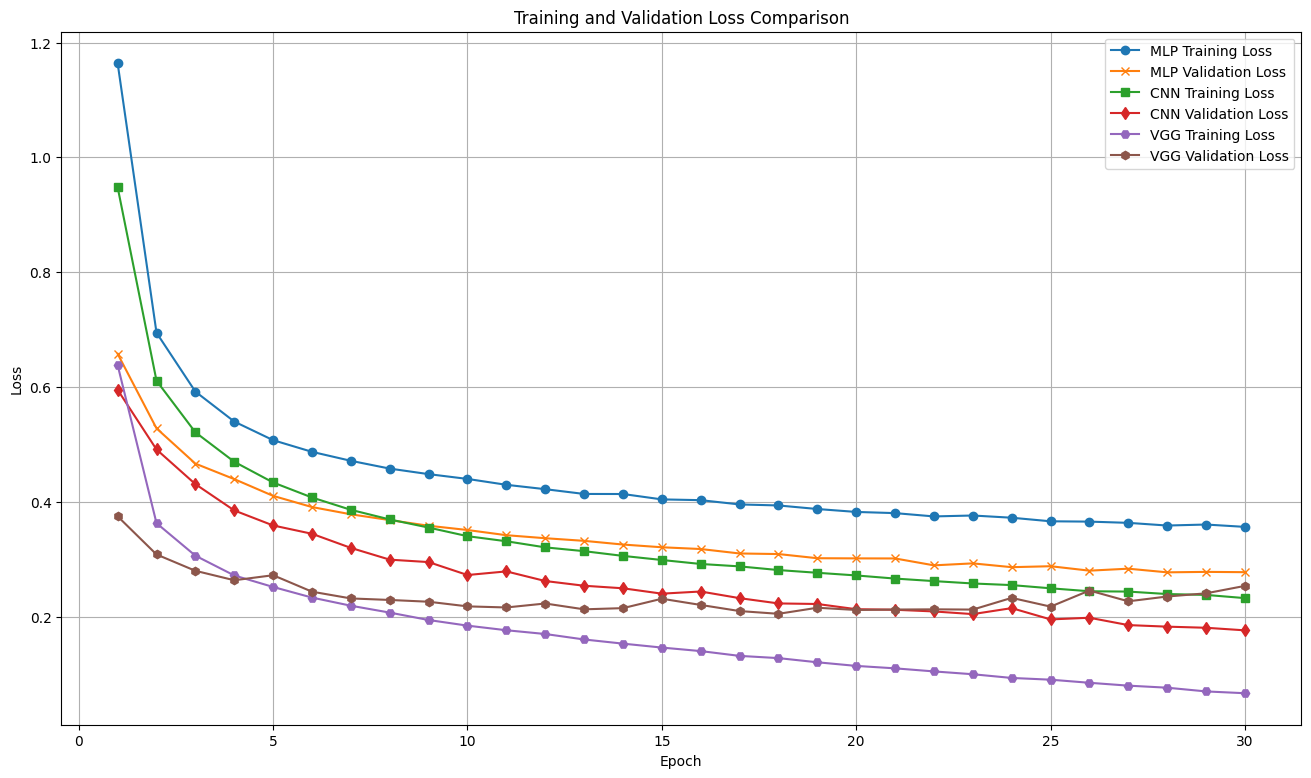

In [43]:
# Combine the training and validation losses for both models
train_losses_mlp = train_losses_1
valid_losses_mlp = valid_losses_1
train_losses_cnn = train_losses_2
valid_losses_cnn = valid_losses_2
train_losses_vgg = train_losses_3
valid_losses_vgg = valid_losses_3

# Create a range of epochs for the x-axis
epochs = range(1, len(train_losses_mlp) + 1)

# Plot the loss functions for both models
plt.figure(figsize=(16, 9))
plt.plot(epochs, train_losses_mlp, label='MLP Training Loss', marker='o')
plt.plot(epochs, valid_losses_mlp, label='MLP Validation Loss', marker='x')
plt.plot(epochs, train_losses_cnn, label='CNN Training Loss', marker='s')
plt.plot(epochs, valid_losses_cnn, label='CNN Validation Loss', marker='d')
plt.plot(epochs, train_losses_vgg, label='VGG Training Loss', marker='H')
plt.plot(epochs, valid_losses_vgg, label='VGG Validation Loss', marker='h')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## 5- Challenge <a class="anchor" id="section_5"></a>

#### **Question 5.1** - What is your best overall test accuracy and with which methodology? The first 3 teams will obtain bonus points! <a class="anchor" id="question_5_1"></a>

#####MPL = 87.60%
#####CNN = 91.13%
# **VGG = 92.46%**